***

This notebook contains the code samples found in Chapter 5, Section 2 of "Deep Learning with R"
***

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can potentially suffice if the model is small and well-regularized and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. The dataset for this exercise has been uploaded to google drive & we will download this at the beginning of our exercise.

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our models on less than 10% of the data that was available to the competitors. This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class. For ease of use, these subsets will be created for you.

Here are a few lines of code to do this.
We will be installing a few required packages & doing a one time authentication of google drive to download the images.

In [ ]:
install.packages('googledrive') 
install.packages('httpuv') 
library(googledrive) 
library(httpuv)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘promises’, ‘later’




In [ ]:
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { #may update python version  
                                       #occasionally
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




We need to authenticate a connection to the course google drive that contain the images once.

After running the below script:

1) Click on the link that appears at the bottom   
2) Select the google account associated with this Colab session (The account displayed in colab at the top right!)   
3) Check all tickboxes to give R permission to download images from the drive    
4) Copy the code displayed & paste it here at the field shown & press enter

In [ ]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWjk2GsBDs6dkOjSZA44eaw6-XGksUO3mAztpvIfC1jLUkDwWTwPEIs


Creating directories to hold Train, Test & Validation images

In [ ]:
base_dir <- "Dataset"
dir.create(base_dir)

train_dir <- file.path(base_dir,"train")
dir.create(train_dir)
train_cats_dir <- file.path(train_dir,"cats")
dir.create(train_cats_dir)
train_dogs_dir <- file.path(train_dir,"dogs")
dir.create(train_dogs_dir)

test_dir <- file.path(base_dir,"test")
dir.create(test_dir)
test_cats_dir <- file.path(test_dir,"cats")
dir.create(test_cats_dir)
test_dogs_dir <- file.path(test_dir,"dogs")
dir.create(test_dogs_dir)

validation_dir <- file.path(base_dir,"validation")
dir.create(validation_dir)
validation_cats_dir <- file.path(validation_dir,"cats")
dir.create(validation_cats_dir)
validation_dogs_dir <- file.path(validation_dir,"dogs")
dir.create(validation_dogs_dir)

Downloading images from Validation folder in Drive to Colab Local (Please note this will take about 12 mins)

In [ ]:
validation_cat_files <- drive_ls("~/AI_Datasets/validation/",recursive = T,pattern = "cat",type = "jpg")
length(validation_cat_files$id)
setwd('/content/Dataset/validation/cats')
for(n in 1:length(validation_cat_files$id)){
x <- drive_get(as_id(validation_cat_files$id[n]))
drive_download(x)
print(n)
}

validation_dog_files <- drive_ls("~/AI_Datasets/validation/",recursive = T,pattern = "dog",type = "jpg")
length(validation_dog_files$id)
setwd('/content/Dataset/validation/dogs')
for(n in 1:length(validation_dog_files$id)){
x <- drive_get(as_id(validation_dog_files$id[n]))
drive_download(x)
print(n)
}










→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900

→ Files retrieved so far: 1000



[1] 500

File downloaded:

• cat.1500.jpg <id: 1fT7llachOI7TGoywuhLh9NbGvp1Mc5Rz>

Saved locally as:

• cat.1500.jpg



[1] 1


File downloaded:

• cat.1499.jpg <id: 18s-T-In13u2zxgnWGvApeDvvn6A7c3H_>

Saved locally as:

• cat.1499.jpg



[1] 2


File downloaded:

• cat.1498.jpg <id: 1-30jtEtJcU7sRLcVUcHu9Bf_3D_qV8nH>

Saved locally as:

• cat.1498.jpg



[1] 3


File downloaded:

• cat.1497.jpg <id: 1ExDH4hK9X7JsXMMWA2SzDsSIYd-h9zVu>

Saved locally as:

• cat.1497.jpg



[1] 4


File downloaded:

• cat.1496.jpg <id: 104IpG4EYr3KZCRK8Ak5xHSIty2fWkR31>

Saved locally as:

• cat.1496.jpg



[1] 5


File downloaded:

• cat.1494.jpg <id: 1cinWzGm7175RGJdpdkI7PU5fWuLDuvoc>

Saved locally as:

• cat.1494.jpg



[1] 6


File downloaded:

• cat.1495.jpg <id: 1oBT2znLh7-_LeBzlsSAE0GoV9nnDyfTt>

Saved locally as:

• cat.1495.jpg



[1] 7


File downloaded:

• cat.1493.jpg <id: 1QgQ5h7y7TuDVwx94STLIhkmYb_XxepYr>

Saved locally as:

• cat.1493.jpg



[1] 8


File downloaded:

• cat.1492.jpg <id: 156PyUKeSXpBYmYmjjLqDyLMVi6fLsQLg>

Saved locally as:

• cat.1492.jpg



[1] 9


File downloaded:

• cat.1489.jpg <id: 1KD67GbSzttjL98M7T4TmRQl6KajsXj37>

Saved locally as:

• cat.1489.jpg



[1] 10


File downloaded:

• cat.1485.jpg <id: 1s2EHctOL95qNMj8W6KUYueAvB9JGbICS>

Saved locally as:

• cat.1485.jpg



[1] 11


File downloaded:

• cat.1483.jpg <id: 1v1idd3a98IPYO7tAILLM7QZv3KI1qQL3>

Saved locally as:

• cat.1483.jpg



[1] 12


File downloaded:

• cat.1482.jpg <id: 1ry6mjTeGrng9xO0xpYRYE9dp6EBDyDu4>

Saved locally as:

• cat.1482.jpg



[1] 13


File downloaded:

• cat.1486.jpg <id: 1FMlUQLeIbPbVjnRF8xepWrS9j3LjG0_O>

Saved locally as:

• cat.1486.jpg



[1] 14


File downloaded:

• cat.1490.jpg <id: 1BVkVubeWTAgZ2WSA2Pj2YQ54S2c9sQc1>

Saved locally as:

• cat.1490.jpg



[1] 15


File downloaded:

• cat.1487.jpg <id: 1Y598n9c8RxdYIRfAT97346yCbpnmQm21>

Saved locally as:

• cat.1487.jpg



[1] 16


File downloaded:

• cat.1488.jpg <id: 1pmXBoYkHWkWkTIeXj60rELfusiqxzf-p>

Saved locally as:

• cat.1488.jpg



[1] 17


File downloaded:

• cat.1491.jpg <id: 1soOOY1HfMfF4fyNs4w_Tcj5E629VvE7d>

Saved locally as:

• cat.1491.jpg



[1] 18


File downloaded:

• cat.1484.jpg <id: 1K1POaiayPPMzh45zFSl0cfKkmlvWtCoN>

Saved locally as:

• cat.1484.jpg



[1] 19


File downloaded:

• cat.1481.jpg <id: 1Mdkujr4qUbFEGLk1VPWmzWXxygrMxgA7>

Saved locally as:

• cat.1481.jpg



[1] 20


File downloaded:

• cat.1480.jpg <id: 1eEaDX0T-7zL_8o6xCIDg9RR9zlz71cvm>

Saved locally as:

• cat.1480.jpg



[1] 21


File downloaded:

• cat.1472.jpg <id: 1wgE3xfZ44gb7pdAgPPPr5gyu4NN-sGxJ>

Saved locally as:

• cat.1472.jpg



[1] 22


File downloaded:

• cat.1476.jpg <id: 147TRAB-vidBna9B5sT7f0KJmdHviJxHW>

Saved locally as:

• cat.1476.jpg



[1] 23


File downloaded:

• cat.1478.jpg <id: 1RyyuKoFY8NDq2fS4bJeRfFPZn8Td-clG>

Saved locally as:

• cat.1478.jpg



[1] 24


File downloaded:

• cat.1475.jpg <id: 1n03k8jQFQb8EqfSiANgM0_-suQoZv6r6>

Saved locally as:

• cat.1475.jpg



[1] 25


File downloaded:

• cat.1477.jpg <id: 1likBXM6TJo7kAFcHf48WltBUfV8y9X5T>

Saved locally as:

• cat.1477.jpg



[1] 26


File downloaded:

• cat.1470.jpg <id: 1MI6lqAzHhMCaeKOzrrhDnH3OtlveGB3o>

Saved locally as:

• cat.1470.jpg



[1] 27


File downloaded:

• cat.1473.jpg <id: 1GtAiikWFWLNWCt9RpcLiF9gS-QNGCbJ7>

Saved locally as:

• cat.1473.jpg



[1] 28


File downloaded:

• cat.1474.jpg <id: 1ygcq5V5g_zQdn0z7m97TfsrSqBntgKy->

Saved locally as:

• cat.1474.jpg



[1] 29


File downloaded:

• cat.1479.jpg <id: 1RL-ST-ycZGYssMgKImZY-WNcDnOr3kwq>

Saved locally as:

• cat.1479.jpg



[1] 30


File downloaded:

• cat.1471.jpg <id: 1DgcEeTW1Gjzmc6Im1izRMO0Qk1mgzXVX>

Saved locally as:

• cat.1471.jpg



[1] 31


File downloaded:

• cat.1469.jpg <id: 10qQwEqkKROlvQHt9Rs2ZR358OZSzvMOW>

Saved locally as:

• cat.1469.jpg



[1] 32


File downloaded:

• cat.1461.jpg <id: 1o_3Y376CItOiLXvdpHc3bG1EoFA6mUGQ>

Saved locally as:

• cat.1461.jpg



[1] 33


File downloaded:

• cat.1465.jpg <id: 1PZcXxcZ4bMsUZXzKWHdAaj_33wnbwLFs>

Saved locally as:

• cat.1465.jpg



[1] 34


File downloaded:

• cat.1464.jpg <id: 1oGRe6ub6UdtRQUq0vaWi1iJMWhuqc4ix>

Saved locally as:

• cat.1464.jpg



[1] 35


File downloaded:

• cat.1468.jpg <id: 1mwk0fUCZ_E-tHs1AoMouvYSskFEFEa1k>

Saved locally as:

• cat.1468.jpg



[1] 36


File downloaded:

• cat.1467.jpg <id: 1JZgnMEIBXlVZbAvOrjojG9AweTD1apjC>

Saved locally as:

• cat.1467.jpg



[1] 37


File downloaded:

• cat.1459.jpg <id: 18rKIU5chNYwy2jNJn6E7ZtJ1qSRlr4tR>

Saved locally as:

• cat.1459.jpg



[1] 38


File downloaded:

• cat.1463.jpg <id: 1iiJwpXTKgeKv68s5-JBQG638HAZwG_u3>

Saved locally as:

• cat.1463.jpg



[1] 39


File downloaded:

• cat.1460.jpg <id: 19sCE_iyJuD-jueEgGGOZmAg3SeIp381L>

Saved locally as:

• cat.1460.jpg



[1] 40


File downloaded:

• cat.1462.jpg <id: 1cVx2lylfFz5mf131oM2fqqw7ca3ZN8of>

Saved locally as:

• cat.1462.jpg



[1] 41


File downloaded:

• cat.1458.jpg <id: 1_Ipgrl-p9PuHHzZj9riuPBPUy_3A322L>

Saved locally as:

• cat.1458.jpg



[1] 42


File downloaded:

• cat.1466.jpg <id: 1U-vm8uKDoFhzSHZfQZcN_6gWfoFs-jpA>

Saved locally as:

• cat.1466.jpg



[1] 43


File downloaded:

• cat.1457.jpg <id: 182GicnBakL2Q7ksSR4-QRe3w7aiu9CPu>

Saved locally as:

• cat.1457.jpg



[1] 44


File downloaded:

• cat.1456.jpg <id: 1ldrjrMQCVfLHsx_ew2APU4qAxM9JfciA>

Saved locally as:

• cat.1456.jpg



[1] 45


File downloaded:

• cat.1449.jpg <id: 11e_Bc_KOoGoaJEIuVxTKr-LrSh7P4o9j>

Saved locally as:

• cat.1449.jpg



[1] 46


File downloaded:

• cat.1447.jpg <id: 1qaJlxLR2icg7eGvbsc3rwR4KOdlPeoGK>

Saved locally as:

• cat.1447.jpg



[1] 47


File downloaded:

• cat.1452.jpg <id: 14YX5lI_0KC9Azh5-38861yu1MQpqCmeT>

Saved locally as:

• cat.1452.jpg



[1] 48


File downloaded:

• cat.1450.jpg <id: 1IOBb-W5woVANF6-mJoG4L0YzBSlZYdBg>

Saved locally as:

• cat.1450.jpg



[1] 49


File downloaded:

• cat.1454.jpg <id: 1bXPwOwMillGu0P1jJ5JdyVKdvLQ-RP-q>

Saved locally as:

• cat.1454.jpg



[1] 50


File downloaded:

• cat.1453.jpg <id: 1u8v3HQ7_zFWqs1_NR30_WN4ekEEz0yUK>

Saved locally as:

• cat.1453.jpg



[1] 51


File downloaded:

• cat.1448.jpg <id: 1EhQkNZMy8qKmQ0sthdqrrhdzg0d6l_3->

Saved locally as:

• cat.1448.jpg



[1] 52


File downloaded:

• cat.1451.jpg <id: 1rcnGqojHV-P5VUMwa34YngTPDWnSH_91>

Saved locally as:

• cat.1451.jpg



[1] 53


File downloaded:

• cat.1455.jpg <id: 1hrAtGApSBtbSmTdCvQeBloYl4_G-lfOx>

Saved locally as:

• cat.1455.jpg



[1] 54


File downloaded:

• cat.1446.jpg <id: 1qfpBqqDCtWXl6d3YNVsvMcJY5-8v0eBV>

Saved locally as:

• cat.1446.jpg



[1] 55


File downloaded:

• cat.1445.jpg <id: 1fsp29xIa5i8Gsk3nWVJYt7YFrh0AEHOn>

Saved locally as:

• cat.1445.jpg



[1] 56


File downloaded:

• cat.1440.jpg <id: 1EGH0T9S26mwOonKMAlH1eOh7xI-9OC82>

Saved locally as:

• cat.1440.jpg



[1] 57


File downloaded:

• cat.1441.jpg <id: 1feGS7v6kVmHa0o2pRpgkb9PhrvORPiVv>

Saved locally as:

• cat.1441.jpg



[1] 58


File downloaded:

• cat.1444.jpg <id: 12w_2otVnNpiNT-C17lm5EyQBwL-7Cgfm>

Saved locally as:

• cat.1444.jpg



[1] 59


File downloaded:

• cat.1443.jpg <id: 1gN-_duNncew66vPnXIPrfz3B5sbscIAA>

Saved locally as:

• cat.1443.jpg



[1] 60


File downloaded:

• cat.1437.jpg <id: 1USIBKKJ1YGylkvI-2Wwvtzwwl0z2cxSh>

Saved locally as:

• cat.1437.jpg



[1] 61


File downloaded:

• cat.1439.jpg <id: 1bfRyIaTMIrpdPo1BXxEqlwkXgEz2YiRB>

Saved locally as:

• cat.1439.jpg



[1] 62


File downloaded:

• cat.1433.jpg <id: 1xesi-PhbBxlp41aMZvTdwm6pHZEQcI6s>

Saved locally as:

• cat.1433.jpg



[1] 63


File downloaded:

• cat.1435.jpg <id: 1jfLBp2g9DdITrtFhEa7dfx_F3SsMYTJi>

Saved locally as:

• cat.1435.jpg



[1] 64


File downloaded:

• cat.1438.jpg <id: 1rzPO7R3b8aEwK6JR0nmBHLQxsQY2uDSH>

Saved locally as:

• cat.1438.jpg



[1] 65


File downloaded:

• cat.1436.jpg <id: 1pJNWwXXIXWHAdaKDUicein9skcmOJLgY>

Saved locally as:

• cat.1436.jpg



[1] 66


File downloaded:

• cat.1442.jpg <id: 179_FAeLBq3nOWvVGV_KTt129BCxg6Egu>

Saved locally as:

• cat.1442.jpg



[1] 67


File downloaded:

• cat.1434.jpg <id: 1Lh8Kf8vygUk7dLD8zqvwUVE0kl0n9Xjj>

Saved locally as:

• cat.1434.jpg



[1] 68


File downloaded:

• cat.1432.jpg <id: 1BfcKsB0xXUM9NMVnr4KPy74nB_r5IbhP>

Saved locally as:

• cat.1432.jpg



[1] 69


File downloaded:

• cat.1431.jpg <id: 1lkoKiSf9ML4OmuMQWoiLC_X7gBLeRQPM>

Saved locally as:

• cat.1431.jpg



[1] 70


File downloaded:

• cat.1421.jpg <id: 1AV-CiGGOzTUJH-j-ShWa82Nn7MRCddz_>

Saved locally as:

• cat.1421.jpg



[1] 71


File downloaded:

• cat.1428.jpg <id: 1i8L5RjDMUCcRkupCZAww63-JeiuD39pd>

Saved locally as:

• cat.1428.jpg



[1] 72


File downloaded:

• cat.1427.jpg <id: 1nZfWOBqqriHY6vcM_VME_qyhSJm6lSkb>

Saved locally as:

• cat.1427.jpg



[1] 73


File downloaded:

• cat.1426.jpg <id: 1xcLji2pSX_WRaOtrPcV8hKVybdpovGXe>

Saved locally as:

• cat.1426.jpg



[1] 74


File downloaded:

• cat.1425.jpg <id: 1T4GfAf2pPya9RbbmRij1nbeqloiVtssX>

Saved locally as:

• cat.1425.jpg



[1] 75


File downloaded:

• cat.1423.jpg <id: 1-i5e-FS5K9cDRflo9qtYLPKFlfu0yzHk>

Saved locally as:

• cat.1423.jpg



[1] 76


File downloaded:

• cat.1424.jpg <id: 1CvKVf7bHgIKttcCiu-2-Rl4WTZdyxFy5>

Saved locally as:

• cat.1424.jpg



[1] 77


File downloaded:

• cat.1429.jpg <id: 1UOuld4GRN1D9qnEpXOf5UQn5RadTbPWX>

Saved locally as:

• cat.1429.jpg



[1] 78


File downloaded:

• cat.1430.jpg <id: 1NYwRYQdHnsFYSy_3bsqwLHVoygupNcl9>

Saved locally as:

• cat.1430.jpg



[1] 79


File downloaded:

• cat.1422.jpg <id: 1nTHpC9nrD5hEotESQx4vjQFW6arGuGlr>

Saved locally as:

• cat.1422.jpg



[1] 80


File downloaded:

• cat.1420.jpg <id: 1PvRx_w3J0rrw-Mf1RYo-RC3W61f1-m4Q>

Saved locally as:

• cat.1420.jpg



[1] 81


File downloaded:

• cat.1419.jpg <id: 1f8N6ms0RAKkOP1OoyzTrHYEa9u51oBiy>

Saved locally as:

• cat.1419.jpg



[1] 82


File downloaded:

• cat.1418.jpg <id: 1vmdAcn0z_8jLisCap8gCM1wTlahL1JlZ>

Saved locally as:

• cat.1418.jpg



[1] 83


File downloaded:

• cat.1412.jpg <id: 1by65t7v_j2etYzUn7ci9cgJ-IdDC5VT9>

Saved locally as:

• cat.1412.jpg



[1] 84


File downloaded:

• cat.1416.jpg <id: 1_A_sQK02-ogpJMvoTr5JqEipS2MQb6vp>

Saved locally as:

• cat.1416.jpg



[1] 85


File downloaded:

• cat.1411.jpg <id: 1fI566ckTuO_KkuFZVwZdpwOAZJZWHd0G>

Saved locally as:

• cat.1411.jpg



[1] 86


File downloaded:

• cat.1415.jpg <id: 18MZcz4dQwUtViCjMdKkHRaCwCHWN-mcA>

Saved locally as:

• cat.1415.jpg



[1] 87


File downloaded:

• cat.1414.jpg <id: 1DQs_7HslRsW3suVwKD8ZU_17wJoybx6Y>

Saved locally as:

• cat.1414.jpg



[1] 88


File downloaded:

• cat.1408.jpg <id: 1lR475yevd9DlUMvpxSu9D5EfUYZS8FF1>

Saved locally as:

• cat.1408.jpg



[1] 89


File downloaded:

• cat.1413.jpg <id: 1a393aHvYFesYyT_pvhaDhD7cVFhsIKl0>

Saved locally as:

• cat.1413.jpg



[1] 90


File downloaded:

• cat.1409.jpg <id: 1RfMe--NvKaimho55vHRXb8F61R8HUbbm>

Saved locally as:

• cat.1409.jpg



[1] 91


File downloaded:

• cat.1417.jpg <id: 1Eo2uXA3z-A5iafU_wdKatPZyWBVkUejP>

Saved locally as:

• cat.1417.jpg



[1] 92


File downloaded:

• cat.1410.jpg <id: 1HSwRRio2cDYmX3HkXm2dXwhDLzBsOmGv>

Saved locally as:

• cat.1410.jpg



[1] 93


File downloaded:

• cat.1407.jpg <id: 1KMOX0ycAIr0C9aKcSlAQeTN_IKDJeR5F>

Saved locally as:

• cat.1407.jpg



[1] 94


File downloaded:

• cat.1404.jpg <id: 1eZc1eoIYAZmWWhALwFd37FwjkmYuJtWV>

Saved locally as:

• cat.1404.jpg



[1] 95


File downloaded:

• cat.1403.jpg <id: 1Q_RdzQJj4871OSTnQBlrMKJo-Ogxa_ng>

Saved locally as:

• cat.1403.jpg



[1] 96


File downloaded:

• cat.1402.jpg <id: 1NF4A6CtktqfBTR53xGx8TfX0BWW1kGFt>

Saved locally as:

• cat.1402.jpg



[1] 97


File downloaded:

• cat.1401.jpg <id: 1YNFZhCsakFWOfa6ySuCNT6gdthIZpPAy>

Saved locally as:

• cat.1401.jpg



[1] 98


File downloaded:

• cat.1406.jpg <id: 1rRAvFHU09JZoF80diaGrTOWbPRfblivn>

Saved locally as:

• cat.1406.jpg



[1] 99


File downloaded:

• cat.1399.jpg <id: 1qPuL1SHO57R67N-dPEWcPqzMpa4vJBnu>

Saved locally as:

• cat.1399.jpg



[1] 100


File downloaded:

• cat.1397.jpg <id: 1vkyeH5yiSK2UFcPh1NjJ9tHyf5uR2KTv>

Saved locally as:

• cat.1397.jpg



[1] 101


File downloaded:

• cat.1398.jpg <id: 12ikXC7Ou0B081ohdCZPowcuta_fX4Lwl>

Saved locally as:

• cat.1398.jpg



[1] 102


File downloaded:

• cat.1400.jpg <id: 1NekEAachPfSPvPyxWjyuMVywZGBa16CD>

Saved locally as:

• cat.1400.jpg



[1] 103


File downloaded:

• cat.1405.jpg <id: 1TEN1Yx2UBeoSJkJRajJDcRv6sQZJIM9G>

Saved locally as:

• cat.1405.jpg



[1] 104


File downloaded:

• cat.1396.jpg <id: 1N4zG6sZDuOU8_E4bltGz1BFan8IRrb00>

Saved locally as:

• cat.1396.jpg



[1] 105


File downloaded:

• cat.1395.jpg <id: 1TlnBoE1g0_YFDOvCFKdPzixUdHOHT5BC>

Saved locally as:

• cat.1395.jpg



[1] 106


File downloaded:

• cat.1394.jpg <id: 1IS6nEdUWHbVaP1--m292JUEmWMqTzBBe>

Saved locally as:

• cat.1394.jpg



[1] 107


File downloaded:

• cat.1388.jpg <id: 1dXscvp_NYnKS7XzBVv7SOy0vuL0m76cE>

Saved locally as:

• cat.1388.jpg



[1] 108


File downloaded:

• cat.1387.jpg <id: 10VCgxV3GGKiUB0HOZRlipBQGttX6-G2v>

Saved locally as:

• cat.1387.jpg



[1] 109


File downloaded:

• cat.1385.jpg <id: 1Izh2mjNkGg9wfmOo7BK9GRJrofsKNGDw>

Saved locally as:

• cat.1385.jpg



[1] 110


File downloaded:

• cat.1384.jpg <id: 17gCmDM0fR8P9T62pQTRd0bojK2lr7HRj>

Saved locally as:

• cat.1384.jpg



[1] 111


File downloaded:

• cat.1390.jpg <id: 1Hhw_i3UQmz3jSmF7xSxMPQ6OExwB3NZe>

Saved locally as:

• cat.1390.jpg



[1] 112


File downloaded:

• cat.1392.jpg <id: 142DdkpvNya_3Ttn25boCPkRfD7K-t3Vc>

Saved locally as:

• cat.1392.jpg



[1] 113


File downloaded:

• cat.1391.jpg <id: 1q9W_uEe36T29PqaGlUcPyNz8w95_mUzX>

Saved locally as:

• cat.1391.jpg



[1] 114


File downloaded:

• cat.1389.jpg <id: 1ZyxdVhQebGBReR7GVtHVYSlYVcKws9e1>

Saved locally as:

• cat.1389.jpg



[1] 115


File downloaded:

• cat.1393.jpg <id: 1FPZVHWJwRdxmdrXWGDwT5RqALHXPTAXN>

Saved locally as:

• cat.1393.jpg



[1] 116


File downloaded:

• cat.1386.jpg <id: 1HMW_hyWIboeIX3xLQycNVWMfKUrJf1ZH>

Saved locally as:

• cat.1386.jpg



[1] 117


File downloaded:

• cat.1383.jpg <id: 1jXYlbxs8OTzrNAM8y0ZuuZoz3Akjbw7l>

Saved locally as:

• cat.1383.jpg



[1] 118


File downloaded:

• cat.1375.jpg <id: 1ChgSnipIQ7vyLSPr31ZoMpMumIw0n1J9>

Saved locally as:

• cat.1375.jpg



[1] 119


File downloaded:

• cat.1379.jpg <id: 1hP2SlPLE5osPUjDLuL9DHKORWB4CMoYI>

Saved locally as:

• cat.1379.jpg



[1] 120


File downloaded:

• cat.1376.jpg <id: 1W28xJvGqzFcEE9yMjxGITjDBSEyJg8iM>

Saved locally as:

• cat.1376.jpg



[1] 121


File downloaded:

• cat.1382.jpg <id: 1cLx6Cw1UOPrhswWyW6m9wpwpK7yc7jpK>

Saved locally as:

• cat.1382.jpg



[1] 122


File downloaded:

• cat.1381.jpg <id: 1LUpswcuXXQTuvoI6tA1vdnLSoemdYuAT>

Saved locally as:

• cat.1381.jpg



[1] 123


File downloaded:

• cat.1374.jpg <id: 1VcLMnQc3UAstsUQ7dbuFM4J6gjWL3YxC>

Saved locally as:

• cat.1374.jpg



[1] 124


File downloaded:

• cat.1378.jpg <id: 1t-X9FutwnqDAs97UiFYAuDugKc9XObHm>

Saved locally as:

• cat.1378.jpg



[1] 125


File downloaded:

• cat.1372.jpg <id: 1b-o1IyC7t-i0oPan50Lpob4CCD23f9x8>

Saved locally as:

• cat.1372.jpg



[1] 126


File downloaded:

• cat.1377.jpg <id: 1T1JpcS-HfrX-lZOOqw60Nixo93m_NKWa>

Saved locally as:

• cat.1377.jpg



[1] 127


File downloaded:

• cat.1373.jpg <id: 1HzJE-NqFSJzXCxHadSJvfq6FLcloAK57>

Saved locally as:

• cat.1373.jpg



[1] 128


File downloaded:

• cat.1380.jpg <id: 1Hk4b7BtD7npvQMbmPsLnU6eZIjVZszvd>

Saved locally as:

• cat.1380.jpg



[1] 129


File downloaded:

• cat.1371.jpg <id: 1iSpTeCbj6_BdEzBD5FFi48pnGGbt7A5g>

Saved locally as:

• cat.1371.jpg



[1] 130


File downloaded:

• cat.1370.jpg <id: 15bk16Ex-hQ57MSi06rG-jX9tFSOZl7Jb>

Saved locally as:

• cat.1370.jpg



[1] 131


File downloaded:

• cat.1369.jpg <id: 1Rzu0X3MMqLaVo_kGbfDY4p59cF-LSCu4>

Saved locally as:

• cat.1369.jpg



[1] 132


File downloaded:

• cat.1368.jpg <id: 1bwsWYiVpkEL-X1YZik9u7EpwBd22svjy>

Saved locally as:

• cat.1368.jpg



[1] 133


File downloaded:

• cat.1362.jpg <id: 1veEebk77YBPUAr7qL8GXdSggCplSIXxP>

Saved locally as:

• cat.1362.jpg



[1] 134


File downloaded:

• cat.1363.jpg <id: 1vPCH4NbmLvnYMIQm_1n4JqdF6h53MTZd>

Saved locally as:

• cat.1363.jpg



[1] 135


File downloaded:

• cat.1359.jpg <id: 1wOGtgaAaX1y7yvg4mRFHxaMwNGPDz3T5>

Saved locally as:

• cat.1359.jpg



[1] 136


File downloaded:

• cat.1361.jpg <id: 1PqbpqaaduWqT1YcqurFEipgM2N6O1kbn>

Saved locally as:

• cat.1361.jpg



[1] 137


File downloaded:

• cat.1364.jpg <id: 1aJDZ6aBzBsIkuTEn_balWnq5vhg8o_NL>

Saved locally as:

• cat.1364.jpg



[1] 138


File downloaded:

• cat.1365.jpg <id: 1lMFWGhZRSzeOICcJy2w53JCq5UCFjcuE>

Saved locally as:

• cat.1365.jpg



[1] 139


File downloaded:

• cat.1366.jpg <id: 1CPvX-Wyn-kDlQoctOLOE7VaO-VPtEe6Y>

Saved locally as:

• cat.1366.jpg



[1] 140


File downloaded:

• cat.1360.jpg <id: 1eQ_2jwcQoLpv-TiG7puOt05TLxpyW3mt>

Saved locally as:

• cat.1360.jpg



[1] 141


File downloaded:

• cat.1367.jpg <id: 1hAIpPifpzGo7x7o7cF6SD-qc7Nj9xgRi>

Saved locally as:

• cat.1367.jpg



[1] 142


File downloaded:

• cat.1358.jpg <id: 1m2mtNqT-Q3ZnUZUp7ugcyLxnHi_YbEZW>

Saved locally as:

• cat.1358.jpg



[1] 143


File downloaded:

• cat.1357.jpg <id: 127QS7AHwiorDerEMKXIoBK0_7m-9lF98>

Saved locally as:

• cat.1357.jpg



[1] 144


File downloaded:

• cat.1356.jpg <id: 1zh5oIKunb6XIf23EbeZOPEN-wwNseuzg>

Saved locally as:

• cat.1356.jpg



[1] 145


File downloaded:

• cat.1353.jpg <id: 11UlorvV23ToZDOdFxRR69iJrlOuAeCdD>

Saved locally as:

• cat.1353.jpg



[1] 146


File downloaded:

• cat.1351.jpg <id: 1WjR1kYOEejF7LuhA6egB_fDPTumrzyGE>

Saved locally as:

• cat.1351.jpg



[1] 147


File downloaded:

• cat.1350.jpg <id: 1bq4yhQ5vn2omTZGt0nGs-3pNyzzgGn25>

Saved locally as:

• cat.1350.jpg



[1] 148


File downloaded:

• cat.1346.jpg <id: 1GcsdjFIrtaOyFEhZ6imN3dbwrQ-3QZe6>

Saved locally as:

• cat.1346.jpg



[1] 149


File downloaded:

• cat.1354.jpg <id: 12iJoV_CSHM5piyVHkO9_d5vAELqutJ4c>

Saved locally as:

• cat.1354.jpg



[1] 150


File downloaded:

• cat.1348.jpg <id: 1A6GZT3fHO4td_eS7MLOQxBj3ryHCa0hF>

Saved locally as:

• cat.1348.jpg



[1] 151


File downloaded:

• cat.1349.jpg <id: 1E5dmp-1vF2uaySpqq8aDVeMpopjsspzr>

Saved locally as:

• cat.1349.jpg



[1] 152


File downloaded:

• cat.1352.jpg <id: 19kbnsUU3SztpXn_v2D8whw8ePZ8476vA>

Saved locally as:

• cat.1352.jpg



[1] 153


File downloaded:

• cat.1355.jpg <id: 1x4Kk9L4tbi9M0PqpZPKij2wKXSVKIqg6>

Saved locally as:

• cat.1355.jpg



[1] 154


File downloaded:

• cat.1347.jpg <id: 1hu4LdXiEVY_NCikfPEx_bIsoFwMfk_26>

Saved locally as:

• cat.1347.jpg



[1] 155


File downloaded:

• cat.1345.jpg <id: 1PkuU2zJwodBxvs3m9rUQvHkkBRneGGDE>

Saved locally as:

• cat.1345.jpg



[1] 156


File downloaded:

• cat.1336.jpg <id: 1KSOIv5RDnIgdGDQbkYvaVFQVfIaAZr5X>

Saved locally as:

• cat.1336.jpg



[1] 157


File downloaded:

• cat.1342.jpg <id: 1eXN3v81BI0kGjIA21iOBbaTtBzAEiS2o>

Saved locally as:

• cat.1342.jpg



[1] 158


File downloaded:

• cat.1343.jpg <id: 19IO8tdxBPvbu3EzkVddaZdCXfqLnvuRT>

Saved locally as:

• cat.1343.jpg



[1] 159


File downloaded:

• cat.1341.jpg <id: 1FpEk31NLuLe4FyxX-wIxOnKfRExcE03A>

Saved locally as:

• cat.1341.jpg



[1] 160


File downloaded:

• cat.1338.jpg <id: 1-RyP7WHn0MArBq97UcIacKYKN-59vCWj>

Saved locally as:

• cat.1338.jpg



[1] 161


File downloaded:

• cat.1339.jpg <id: 1m56cn3wAPLvAuw6BYWSEnTzFfx1aOY4A>

Saved locally as:

• cat.1339.jpg



[1] 162


File downloaded:

• cat.1340.jpg <id: 1UQXnZFqfC-UD09IGXlwTpxdayK7In53p>

Saved locally as:

• cat.1340.jpg



[1] 163


File downloaded:

• cat.1337.jpg <id: 1gnl2K08dmR5q4UgQ4iuRGG1ggAVu3FBD>

Saved locally as:

• cat.1337.jpg



[1] 164


File downloaded:

• cat.1344.jpg <id: 1alA14GKsvNfEVis99GGQZVrYfyEpLjs9>

Saved locally as:

• cat.1344.jpg



[1] 165


File downloaded:

• cat.1335.jpg <id: 1vsmM6Sn7f5kFGAczGUp_meXthdkX8EkE>

Saved locally as:

• cat.1335.jpg



[1] 166


File downloaded:

• cat.1334.jpg <id: 1aV95D0-L1bTw_in3zIbL4OLeVuNdfZhX>

Saved locally as:

• cat.1334.jpg



[1] 167


File downloaded:

• cat.1329.jpg <id: 1dt5wRG9AkJjAjlxmxdX06sPt6nKqKzD6>

Saved locally as:

• cat.1329.jpg



[1] 168


File downloaded:

• cat.1333.jpg <id: 18Mpccp0-wcWc7EQ3thYVB45vkej_9B2K>

Saved locally as:

• cat.1333.jpg



[1] 169


File downloaded:

• cat.1332.jpg <id: 10l4vTYTBWeIQ-otZPv2_lZDjECJOlJ79>

Saved locally as:

• cat.1332.jpg



[1] 170


File downloaded:

• cat.1325.jpg <id: 1NvqwmDIwozBlpZoE2EWzvnF-fPNtPWcG>

Saved locally as:

• cat.1325.jpg



[1] 171


File downloaded:

• cat.1323.jpg <id: 1WFgdDp-kCUZGk6ah9T46pVd5ph_eNflw>

Saved locally as:

• cat.1323.jpg



[1] 172


File downloaded:

• cat.1330.jpg <id: 1Oooy0GiWzs90qSCI7CBf4GlAilMh8b9L>

Saved locally as:

• cat.1330.jpg



[1] 173


File downloaded:

• cat.1328.jpg <id: 1H-IpG28t1usOOtKuAwsLTBjWLJZtKGRM>

Saved locally as:

• cat.1328.jpg



[1] 174


File downloaded:

• cat.1327.jpg <id: 1ps_luRkogO2e1hfC6DnBG8Zs8dj6G7TB>

Saved locally as:

• cat.1327.jpg



[1] 175


File downloaded:

• cat.1326.jpg <id: 1yTM5lmJMDrYYWTocHv-bFH3ZF8VTdSV1>

Saved locally as:

• cat.1326.jpg



[1] 176


File downloaded:

• cat.1324.jpg <id: 1pM0zMnYuFdc38uJ6QTtM-wVMdf0TWT3m>

Saved locally as:

• cat.1324.jpg



[1] 177


File downloaded:

• cat.1331.jpg <id: 1Fmwd9m4NLgU-EHk6tExTsQ-S-xBSNew7>

Saved locally as:

• cat.1331.jpg



[1] 178


File downloaded:

• cat.1322.jpg <id: 1GV8Rx4CiofTO2cly39bXz2xLiL1HEOi9>

Saved locally as:

• cat.1322.jpg



[1] 179


File downloaded:

• cat.1321.jpg <id: 1UKtNF1mg401cPvaqNAH-tjQ-z4Je5SlC>

Saved locally as:

• cat.1321.jpg



[1] 180


File downloaded:

• cat.1320.jpg <id: 1peYFZiOMJhqf-L_79GUsvzJgvOWxl7UB>

Saved locally as:

• cat.1320.jpg



[1] 181


File downloaded:

• cat.1319.jpg <id: 1j4dsJI_nA1J5QA5mWpp2jDOtcsfEIJPd>

Saved locally as:

• cat.1319.jpg



[1] 182


File downloaded:

• cat.1318.jpg <id: 124Gk26t7Z916iJAKJz0GVH91pDzUB7Jl>

Saved locally as:

• cat.1318.jpg



[1] 183


File downloaded:

• cat.1317.jpg <id: 1zuhhZVcdyP-DIbQ1Q4yqLu4SU_VHuaVx>

Saved locally as:

• cat.1317.jpg



[1] 184


File downloaded:

• cat.1316.jpg <id: 1s_oq92BkU5-DWNPA5c-kfzBIcUIIRsW8>

Saved locally as:

• cat.1316.jpg



[1] 185


File downloaded:

• cat.1315.jpg <id: 1Gx6_UZUnXkbDbgqaRxkEwybwII5K8jU3>

Saved locally as:

• cat.1315.jpg



[1] 186


File downloaded:

• cat.1314.jpg <id: 1DOa0Wyfb7xTKwt-Z66eF4zJS_fdwwqyi>

Saved locally as:

• cat.1314.jpg



[1] 187


File downloaded:

• cat.1313.jpg <id: 15WrJi71-K8NHC2PX98V9EDZoprjGucVN>

Saved locally as:

• cat.1313.jpg



[1] 188


File downloaded:

• cat.1312.jpg <id: 1hm-8Zr5EjxUeDA7n1Qhvbdgc7hf3a0Jv>

Saved locally as:

• cat.1312.jpg



[1] 189


File downloaded:

• cat.1311.jpg <id: 11uqx4oD60wN3LpVy6kCHcShr1he55nrA>

Saved locally as:

• cat.1311.jpg



[1] 190


File downloaded:

• cat.1310.jpg <id: 1ChLwJOyCwhbFejFyGHFcQvadhBaDamgn>

Saved locally as:

• cat.1310.jpg



[1] 191


File downloaded:

• cat.1308.jpg <id: 1TWS3byrKKsPbF3gzvJUQP3_YukRTvfDy>

Saved locally as:

• cat.1308.jpg



[1] 192


File downloaded:

• cat.1302.jpg <id: 14cZ53JaNkjBLh8xK3W1Ru_S8H3ZZpVhN>

Saved locally as:

• cat.1302.jpg



[1] 193


File downloaded:

• cat.1306.jpg <id: 15LUjn7Jz9MNtcbjT3j8tgVIUm9NcJWxC>

Saved locally as:

• cat.1306.jpg



[1] 194


File downloaded:

• cat.1301.jpg <id: 1fCpmqYgw83BRyyhLdIaKu1whI5z2F9Q7>

Saved locally as:

• cat.1301.jpg



[1] 195


File downloaded:

• cat.1303.jpg <id: 1t10MtCV8VCPa5JGCMy3huYB0o1b3YtrV>

Saved locally as:

• cat.1303.jpg



[1] 196


File downloaded:

• cat.1304.jpg <id: 1lwtVbWne5dbkFW_360Mv5YW43Bmi45s2>

Saved locally as:

• cat.1304.jpg



[1] 197


File downloaded:

• cat.1305.jpg <id: 11zafRhSnYg3iql-9pXrSe81ycaXLMZY2>

Saved locally as:

• cat.1305.jpg



[1] 198


File downloaded:

• cat.1307.jpg <id: 1BQph0T0ZexK-vsZnXi2Sj8fIBDYwOVvN>

Saved locally as:

• cat.1307.jpg



[1] 199


File downloaded:

• cat.1309.jpg <id: 1nlWr7NvoSHOgkIpLY9U7RaKj6sNThMTE>

Saved locally as:

• cat.1309.jpg



[1] 200


File downloaded:

• cat.1300.jpg <id: 11Vdmw-ofr6Sgujp6EsP_A-cx0-lQjJmn>

Saved locally as:

• cat.1300.jpg



[1] 201


File downloaded:

• cat.1299.jpg <id: 1v0Ft0oJQ1NJzybmkvxZHutYg9rcRfi_0>

Saved locally as:

• cat.1299.jpg



[1] 202


File downloaded:

• cat.1298.jpg <id: 1Mwx4e17HVI1uVMXw6Gt7keh3bggxb2sw>

Saved locally as:

• cat.1298.jpg



[1] 203


File downloaded:

• cat.1289.jpg <id: 1Ot8G1IT8RBWj7QLSjHN47ceewc2CzmKQ>

Saved locally as:

• cat.1289.jpg



[1] 204


File downloaded:

• cat.1292.jpg <id: 1cqGkNNYXiFfwG6fcKyyZmAaTxOiSUw3q>

Saved locally as:

• cat.1292.jpg



[1] 205


File downloaded:

• cat.1294.jpg <id: 1o___VjiamPXy4Mul8i4dt6VNL21H4rK6>

Saved locally as:

• cat.1294.jpg



[1] 206


File downloaded:

• cat.1295.jpg <id: 1YugrQ9qPup4uFYhh0n30mvvY_zBCpwEO>

Saved locally as:

• cat.1295.jpg



[1] 207


File downloaded:

• cat.1297.jpg <id: 1cW-tHzAjgrxS7bHjZEh_hCQh_yXEDdC2>

Saved locally as:

• cat.1297.jpg



[1] 208


File downloaded:

• cat.1293.jpg <id: 1i7-bWb8DQ20YFxMY3oPDEtH8__eTM6zs>

Saved locally as:

• cat.1293.jpg



[1] 209


File downloaded:

• cat.1291.jpg <id: 1g2Qrk1ZN7hQDDYI9x8z4EXEvfB4JzYnP>

Saved locally as:

• cat.1291.jpg



[1] 210


File downloaded:

• cat.1287.jpg <id: 1oAzj-o_7tPhK8MIUU0IsNJoTs5Q_9R5i>

Saved locally as:

• cat.1287.jpg



[1] 211


File downloaded:

• cat.1290.jpg <id: 1WX5yqx8EuSWylyhXXwrtxqi0shG9_8jD>

Saved locally as:

• cat.1290.jpg



[1] 212


File downloaded:

• cat.1296.jpg <id: 1v-cjMnvMAbHM48Swzf7upNWKVNQDgiFp>

Saved locally as:

• cat.1296.jpg



[1] 213


File downloaded:

• cat.1288.jpg <id: 1Ic2oMpGB_c8bhQsqr4uZcP9P6Mu5uYZ2>

Saved locally as:

• cat.1288.jpg



[1] 214


File downloaded:

• cat.1286.jpg <id: 18WB30dbO_YDmLlNLG8LGkO9BPZDAXf-F>

Saved locally as:

• cat.1286.jpg



[1] 215


File downloaded:

• cat.1278.jpg <id: 1FlnQFd0f0dxXMHazzHTlllrbJIMHB9iD>

Saved locally as:

• cat.1278.jpg



[1] 216


File downloaded:

• cat.1279.jpg <id: 1_JAA5_iNWWiaoNRvxcQPMnZU9KZR0_p5>

Saved locally as:

• cat.1279.jpg



[1] 217


File downloaded:

• cat.1282.jpg <id: 1fXac8o3oj5kpYEW3tH4zuPJJsyU2sP_J>

Saved locally as:

• cat.1282.jpg



[1] 218


File downloaded:

• cat.1285.jpg <id: 13JyrJV1cwoKRHDel9nk0vNoufTxO2RZK>

Saved locally as:

• cat.1285.jpg



[1] 219


File downloaded:

• cat.1284.jpg <id: 1fax5F1ha7g4T6OpsLZHoDJXwqqbr9Kfo>

Saved locally as:

• cat.1284.jpg



[1] 220


File downloaded:

• cat.1281.jpg <id: 1kgGLuGeOxWzzalxT7eqMmAb69amZ84Fx>

Saved locally as:

• cat.1281.jpg



[1] 221


File downloaded:

• cat.1277.jpg <id: 1_Ipm-4bCC3OgnPxi3StTwKU1WyUoUmC6>

Saved locally as:

• cat.1277.jpg



[1] 222


File downloaded:

• cat.1280.jpg <id: 1NnMHYyW0itJkcIKL6AOc_cNlnZz-c5Dh>

Saved locally as:

• cat.1280.jpg



[1] 223


File downloaded:

• cat.1274.jpg <id: 1vs9DZKmLtkrTsxHmLqFhaFgftM8CN91O>

Saved locally as:

• cat.1274.jpg



[1] 224


File downloaded:

• cat.1275.jpg <id: 1VNqbwFTB5mS_weRvcTbp41pPzCM3zho->

Saved locally as:

• cat.1275.jpg



[1] 225


File downloaded:

• cat.1283.jpg <id: 1x61Da0yb_DT8uU2t5mUu1PEMIsNnqyuI>

Saved locally as:

• cat.1283.jpg



[1] 226


File downloaded:

• cat.1276.jpg <id: 1U3ionhr03lA8-p3N2jAWn56Nio5nAhQU>

Saved locally as:

• cat.1276.jpg



[1] 227


File downloaded:

• cat.1273.jpg <id: 1Nw8Tlfnxqi6m1c7oG7s9kEUnQ1S4HZgj>

Saved locally as:

• cat.1273.jpg



[1] 228


File downloaded:

• cat.1272.jpg <id: 1lvWnOUrQFYHzX05MUr-g-wMCmU92YWq9>

Saved locally as:

• cat.1272.jpg



[1] 229


File downloaded:

• cat.1270.jpg <id: 1tPnMEWrFTT0Y5xAxYI9xRqYyOocYB4d4>

Saved locally as:

• cat.1270.jpg



[1] 230


File downloaded:

• cat.1265.jpg <id: 1hK56EVd87hdxFg-hZM_F4I8PsDMBef4w>

Saved locally as:

• cat.1265.jpg



[1] 231


File downloaded:

• cat.1264.jpg <id: 1dtrZ1KGwN3b4VaGvzHtCTH4W4xl7WYiC>

Saved locally as:

• cat.1264.jpg



[1] 232


File downloaded:

• cat.1268.jpg <id: 1KQdQXMoklj01QML1TTKXlDH2LYAaA3lU>

Saved locally as:

• cat.1268.jpg



[1] 233


File downloaded:

• cat.1267.jpg <id: 11jK2wJHJ-lmG7EoGrPPDt_MuhAvxxEfV>

Saved locally as:

• cat.1267.jpg



[1] 234


File downloaded:

• cat.1269.jpg <id: 1RkTq8e-sMUTJ4FtaKOUwS006zOabN6Up>

Saved locally as:

• cat.1269.jpg



[1] 235


File downloaded:

• cat.1263.jpg <id: 1OhLZTK34nGvFSke80MPg7rp2GF9-q4SZ>

Saved locally as:

• cat.1263.jpg



[1] 236


File downloaded:

• cat.1266.jpg <id: 1KNygNms83pO3mR7X0L9d8wNQuE-HSMTr>

Saved locally as:

• cat.1266.jpg



[1] 237


File downloaded:

• cat.1271.jpg <id: 1_btrFL2cuTLuOlkv24RkjpynisGBxin5>

Saved locally as:

• cat.1271.jpg



[1] 238


File downloaded:

• cat.1262.jpg <id: 1aT5R1oYSJbmwUP_hzCq0alk0VN-WmHuR>

Saved locally as:

• cat.1262.jpg



[1] 239


File downloaded:

• cat.1261.jpg <id: 1xGkdBrzq1StBBADWvo9VWDnT7KLYbhk8>

Saved locally as:

• cat.1261.jpg



[1] 240


File downloaded:

• cat.1260.jpg <id: 1SnHqQcNJgcIFDwn7vyJrtAvzRcU_oS51>

Saved locally as:

• cat.1260.jpg



[1] 241


File downloaded:

• cat.1257.jpg <id: 12aFDFSh70PPRTqXbQ8titqyGjRxGoAWS>

Saved locally as:

• cat.1257.jpg



[1] 242


File downloaded:

• cat.1256.jpg <id: 1zN_A-ikKvdBSZiHNBvG4vXr5LAx3t-R9>

Saved locally as:

• cat.1256.jpg



[1] 243


File downloaded:

• cat.1254.jpg <id: 1hBg__rlKxH2sBb1eZRVXbds1Vb_p-gi3>

Saved locally as:

• cat.1254.jpg



[1] 244


File downloaded:

• cat.1252.jpg <id: 1tOIFZtL9Ggmrl0I4sUCzCzGmjZvp3hVX>

Saved locally as:

• cat.1252.jpg



[1] 245


File downloaded:

• cat.1259.jpg <id: 15vDm81VSxUQVAqxb_qNfC9K1p8wdg1GO>

Saved locally as:

• cat.1259.jpg



[1] 246


File downloaded:

• cat.1250.jpg <id: 1bd3X8WhRS9bT7pTfQjOIfdogpi-9IJ1X>

Saved locally as:

• cat.1250.jpg



[1] 247


File downloaded:

• cat.1255.jpg <id: 1m_5Mm1Y-R7L5-3_1EOn8NUSCEDRyb5am>

Saved locally as:

• cat.1255.jpg



[1] 248


File downloaded:

• cat.1251.jpg <id: 1sNzvtfPP66RIzjHOiYZA1eWxD-6qUAXO>

Saved locally as:

• cat.1251.jpg



[1] 249


File downloaded:

• cat.1253.jpg <id: 1OaiKhCwwQPNuqJD4cDnclmpd6G5IRfwu>

Saved locally as:

• cat.1253.jpg



[1] 250


File downloaded:

• cat.1258.jpg <id: 1DBNyTX7bdVam2EuV6reSjYgxYEPNA_Mu>

Saved locally as:

• cat.1258.jpg



[1] 251


File downloaded:

• cat.1249.jpg <id: 1HsIfUY3YIq8aeCLT5dWBRYOiqJf-IAMX>

Saved locally as:

• cat.1249.jpg



[1] 252


File downloaded:

• cat.1248.jpg <id: 1hhZFbpoqLZwYfPb_Y5oBWq_X9m1j1Gcz>

Saved locally as:

• cat.1248.jpg



[1] 253


File downloaded:

• cat.1242.jpg <id: 16OdmJOwslbEqmzXTwwxIWnakjWzcNjz->

Saved locally as:

• cat.1242.jpg



[1] 254


File downloaded:

• cat.1245.jpg <id: 1c4VgE4-TpPJuGf7QjkybHYys0em_oPIX>

Saved locally as:

• cat.1245.jpg



[1] 255


File downloaded:

• cat.1244.jpg <id: 1sv4RziK1RjvIumJ2jStdKZoj8Vo9-ITO>

Saved locally as:

• cat.1244.jpg



[1] 256


File downloaded:

• cat.1241.jpg <id: 1753tHJ4I2z7_EUJY9f-JSh8DKbnhpZ_R>

Saved locally as:

• cat.1241.jpg



[1] 257


File downloaded:

• cat.1247.jpg <id: 1LWPDInajSrlShG4pZan1mfj5yYNmRHx3>

Saved locally as:

• cat.1247.jpg



[1] 258


File downloaded:

• cat.1240.jpg <id: 1Q6zKnU5W4Pu5WUM6BqPIMV8IgsdC2SEb>

Saved locally as:

• cat.1240.jpg



[1] 259


File downloaded:

• cat.1243.jpg <id: 1c4Jd12yNUJKEUKUuGuZ2G3TZM5F4ZIIY>

Saved locally as:

• cat.1243.jpg



[1] 260


File downloaded:

• cat.1239.jpg <id: 1ZZ8WbLe6j0YYerfEGt6UlmkW__sxAIVL>

Saved locally as:

• cat.1239.jpg



[1] 261


File downloaded:

• cat.1237.jpg <id: 1hFz4f0XybkseQwcpenQmVPcjZgUFSMw6>

Saved locally as:

• cat.1237.jpg



[1] 262


File downloaded:

• cat.1246.jpg <id: 1kSTprjChHXEq2BwhNUH948S9_f8wK52l>

Saved locally as:

• cat.1246.jpg



[1] 263


File downloaded:

• cat.1238.jpg <id: 1INE8hL-JyCUTbmF4n9fW72yqjWAwcRSx>

Saved locally as:

• cat.1238.jpg



[1] 264


File downloaded:

• cat.1236.jpg <id: 1UAitC2m4mNtYUnSKQTO64vluqpgWq-gW>

Saved locally as:

• cat.1236.jpg



[1] 265


File downloaded:

• cat.1235.jpg <id: 1YmFe-kWWB92GWreSUWxMkfUcDiRQ2-Hi>

Saved locally as:

• cat.1235.jpg



[1] 266


File downloaded:

• cat.1230.jpg <id: 16CVfIThFJZncSRJqFbXTGazJ0ks83uhb>

Saved locally as:

• cat.1230.jpg



[1] 267


File downloaded:

• cat.1232.jpg <id: 1edb3YNkE5Wh_xIUvN9dDZNNxYBYhkcRE>

Saved locally as:

• cat.1232.jpg



[1] 268


File downloaded:

• cat.1226.jpg <id: 1fUJDOrqNSN856nC6t15BQSVsvXN3Nm4L>

Saved locally as:

• cat.1226.jpg



[1] 269


File downloaded:

• cat.1228.jpg <id: 1io6PAgLvsCSvpT_89PIrj9S6puyjPRna>

Saved locally as:

• cat.1228.jpg



[1] 270


File downloaded:

• cat.1229.jpg <id: 1Ndgz4f7vFHL0-Qps97lTbd_VW1zsF7jL>

Saved locally as:

• cat.1229.jpg



[1] 271


File downloaded:

• cat.1231.jpg <id: 1mwtvtDQP_9lblR44_jnhvyUCXE9PpqLw>

Saved locally as:

• cat.1231.jpg



[1] 272


File downloaded:

• cat.1233.jpg <id: 1TWTN2pI196p0dRPhOf4Sje1tmhoRIRPy>

Saved locally as:

• cat.1233.jpg



[1] 273


File downloaded:

• cat.1227.jpg <id: 1-w6S_5NXb7t3f5L_5hmb1iRffqdlB0QO>

Saved locally as:

• cat.1227.jpg



[1] 274


File downloaded:

• cat.1234.jpg <id: 1Yl_iSE_OUOagq3cxed_cjiQ-Vo3cs640>

Saved locally as:

• cat.1234.jpg



[1] 275


File downloaded:

• cat.1225.jpg <id: 1ZEyNi-UDd5LdkLowPbWLtepGIqJhVI8J>

Saved locally as:

• cat.1225.jpg



[1] 276


File downloaded:

• cat.1224.jpg <id: 1fJQ2Pa3AZYVQiLfotR1_qdTWv-V2QHoE>

Saved locally as:

• cat.1224.jpg



[1] 277


File downloaded:

• cat.1219.jpg <id: 1pHx0N4Rf1yvTP1xQZ1r08Hw7Yg-V1BM5>

Saved locally as:

• cat.1219.jpg



[1] 278


File downloaded:

• cat.1223.jpg <id: 1aji9W_2Y0ApcVaRP1-CGxr06hoHg0NlJ>

Saved locally as:

• cat.1223.jpg



[1] 279


File downloaded:

• cat.1222.jpg <id: 1rG_DpLIBgRWGgUzQG7zF-Y38LrnZhEnM>

Saved locally as:

• cat.1222.jpg



[1] 280


File downloaded:

• cat.1214.jpg <id: 13kuvleVjUBrL9C5JzRTpgMtvTfAeM5-K>

Saved locally as:

• cat.1214.jpg



[1] 281


File downloaded:

• cat.1215.jpg <id: 1Dwyqnwo_9AsXL5eojHL4w9-W3unpG11Q>

Saved locally as:

• cat.1215.jpg



[1] 282


File downloaded:

• cat.1217.jpg <id: 1cLpKcX7mD5NdYKA6sS8z3nNY0o316jYY>

Saved locally as:

• cat.1217.jpg



[1] 283


File downloaded:

• cat.1218.jpg <id: 10gQFdJZmX02JigbLV9_PKWpj-U3fNLMf>

Saved locally as:

• cat.1218.jpg



[1] 284


File downloaded:

• cat.1216.jpg <id: 1i9OrB_iBYnObSpit008f618rM_QHoQUQ>

Saved locally as:

• cat.1216.jpg



[1] 285


File downloaded:

• cat.1220.jpg <id: 1rh1pEYPvKDd0NwMHFwmUaSpFhrbEL31O>

Saved locally as:

• cat.1220.jpg



[1] 286


File downloaded:

• cat.1213.jpg <id: 1_pmmKLePqOhSPc5o9_eIguZBeFISUDfc>

Saved locally as:

• cat.1213.jpg



[1] 287


File downloaded:

• cat.1221.jpg <id: 1_p3Led2pu-PKLYWNN4CZWs8pWDxWd7dX>

Saved locally as:

• cat.1221.jpg



[1] 288


File downloaded:

• cat.1212.jpg <id: 1YMDSv4Z8IJH5-cft_-rYVF-pDB1b476J>

Saved locally as:

• cat.1212.jpg



[1] 289


File downloaded:

• cat.1211.jpg <id: 16JkfZ2o3AxoDa904HvpTktitfgY1wwhV>

Saved locally as:

• cat.1211.jpg



[1] 290


File downloaded:

• cat.1210.jpg <id: 16i3aHEca0j2PpFo6x-FqsMlVFh01fvbE>

Saved locally as:

• cat.1210.jpg



[1] 291


File downloaded:

• cat.1203.jpg <id: 1g8p67RE9W4ts47h3CDKm-gsiRJPCWBBs>

Saved locally as:

• cat.1203.jpg



[1] 292


File downloaded:

• cat.1207.jpg <id: 1XEZ2If7TgH4OuE0pcX2WCh_B4Ht6rpI1>

Saved locally as:

• cat.1207.jpg



[1] 293


File downloaded:

• cat.1206.jpg <id: 1LMRO96EfAnDIymNssSRBAuBR8iRixlG->

Saved locally as:

• cat.1206.jpg



[1] 294


File downloaded:

• cat.1204.jpg <id: 1mkQYTkvuhSnLSurcd3sfIrI1KC2JHHGD>

Saved locally as:

• cat.1204.jpg



[1] 295


File downloaded:

• cat.1205.jpg <id: 1TJ-ryTV5aZ3WuqcDhFsjOmHbT6VoH716>

Saved locally as:

• cat.1205.jpg



[1] 296


File downloaded:

• cat.1208.jpg <id: 11pbp8ePI7Rf--l0I35RjOKdRJzxVxoN7>

Saved locally as:

• cat.1208.jpg



[1] 297


File downloaded:

• cat.1202.jpg <id: 1pNMMO-7sOVteCuhICqi3oD9R2OwjbgOx>

Saved locally as:

• cat.1202.jpg



[1] 298


File downloaded:

• cat.1201.jpg <id: 1Bc5WcQ2JK5UdtYF8MijZZNAiBAael2YM>

Saved locally as:

• cat.1201.jpg



[1] 299


File downloaded:

• cat.1209.jpg <id: 1_GeRPywrGhlaK5l0gqiNYH3qgvGUg4oO>

Saved locally as:

• cat.1209.jpg



[1] 300


File downloaded:

• cat.1200.jpg <id: 12BLHtqnNDeoa1eKNkkvVPEHv1qXBRvxT>

Saved locally as:

• cat.1200.jpg



[1] 301


File downloaded:

• cat.1199.jpg <id: 1kvWUl3SJ8NwoW46G4b4GH7X5_U4HLPyI>

Saved locally as:

• cat.1199.jpg



[1] 302


File downloaded:

• cat.1193.jpg <id: 1gElpR30Km7j8seYghxKOBa3Y78msqKoI>

Saved locally as:

• cat.1193.jpg



[1] 303


File downloaded:

• cat.1192.jpg <id: 1zF8s3EW_MkLzL5iFT9OQpu8dfrDfOCOk>

Saved locally as:

• cat.1192.jpg



[1] 304


File downloaded:

• cat.1190.jpg <id: 1KGFtZhy2rEIbCMnEAH95Uhfi4VBYCPmx>

Saved locally as:

• cat.1190.jpg



[1] 305


File downloaded:

• cat.1191.jpg <id: 1mk-wuDScVJNysOCgMmmRL3rfL3SAwCLM>

Saved locally as:

• cat.1191.jpg



[1] 306


File downloaded:

• cat.1195.jpg <id: 17MpbEcWdJcceR0n_SXbNIqCJT75lv-Xq>

Saved locally as:

• cat.1195.jpg



[1] 307


File downloaded:

• cat.1188.jpg <id: 1Uj43aIDcvtYl7ceNYaysvMQjNS96k0Md>

Saved locally as:

• cat.1188.jpg



[1] 308


File downloaded:

• cat.1196.jpg <id: 1f9DvaAfY8Ilj6KvH82iiPdBHu1pVasjI>

Saved locally as:

• cat.1196.jpg



[1] 309


File downloaded:

• cat.1194.jpg <id: 1wFhIW1tt6pXMvaliNEvRTubuoHfrXM-O>

Saved locally as:

• cat.1194.jpg



[1] 310


File downloaded:

• cat.1198.jpg <id: 1GXVJyWKhqMWZ0I5NctwMGafQWhoExS7s>

Saved locally as:

• cat.1198.jpg



[1] 311


File downloaded:

• cat.1197.jpg <id: 12b65JwsKvWsDi8AREeebVRXHduQ_n1jf>

Saved locally as:

• cat.1197.jpg



[1] 312


File downloaded:

• cat.1189.jpg <id: 1XxZ0LE1uaPXHbEmF-6IiT2MtTWbGUF1Y>

Saved locally as:

• cat.1189.jpg



[1] 313


File downloaded:

• cat.1187.jpg <id: 1qyH-oWyqGdUqEY10fyzlnQNj9h0dPMCg>

Saved locally as:

• cat.1187.jpg



[1] 314


File downloaded:

• cat.1186.jpg <id: 1aahriW1FntcCA93Nf-rd8SzJiEgnsuBW>

Saved locally as:

• cat.1186.jpg



[1] 315


File downloaded:

• cat.1182.jpg <id: 1mwrVWnzAspjLWd6kjVRZi3qRL7M5FTfZ>

Saved locally as:

• cat.1182.jpg



[1] 316


File downloaded:

• cat.1176.jpg <id: 1vdtV4rhyUPqQz9dDN56NM3Yf5o24D659>

Saved locally as:

• cat.1176.jpg



[1] 317


File downloaded:

• cat.1180.jpg <id: 1KosrbSzBdK3Y3fGhdvTSrHl5MNAa963k>

Saved locally as:

• cat.1180.jpg



[1] 318


File downloaded:

• cat.1177.jpg <id: 1RLwjXr7IT0n0ikHADpgVvXdzjao0aXVn>

Saved locally as:

• cat.1177.jpg



[1] 319


File downloaded:

• cat.1183.jpg <id: 1O3gdvI8kqSqbUNCnEFmnPram3JkT125L>

Saved locally as:

• cat.1183.jpg



[1] 320


File downloaded:

• cat.1179.jpg <id: 160Wul1qANcJbNqhPx5XCqD19SYKmqqE6>

Saved locally as:

• cat.1179.jpg



[1] 321


File downloaded:

• cat.1184.jpg <id: 1qG2oyjKInsUzISXIMhxcjyOqasjTwZWJ>

Saved locally as:

• cat.1184.jpg



[1] 322


File downloaded:

• cat.1181.jpg <id: 15WJfiIjIB8H6V3D_NRY98q32-Dg35SyD>

Saved locally as:

• cat.1181.jpg



[1] 323


File downloaded:

• cat.1185.jpg <id: 1VS-5Tdh7WgqAgQPXfg61eBsRjb6hPcDA>

Saved locally as:

• cat.1185.jpg



[1] 324


File downloaded:

• cat.1178.jpg <id: 1xNfgK1qV4uGh15PQGwZsPfgQ5oH19gMU>

Saved locally as:

• cat.1178.jpg



[1] 325


File downloaded:

• cat.1175.jpg <id: 1_w9OuPDNNOg4Ox0qggTo4Bx915AnuO_W>

Saved locally as:

• cat.1175.jpg



[1] 326


File downloaded:

• cat.1170.jpg <id: 1IUVBEvjAjvVl-8jtlEZZCh7nBB8sg3HM>

Saved locally as:

• cat.1170.jpg



[1] 327


File downloaded:

• cat.1168.jpg <id: 1dhFmyhViTzwrV0gY1IXmg9IgNiJyFh6j>

Saved locally as:

• cat.1168.jpg



[1] 328


File downloaded:

• cat.1166.jpg <id: 1gNpoK_BGOQIiFb3H3o0nFQZqG-PFRd7g>

Saved locally as:

• cat.1166.jpg



[1] 329


File downloaded:

• cat.1167.jpg <id: 1tzOuDqBEFj2SdT7WMA0maieW6uKaytGc>

Saved locally as:

• cat.1167.jpg



[1] 330


File downloaded:

• cat.1173.jpg <id: 1U1ecfkAl9S3yUPfF8rGreSZCJ6MTzv6I>

Saved locally as:

• cat.1173.jpg



[1] 331


File downloaded:

• cat.1171.jpg <id: 17_ipTYk-HAxJGe-2geLB92ru2EhQMr1T>

Saved locally as:

• cat.1171.jpg



[1] 332


File downloaded:

• cat.1172.jpg <id: 14m8Sgn9OmjRlZGA09s3pvK2BON4RwyB_>

Saved locally as:

• cat.1172.jpg



[1] 333


File downloaded:

• cat.1169.jpg <id: 1zT65evs7PAHjtMwk5U1_7USWHyKr_Lt9>

Saved locally as:

• cat.1169.jpg



[1] 334


File downloaded:

• cat.1174.jpg <id: 1bvPBcEVNZEcNyr5wWlosLa2zAmBGSDxX>

Saved locally as:

• cat.1174.jpg



[1] 335


File downloaded:

• cat.1165.jpg <id: 10r5tvAxCp-3dp5hjVyYYj1EKw-WxUQb4>

Saved locally as:

• cat.1165.jpg



[1] 336


File downloaded:

• cat.1164.jpg <id: 1IBq66JOQElivrWNqfD8uk-bYI3F4rE3G>

Saved locally as:

• cat.1164.jpg



[1] 337


File downloaded:

• cat.1163.jpg <id: 1UDnPPe_1BtaTAPYJArutciN_xd-emv8a>

Saved locally as:

• cat.1163.jpg



[1] 338


File downloaded:

• cat.1162.jpg <id: 1AMMPsFM5Tlt4rE4cv0BgZp0MLBZT2Pzx>

Saved locally as:

• cat.1162.jpg



[1] 339


File downloaded:

• cat.1160.jpg <id: 1KMzybvf_xCDgqUkboDZLDb3LTKzoPyVB>

Saved locally as:

• cat.1160.jpg



[1] 340


File downloaded:

• cat.1158.jpg <id: 18h-VT9-aYNy5_-R_ZJUZpsaGyPM-OOrq>

Saved locally as:

• cat.1158.jpg



[1] 341


File downloaded:

• cat.1154.jpg <id: 1X7heeSvGvC8dDoFmgJvskEUDJoNbqS4q>

Saved locally as:

• cat.1154.jpg



[1] 342


File downloaded:

• cat.1152.jpg <id: 1iKoMuLSC67oh3HSDmME6wB9bDHmeP8hC>

Saved locally as:

• cat.1152.jpg



[1] 343


File downloaded:

• cat.1155.jpg <id: 1I_j8Ehs2q3Gob3AGPiAs-anqcgyiH4_x>

Saved locally as:

• cat.1155.jpg



[1] 344


File downloaded:

• cat.1157.jpg <id: 1ElBu12DH6RFqwEnSus59IJCSHWhyYUpL>

Saved locally as:

• cat.1157.jpg



[1] 345


File downloaded:

• cat.1156.jpg <id: 1g-09GJ7-0qcEGtj5LXayN6NLbhOqtDKW>

Saved locally as:

• cat.1156.jpg



[1] 346


File downloaded:

• cat.1159.jpg <id: 1mdYYD1ohh2aBJUU9VhMO6PzjKE7efBh9>

Saved locally as:

• cat.1159.jpg



[1] 347


File downloaded:

• cat.1161.jpg <id: 1hO1nAzP2gqWxo9NfgT79_fY-OKAcxUbv>

Saved locally as:

• cat.1161.jpg



[1] 348


File downloaded:

• cat.1153.jpg <id: 1lm1B7DSR9aRMDAPmWMsXURnqC3jdPFdC>

Saved locally as:

• cat.1153.jpg



[1] 349


File downloaded:

• cat.1151.jpg <id: 1TSGX3-itruxWSIS2A4xBizr3uWQ_yS82>

Saved locally as:

• cat.1151.jpg



[1] 350


File downloaded:

• cat.1150.jpg <id: 1C2JS5LXZc4s5sqF07HvR1ErLWEbgA9KC>

Saved locally as:

• cat.1150.jpg



[1] 351


File downloaded:

• cat.1141.jpg <id: 18Ftqg1frf5p2krp6dmTcIkM7G_WXWHJL>

Saved locally as:

• cat.1141.jpg



[1] 352


File downloaded:

• cat.1143.jpg <id: 1txjMyKc9sLlORDhFeEEpt0mBUzLJtwlI>

Saved locally as:

• cat.1143.jpg



[1] 353


File downloaded:

• cat.1144.jpg <id: 1zEkZz1WuNumBkROBrPnV8XypQ0o_9jUS>

Saved locally as:

• cat.1144.jpg



[1] 354


File downloaded:

• cat.1148.jpg <id: 1j59NTecOnPPdgT6HFSLxSOo5RiYVV0Vg>

Saved locally as:

• cat.1148.jpg



[1] 355


File downloaded:

• cat.1140.jpg <id: 1hFH5O1Tp6GBdtLnsHMO4Ap5nyZG2l4ol>

Saved locally as:

• cat.1140.jpg



[1] 356


File downloaded:

• cat.1145.jpg <id: 11YwTP-PgEYXI4-dcWLEkVIZ1jFdx3Dil>

Saved locally as:

• cat.1145.jpg



[1] 357


File downloaded:

• cat.1146.jpg <id: 1U0v2Rg_l8BJEf8OfjV0HkwJhR6j2kuQ5>

Saved locally as:

• cat.1146.jpg



[1] 358


File downloaded:

• cat.1147.jpg <id: 1uo4TQRUpyKOpDeQp5uVoveOFeec0EpPq>

Saved locally as:

• cat.1147.jpg



[1] 359


File downloaded:

• cat.1149.jpg <id: 17_j7a3TMoHrgDci6KxEv1tUd8KCXJJRs>

Saved locally as:

• cat.1149.jpg



[1] 360


File downloaded:

• cat.1142.jpg <id: 1BFw0MR0EDodbBU3rOIHF7bM4cDZwBqsX>

Saved locally as:

• cat.1142.jpg



[1] 361


File downloaded:

• cat.1139.jpg <id: 1KnvMtw-81yynHQpR8vzj3cwd6qFXobBH>

Saved locally as:

• cat.1139.jpg



[1] 362


File downloaded:

• cat.1138.jpg <id: 1mCzARooTDn5fFEkkPdgOXv_m_u2jUvjV>

Saved locally as:

• cat.1138.jpg



[1] 363


File downloaded:

• cat.1129.jpg <id: 1ElOeZPGIdS2pU4NKf_63DUKXOFUEia73>

Saved locally as:

• cat.1129.jpg



[1] 364


File downloaded:

• cat.1135.jpg <id: 1Uou-GB-hVMO_zdRbiqoD85ZsTjck7E3g>

Saved locally as:

• cat.1135.jpg



[1] 365


File downloaded:

• cat.1134.jpg <id: 1m-mRysvEoitVvjH7VhFOgufSSDfTXrSR>

Saved locally as:

• cat.1134.jpg



[1] 366


File downloaded:

• cat.1131.jpg <id: 1Pp5rr0SYx1etXs-lDrrbp0HmIFHynKr4>

Saved locally as:

• cat.1131.jpg



[1] 367


File downloaded:

• cat.1137.jpg <id: 1wl1jUwLXELo1nujjp8CQuB7jO196qjvq>

Saved locally as:

• cat.1137.jpg



[1] 368


File downloaded:

• cat.1133.jpg <id: 1myc9_ApT5KpjnTyTh3J5rGl43TzEJNBy>

Saved locally as:

• cat.1133.jpg



[1] 369


File downloaded:

• cat.1130.jpg <id: 1FQQTV74w2ftaHbZbZ0F9TndhlHSgeeCP>

Saved locally as:

• cat.1130.jpg



[1] 370


File downloaded:

• cat.1132.jpg <id: 155JDBXGxHLcpmwNGL4EJ3AU_AAlMHTCy>

Saved locally as:

• cat.1132.jpg



[1] 371


File downloaded:

• cat.1127.jpg <id: 1l6vwxE6J3NaKEQ3mXzdjG-2cXVLy8TsF>

Saved locally as:

• cat.1127.jpg



[1] 372


File downloaded:

• cat.1136.jpg <id: 1XGz9wgVEo_ViknXCjynCEYPy7OsV3l-r>

Saved locally as:

• cat.1136.jpg



[1] 373


File downloaded:

• cat.1128.jpg <id: 19mPxeuiKAUuAGjA17mxnrsGo6Lr4aofs>

Saved locally as:

• cat.1128.jpg



[1] 374


File downloaded:

• cat.1126.jpg <id: 1woq0BQDE3B4LL3xbstHTTli80za8dXt_>

Saved locally as:

• cat.1126.jpg



[1] 375


File downloaded:

• cat.1125.jpg <id: 1fqV30JFrcL2G6eURMP0gtVzzE2-BgRNR>

Saved locally as:

• cat.1125.jpg



[1] 376


File downloaded:

• cat.1116.jpg <id: 11h1P7yHcO47xnkFAG7sEVy-qLWEy1Q-J>

Saved locally as:

• cat.1116.jpg



[1] 377


File downloaded:

• cat.1120.jpg <id: 1tyS3Jmq6cddrVIb6tU6KaQPSrZ05KLyy>

Saved locally as:

• cat.1120.jpg



[1] 378


File downloaded:

• cat.1118.jpg <id: 1Mt4FXePyN2PYEvYeM8s_RrzyBNo1Ke-P>

Saved locally as:

• cat.1118.jpg



[1] 379


File downloaded:

• cat.1123.jpg <id: 1WhR8sFFqCZa7SW1HP5IJXHwGMOtH_u9L>

Saved locally as:

• cat.1123.jpg



[1] 380


File downloaded:

• cat.1119.jpg <id: 1XxGNl3ezELgavXpX8iez9b4kMvrK1DYB>

Saved locally as:

• cat.1119.jpg



[1] 381


File downloaded:

• cat.1122.jpg <id: 1uof-Oejn9YOk7h99xlFNwp3NnK-XXt-Y>

Saved locally as:

• cat.1122.jpg



[1] 382


File downloaded:

• cat.1121.jpg <id: 1JFi8nOxcfdndgLe46DcOTTjtp9fhoyU_>

Saved locally as:

• cat.1121.jpg



[1] 383


File downloaded:

• cat.1117.jpg <id: 1OEIvPCHwxIddLeHbgMrxWrjbGpjznsut>

Saved locally as:

• cat.1117.jpg



[1] 384


File downloaded:

• cat.1124.jpg <id: 1_9Hy0W9ZcMLNlBMTHfZG8mbgPu4JvVFY>

Saved locally as:

• cat.1124.jpg



[1] 385


File downloaded:

• cat.1115.jpg <id: 17mkVPEDVXdP6UPTi8uTWq3SItTNxNApQ>

Saved locally as:

• cat.1115.jpg



[1] 386


File downloaded:

• cat.1114.jpg <id: 1tiPsu4u-467cjC2aOPE8E7aXJ0TwPeHt>

Saved locally as:

• cat.1114.jpg



[1] 387


File downloaded:

• cat.1113.jpg <id: 18wlebhuWq4pHgBFvprM8FifrsHwVnlKP>

Saved locally as:

• cat.1113.jpg



[1] 388


File downloaded:

• cat.1107.jpg <id: 1HRtQKCCBG8W-qaAq9rFyHXYko8vkZH1P>

Saved locally as:

• cat.1107.jpg



[1] 389


File downloaded:

• cat.1103.jpg <id: 1fvq-kAB9vDUPDKJmr5hG6qXaUOE7bopH>

Saved locally as:

• cat.1103.jpg



[1] 390


File downloaded:

• cat.1105.jpg <id: 1ksITiRI0SCeoMv06eHK3Im_FoE6v-GIH>

Saved locally as:

• cat.1105.jpg



[1] 391


File downloaded:

• cat.1110.jpg <id: 1FljTiorkdREkJuy4xqR4uxfNSgPsIHUR>

Saved locally as:

• cat.1110.jpg



[1] 392


File downloaded:

• cat.1106.jpg <id: 1opSDkJrn5O3rxCjK6PpB36osFi15_VYe>

Saved locally as:

• cat.1106.jpg



[1] 393


File downloaded:

• cat.1109.jpg <id: 1tUZ-xBC40EQ7Qa7AZnNlKW0IDMw1Rp5U>

Saved locally as:

• cat.1109.jpg



[1] 394


File downloaded:

• cat.1108.jpg <id: 14ZfzzX8-AFGqHOTCUq49Oc1aZTaTByiN>

Saved locally as:

• cat.1108.jpg



[1] 395


File downloaded:

• cat.1104.jpg <id: 1qiV1FvipwB0hfCZ3n0AxbKx4pZJZNsk_>

Saved locally as:

• cat.1104.jpg



[1] 396


File downloaded:

• cat.1112.jpg <id: 1r74ikamymrB0Wsnvo3TsBf3aUTch85FC>

Saved locally as:

• cat.1112.jpg



[1] 397


File downloaded:

• cat.1111.jpg <id: 1d-GR8V43HJHsj36VNcNYIQYe0TLNkGj2>

Saved locally as:

• cat.1111.jpg



[1] 398


File downloaded:

• cat.1102.jpg <id: 1d8q4gqZsc3V0qXAdrWvXGT8g2AM3U8nl>

Saved locally as:

• cat.1102.jpg



[1] 399


File downloaded:

• cat.1101.jpg <id: 1hDHBgl5msftR7phNGhvkh7Ktrhse3CCx>

Saved locally as:

• cat.1101.jpg



[1] 400


File downloaded:

• cat.1100.jpg <id: 13o5zhr-LXj5JcL_lHB0n5iGJuV8stPhm>

Saved locally as:

• cat.1100.jpg



[1] 401


File downloaded:

• cat.1093.jpg <id: 1ds-hUI7UvUJ9omjO6PXVFO-WfypSAF4o>

Saved locally as:

• cat.1093.jpg



[1] 402


File downloaded:

• cat.1098.jpg <id: 1EvDDJBbCDOhOlh4QUjqWvfPKIjR6Ua6n>

Saved locally as:

• cat.1098.jpg



[1] 403


File downloaded:

• cat.1096.jpg <id: 1aDBK__O8TTgH0otQ3EVvCpyTGLokP1ZE>

Saved locally as:

• cat.1096.jpg



[1] 404


File downloaded:

• cat.1095.jpg <id: 1WG38mHSMXn6X3P9m6HbhRtDLbXbX0-s3>

Saved locally as:

• cat.1095.jpg



[1] 405


File downloaded:

• cat.1091.jpg <id: 1sAooSNXPuKZXSBl-s6AQnA3sHo0fwdR4>

Saved locally as:

• cat.1091.jpg



[1] 406


File downloaded:

• cat.1094.jpg <id: 1Sd5RrG48zJsj4nvH7kTOXaaPefjOmICx>

Saved locally as:

• cat.1094.jpg



[1] 407


File downloaded:

• cat.1092.jpg <id: 1640Ej4FirTIhIZfqAAup6BXJ25UKRucT>

Saved locally as:

• cat.1092.jpg



[1] 408


File downloaded:

• cat.1097.jpg <id: 1Ae1leyL7kX2TU1c_3AxxonsgsuBdlDYQ>

Saved locally as:

• cat.1097.jpg



[1] 409


File downloaded:

• cat.1099.jpg <id: 1m09qqdXEV8j3fvjtrjdqgw-ajldnKpoq>

Saved locally as:

• cat.1099.jpg



[1] 410


File downloaded:

• cat.1090.jpg <id: 1LjZS65rAN6i1bOQGBWAU6Xk6-f13dPJv>

Saved locally as:

• cat.1090.jpg



[1] 411


File downloaded:

• cat.1089.jpg <id: 1d-Dgv3JA_7LLBap9LwzidchKlV90ZSZU>

Saved locally as:

• cat.1089.jpg



[1] 412


File downloaded:

• cat.1088.jpg <id: 1hEO-Op6HAcvM-FMLiBYFzb90foMQNXws>

Saved locally as:

• cat.1088.jpg



[1] 413


File downloaded:

• cat.1087.jpg <id: 10AeeHcv1RzVD0rtJizbyVcwscFwLVHOQ>

Saved locally as:

• cat.1087.jpg



[1] 414


File downloaded:

• cat.1086.jpg <id: 1HGCbwDc7ghGt_48IZGvY4QnVQbuE_PiX>

Saved locally as:

• cat.1086.jpg



[1] 415


File downloaded:

• cat.1085.jpg <id: 14z64fUWiMyzbGHH_3jDIhF670IUYvv7U>

Saved locally as:

• cat.1085.jpg



[1] 416


File downloaded:

• cat.1084.jpg <id: 1OupdQwrhpdvuMR-7hpBQm62yEi4cswe1>

Saved locally as:

• cat.1084.jpg



[1] 417


File downloaded:

• cat.1083.jpg <id: 1z2j1Sm4rMUwtOy762zrtWyNpMO6f3Q5e>

Saved locally as:

• cat.1083.jpg



[1] 418


File downloaded:

• cat.1082.jpg <id: 1IANcfvs7DNeNpsAC6w1oSoYykGm3oHCU>

Saved locally as:

• cat.1082.jpg



[1] 419


File downloaded:

• cat.1081.jpg <id: 10Rd97PisQRkNHD5o2eKN-EW-HEQTvD7C>

Saved locally as:

• cat.1081.jpg



[1] 420


File downloaded:

• cat.1080.jpg <id: 1LqYUSOoTqAGddEZwP7U8wd9qHUDmRVuq>

Saved locally as:

• cat.1080.jpg



[1] 421


File downloaded:

• cat.1079.jpg <id: 1qHoQ-DN2mp4HYsTaTEYC19GKWFowT1BY>

Saved locally as:

• cat.1079.jpg



[1] 422


File downloaded:

• cat.1078.jpg <id: 1lKaHV9BjS6nIacPZmCcb2bks6TCnPls1>

Saved locally as:

• cat.1078.jpg



[1] 423


File downloaded:

• cat.1077.jpg <id: 1oGGKiazId09Q7BN41uXVQ4TKurF6Zhd1>

Saved locally as:

• cat.1077.jpg



[1] 424


File downloaded:

• cat.1076.jpg <id: 1P06z07D102h3cNdb845qdZE3sh1qFv51>

Saved locally as:

• cat.1076.jpg



[1] 425


File downloaded:

• cat.1075.jpg <id: 1i0nXLKBWbSLja2dX4SmNmSTILovSLbxT>

Saved locally as:

• cat.1075.jpg



[1] 426


File downloaded:

• cat.1074.jpg <id: 1sHRE_iwBw2qlIQHt0otJlChOsCJwpib8>

Saved locally as:

• cat.1074.jpg



[1] 427


File downloaded:

• cat.1073.jpg <id: 1-PGKcItJ0VFdCswPrY8UOeaGm2Jg112M>

Saved locally as:

• cat.1073.jpg



[1] 428


File downloaded:

• cat.1072.jpg <id: 1Iev5uHAnLjDmQmZd4GwlpnXSfGsiWOf7>

Saved locally as:

• cat.1072.jpg



[1] 429


File downloaded:

• cat.1071.jpg <id: 15SqXYy-i9en4zuIS0MlWPAJTS5OfDNxK>

Saved locally as:

• cat.1071.jpg



[1] 430


File downloaded:

• cat.1070.jpg <id: 1cUAyQ66QfgLOen8nMI93UfBU8N49A-Fa>

Saved locally as:

• cat.1070.jpg



[1] 431


File downloaded:

• cat.1069.jpg <id: 1EAg8Rp0X9uAB0fwNuqrD2Il3WGlpjeud>

Saved locally as:

• cat.1069.jpg



[1] 432


File downloaded:

• cat.1068.jpg <id: 1LxgRuohlDIPOKkKmHKhkP8yqglBHqPbM>

Saved locally as:

• cat.1068.jpg



[1] 433


File downloaded:

• cat.1067.jpg <id: 1sq8SScwdH2hIpiEqDD5qBlR8fZQ8PHiT>

Saved locally as:

• cat.1067.jpg



[1] 434


File downloaded:

• cat.1066.jpg <id: 1AtMfgIwNp7RHqNUuEUhd-vlTBakjvlyl>

Saved locally as:

• cat.1066.jpg



[1] 435


File downloaded:

• cat.1065.jpg <id: 1zRIGJFYEUp6QV2tPDX6j6V0Or312Xgl7>

Saved locally as:

• cat.1065.jpg



[1] 436


File downloaded:

• cat.1064.jpg <id: 1-617MsrBJxZUc___9Ng_tJcE5td65_8t>

Saved locally as:

• cat.1064.jpg



[1] 437


File downloaded:

• cat.1063.jpg <id: 1O7lelqTMlgFAuCsqQOM7aQLAWEBgIvND>

Saved locally as:

• cat.1063.jpg



[1] 438


File downloaded:

• cat.1062.jpg <id: 1xKMC_XgxEiVdWxa3oyYY-rTDcv-jwnlk>

Saved locally as:

• cat.1062.jpg



[1] 439


File downloaded:

• cat.1061.jpg <id: 1b56jzOfyPIt_MkEWxG6kke45X4GTpcMu>

Saved locally as:

• cat.1061.jpg



[1] 440


File downloaded:

• cat.1060.jpg <id: 1qZJ5GNuMynNJrjLtnIGlUg3NUsybbyvK>

Saved locally as:

• cat.1060.jpg



[1] 441


File downloaded:

• cat.1059.jpg <id: 1xflyrSkt232VBnNWW6KdmY3Sm-PiZzCA>

Saved locally as:

• cat.1059.jpg



[1] 442


File downloaded:

• cat.1058.jpg <id: 1BUPc5kcjSOvC-iifqjUYO4DDOJWmFWVn>

Saved locally as:

• cat.1058.jpg



[1] 443


File downloaded:

• cat.1057.jpg <id: 1vq9CSq4orQB0jSPWgBC-oZVJqHc03vhp>

Saved locally as:

• cat.1057.jpg



[1] 444


File downloaded:

• cat.1056.jpg <id: 1UEdq_tXZvNdmjSHL8pyl-ThDSO3pbL-Y>

Saved locally as:

• cat.1056.jpg



[1] 445


File downloaded:

• cat.1055.jpg <id: 1IPHDCMkB-I54IIPXL4c3ljpDKN6-1OMK>

Saved locally as:

• cat.1055.jpg



[1] 446


File downloaded:

• cat.1054.jpg <id: 1dFPMckup-ITy7jPInwC_zyx2ubvM8BqL>

Saved locally as:

• cat.1054.jpg



[1] 447


File downloaded:

• cat.1053.jpg <id: 1gO5sEO0GWD5OsQe7q46HN1R3LizUHsFt>

Saved locally as:

• cat.1053.jpg



[1] 448


File downloaded:

• cat.1052.jpg <id: 1RP0JKhLhnjtSiUzfuRuefHloJi2fufqJ>

Saved locally as:

• cat.1052.jpg



[1] 449


File downloaded:

• cat.1051.jpg <id: 1ONW7OlIiKYOGnox9QJyAWBKwMtlyj2EV>

Saved locally as:

• cat.1051.jpg



[1] 450


File downloaded:

• cat.1050.jpg <id: 18tcqxbYzDUfngAnNV1ACc9-1uTu9tD82>

Saved locally as:

• cat.1050.jpg



[1] 451


File downloaded:

• cat.1049.jpg <id: 1N2xN9ZMnPxbolWTi603uBA5gN8k2AdZj>

Saved locally as:

• cat.1049.jpg



[1] 452


File downloaded:

• cat.1048.jpg <id: 1iT47rGkkldorGOr69Hsu2AlNpsNUHgEg>

Saved locally as:

• cat.1048.jpg



[1] 453


File downloaded:

• cat.1047.jpg <id: 1iIzvm1wU_CpNC7JfHCrLMWeti3Q0v79K>

Saved locally as:

• cat.1047.jpg



[1] 454


File downloaded:

• cat.1046.jpg <id: 1_qjsPcFLyo_e3yr8iwd-cHJLkfPEGUPQ>

Saved locally as:

• cat.1046.jpg



[1] 455


File downloaded:

• cat.1045.jpg <id: 1vdv7CdAbxSGaEXJvy6pEAtEsFnCTHb_p>

Saved locally as:

• cat.1045.jpg



[1] 456


File downloaded:

• cat.1044.jpg <id: 1kBxWtpPX-9uiCELf30t2ywEzTYDEHptX>

Saved locally as:

• cat.1044.jpg



[1] 457


File downloaded:

• cat.1043.jpg <id: 1YSr0cmmNDN_9LfpYAwVsXIjhR9sozBEh>

Saved locally as:

• cat.1043.jpg



[1] 458


File downloaded:

• cat.1038.jpg <id: 1H-gLERRZwi7N5ad0KiHDvA4ayS56Qli5>

Saved locally as:

• cat.1038.jpg



[1] 459


File downloaded:

• cat.1039.jpg <id: 1soKXbL8eK8q1NNKiPmvNUxsp75Fqi0Ao>

Saved locally as:

• cat.1039.jpg



[1] 460


File downloaded:

• cat.1037.jpg <id: 1erUsNCy9964fMjQgvP0mqse1CdAaVvAu>

Saved locally as:

• cat.1037.jpg



[1] 461


File downloaded:

• cat.1042.jpg <id: 1W3-xM3HMfQ2zdJPyAAbi2sMjgeI1rGxn>

Saved locally as:

• cat.1042.jpg



[1] 462


File downloaded:

• cat.1032.jpg <id: 12UC5uoSLAMfsPbBnYfRKqsr50I6luxJn>

Saved locally as:

• cat.1032.jpg



[1] 463


File downloaded:

• cat.1040.jpg <id: 1l3u0VraFQkoL00JBPi4U77yer72PYiQe>

Saved locally as:

• cat.1040.jpg



[1] 464


File downloaded:

• cat.1036.jpg <id: 1JBiZ3qO4HdMHerulx51ounVeg0BcHs5u>

Saved locally as:

• cat.1036.jpg



[1] 465


File downloaded:

• cat.1034.jpg <id: 1kPwyV_JUMrRcrlAZDDTTpbCmoRUO2uy_>

Saved locally as:

• cat.1034.jpg



[1] 466


File downloaded:

• cat.1035.jpg <id: 12Rrh9l3DOMzVJiNzFkRDUypyQfttJeun>

Saved locally as:

• cat.1035.jpg



[1] 467


File downloaded:

• cat.1041.jpg <id: 1fIUw9SGfq7P68s6tL5YdZsheHmiYsjSI>

Saved locally as:

• cat.1041.jpg



[1] 468


File downloaded:

• cat.1033.jpg <id: 1h3rUOk9WuC6uzESxEsnjMM58kYFMk_zH>

Saved locally as:

• cat.1033.jpg



[1] 469


File downloaded:

• cat.1031.jpg <id: 1T8UMzVXVF6T3wpp1VlKhg-QkS_t6uwsG>

Saved locally as:

• cat.1031.jpg



[1] 470


File downloaded:

• cat.1030.jpg <id: 1RwgEBtSv6uhbs1pulrxAV83ldwve3AdD>

Saved locally as:

• cat.1030.jpg



[1] 471


File downloaded:

• cat.1029.jpg <id: 1nSKv7R0etanWyZJ9jxODMpTcu3f2nugM>

Saved locally as:

• cat.1029.jpg



[1] 472


File downloaded:

• cat.1023.jpg <id: 1URG973QJn5xJE5fUDSjTDWLvRTzOZ8HL>

Saved locally as:

• cat.1023.jpg



[1] 473


File downloaded:

• cat.1027.jpg <id: 1dID8uUhBJDHGUeYENW5Au0eY1bDMmcvA>

Saved locally as:

• cat.1027.jpg



[1] 474


File downloaded:

• cat.1024.jpg <id: 1mP-6YIQ2UtfeEnV07bfYvtoOXnLO7MWP>

Saved locally as:

• cat.1024.jpg



[1] 475


File downloaded:

• cat.1021.jpg <id: 1YYRzJz6sZNnvFFPAn6NNdpmnrR7RwRB8>

Saved locally as:

• cat.1021.jpg



[1] 476


File downloaded:

• cat.1022.jpg <id: 1jGRR-UpmNgFC9lAMWObSiidX2sKtg3nU>

Saved locally as:

• cat.1022.jpg



[1] 477


File downloaded:

• cat.1026.jpg <id: 1hIaXzmdfsmV4AwZI7sGzM1TWWgSYpG4s>

Saved locally as:

• cat.1026.jpg



[1] 478


File downloaded:

• cat.1025.jpg <id: 1IdvPhgB1CNYJxiRghB0FZm3r4cvdKsAq>

Saved locally as:

• cat.1025.jpg



[1] 479


File downloaded:

• cat.1020.jpg <id: 19MnJ3obM5m8sET23jKY2xvbJnzf1rUwd>

Saved locally as:

• cat.1020.jpg



[1] 480


File downloaded:

• cat.1028.jpg <id: 1X0XIIzy6S_qGAP0zACk4NGXSfFv-LcAz>

Saved locally as:

• cat.1028.jpg



[1] 481


File downloaded:

• cat.1019.jpg <id: 1F25B5GOThyHwee0IRghKYMf0PSu2Dten>

Saved locally as:

• cat.1019.jpg



[1] 482


File downloaded:

• cat.1018.jpg <id: 1x9P4KkwNPCYybpeZM6qEj5i7UtoeYoG9>

Saved locally as:

• cat.1018.jpg



[1] 483


File downloaded:

• cat.1017.jpg <id: 1U2hW_r-ns-dk9VamcFiPc7Yp4WdfOpiu>

Saved locally as:

• cat.1017.jpg



[1] 484


File downloaded:

• cat.1013.jpg <id: 1xW0yRsipP4-uAO0UJuJiVMVL_6xdK7IE>

Saved locally as:

• cat.1013.jpg



[1] 485


File downloaded:

• cat.1012.jpg <id: 1usXuC9eYu-_B8n8G-yn_YxY7wkRWgSFH>

Saved locally as:

• cat.1012.jpg



[1] 486


File downloaded:

• cat.1008.jpg <id: 1xT34XPOlcw5CdHuu4HHz0Shn2Pq4NL6Z>

Saved locally as:

• cat.1008.jpg



[1] 487


File downloaded:

• cat.1014.jpg <id: 1VpW7djsZr9lS7_ugVj7iLC4awI8VF6N9>

Saved locally as:

• cat.1014.jpg



[1] 488


File downloaded:

• cat.1015.jpg <id: 1mEeO601MIAWtNkZVuI3zeLZBrDL7p2HV>

Saved locally as:

• cat.1015.jpg



[1] 489


File downloaded:

• cat.1010.jpg <id: 1V95KIXXZSfRCrzp70My6uL86MUoVwifD>

Saved locally as:

• cat.1010.jpg



[1] 490


File downloaded:

• cat.1011.jpg <id: 1Ux9isSHYjycoV0uzxigim79ROJkNvkAO>

Saved locally as:

• cat.1011.jpg



[1] 491


File downloaded:

• cat.1009.jpg <id: 13uW8OrI86V3NXahOxlQpRB02GYuUsyJC>

Saved locally as:

• cat.1009.jpg



[1] 492


File downloaded:

• cat.1016.jpg <id: 1rNZ_WnwEyocmkLoFWjy5we1OAyn7f8z5>

Saved locally as:

• cat.1016.jpg



[1] 493


File downloaded:

• cat.1007.jpg <id: 1-Rftqvw-pWnA-sApulNxizqaBvi_99CO>

Saved locally as:

• cat.1007.jpg



[1] 494


File downloaded:

• cat.1006.jpg <id: 1fnUHlVI1Xn55yy64Uibjxmo1tAzmpptM>

Saved locally as:

• cat.1006.jpg



[1] 495


File downloaded:

• cat.1005.jpg <id: 1-V5fX34UbftuLE5ube648MJhGs4RIxus>

Saved locally as:

• cat.1005.jpg



[1] 496


File downloaded:

• cat.1004.jpg <id: 1mnvYbCUxF-r7CnrXO_1zy4xwoDwLTxas>

Saved locally as:

• cat.1004.jpg



[1] 497


File downloaded:

• cat.1001.jpg <id: 1mgH8p_j2izZZTgzp6OgxfCD_4-P_31n7>

Saved locally as:

• cat.1001.jpg



[1] 498


File downloaded:

• cat.1002.jpg <id: 14wMHKkrsgLc7h_KnEsIjeujMXtzGQSn8>

Saved locally as:

• cat.1002.jpg



[1] 499


File downloaded:

• cat.1003.jpg <id: 1WcKvKj9W9VXlbsETqNie5Es9pEhlIvdt>

Saved locally as:

• cat.1003.jpg



[1] 500










→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900



[1] 500

File downloaded:

• dog.1496.jpg <id: 10QQokSgqISjD6SZgvOI-m19Hk046ClcE>

Saved locally as:

• dog.1496.jpg



[1] 1


File downloaded:

• dog.1499.jpg <id: 1rxXyoowBS7me9XtG2xCugYcon28LOfiH>

Saved locally as:

• dog.1499.jpg



[1] 2


File downloaded:

• dog.1498.jpg <id: 1SxEcovguNDrimNxWCMoCwN0HbYDQcI9u>

Saved locally as:

• dog.1498.jpg



[1] 3


File downloaded:

• dog.1494.jpg <id: 1OXCDdY2zPtSuASxajyIQhKTSH6Zm_3tt>

Saved locally as:

• dog.1494.jpg



[1] 4


File downloaded:

• dog.1497.jpg <id: 1RFo44tbTY0hWltMFDlMXa1AR10SndZG2>

Saved locally as:

• dog.1497.jpg



[1] 5


File downloaded:

• dog.1500.jpg <id: 1V9Os76j3EolXXcHTBVNQ0kdFPmbeGSQt>

Saved locally as:

• dog.1500.jpg



[1] 6


File downloaded:

• dog.1495.jpg <id: 1Pr0qtWWmAE1yzfzXj0MneZVsqC7cNdNK>

Saved locally as:

• dog.1495.jpg



[1] 7


File downloaded:

• dog.1493.jpg <id: 14GUDm_qv8YVvunHbAjBJzyfDE_wAzYLW>

Saved locally as:

• dog.1493.jpg



[1] 8


File downloaded:

• dog.1488.jpg <id: 1aAGK3KlPW9GypVchNF82EfD1HsxhV3mF>

Saved locally as:

• dog.1488.jpg



[1] 9


File downloaded:

• dog.1492.jpg <id: 13OAxy4VWlzWUVbjYF0OCfXUsC_QtuWaC>

Saved locally as:

• dog.1492.jpg



[1] 10


File downloaded:

• dog.1491.jpg <id: 1YtoUV2U5K7GSClxgYJgabXFAPga1CCAO>

Saved locally as:

• dog.1491.jpg



[1] 11


File downloaded:

• dog.1487.jpg <id: 1CMwGm2qPbWjHCtzuaoyvpikuYpII4nps>

Saved locally as:

• dog.1487.jpg



[1] 12


File downloaded:

• dog.1482.jpg <id: 1LylSY8k9u9FLx9NpC6ONmLowaUKDxNrK>

Saved locally as:

• dog.1482.jpg



[1] 13


File downloaded:

• dog.1486.jpg <id: 1dI7H77JoOvLVDh0Jin5E7DP7LmOJhc0w>

Saved locally as:

• dog.1486.jpg



[1] 14


File downloaded:

• dog.1489.jpg <id: 14kp3fcHRT7x6-o_WVt9M-WAB39aO9zDG>

Saved locally as:

• dog.1489.jpg



[1] 15


File downloaded:

• dog.1481.jpg <id: 1tDvNiFpeywOYvKvgK9WnDK0TrjdLdCAu>

Saved locally as:

• dog.1481.jpg



[1] 16


File downloaded:

• dog.1483.jpg <id: 1y4lR6hzWSrMK17hc3XZHsj7braV_Ug9I>

Saved locally as:

• dog.1483.jpg



[1] 17


File downloaded:

• dog.1485.jpg <id: 1-qVKtVPCHAK6ks3249C9BuxIAKKlpqaW>

Saved locally as:

• dog.1485.jpg



[1] 18


File downloaded:

• dog.1490.jpg <id: 16b_OJnNL3tH0WC2fZF9befblEokW9enY>

Saved locally as:

• dog.1490.jpg



[1] 19


File downloaded:

• dog.1484.jpg <id: 1jyR2LaihsIdBaPQPSKptvQ1cnvpttnYR>

Saved locally as:

• dog.1484.jpg



[1] 20


File downloaded:

• dog.1480.jpg <id: 1_hY2IDDxfvW7OEKkg_0xUcJhrdU0IPfB>

Saved locally as:

• dog.1480.jpg



[1] 21


File downloaded:

• dog.1479.jpg <id: 14dc0OGs7RETX3cV2CCPnUorreMY1jNuM>

Saved locally as:

• dog.1479.jpg



[1] 22


File downloaded:

• dog.1478.jpg <id: 1SdfUTWZG2Q2mr7OATalIIHb07LppPPWG>

Saved locally as:

• dog.1478.jpg



[1] 23


File downloaded:

• dog.1468.jpg <id: 1-Hyc0A38koz55_NgJv2EjwU258Z96K0N>

Saved locally as:

• dog.1468.jpg



[1] 24


File downloaded:

• dog.1471.jpg <id: 1MoU5uf40ZS9qMhaCijClpV7WtHryoNn2>

Saved locally as:

• dog.1471.jpg



[1] 25


File downloaded:

• dog.1475.jpg <id: 1jnvN2qzKJtJg7i00aquUi-JAi7Uw-pZV>

Saved locally as:

• dog.1475.jpg



[1] 26


File downloaded:

• dog.1476.jpg <id: 1qX6_xI04wU9_0ANkrlSBIScGB-1Vyu8a>

Saved locally as:

• dog.1476.jpg



[1] 27


File downloaded:

• dog.1474.jpg <id: 1WRJ2GTG68JEmgxgzWmdZvhNr8fliKxmK>

Saved locally as:

• dog.1474.jpg



[1] 28


File downloaded:

• dog.1472.jpg <id: 1nvYsWLiK_C5DlKLm1ZUzOWgyWGWoKX0p>

Saved locally as:

• dog.1472.jpg



[1] 29


File downloaded:

• dog.1473.jpg <id: 19VDq4MUKNwPfZO1HsIzV5ZnhniB2KxHT>

Saved locally as:

• dog.1473.jpg



[1] 30


File downloaded:

• dog.1469.jpg <id: 1C9Cf0dYiVCnPsbCI10Ru1aHDUNUo5pA_>

Saved locally as:

• dog.1469.jpg



[1] 31


File downloaded:

• dog.1477.jpg <id: 165xDcOB0mTAF8zj_qm2tfKlLZo3VDW9l>

Saved locally as:

• dog.1477.jpg



[1] 32


File downloaded:

• dog.1470.jpg <id: 1mFs3hJQRT2Aq8FrZA28pcsVI36Y-ppcj>

Saved locally as:

• dog.1470.jpg



[1] 33


File downloaded:

• dog.1467.jpg <id: 1aKjd-MdTjMhFbw-xBc3CFhMx_HinmFR->

Saved locally as:

• dog.1467.jpg



[1] 34


File downloaded:

• dog.1466.jpg <id: 1GFJ3b6b8yF80xPMWtxGIbPeyjpraXmqx>

Saved locally as:

• dog.1466.jpg



[1] 35


File downloaded:

• dog.1465.jpg <id: 1_Qd7f7YnzwU1jNFhCSOeu4M5FkysE7s4>

Saved locally as:

• dog.1465.jpg



[1] 36


File downloaded:

• dog.1459.jpg <id: 1dq0Fjca9f5VOK64h-GwtMAuDg8JI9aD5>

Saved locally as:

• dog.1459.jpg



[1] 37


File downloaded:

• dog.1458.jpg <id: 14eSOCa6fgg9h6Dwe4eOWD2qupK3sTZEV>

Saved locally as:

• dog.1458.jpg



[1] 38


File downloaded:

• dog.1464.jpg <id: 1iSi_evvHiDwl-tdHyhVvBtErxeVV49uX>

Saved locally as:

• dog.1464.jpg



[1] 39


File downloaded:

• dog.1462.jpg <id: 1U5IPsxYcsrDa-tBO6AvS5LpRYc7TgnA2>

Saved locally as:

• dog.1462.jpg



[1] 40


File downloaded:

• dog.1460.jpg <id: 1HAZC5mArvShmtEmgR8Jc19xFnxiz-qtr>

Saved locally as:

• dog.1460.jpg



[1] 41


File downloaded:

• dog.1463.jpg <id: 1LLBzx9r0CB_6nEQv0o9Z_y19K4QTayjU>

Saved locally as:

• dog.1463.jpg



[1] 42


File downloaded:

• dog.1461.jpg <id: 1CSSUsQxxg2xTMgQUlxlq3bbNaGy_nQoU>

Saved locally as:

• dog.1461.jpg



[1] 43


File downloaded:

• dog.1457.jpg <id: 19BT4mLpzxjd5hu4J_FwIbO5F2zE30Oaq>

Saved locally as:

• dog.1457.jpg



[1] 44


File downloaded:

• dog.1456.jpg <id: 1f2UN7hfBcs6I-_G4sg8mL4LNMOxLdVyM>

Saved locally as:

• dog.1456.jpg



[1] 45


File downloaded:

• dog.1455.jpg <id: 1uu_hQ7eGuRPJPcOkmbofEMuQJ_V9P2Nw>

Saved locally as:

• dog.1455.jpg



[1] 46


File downloaded:

• dog.1451.jpg <id: 1K7QFHuoOZPmCbyKJPR8Sk4PNkEYH7zOr>

Saved locally as:

• dog.1451.jpg



[1] 47


File downloaded:

• dog.1450.jpg <id: 1fXWoFfD8iv9lxg4yMb89fmfS22GjLExt>

Saved locally as:

• dog.1450.jpg



[1] 48


File downloaded:

• dog.1448.jpg <id: 1zX5CgHOhe7tg7rd44V_BVYrtitWLSbxd>

Saved locally as:

• dog.1448.jpg



[1] 49


File downloaded:

• dog.1452.jpg <id: 144YnwcAXtVs04NQq5RpK3g0kwvv5Q11u>

Saved locally as:

• dog.1452.jpg



[1] 50


File downloaded:

• dog.1454.jpg <id: 13Z5xoxHztt7b6_8yqxIfimvoJoY17gDy>

Saved locally as:

• dog.1454.jpg



[1] 51


File downloaded:

• dog.1449.jpg <id: 1FJ4OG6t9B4BVGCyn0b0OgB_bhHO8nnnV>

Saved locally as:

• dog.1449.jpg



[1] 52


File downloaded:

• dog.1447.jpg <id: 1YEOSjgKqp46JHXs9qU81HkfadRkZ9jZc>

Saved locally as:

• dog.1447.jpg



[1] 53


File downloaded:

• dog.1444.jpg <id: 1a5bgKj3Xo1BEAF_Qg9wVdR9kgdbNDIqb>

Saved locally as:

• dog.1444.jpg



[1] 54


File downloaded:

• dog.1446.jpg <id: 19uTlzT7WfYMZogKuu5vC2YGLmCrW6nfk>

Saved locally as:

• dog.1446.jpg



[1] 55


File downloaded:

• dog.1453.jpg <id: 1tWdX6jR3wo_B6WlSMhN5Birx72NfdgZC>

Saved locally as:

• dog.1453.jpg



[1] 56


File downloaded:

• dog.1445.jpg <id: 1xFkZFK8x9TnbVOmIO-oOO2rHqrDap3tc>

Saved locally as:

• dog.1445.jpg



[1] 57


File downloaded:

• dog.1443.jpg <id: 1L2h62vcjWBYWZPci6ZZESvJKnum6jJCQ>

Saved locally as:

• dog.1443.jpg



[1] 58


File downloaded:

• dog.1442.jpg <id: 1lp0XDp1NlDuRuok4CMEo54Yn7Et4y0tT>

Saved locally as:

• dog.1442.jpg



[1] 59


File downloaded:

• dog.1439.jpg <id: 1ubVBHB-_fbl9OeOfkJu9HOKEeXjpifTL>

Saved locally as:

• dog.1439.jpg



[1] 60


File downloaded:

• dog.1436.jpg <id: 1qSqltx7F1uwFzzawhD6fiem6dOAdcWYI>

Saved locally as:

• dog.1436.jpg



[1] 61


File downloaded:

• dog.1433.jpg <id: 164NuXcbspWiA1R_JI4xwHNZhJJyMcL22>

Saved locally as:

• dog.1433.jpg



[1] 62


File downloaded:

• dog.1438.jpg <id: 1nHe5s-F6Hz6JRZ4mdezLiPwhOE-rSGSW>

Saved locally as:

• dog.1438.jpg



[1] 63


File downloaded:

• dog.1437.jpg <id: 19huNixwkYQaPtx9W5Hbd2R374zSC28RU>

Saved locally as:

• dog.1437.jpg



[1] 64


File downloaded:

• dog.1441.jpg <id: 1E2r73x-j69gzRdDfKlR6mxLYNPGMxmgA>

Saved locally as:

• dog.1441.jpg



[1] 65


File downloaded:

• dog.1434.jpg <id: 1syESCaW4YudoZT7YIWiGmh-tEDFFd_Tw>

Saved locally as:

• dog.1434.jpg



[1] 66


File downloaded:

• dog.1435.jpg <id: 1GFlFR7bGfJdg1gWaqUHo6ClS9jXJl_sP>

Saved locally as:

• dog.1435.jpg



[1] 67


File downloaded:

• dog.1431.jpg <id: 1GJPERWnc0GG1VJxyY_q-BCawmmLRanZZ>

Saved locally as:

• dog.1431.jpg



[1] 68


File downloaded:

• dog.1440.jpg <id: 1eSkS9SvG1pLiflZFk0gkDHx-T_7igQY0>

Saved locally as:

• dog.1440.jpg



[1] 69


File downloaded:

• dog.1432.jpg <id: 1c0wfAiaQiFF-6MqJyIX1tcDYp6Mj7qZL>

Saved locally as:

• dog.1432.jpg



[1] 70


File downloaded:

• dog.1430.jpg <id: 1GHg9ojO5aX-iVWtnJ851iCljO7octKMj>

Saved locally as:

• dog.1430.jpg



[1] 71


File downloaded:

• dog.1426.jpg <id: 1BsqzKNdhgrQuajm_rtyWCOXODYa5V26s>

Saved locally as:

• dog.1426.jpg



[1] 72


File downloaded:

• dog.1425.jpg <id: 1KP5cI9U-KF6YQAW4wI3-a3rL-jgwLc2r>

Saved locally as:

• dog.1425.jpg



[1] 73


File downloaded:

• dog.1427.jpg <id: 12fC7ZHSdTvKg4jonh9dMtZ1kHYC9r5Jl>

Saved locally as:

• dog.1427.jpg



[1] 74


File downloaded:

• dog.1429.jpg <id: 1TmC3AjtIJyXNET9queGUtOPuPY6TIBP7>

Saved locally as:

• dog.1429.jpg



[1] 75


File downloaded:

• dog.1423.jpg <id: 1fGhehLMm42b4ogsQOCIqWIZEKRXiLi32>

Saved locally as:

• dog.1423.jpg



[1] 76


File downloaded:

• dog.1421.jpg <id: 1ZZl-F1t81PzNu4Gz3pmcCABIYL2nPZ91>

Saved locally as:

• dog.1421.jpg



[1] 77


File downloaded:

• dog.1419.jpg <id: 1dvORfH0PcOhPU-XZbfD3lVy4co7vybea>

Saved locally as:

• dog.1419.jpg



[1] 78


File downloaded:

• dog.1422.jpg <id: 13P6X9-OrRFTqcD_s0ivkImXIfn8PhmT4>

Saved locally as:

• dog.1422.jpg



[1] 79


File downloaded:

• dog.1424.jpg <id: 1Es3MR2R2ufz0_-7BunuSzG9o93nuaud7>

Saved locally as:

• dog.1424.jpg



[1] 80


File downloaded:

• dog.1428.jpg <id: 1kTe-Ex0xXGlHi77lFLws2ERmjk2AWVSk>

Saved locally as:

• dog.1428.jpg



[1] 81


File downloaded:

• dog.1420.jpg <id: 1Pjl3SMib0w73SZMwlyZtPJYJaU-9kDsk>

Saved locally as:

• dog.1420.jpg



[1] 82


File downloaded:

• dog.1418.jpg <id: 1Z-kXKU4PqX_Cx2phcOxy6dzsW6lWyJRj>

Saved locally as:

• dog.1418.jpg



[1] 83


File downloaded:

• dog.1417.jpg <id: 1VlGY_7sQ7IWf13SFQAh71UYZubCvZ5W1>

Saved locally as:

• dog.1417.jpg



[1] 84


File downloaded:

• dog.1414.jpg <id: 1irFZFKt39tqNTevQMjQBla8lbI9G2VHW>

Saved locally as:

• dog.1414.jpg



[1] 85


File downloaded:

• dog.1412.jpg <id: 1XCcxztRGLgcHj2dWcAJKSptBjZ6y_w8s>

Saved locally as:

• dog.1412.jpg



[1] 86


File downloaded:

• dog.1411.jpg <id: 1xYWfJGdFV7WJfOvTWdMhLwv4ZCuxmRNZ>

Saved locally as:

• dog.1411.jpg



[1] 87


File downloaded:

• dog.1413.jpg <id: 1qs6Nkje3sfgHOBcJYoF8bdiAWo2JjSwj>

Saved locally as:

• dog.1413.jpg



[1] 88


File downloaded:

• dog.1415.jpg <id: 1S1VOYi741fchTzP7ikHiYyRZ0gFwaTOD>

Saved locally as:

• dog.1415.jpg



[1] 89


File downloaded:

• dog.1408.jpg <id: 1hJmjqAjD6irGC64-8z8GCasc8kLDs-ya>

Saved locally as:

• dog.1408.jpg



[1] 90


File downloaded:

• dog.1410.jpg <id: 1q5_fJ16Wjcqff1ErrXLzGAaie5JxHJUv>

Saved locally as:

• dog.1410.jpg



[1] 91


File downloaded:

• dog.1409.jpg <id: 1CvUyrVa9MBqymaZBMCbfELqfS4eA1vl5>

Saved locally as:

• dog.1409.jpg



[1] 92


File downloaded:

• dog.1416.jpg <id: 1aqTgsY8WU5zinhvVw0cbtVGYbvM_zFvm>

Saved locally as:

• dog.1416.jpg



[1] 93


File downloaded:

• dog.1407.jpg <id: 1VrvMrvhYYfy8WwlcsY7JGQnVmaQiERAZ>

Saved locally as:

• dog.1407.jpg



[1] 94


File downloaded:

• dog.1406.jpg <id: 10EfRHV-NZVi4NjuKN3gW1TazXDiLMNAb>

Saved locally as:

• dog.1406.jpg



[1] 95


File downloaded:

• dog.1405.jpg <id: 1-0Fh4py5Dx3b_FsZuLeWFHKfEeiAAsLa>

Saved locally as:

• dog.1405.jpg



[1] 96


File downloaded:

• dog.1402.jpg <id: 1X3DGcEpraYwJTnZCOgQgPY7p1lMYr8qN>

Saved locally as:

• dog.1402.jpg



[1] 97


File downloaded:

• dog.1397.jpg <id: 1xQJ1xrKyBg_IDq9-BRDiXycNCBR5S8VN>

Saved locally as:

• dog.1397.jpg



[1] 98


File downloaded:

• dog.1401.jpg <id: 1r39AyYeZEu5bnZTAjDPrfbcKh6R8sXC1>

Saved locally as:

• dog.1401.jpg



[1] 99


File downloaded:

• dog.1395.jpg <id: 1mZbY7WhHhh45n3cTAwm_uTcYYlCGDS3w>

Saved locally as:

• dog.1395.jpg



[1] 100


File downloaded:

• dog.1399.jpg <id: 1u_WnFgqBOoDNKpn4bo5L7NlCaXOh65qN>

Saved locally as:

• dog.1399.jpg



[1] 101


File downloaded:

• dog.1400.jpg <id: 1rNi_8X6Ioi2AwvOHVrtSIOMJ-9FCHs7C>

Saved locally as:

• dog.1400.jpg



[1] 102


File downloaded:

• dog.1398.jpg <id: 1KaV5JX_7QezDNnoeY9k8_SY_nofKN119>

Saved locally as:

• dog.1398.jpg



[1] 103


File downloaded:

• dog.1403.jpg <id: 1_mSTEYrKYU35kESVXLKsXY9zB3ZKjqqc>

Saved locally as:

• dog.1403.jpg



[1] 104


File downloaded:

• dog.1404.jpg <id: 1ujqAOzNFj2E4IMcomomd6gFBkSU0FujE>

Saved locally as:

• dog.1404.jpg



[1] 105


File downloaded:

• dog.1396.jpg <id: 1zLLfwRzfp5OHkFM4WqDCq--UNzitK6nZ>

Saved locally as:

• dog.1396.jpg



[1] 106


File downloaded:

• dog.1394.jpg <id: 1OYc-Zx-PuLLVaew1Q-OkdW-8BZVMtaP4>

Saved locally as:

• dog.1394.jpg



[1] 107


File downloaded:

• dog.1393.jpg <id: 18OLXeMB9I5nOydVLrwI496Gep58V_AoC>

Saved locally as:

• dog.1393.jpg



[1] 108


File downloaded:

• dog.1385.jpg <id: 1whvoCKYTfvH5NlW2-GjZKfdgrtcXtdrV>

Saved locally as:

• dog.1385.jpg



[1] 109


File downloaded:

• dog.1391.jpg <id: 16w1OAPAUQSatmuzisrQl40x2BVApqks2>

Saved locally as:

• dog.1391.jpg



[1] 110


File downloaded:

• dog.1386.jpg <id: 1BFr_we5Rjsk-DENtovZtEEXWa4DyPOD5>

Saved locally as:

• dog.1386.jpg



[1] 111


File downloaded:

• dog.1384.jpg <id: 1ibdh27LpQed_jX8Nsy8zR2jDRN5dTHnP>

Saved locally as:

• dog.1384.jpg



[1] 112


File downloaded:

• dog.1388.jpg <id: 1SyI9QV_VyDYA5DnHZAt_8Jf87D_0D12f>

Saved locally as:

• dog.1388.jpg



[1] 113


File downloaded:

• dog.1390.jpg <id: 1BeMSaHyPajZyPbCFPo5h2SkUlV2fc7-c>

Saved locally as:

• dog.1390.jpg



[1] 114


File downloaded:

• dog.1387.jpg <id: 1lwUXI3_MHftE2dZ9spip0bH2O-IVFPcI>

Saved locally as:

• dog.1387.jpg



[1] 115


File downloaded:

• dog.1389.jpg <id: 1ndosbZjaD30RG1AARDia9IAc3ytrEwf_>

Saved locally as:

• dog.1389.jpg



[1] 116


File downloaded:

• dog.1392.jpg <id: 1DRDOYRbtdqD8RiyO3Xdx6SdEImdFYKZY>

Saved locally as:

• dog.1392.jpg



[1] 117


File downloaded:

• dog.1383.jpg <id: 1PjQFdnH1U5go3r5oNIS_XKSbd26PLnmx>

Saved locally as:

• dog.1383.jpg



[1] 118


File downloaded:

• dog.1382.jpg <id: 1TM7fsqqBu5h7tt8R9J904JmMSk7_oyjv>

Saved locally as:

• dog.1382.jpg



[1] 119


File downloaded:

• dog.1381.jpg <id: 1vl65tpCemwe-m6FPuCAlDB5adQy40f24>

Saved locally as:

• dog.1381.jpg



[1] 120


File downloaded:

• dog.1376.jpg <id: 1519CFWkGk9MMH3TsahfzV_idkArOjb0f>

Saved locally as:

• dog.1376.jpg



[1] 121


File downloaded:

• dog.1373.jpg <id: 1j-m4wkZcxIw7OOTqQHOUkMtfCkeH_Sm->

Saved locally as:

• dog.1373.jpg



[1] 122


File downloaded:

• dog.1375.jpg <id: 1WWaNptuIXdfFQRz7aUZ1UxGJq4E7wYEU>

Saved locally as:

• dog.1375.jpg



[1] 123


File downloaded:

• dog.1372.jpg <id: 1d4PGWnWeHgL1Q5OW8lXmUvnGwEAX7O73>

Saved locally as:

• dog.1372.jpg



[1] 124


File downloaded:

• dog.1374.jpg <id: 1I6Nu1E2Q7VLa38EoEO4oO3nvyzV4NYgW>

Saved locally as:

• dog.1374.jpg



[1] 125


File downloaded:

• dog.1377.jpg <id: 1kd0A0dXKqxlwfV3sc4fiCf6xv5_j1kqP>

Saved locally as:

• dog.1377.jpg



[1] 126


File downloaded:

• dog.1378.jpg <id: 1N7DpacoPcOjUu_0uGYaBrtIVy-IFYNTj>

Saved locally as:

• dog.1378.jpg



[1] 127


File downloaded:

• dog.1379.jpg <id: 1qXfCPfVpSiSL4uFNMrzzreMElLWmsCqO>

Saved locally as:

• dog.1379.jpg



[1] 128


File downloaded:

• dog.1380.jpg <id: 1wNiK3dEoWI0d_lCOBNhwWk-E2iaQBhmP>

Saved locally as:

• dog.1380.jpg



[1] 129


File downloaded:

• dog.1371.jpg <id: 143gST0VM0AKkTyvBkKWFFsDLSZE1mvdf>

Saved locally as:

• dog.1371.jpg



[1] 130


File downloaded:

• dog.1370.jpg <id: 1gbW-Q7S0ZocukeBshAQIS3vNp3TnPKcx>

Saved locally as:

• dog.1370.jpg



[1] 131


File downloaded:

• dog.1364.jpg <id: 1qs1M-u3-hBhzrdXzKfakOUmAicaInYRi>

Saved locally as:

• dog.1364.jpg



[1] 132


File downloaded:

• dog.1366.jpg <id: 1nvGcERtbaFLxmwM2Bne5Ruinh7ihikvk>

Saved locally as:

• dog.1366.jpg



[1] 133


File downloaded:

• dog.1365.jpg <id: 1ANL9-bKUp9LxeKm31Xs-x5mIQcM9vvtN>

Saved locally as:

• dog.1365.jpg



[1] 134


File downloaded:

• dog.1367.jpg <id: 1aM3HbvdlvuNq2a0ZSFu4Cm25UvBXIpck>

Saved locally as:

• dog.1367.jpg



[1] 135


File downloaded:

• dog.1360.jpg <id: 15046YkLtaachVoeR2cmrR7hLXbkxNG_U>

Saved locally as:

• dog.1360.jpg



[1] 136


File downloaded:

• dog.1362.jpg <id: 1AoDiBkIoGvnbRkrC0kTGiBmWjIHfj1FR>

Saved locally as:

• dog.1362.jpg



[1] 137


File downloaded:

• dog.1361.jpg <id: 17z8aKzV2SIIECf2rS1_81e1XaYDmjwWu>

Saved locally as:

• dog.1361.jpg



[1] 138


File downloaded:

• dog.1363.jpg <id: 1GhwqozwDrWgOtdvTLVkWCHcWR5bBW3SW>

Saved locally as:

• dog.1363.jpg



[1] 139


File downloaded:

• dog.1369.jpg <id: 11hcMhOMn0FaC4-pq-G-E-B-_uvtnFkmp>

Saved locally as:

• dog.1369.jpg



[1] 140


File downloaded:

• dog.1368.jpg <id: 1J0Q42JLoLZDmT1RLICaEAHdmHCPRiMSP>

Saved locally as:

• dog.1368.jpg



[1] 141


File downloaded:

• dog.1359.jpg <id: 1cQM2L34td5doCQAPgYqVX1Xao0v_EP-N>

Saved locally as:

• dog.1359.jpg



[1] 142


File downloaded:

• dog.1358.jpg <id: 1-TkFeT5pEO4fPYxtHyj4h058nV7FpiP0>

Saved locally as:

• dog.1358.jpg



[1] 143


File downloaded:

• dog.1357.jpg <id: 1-YzctEdKweI5UoflF8tjOiM5Q1i4mhCo>

Saved locally as:

• dog.1357.jpg



[1] 144


File downloaded:

• dog.1351.jpg <id: 1eMnxhb-6c8YSwpDoLkxKmvnw_CiG3VVg>

Saved locally as:

• dog.1351.jpg



[1] 145


File downloaded:

• dog.1350.jpg <id: 1o6-chdArZoCQifMvqpZGOmh4MJdwBrp0>

Saved locally as:

• dog.1350.jpg



[1] 146


File downloaded:

• dog.1347.jpg <id: 1e9JvhUDjyn0deQQlZI2lD1H4jADunKEz>

Saved locally as:

• dog.1347.jpg



[1] 147


File downloaded:

• dog.1353.jpg <id: 139TZvwoRFfL9kfx9C4MKB1kJ9n8bGAqK>

Saved locally as:

• dog.1353.jpg



[1] 148


File downloaded:

• dog.1349.jpg <id: 1JVZrQUN11bGcAEH4ZDHeWGtp7WrTtJpJ>

Saved locally as:

• dog.1349.jpg



[1] 149


File downloaded:

• dog.1352.jpg <id: 1htaJxXglgIXaTQqXb26MbXA_kqZZ4yBc>

Saved locally as:

• dog.1352.jpg



[1] 150


File downloaded:

• dog.1355.jpg <id: 1BbuhOfM1MQxSgBJ56K0dT-RJAXg2Q97K>

Saved locally as:

• dog.1355.jpg



[1] 151


File downloaded:

• dog.1354.jpg <id: 11W7wS-bNwxCqaSCjG8Znv_EFWZU5VByT>

Saved locally as:

• dog.1354.jpg



[1] 152


File downloaded:

• dog.1356.jpg <id: 133KgpTCfsXPfTH6ibhXy9IkoMSHx-IF9>

Saved locally as:

• dog.1356.jpg



[1] 153


File downloaded:

• dog.1348.jpg <id: 1cE80oHNQfr9EC9bEobcffd2seo5R47QG>

Saved locally as:

• dog.1348.jpg



[1] 154


File downloaded:

• dog.1346.jpg <id: 1v4Mg9JIVMfBmeQXcm9aqnVMqewQyd7ve>

Saved locally as:

• dog.1346.jpg



[1] 155


File downloaded:

• dog.1340.jpg <id: 1PlIv0mhZK5mGM8uI31tFIXWoRHVXQN0q>

Saved locally as:

• dog.1340.jpg



[1] 156


File downloaded:

• dog.1339.jpg <id: 1bVkJbk834-LjqLekNzJuQTPqmcpq6duJ>

Saved locally as:

• dog.1339.jpg



[1] 157


File downloaded:

• dog.1343.jpg <id: 1ldeYUahi-Z1YFQIgkqFwt2URs7twhD8j>

Saved locally as:

• dog.1343.jpg



[1] 158


File downloaded:

• dog.1344.jpg <id: 1KkzieiE2UlZcjaPpb14-OfOmuLvtzkSB>

Saved locally as:

• dog.1344.jpg



[1] 159


File downloaded:

• dog.1341.jpg <id: 1lGrvVlWH3r57ImKCfZqwyVU6guKNcMvO>

Saved locally as:

• dog.1341.jpg



[1] 160


File downloaded:

• dog.1342.jpg <id: 18zV1U8K7HHGaTFUOxSEMaej18JKAtUIG>

Saved locally as:

• dog.1342.jpg



[1] 161


File downloaded:

• dog.1336.jpg <id: 1C92NM-1PosHMKAe9i-MbZ5O-D_RcRZwC>

Saved locally as:

• dog.1336.jpg



[1] 162


File downloaded:

• dog.1337.jpg <id: 1KHdM4JGd9-i0jWqznVlEqn56iW0cBUsb>

Saved locally as:

• dog.1337.jpg



[1] 163


File downloaded:

• dog.1345.jpg <id: 1_iEN0Z9ofrSA8y3k52fN9dC8wk02td8w>

Saved locally as:

• dog.1345.jpg



[1] 164


File downloaded:

• dog.1338.jpg <id: 1KWKWY9oFhiVrDR02MoZpqVr0R6rVo6tI>

Saved locally as:

• dog.1338.jpg



[1] 165


File downloaded:

• dog.1335.jpg <id: 1uTHkSAX0HIn5ViOqFYTm1MI6QTETYeJ1>

Saved locally as:

• dog.1335.jpg



[1] 166


File downloaded:

• dog.1334.jpg <id: 1wBrPoiNrNbML93_PA0VPfB0mQu0jGkB6>

Saved locally as:

• dog.1334.jpg



[1] 167


File downloaded:

• dog.1332.jpg <id: 1A1iZOc9hJjzVO-X-IWado-GvMEpCX0_z>

Saved locally as:

• dog.1332.jpg



[1] 168


File downloaded:

• dog.1324.jpg <id: 1gJp9QmjEkNUAB-F6NfZobi8AvwgtKh5j>

Saved locally as:

• dog.1324.jpg



[1] 169


File downloaded:

• dog.1331.jpg <id: 1onCwTC4RCLsYRe7rEyzmFoj7Zf7YQyiI>

Saved locally as:

• dog.1331.jpg



[1] 170


File downloaded:

• dog.1326.jpg <id: 1RGjuwGoq88fpAKRC9EuV61fllwWrdSWH>

Saved locally as:

• dog.1326.jpg



[1] 171


File downloaded:

• dog.1330.jpg <id: 1CDlEOgdzGgUDRK8ckSpcfqOlMQT4xLRS>

Saved locally as:

• dog.1330.jpg



[1] 172


File downloaded:

• dog.1329.jpg <id: 15hAuxs7Cp3J09AQORy5Wfmh9WXdyQ7S_>

Saved locally as:

• dog.1329.jpg



[1] 173


File downloaded:

• dog.1328.jpg <id: 1KBY_jo1oqAHlK10rVNxbuyk-_8k67lbE>

Saved locally as:

• dog.1328.jpg



[1] 174


File downloaded:

• dog.1327.jpg <id: 12MYiMazhJWGaeEvcBzdrGRhgvEBqu1eM>

Saved locally as:

• dog.1327.jpg



[1] 175


File downloaded:

• dog.1333.jpg <id: 1ffTbV1yj3JJ5xxKjjUOyoF0-bjRhfK0f>

Saved locally as:

• dog.1333.jpg



[1] 176


File downloaded:

• dog.1325.jpg <id: 13tMfKMZcUcS5amyi7FVDjBIesmubyIqM>

Saved locally as:

• dog.1325.jpg



[1] 177


File downloaded:

• dog.1323.jpg <id: 1-c8ogK01ZJ1VRoEN6ypiCsqCComVZAlJ>

Saved locally as:

• dog.1323.jpg



[1] 178


File downloaded:

• dog.1322.jpg <id: 1oUjSlS1aQEkNwqQDwzEztUGt2J240XGS>

Saved locally as:

• dog.1322.jpg



[1] 179


File downloaded:

• dog.1317.jpg <id: 1RujGh8bWrM6q5CPAd_Ml28A-igiQszk_>

Saved locally as:

• dog.1317.jpg



[1] 180


File downloaded:

• dog.1319.jpg <id: 15jy2-BY4F81PWHOIjFT4YhhIRCYRDBQ6>

Saved locally as:

• dog.1319.jpg



[1] 181


File downloaded:

• dog.1318.jpg <id: 17EaVG2DVYj-XJAQCRYVW83E9D-qU4Way>

Saved locally as:

• dog.1318.jpg



[1] 182


File downloaded:

• dog.1316.jpg <id: 1-m-C_pExD7Sce3IN6ZzfHImhABPpU-MB>

Saved locally as:

• dog.1316.jpg



[1] 183


File downloaded:

• dog.1321.jpg <id: 1YJKwNVH9FbG9Qr8Avj3zx3_KFDTh-NKi>

Saved locally as:

• dog.1321.jpg



[1] 184


File downloaded:

• dog.1313.jpg <id: 1zH-5T-US70GZ6abQ32F1aMfHLn9tmnCm>

Saved locally as:

• dog.1313.jpg



[1] 185


File downloaded:

• dog.1311.jpg <id: 1IJK6lRh9LwYj8Gnie3x32Dx4J6_seS3k>

Saved locally as:

• dog.1311.jpg



[1] 186


File downloaded:

• dog.1315.jpg <id: 1AzHemhPTM9oQw9XyyoTwW00-OS0-OfaQ>

Saved locally as:

• dog.1315.jpg



[1] 187


File downloaded:

• dog.1314.jpg <id: 1ynbUWfQJIBwibMxRjft1rqW4RAaFk0I5>

Saved locally as:

• dog.1314.jpg



[1] 188


File downloaded:

• dog.1320.jpg <id: 1XRuSPjkFg9pWfYBBKnMshfes4QMdbxAn>

Saved locally as:

• dog.1320.jpg



[1] 189


File downloaded:

• dog.1312.jpg <id: 1Sk9aA67e9xi8k6wiCJe3AEG57W49dgZT>

Saved locally as:

• dog.1312.jpg



[1] 190


File downloaded:

• dog.1310.jpg <id: 1N1GkWt5CCg-LTQLTtH3su9lebqR0RhGU>

Saved locally as:

• dog.1310.jpg



[1] 191


File downloaded:

• dog.1307.jpg <id: 1GEnL9jHAa54Dxtq_X8ANYIMOdgF9M02A>

Saved locally as:

• dog.1307.jpg



[1] 192


File downloaded:

• dog.1305.jpg <id: 1mBs0eEI9kSTZnvqYDTSaAZu7WwBnxpSO>

Saved locally as:

• dog.1305.jpg



[1] 193


File downloaded:

• dog.1304.jpg <id: 1sA1YOswD8j-kbv6TKEcr5YT-LQ_lJ-ho>

Saved locally as:

• dog.1304.jpg



[1] 194


File downloaded:

• dog.1309.jpg <id: 1Iq6F0YyT5dMEOXJOaqzgNGnGlKvDG03N>

Saved locally as:

• dog.1309.jpg



[1] 195


File downloaded:

• dog.1306.jpg <id: 1AQXltTZCci6M-NZEetPk6OwksDFcRTdw>

Saved locally as:

• dog.1306.jpg



[1] 196


File downloaded:

• dog.1303.jpg <id: 139IRNpKIF1X3NV_bupJH-dfxoFNOhPAm>

Saved locally as:

• dog.1303.jpg



[1] 197


File downloaded:

• dog.1300.jpg <id: 1Hx2MI0gEQxDDZHDOQgbpfuxukAUFfNIt>

Saved locally as:

• dog.1300.jpg



[1] 198


File downloaded:

• dog.1302.jpg <id: 16p9qIq_0U_1lrYq-TCyqvzWyLt3s6HIW>

Saved locally as:

• dog.1302.jpg



[1] 199


File downloaded:

• dog.1301.jpg <id: 1dyKyqkmhCnIE3O9E66PSKvgN1C-UUnpN>

Saved locally as:

• dog.1301.jpg



[1] 200


File downloaded:

• dog.1308.jpg <id: 1SKCcxOHNCc5NVwtsD8LM2SNx9WCHrJlz>

Saved locally as:

• dog.1308.jpg



[1] 201


File downloaded:

• dog.1299.jpg <id: 1hI919EvA8fznoIS_TxWg6Ekmjl9bY2J7>

Saved locally as:

• dog.1299.jpg



[1] 202


File downloaded:

• dog.1298.jpg <id: 10wxu_ucGqJI845g3OInsBYZELCGygnz9>

Saved locally as:

• dog.1298.jpg



[1] 203


File downloaded:

• dog.1293.jpg <id: 1k31-X1zPXdoIySQdf74I-zvmk6M4DNIo>

Saved locally as:

• dog.1293.jpg



[1] 204


File downloaded:

• dog.1297.jpg <id: 1ZBJKr2mX2WDSGMyZcrnDpeVpJTKK8wpx>

Saved locally as:

• dog.1297.jpg



[1] 205


File downloaded:

• dog.1296.jpg <id: 1mt0XQl7Cgs8KhunvuY8vkfNoN3KzRb34>

Saved locally as:

• dog.1296.jpg



[1] 206


File downloaded:

• dog.1287.jpg <id: 1WPuUcFBWk-3QnsyC6pRQ9fiyyFjf3AZg>

Saved locally as:

• dog.1287.jpg



[1] 207


File downloaded:

• dog.1290.jpg <id: 17KgV1DVuwis8bEIB5_Ls8myrlA_UpbcZ>

Saved locally as:

• dog.1290.jpg



[1] 208


File downloaded:

• dog.1289.jpg <id: 1W4YifOH7QZLDq1oV-qpvbGeKMxktBAhl>

Saved locally as:

• dog.1289.jpg



[1] 209


File downloaded:

• dog.1291.jpg <id: 1Gy6Jw-u6H3hyzy_nFykrjTk3LlgJGEzZ>

Saved locally as:

• dog.1291.jpg



[1] 210


File downloaded:

• dog.1292.jpg <id: 1TUXpFnPGeTO0rs56mZkvz71cWnTb0Vy0>

Saved locally as:

• dog.1292.jpg



[1] 211


File downloaded:

• dog.1288.jpg <id: 194NUGyzYvIduZ9ZHwOmVjRpmTGiiM5VQ>

Saved locally as:

• dog.1288.jpg



[1] 212


File downloaded:

• dog.1294.jpg <id: 145QoTDpDu1nZUCvJcQTlJUXGwH_yhXFo>

Saved locally as:

• dog.1294.jpg



[1] 213


File downloaded:

• dog.1295.jpg <id: 12OYTm474iOaN5HGnfQzTnwmelHKvLLmf>

Saved locally as:

• dog.1295.jpg



[1] 214


File downloaded:

• dog.1286.jpg <id: 1P0IDOPpmGzj6jmbqCJ0axequyd7Y0dOr>

Saved locally as:

• dog.1286.jpg



[1] 215


File downloaded:

• dog.1285.jpg <id: 1uixbifxEigntMWZWJxLDhhcYOsrH-onF>

Saved locally as:

• dog.1285.jpg



[1] 216


File downloaded:

• dog.1284.jpg <id: 1ujAODy_orEanyT8pRqJ9Y49mew4n87sa>

Saved locally as:

• dog.1284.jpg



[1] 217


File downloaded:

• dog.1279.jpg <id: 17bqxw3BnU5sfdjPeOnAgHwF4V39Mokqe>

Saved locally as:

• dog.1279.jpg



[1] 218


File downloaded:

• dog.1281.jpg <id: 1B3BG_xBVv9BAhI1L934b3ePwi7J3-rH5>

Saved locally as:

• dog.1281.jpg



[1] 219


File downloaded:

• dog.1277.jpg <id: 1avp6W5Lvcu1C4AvQCnjuJcDKtFFaBgmP>

Saved locally as:

• dog.1277.jpg



[1] 220


File downloaded:

• dog.1280.jpg <id: 1DDJL5FWu745ndINgxhgge9S5FMnbx11c>

Saved locally as:

• dog.1280.jpg



[1] 221


File downloaded:

• dog.1282.jpg <id: 1AfXFsm8hmuJqz7nVmoQvGJeyD9xBX0Nv>

Saved locally as:

• dog.1282.jpg



[1] 222


File downloaded:

• dog.1276.jpg <id: 19gHhSL7ZsvFt5-Ao5j8s5uO0tCNCPNQq>

Saved locally as:

• dog.1276.jpg



[1] 223


File downloaded:

• dog.1278.jpg <id: 1Av5aB9-DCTuNpTpafHM8ViMBscQcA1KP>

Saved locally as:

• dog.1278.jpg



[1] 224


File downloaded:

• dog.1275.jpg <id: 16tMNrfFJUKgd8HWqhMo5NXsgjn4I5_9Y>

Saved locally as:

• dog.1275.jpg



[1] 225


File downloaded:

• dog.1283.jpg <id: 1--Ukqax7ywI4OfFiyXiuqX26iQSluTyA>

Saved locally as:

• dog.1283.jpg



[1] 226


File downloaded:

• dog.1274.jpg <id: 1RwGWsh3U0zxXVPjtV-I5F7L2Ia8WNPjq>

Saved locally as:

• dog.1274.jpg



[1] 227


File downloaded:

• dog.1273.jpg <id: 1OMg2Wacyr9K795lF9KgyHa4O37o-bzBD>

Saved locally as:

• dog.1273.jpg



[1] 228


File downloaded:

• dog.1272.jpg <id: 1OpQMvXYJSkwoqXTNvh_syceCwDeUdj1u>

Saved locally as:

• dog.1272.jpg



[1] 229


File downloaded:

• dog.1264.jpg <id: 1VhITT5iNPpongUBn0fUCLaDzcBJ8IjEK>

Saved locally as:

• dog.1264.jpg



[1] 230


File downloaded:

• dog.1266.jpg <id: 1WSikBkwAxewao2N9SqtrXFAoQMM9d4-e>

Saved locally as:

• dog.1266.jpg



[1] 231


File downloaded:

• dog.1267.jpg <id: 1o9w-A7RkTyIaxGXrzR4nnNAhnnZ2bO4D>

Saved locally as:

• dog.1267.jpg



[1] 232


File downloaded:

• dog.1263.jpg <id: 1nfQNx1VFOjJUmLsJY8Sz2xaSxDZgUN9L>

Saved locally as:

• dog.1263.jpg



[1] 233


File downloaded:

• dog.1268.jpg <id: 1ax0vfaG5uzEMGThfBYlHlAKMzO8iyCDL>

Saved locally as:

• dog.1268.jpg



[1] 234


File downloaded:

• dog.1269.jpg <id: 1tnyHD4wwxjFx-i4IFo_-BqI0Dslb980z>

Saved locally as:

• dog.1269.jpg



[1] 235


File downloaded:

• dog.1270.jpg <id: 1WKr_LvlTtMqvf2u0F1rfTB_3wRmbxg3I>

Saved locally as:

• dog.1270.jpg



[1] 236


File downloaded:

• dog.1265.jpg <id: 1Z9IXR66eXySfDAD2qY2WD8mPcQSvVgZC>

Saved locally as:

• dog.1265.jpg



[1] 237


File downloaded:

• dog.1271.jpg <id: 1UOYzGcOC3tqZ2NEsxL9C3ZDv63xLInjH>

Saved locally as:

• dog.1271.jpg



[1] 238


File downloaded:

• dog.1262.jpg <id: 1t8DJpk2PdYeOgQCQP5oNJumK3HZb0ibq>

Saved locally as:

• dog.1262.jpg



[1] 239


File downloaded:

• dog.1261.jpg <id: 1rmMx8_jOBD-DqSvgULk_a1x3RX_6umbu>

Saved locally as:

• dog.1261.jpg



[1] 240


File downloaded:

• dog.1260.jpg <id: 1nQ9fi43AqemvEJcB3ZF5dZByAKBf_GKb>

Saved locally as:

• dog.1260.jpg



[1] 241


File downloaded:

• dog.1259.jpg <id: 174yre0_LIY3G8aqT2jmZugKS_-sRMR5W>

Saved locally as:

• dog.1259.jpg



[1] 242


File downloaded:

• dog.1253.jpg <id: 15mgtRPwYzg1mp-XGaAfaBbYSyg0iayLk>

Saved locally as:

• dog.1253.jpg



[1] 243


File downloaded:

• dog.1252.jpg <id: 1_E1PQYdmdd9_dk4klaNVxoDebysfRvyF>

Saved locally as:

• dog.1252.jpg



[1] 244


File downloaded:

• dog.1251.jpg <id: 1R4PBSzhyxuNfHgrWD_aPQJ4KKHBAGU2N>

Saved locally as:

• dog.1251.jpg



[1] 245


File downloaded:

• dog.1250.jpg <id: 12KOjt2GeDjL_NXFNp46qhb2BQzJLRiPH>

Saved locally as:

• dog.1250.jpg



[1] 246


File downloaded:

• dog.1257.jpg <id: 1QmZlRkix0NoBj61Htxs-HPhDfTmuARmY>

Saved locally as:

• dog.1257.jpg



[1] 247


File downloaded:

• dog.1255.jpg <id: 1oPhjyGg4aT5T2wy1apN6JzwqZiWlYyHY>

Saved locally as:

• dog.1255.jpg



[1] 248


File downloaded:

• dog.1256.jpg <id: 1PvCkHsEqo6VV_pb8nWHHRPWGt0KLw03z>

Saved locally as:

• dog.1256.jpg



[1] 249


File downloaded:

• dog.1254.jpg <id: 1Vwdr7lm7WpKy6MZPCMZZBJ44TIrUHwQE>

Saved locally as:

• dog.1254.jpg



[1] 250


File downloaded:

• dog.1258.jpg <id: 16ViG8C5-hgXHjTuAbVHD4PbBHy6j_GNC>

Saved locally as:

• dog.1258.jpg



[1] 251


File downloaded:

• dog.1249.jpg <id: 1MLPHMhRVH1JupCRRiRHJmoo7KtXVH0wW>

Saved locally as:

• dog.1249.jpg



[1] 252


File downloaded:

• dog.1248.jpg <id: 1lXSuptaewXg9ZLnhagfhjgmVyOrPh3Mk>

Saved locally as:

• dog.1248.jpg



[1] 253


File downloaded:

• dog.1247.jpg <id: 1rE1EQIh76Cf71RUr_lTKcNOPAulZeeMe>

Saved locally as:

• dog.1247.jpg



[1] 254


File downloaded:

• dog.1242.jpg <id: 1o9n614PEvOZ6-eocroZlpqqEi0oq7QSp>

Saved locally as:

• dog.1242.jpg



[1] 255


File downloaded:

• dog.1239.jpg <id: 1tn9y5GL2vztORQeTe9aWSN7ay-ZIIF1E>

Saved locally as:

• dog.1239.jpg



[1] 256


File downloaded:

• dog.1244.jpg <id: 18gxbrasl8eWbg6DIWwJnvltoHvwZensR>

Saved locally as:

• dog.1244.jpg



[1] 257


File downloaded:

• dog.1240.jpg <id: 1O6MCFuONuNkMrd6a_NZVWtd4tSgzigrT>

Saved locally as:

• dog.1240.jpg



[1] 258


File downloaded:

• dog.1241.jpg <id: 12oL0ZeTfsGw1JWhps4-I-WUZUa-NCwFD>

Saved locally as:

• dog.1241.jpg



[1] 259


File downloaded:

• dog.1243.jpg <id: 1i1DdsdBQhOjEHHF4iwUEiekNHxYqlB_d>

Saved locally as:

• dog.1243.jpg



[1] 260


File downloaded:

• dog.1245.jpg <id: 199x2THRLPxDsOFT51oXytbBRJVfMn6n->

Saved locally as:

• dog.1245.jpg



[1] 261


File downloaded:

• dog.1238.jpg <id: 1ouGnhMiWOc7fjiL60K6pGm8KyHSAAXmh>

Saved locally as:

• dog.1238.jpg



[1] 262


File downloaded:

• dog.1246.jpg <id: 1ct1fJoDqZ6h3SFjk65UCRqZ5xQNS5Kz8>

Saved locally as:

• dog.1246.jpg



[1] 263


File downloaded:

• dog.1237.jpg <id: 1r5Bpa9m5LLg4R-U3fblI0NQlcadcEZYI>

Saved locally as:

• dog.1237.jpg



[1] 264


File downloaded:

• dog.1236.jpg <id: 1TN_FxEeesfhJv8XI7clghjtyOF47hjGs>

Saved locally as:

• dog.1236.jpg



[1] 265


File downloaded:

• dog.1230.jpg <id: 11ZtA70SSayHeTPOWLHaKZJFsF80l7NOx>

Saved locally as:

• dog.1230.jpg



[1] 266


File downloaded:

• dog.1235.jpg <id: 1XV829B5ugWBiDprbOMSEDOXoodotoVKV>

Saved locally as:

• dog.1235.jpg



[1] 267


File downloaded:

• dog.1233.jpg <id: 1Ihi0WvK_tG9xIyYvVGZoVSNvZU3Ei-2R>

Saved locally as:

• dog.1233.jpg



[1] 268


File downloaded:

• dog.1226.jpg <id: 1P5FDFMZwqRcXsPAThNgKvGfv__0GJSU3>

Saved locally as:

• dog.1226.jpg



[1] 269


File downloaded:

• dog.1232.jpg <id: 1d-bKJ14deHSYqiChIlHYXwP9JnEmitx5>

Saved locally as:

• dog.1232.jpg



[1] 270


File downloaded:

• dog.1227.jpg <id: 188LdKjyueFQLTw77gpVFZIGh5wokgnO->

Saved locally as:

• dog.1227.jpg



[1] 271


File downloaded:

• dog.1228.jpg <id: 1NP2Rqt9XxDuvkcFqTXpsoNlnKF-RIepG>

Saved locally as:

• dog.1228.jpg



[1] 272


File downloaded:

• dog.1229.jpg <id: 1uh9hUQv32BDTJa4D63cwir1_sI1C0Mph>

Saved locally as:

• dog.1229.jpg



[1] 273


File downloaded:

• dog.1231.jpg <id: 1Fv-5qBLEHKKdOKBRW_hJX3zQnLWVrKcb>

Saved locally as:

• dog.1231.jpg



[1] 274


File downloaded:

• dog.1234.jpg <id: 1GLDQr926aQEgT738qzosw52G7f3uZXVF>

Saved locally as:

• dog.1234.jpg



[1] 275


File downloaded:

• dog.1225.jpg <id: 1K9UUD-JGKDfPtIXsAvCv3HIihcZQyOSA>

Saved locally as:

• dog.1225.jpg



[1] 276


File downloaded:

• dog.1224.jpg <id: 1nOjvW-nrSQ0Diw9596tYOxNjtZe1u0nq>

Saved locally as:

• dog.1224.jpg



[1] 277


File downloaded:

• dog.1223.jpg <id: 1JT4kGHzg9fiIvUToBcLnuiUjq9LzELnT>

Saved locally as:

• dog.1223.jpg



[1] 278


File downloaded:

• dog.1222.jpg <id: 1juasQEMymgfXbzNwxS-cwpn1RV5F2jHL>

Saved locally as:

• dog.1222.jpg



[1] 279


File downloaded:

• dog.1216.jpg <id: 1kgRBY8E9XPdPiifu0hJ-_Ns7bOhsK2iz>

Saved locally as:

• dog.1216.jpg



[1] 280


File downloaded:

• dog.1217.jpg <id: 1AQkZNBWIzjN6zZnbn4mr75nd_R3w80Jr>

Saved locally as:

• dog.1217.jpg



[1] 281


File downloaded:

• dog.1214.jpg <id: 1uwiBvaF4VylqlKib5LB28Sq-LiPMtw4A>

Saved locally as:

• dog.1214.jpg



[1] 282


File downloaded:

• dog.1212.jpg <id: 1O0Wslrpbs5Qn2-HmRD10FMg8gEBPg5nO>

Saved locally as:

• dog.1212.jpg



[1] 283


File downloaded:

• dog.1215.jpg <id: 1e-97a92ReRcwaa5MTlSsNDxnO1AuaiPD>

Saved locally as:

• dog.1215.jpg



[1] 284


File downloaded:

• dog.1219.jpg <id: 1ZIXUmF1UfHhxbU8fZzGMqN61krGrZ0fK>

Saved locally as:

• dog.1219.jpg



[1] 285


File downloaded:

• dog.1218.jpg <id: 1_kxCuNq-H6L4tHlAlZiQmSnwk9zFRU8Y>

Saved locally as:

• dog.1218.jpg



[1] 286


File downloaded:

• dog.1220.jpg <id: 1KHa05ix26Wg9hbJnKC3yd49xruWwqfjc>

Saved locally as:

• dog.1220.jpg



[1] 287


File downloaded:

• dog.1221.jpg <id: 17DJBwweIQQf93k-3wGqUvEwrQ3Ya9ORb>

Saved locally as:

• dog.1221.jpg



[1] 288


File downloaded:

• dog.1213.jpg <id: 1UvuT6fEm8wYl19Fs7703mLGI5ZKstq8X>

Saved locally as:

• dog.1213.jpg



[1] 289


File downloaded:

• dog.1211.jpg <id: 1vfzmu5ST6oI49yR2YegoEUyxOwaiHKHv>

Saved locally as:

• dog.1211.jpg



[1] 290


File downloaded:

• dog.1210.jpg <id: 14beL-ItgJJrEZ6TAvvmqLJ5p0nrg1VAA>

Saved locally as:

• dog.1210.jpg



[1] 291


File downloaded:

• dog.1202.jpg <id: 1oERF1GUKoJ1DrgQ1nc_jKQid1BWH1WX6>

Saved locally as:

• dog.1202.jpg



[1] 292


File downloaded:

• dog.1201.jpg <id: 1hhnImU5NyhglK4uPm8uZhX9HpmYCGddc>

Saved locally as:

• dog.1201.jpg



[1] 293


File downloaded:

• dog.1208.jpg <id: 1h_sNsMi078sNjLCW6CfAVoLeZUwnKQlu>

Saved locally as:

• dog.1208.jpg



[1] 294


File downloaded:

• dog.1206.jpg <id: 1hM8i1_Uh1imOfYB3GUiq8emcyIaUslos>

Saved locally as:

• dog.1206.jpg



[1] 295


File downloaded:

• dog.1207.jpg <id: 1dGAVcct90LwLah-0mrD7aT7ZvF2fXPlS>

Saved locally as:

• dog.1207.jpg



[1] 296


File downloaded:

• dog.1205.jpg <id: 1ZAD-UGFWTkp_xyYc7oCRyljxYW_UQvm_>

Saved locally as:

• dog.1205.jpg



[1] 297


File downloaded:

• dog.1203.jpg <id: 1GkK1S8-CUrcpQxRGaynsv4ZVlouHAfyn>

Saved locally as:

• dog.1203.jpg



[1] 298


File downloaded:

• dog.1204.jpg <id: 1baGM-6F_c6WKFY_zQhte2-KJpieRQjOA>

Saved locally as:

• dog.1204.jpg



[1] 299


File downloaded:

• dog.1209.jpg <id: 1QS7Dj6bosr-xEH_XEoNcqe0Bf5esiqtc>

Saved locally as:

• dog.1209.jpg



[1] 300


File downloaded:

• dog.1200.jpg <id: 19FYG4WbxhNiW9rfqp5gVGFG7ESiIasfI>

Saved locally as:

• dog.1200.jpg



[1] 301


File downloaded:

• dog.1199.jpg <id: 1kY9lnruSsvhC0N802sKiEnYqf83QX68w>

Saved locally as:

• dog.1199.jpg



[1] 302


File downloaded:

• dog.1198.jpg <id: 1W90XafHCUxRih5qbiPPPITS25qzW7ZV4>

Saved locally as:

• dog.1198.jpg



[1] 303


File downloaded:

• dog.1197.jpg <id: 1QFsAPh6pMEiuHxDJz3lIh7EEWCI1CLNV>

Saved locally as:

• dog.1197.jpg



[1] 304


File downloaded:

• dog.1193.jpg <id: 1qyBddL2k0OFkarZzQGwJVOvgQiPf8YCg>

Saved locally as:

• dog.1193.jpg



[1] 305


File downloaded:

• dog.1190.jpg <id: 1iyRutNcKzFYYLHqM8OcY5p7bsqsvI1AF>

Saved locally as:

• dog.1190.jpg



[1] 306


File downloaded:

• dog.1195.jpg <id: 1KbeTFuT4HgmDFdB78pQodhOOrL0OHoWb>

Saved locally as:

• dog.1195.jpg



[1] 307


File downloaded:

• dog.1189.jpg <id: 1F1cDeA6jHM4ds4kaS7yuZIdzwp_OKBD3>

Saved locally as:

• dog.1189.jpg



[1] 308


File downloaded:

• dog.1191.jpg <id: 1srV1e5snUkEJevysytNV_iCnz8O67E-z>

Saved locally as:

• dog.1191.jpg



[1] 309


File downloaded:

• dog.1194.jpg <id: 1jTzz8Z8HjA3sbbDWTUk-yYe4FE4TzQhH>

Saved locally as:

• dog.1194.jpg



[1] 310


File downloaded:

• dog.1188.jpg <id: 1LMOuDYoNwWRPaij-AgZLHCxOZF6kUG0s>

Saved locally as:

• dog.1188.jpg



[1] 311


File downloaded:

• dog.1192.jpg <id: 1RHDOxveOJb0fQCoSI184pfcElV3E0O0A>

Saved locally as:

• dog.1192.jpg



[1] 312


File downloaded:

• dog.1196.jpg <id: 1RDalkJDVD7PfwYIhpxEWYS6u53u81lp_>

Saved locally as:

• dog.1196.jpg



[1] 313


File downloaded:

• dog.1187.jpg <id: 1fvdZvVYR84NeCU70O6O5lWkd577u1o05>

Saved locally as:

• dog.1187.jpg



[1] 314


File downloaded:

• dog.1186.jpg <id: 1js4jeoPkSxN0GGu2nsbZQF0aM9LW9Xf7>

Saved locally as:

• dog.1186.jpg



[1] 315


File downloaded:

• dog.1179.jpg <id: 1bRJJEbCLs8-a9bNdDIYNO6hMEVGWdVAW>

Saved locally as:

• dog.1179.jpg



[1] 316


File downloaded:

• dog.1181.jpg <id: 1VST3tmzLtE-46jreOcm8G8wphh9ohtl8>

Saved locally as:

• dog.1181.jpg



[1] 317


File downloaded:

• dog.1183.jpg <id: 1HLaAyiFI-3kuiTRHZKQmfYyxqINNuL78>

Saved locally as:

• dog.1183.jpg



[1] 318


File downloaded:

• dog.1182.jpg <id: 1E8egFDQ9zuRtLO0AA3jBbVjt1qOu7o-V>

Saved locally as:

• dog.1182.jpg



[1] 319


File downloaded:

• dog.1178.jpg <id: 1dQ6KTAqPkV1ZnQt5yAUytqZf9bWIiBla>

Saved locally as:

• dog.1178.jpg



[1] 320


File downloaded:

• dog.1180.jpg <id: 1fLHlL4bh6IKX-ucBLN1rr03maGc6MUOa>

Saved locally as:

• dog.1180.jpg



[1] 321


File downloaded:

• dog.1175.jpg <id: 1MmeJhmhyrps0G-YRE8J_B7JnQkb6bobD>

Saved locally as:

• dog.1175.jpg



[1] 322


File downloaded:

• dog.1177.jpg <id: 18cOtq_agcWLb2nG0twQW37MCCRUaqJlj>

Saved locally as:

• dog.1177.jpg



[1] 323


File downloaded:

• dog.1185.jpg <id: 1MUUIEYAlKCsjJNnKlFYmc22k3EyAh9_D>

Saved locally as:

• dog.1185.jpg



[1] 324


File downloaded:

• dog.1184.jpg <id: 1mNofrmG2Wsgl4Akhs7s2kGNO83nEbWVS>

Saved locally as:

• dog.1184.jpg



[1] 325


File downloaded:

• dog.1176.jpg <id: 1okIrqY1e6fJwI0gl2YuHIHWtB9XNZA99>

Saved locally as:

• dog.1176.jpg



[1] 326


File downloaded:

• dog.1174.jpg <id: 1WP9VhHVNKkqVbuTkWq0X5qCWtoTbpvNP>

Saved locally as:

• dog.1174.jpg



[1] 327


File downloaded:

• dog.1173.jpg <id: 1vrWG_vedijGd9eghBonLavbDzXYSuKk1>

Saved locally as:

• dog.1173.jpg



[1] 328


File downloaded:

• dog.1170.jpg <id: 1mZxbRjKIR6iRm8yau8uw1trrpshhpSRr>

Saved locally as:

• dog.1170.jpg



[1] 329


File downloaded:

• dog.1164.jpg <id: 1zWlqcckfpuMrOh6L3ztCYPn6Tmlv1Hm->

Saved locally as:

• dog.1164.jpg



[1] 330


File downloaded:

• dog.1167.jpg <id: 1SNRxFstZqj-6F8vim5BpLrlI4kGcIQta>

Saved locally as:

• dog.1167.jpg



[1] 331


File downloaded:

• dog.1165.jpg <id: 160TzUVioe7JQSAb1PvIIirB-KjYhlRdR>

Saved locally as:

• dog.1165.jpg



[1] 332


File downloaded:

• dog.1168.jpg <id: 1fV4mr5sf42DKWqJArMd21dakMYQ2pU9G>

Saved locally as:

• dog.1168.jpg



[1] 333


File downloaded:

• dog.1171.jpg <id: 1-ALuBpGFUQuQroNrvV6is4iVH8q6QwKi>

Saved locally as:

• dog.1171.jpg



[1] 334


File downloaded:

• dog.1166.jpg <id: 1Lz3O_ZhWwbCfPWF_wvpzF8tKY3l96dBU>

Saved locally as:

• dog.1166.jpg



[1] 335


File downloaded:

• dog.1169.jpg <id: 13EyySf4446OhJ_UjRmIfj4twkmf7bZRA>

Saved locally as:

• dog.1169.jpg



[1] 336


File downloaded:

• dog.1172.jpg <id: 194bbBKxvLBMySed5K82nNg5TTSUHYmAb>

Saved locally as:

• dog.1172.jpg



[1] 337


File downloaded:

• dog.1163.jpg <id: 1bru3MbQgF9VxJuJfyvc-kB7kuXTwuTc3>

Saved locally as:

• dog.1163.jpg



[1] 338


File downloaded:

• dog.1162.jpg <id: 1BrL4_g-8HttWFKWAhhGFqFt91uPJQpjd>

Saved locally as:

• dog.1162.jpg



[1] 339


File downloaded:

• dog.1157.jpg <id: 1sjT3sNu28-JzXQmQ5Cl2xWDQDFk8rWMN>

Saved locally as:

• dog.1157.jpg



[1] 340


File downloaded:

• dog.1159.jpg <id: 1XlDWhLJT_n_RK6MQulrzGC3n1JyKluCP>

Saved locally as:

• dog.1159.jpg



[1] 341


File downloaded:

• dog.1158.jpg <id: 1-asDnbzn9i_UHgsa1QucpxAHUifX7S4g>

Saved locally as:

• dog.1158.jpg



[1] 342


File downloaded:

• dog.1161.jpg <id: 1PkeE99WGPDNGJMH3wQ48JXLBfnoYnLNY>

Saved locally as:

• dog.1161.jpg



[1] 343


File downloaded:

• dog.1156.jpg <id: 1tmHHz9WXgzvdBlRZtcOY9-XfLE8Tjpwy>

Saved locally as:

• dog.1156.jpg



[1] 344


File downloaded:

• dog.1154.jpg <id: 1uK6HOByucZSBJVgPHEbHqt_Fw1IpkS40>

Saved locally as:

• dog.1154.jpg



[1] 345


File downloaded:

• dog.1152.jpg <id: 17pBi5eAsxAPkVIqV5e77ifKdP7-sUlKT>

Saved locally as:

• dog.1152.jpg



[1] 346


File downloaded:

• dog.1155.jpg <id: 16uN7RVBufGp-_nmpNNnB1Ytc_OaF1BLQ>

Saved locally as:

• dog.1155.jpg



[1] 347


File downloaded:

• dog.1153.jpg <id: 1YDEf60jbI5_VzIibR4KOazS4Z0Kvjd4M>

Saved locally as:

• dog.1153.jpg



[1] 348


File downloaded:

• dog.1160.jpg <id: 1JFeXRuXDNmdcebqkArE7sotAo504JMQZ>

Saved locally as:

• dog.1160.jpg



[1] 349


File downloaded:

• dog.1151.jpg <id: 1EusglvXLx3Zwji1BaBEXjvHbhm35vV5b>

Saved locally as:

• dog.1151.jpg



[1] 350


File downloaded:

• dog.1150.jpg <id: 1vDGblaJfzU4iMEYQSLJ_J1O8eapFgnId>

Saved locally as:

• dog.1150.jpg



[1] 351


File downloaded:

• dog.1147.jpg <id: 1Ogl5u3XvcsLY9_OwjWMkDtKxPavqc2aF>

Saved locally as:

• dog.1147.jpg



[1] 352


File downloaded:

• dog.1149.jpg <id: 1xaUoc0fWup4VZabeNimWbJrGcIcsMKM0>

Saved locally as:

• dog.1149.jpg



[1] 353


File downloaded:

• dog.1143.jpg <id: 1Bhi06BnyzV8bna0WR-dYDAzEoV1DTVQC>

Saved locally as:

• dog.1143.jpg



[1] 354


File downloaded:

• dog.1144.jpg <id: 1BWva5j3D2jROjcTfa3PzNJFWcldJjZ5U>

Saved locally as:

• dog.1144.jpg



[1] 355


File downloaded:

• dog.1145.jpg <id: 1ZiNaqoyTgHvv8Layy6Uy6D0Dbj4P76i8>

Saved locally as:

• dog.1145.jpg



[1] 356


File downloaded:

• dog.1146.jpg <id: 14fu06bo6L0DjGNHS_I-K0-8otTsNqEwd>

Saved locally as:

• dog.1146.jpg



[1] 357


File downloaded:

• dog.1141.jpg <id: 1DMkwEatWO5G92LG0UVWt58nzw8IgHpZM>

Saved locally as:

• dog.1141.jpg



[1] 358


File downloaded:

• dog.1142.jpg <id: 1FmTRxa_Q0r3uQWVxJ6p1bLIsXLOluGjt>

Saved locally as:

• dog.1142.jpg



[1] 359


File downloaded:

• dog.1140.jpg <id: 17Y04zGul1bZ5IrLpx0q-WfVHHlB49jJP>

Saved locally as:

• dog.1140.jpg



[1] 360


File downloaded:

• dog.1148.jpg <id: 1ob80bEPxk7e-6UYOcGJENdfHXt9QpODG>

Saved locally as:

• dog.1148.jpg



[1] 361


File downloaded:

• dog.1139.jpg <id: 1-DlBBs7rL5MBMdnoINy6jfLRhD2YoBA5>

Saved locally as:

• dog.1139.jpg



[1] 362


File downloaded:

• dog.1138.jpg <id: 1Mlm-xABhxwR-d0ZBBMKJeLl4z4qqn8UP>

Saved locally as:

• dog.1138.jpg



[1] 363


File downloaded:

• dog.1133.jpg <id: 1H4xq81FJwDU76yWe6s3Lp20YEMwizRQ7>

Saved locally as:

• dog.1133.jpg



[1] 364


File downloaded:

• dog.1132.jpg <id: 1nuovTKj7-WaADO9AbXLJannTBkr29Y3_>

Saved locally as:

• dog.1132.jpg



[1] 365


File downloaded:

• dog.1137.jpg <id: 1JNtUoxwrltx-vrTF2M36mPAMCoNmefgL>

Saved locally as:

• dog.1137.jpg



[1] 366


File downloaded:

• dog.1136.jpg <id: 1VF70PkLHMNUOWeeOZVAOFMYIcjcOJZaj>

Saved locally as:

• dog.1136.jpg



[1] 367


File downloaded:

• dog.1127.jpg <id: 1T5z37rW0ELYQPw10UEDiisePDF6CB0Z1>

Saved locally as:

• dog.1127.jpg



[1] 368


File downloaded:

• dog.1131.jpg <id: 1FlRwwKr1n1scTsZLRrotTfww_ffY0At3>

Saved locally as:

• dog.1131.jpg



[1] 369


File downloaded:

• dog.1130.jpg <id: 1Eca_toM5rACzesIu42LoV8wMDfrcElji>

Saved locally as:

• dog.1130.jpg



[1] 370


File downloaded:

• dog.1134.jpg <id: 1GtBjLkUhrO2LvpJyje_EwLL0hr-r0wQx>

Saved locally as:

• dog.1134.jpg



[1] 371


File downloaded:

• dog.1129.jpg <id: 1dJcqQbIlxJgShRcWn4t7LLGNc1UBu23l>

Saved locally as:

• dog.1129.jpg



[1] 372


File downloaded:

• dog.1126.jpg <id: 1sNV-LEgHunMLcuea8NeVtMYNlbUkS5jK>

Saved locally as:

• dog.1126.jpg



[1] 373


File downloaded:

• dog.1135.jpg <id: 1wck9ibCGKfRC60kqm1e-Aljw3_T9iapt>

Saved locally as:

• dog.1135.jpg



[1] 374


File downloaded:

• dog.1128.jpg <id: 1kxsVlBO6cUO6loNUQQKBcnayG-1NgsCD>

Saved locally as:

• dog.1128.jpg



[1] 375


File downloaded:

• dog.1125.jpg <id: 1-C58CbzGfGeaDFgJq0O2yyT5iztr_yAZ>

Saved locally as:

• dog.1125.jpg



[1] 376


File downloaded:

• dog.1120.jpg <id: 1Ld1ENCfqVk6f7hECR_Z4XYntQc04Bb05>

Saved locally as:

• dog.1120.jpg



[1] 377


File downloaded:

• dog.1121.jpg <id: 1xdVHarRTlPDJRemBZKYCntjT5H8dq0Ng>

Saved locally as:

• dog.1121.jpg



[1] 378


File downloaded:

• dog.1122.jpg <id: 1aldz6AJ2sPp-aNunGJkAutMGa_LgBu3w>

Saved locally as:

• dog.1122.jpg



[1] 379


File downloaded:

• dog.1124.jpg <id: 12B6IxM3dHuOEMDSUkRWk80O8js_VJqas>

Saved locally as:

• dog.1124.jpg



[1] 380


File downloaded:

• dog.1117.jpg <id: 1c5Pfpy2MDOW4pSP6M1wzIwksWBwJSoni>

Saved locally as:

• dog.1117.jpg



[1] 381


File downloaded:

• dog.1118.jpg <id: 1Uy0rAaY6RTZrJiR2z8eZbOAxRCBN2hA0>

Saved locally as:

• dog.1118.jpg



[1] 382


File downloaded:

• dog.1119.jpg <id: 1lwXEODRTUO7rVbTO4q4ueg4l8iBMz9yd>

Saved locally as:

• dog.1119.jpg



[1] 383


File downloaded:

• dog.1116.jpg <id: 166QgpSCr0BJoH5zo1G0Ru06tfMz9b0ic>

Saved locally as:

• dog.1116.jpg



[1] 384


File downloaded:

• dog.1115.jpg <id: 1PdIMrMwLyycoK3GN5iCPOUnUpzXWPhEk>

Saved locally as:

• dog.1115.jpg



[1] 385


File downloaded:

• dog.1123.jpg <id: 1-s0AZf7Lx6IaUooyzb_mJ4MM8gpau9tg>

Saved locally as:

• dog.1123.jpg



[1] 386


File downloaded:

• dog.1114.jpg <id: 11c0A1YxLlf9mvDosPjfkWRPA0M_yKObM>

Saved locally as:

• dog.1114.jpg



[1] 387


File downloaded:

• dog.1113.jpg <id: 1RlWLnU6nP6Tyz3-YFsDgkZRzsWqUZ-Lt>

Saved locally as:

• dog.1113.jpg



[1] 388


File downloaded:

• dog.1110.jpg <id: 1Ycy_gFjHLoyZaRvWjdQi5xuB0KsIl3pV>

Saved locally as:

• dog.1110.jpg



[1] 389


File downloaded:

• dog.1108.jpg <id: 1j6OdV2KbsfYLaY4IJFBWiUoejDzbLIlN>

Saved locally as:

• dog.1108.jpg



[1] 390


File downloaded:

• dog.1109.jpg <id: 1rms1u5_lgPYSGczqywj2LYuBjqfulTWt>

Saved locally as:

• dog.1109.jpg



[1] 391


File downloaded:

• dog.1112.jpg <id: 1jqFQfOsQ0bwEnPxX-K6TmFEV4hhHHi7S>

Saved locally as:

• dog.1112.jpg



[1] 392


File downloaded:

• dog.1106.jpg <id: 17v4YrqSQ---A7zRQghxEHmMT-gpF75fG>

Saved locally as:

• dog.1106.jpg



[1] 393


File downloaded:

• dog.1107.jpg <id: 103uXCr2Hk1YsHBjuqZYlHxBO-YZu46s1>

Saved locally as:

• dog.1107.jpg



[1] 394


File downloaded:

• dog.1105.jpg <id: 11T7Aha4j5DXgQvNX0M9kj37VgfYnuflQ>

Saved locally as:

• dog.1105.jpg



[1] 395


File downloaded:

• dog.1102.jpg <id: 1JZHKzvi7hhsso0WZNn2lj9V37vjEch4L>

Saved locally as:

• dog.1102.jpg



[1] 396


File downloaded:

• dog.1103.jpg <id: 1icvJWct8NgD251fKjhgynCjxyNVmokfU>

Saved locally as:

• dog.1103.jpg



[1] 397


File downloaded:

• dog.1111.jpg <id: 1BDcrPd9Ci3G2WL2mm1XautBB53Gadla0>

Saved locally as:

• dog.1111.jpg



[1] 398


File downloaded:

• dog.1104.jpg <id: 1X20uTrjSy_Lq7hWMvWkcO124Qnc3R9iu>

Saved locally as:

• dog.1104.jpg



[1] 399


File downloaded:

• dog.1101.jpg <id: 1a5ehb52DxlQvF06JbBfaQWpdDvlnLGbb>

Saved locally as:

• dog.1101.jpg



[1] 400


File downloaded:

• dog.1100.jpg <id: 1wWsppJmKmBmNww_7DEXSZkrcWiGZAM4z>

Saved locally as:

• dog.1100.jpg



[1] 401


File downloaded:

• dog.1099.jpg <id: 1XwGpLea09u5YE1Mo7-xL3yiIagfuqDy7>

Saved locally as:

• dog.1099.jpg



[1] 402


File downloaded:

• dog.1098.jpg <id: 1Z4oUlOjSRhVKIwnyIb-aVv6ebUeL5H4n>

Saved locally as:

• dog.1098.jpg



[1] 403


File downloaded:

• dog.1097.jpg <id: 1BDjqGpkGmbQM7MWjn8-peianPQYF1KLl>

Saved locally as:

• dog.1097.jpg



[1] 404


File downloaded:

• dog.1096.jpg <id: 1hb71m_EInNoY1u7Y9Iwr3Megik2TDp8R>

Saved locally as:

• dog.1096.jpg



[1] 405


File downloaded:

• dog.1088.jpg <id: 10b5eNyeF7RTTzfF3BMxoxBeqLFAL-Gw4>

Saved locally as:

• dog.1088.jpg



[1] 406


File downloaded:

• dog.1091.jpg <id: 1OBuvje8euGfHWFAtA6dXvbgs4Ck8yhuo>

Saved locally as:

• dog.1091.jpg



[1] 407


File downloaded:

• dog.1092.jpg <id: 1A3jN25bdmZnRpbUCOI4EGYJFP3V2xzdC>

Saved locally as:

• dog.1092.jpg



[1] 408


File downloaded:

• dog.1093.jpg <id: 10dEJWUOkFNWtwv3oPBOvqJYo_mWVPrr_>

Saved locally as:

• dog.1093.jpg



[1] 409


File downloaded:

• dog.1090.jpg <id: 1AG26XQ2ceDXBg0QyGb1XwojZRZHIVp8t>

Saved locally as:

• dog.1090.jpg



[1] 410


File downloaded:

• dog.1087.jpg <id: 1rVbESKmIPL-joOkgu-A7jfixO-OrQu5C>

Saved locally as:

• dog.1087.jpg



[1] 411


File downloaded:

• dog.1086.jpg <id: 1J0RK_dNjrIKDNesiCU0g3wuHjDP7zjWV>

Saved locally as:

• dog.1086.jpg



[1] 412


File downloaded:

• dog.1089.jpg <id: 1WMTJ6zEE-iZB5eNPeZzOTVHxWQCwa5k1>

Saved locally as:

• dog.1089.jpg



[1] 413


File downloaded:

• dog.1095.jpg <id: 1-8IhadmsA1ZEAgj1Ljba0riNdFJltn85>

Saved locally as:

• dog.1095.jpg



[1] 414


File downloaded:

• dog.1094.jpg <id: 1XaN-2yWESAY90x873-SvCnKSsG6yE_1e>

Saved locally as:

• dog.1094.jpg



[1] 415


File downloaded:

• dog.1085.jpg <id: 1xYoo4zyOIO2M7wDXeFdFv5ve5lKdPgXt>

Saved locally as:

• dog.1085.jpg



[1] 416


File downloaded:

• dog.1084.jpg <id: 1YttY__1PRrblKZqxWGkG1XTW561Ws0zn>

Saved locally as:

• dog.1084.jpg



[1] 417


File downloaded:

• dog.1076.jpg <id: 1QBq6mjmqypz_Tf3iCHrcWZPsQccRhTs5>

Saved locally as:

• dog.1076.jpg



[1] 418


File downloaded:

• dog.1077.jpg <id: 1qQU57b72hb_dcKPajNr1iZ77hloFXetv>

Saved locally as:

• dog.1077.jpg



[1] 419


File downloaded:

• dog.1079.jpg <id: 1CL7ZLeQnIegaoIpy49NlxdME7pfsEngb>

Saved locally as:

• dog.1079.jpg



[1] 420


File downloaded:

• dog.1078.jpg <id: 1Edv0vTva-RvHoyiHYjo7BJ5JIMBYxZqw>

Saved locally as:

• dog.1078.jpg



[1] 421


File downloaded:

• dog.1081.jpg <id: 1ODHgWrerpeuHSCPvV36j5XbzVGUx-ECg>

Saved locally as:

• dog.1081.jpg



[1] 422


File downloaded:

• dog.1082.jpg <id: 1opiuCxLMGuVASc_wwCMSdg6AHwrU03Ym>

Saved locally as:

• dog.1082.jpg



[1] 423


File downloaded:

• dog.1075.jpg <id: 1Icr1Hr8U3gTj2nS-q8Gby44yxfwzTXLQ>

Saved locally as:

• dog.1075.jpg



[1] 424


File downloaded:

• dog.1080.jpg <id: 1yuYIBK8juYx7JMbviH4FWciL114sn1gZ>

Saved locally as:

• dog.1080.jpg



[1] 425


File downloaded:

• dog.1083.jpg <id: 15o1q0q-ZpbSFqeGNB4p5tPBK4Ffpza2R>

Saved locally as:

• dog.1083.jpg



[1] 426


File downloaded:

• dog.1074.jpg <id: 1Cy9ThXH97SwDoT57kDMgkjflIczjmHs_>

Saved locally as:

• dog.1074.jpg



[1] 427


File downloaded:

• dog.1073.jpg <id: 14Lo1ucY8LlROYdaV39z_3Sx-J-n77NDZ>

Saved locally as:

• dog.1073.jpg



[1] 428


File downloaded:

• dog.1072.jpg <id: 1f3ulL4CwpfvW8YH_cXB5lQj71sROnPQn>

Saved locally as:

• dog.1072.jpg



[1] 429


File downloaded:

• dog.1068.jpg <id: 1JNlmh8Ytfg2KwwhtM4WhBT0L31IMrfjC>

Saved locally as:

• dog.1068.jpg



[1] 430


File downloaded:

• dog.1067.jpg <id: 1NUu8hb7Y7owze-3vb3S4F6a39_wzHggH>

Saved locally as:

• dog.1067.jpg



[1] 431


File downloaded:

• dog.1062.jpg <id: 1-H_6MNsaPtyQsl709G0XiWXMOvP_oXse>

Saved locally as:

• dog.1062.jpg



[1] 432


File downloaded:

• dog.1069.jpg <id: 1zll7QQN_oVdk4rtNQtF2XGEZT73dy3k0>

Saved locally as:

• dog.1069.jpg



[1] 433


File downloaded:

• dog.1071.jpg <id: 1Br_dgDoaSzSYCKJ9RQ5pLIE1lgGlFGGU>

Saved locally as:

• dog.1071.jpg



[1] 434


File downloaded:

• dog.1066.jpg <id: 1GhqVCM0CY7JOaglUlsu79-PynOfELmfT>

Saved locally as:

• dog.1066.jpg



[1] 435


File downloaded:

• dog.1065.jpg <id: 1ZkUTgdkh8eN6IsWCBMuAl-DTiPGkG0al>

Saved locally as:

• dog.1065.jpg



[1] 436


File downloaded:

• dog.1064.jpg <id: 1aYwfTv3VjWrcDmf11TUfobtS6CPL5OHi>

Saved locally as:

• dog.1064.jpg



[1] 437


File downloaded:

• dog.1061.jpg <id: 1R7I-U3UKxEmbRbeqYb4onR5fbRyZNt_C>

Saved locally as:

• dog.1061.jpg



[1] 438


File downloaded:

• dog.1070.jpg <id: 1kT2RySuFmY34yxYfi7SIl3X3Y4IqDJ3J>

Saved locally as:

• dog.1070.jpg



[1] 439


File downloaded:

• dog.1063.jpg <id: 1dp5zpEJlgV9Gzp4Rb48aUZFlBf8mGOiz>

Saved locally as:

• dog.1063.jpg



[1] 440


File downloaded:

• dog.1060.jpg <id: 1gSdbbmqks-x8mPm8Dz1swyTUhfWg-RES>

Saved locally as:

• dog.1060.jpg



[1] 441


File downloaded:

• dog.1057.jpg <id: 1MkJJxGWDrrw3ABxJqBvTtp2d5ISMv5u5>

Saved locally as:

• dog.1057.jpg



[1] 442


File downloaded:

• dog.1049.jpg <id: 1itnnmAT6irISAGHQSGANsb7aq5faVVpp>

Saved locally as:

• dog.1049.jpg



[1] 443


File downloaded:

• dog.1056.jpg <id: 1CE1bWVKb5Dx9oeQzUIQqlHthGCOUVx63>

Saved locally as:

• dog.1056.jpg



[1] 444


File downloaded:

• dog.1059.jpg <id: 1P5SM3YZ22xv4Ob9SCaA-p00tAEjEuGij>

Saved locally as:

• dog.1059.jpg



[1] 445


File downloaded:

• dog.1054.jpg <id: 1eEEC9bnYVYAMoNJUuEyrxJh-KFKhoxDi>

Saved locally as:

• dog.1054.jpg



[1] 446


File downloaded:

• dog.1055.jpg <id: 1etZgUSWkSlLCdAn61pblWkAzBRVrdMPD>

Saved locally as:

• dog.1055.jpg



[1] 447


File downloaded:

• dog.1051.jpg <id: 1I0dweCIAicKjQRp2eWiOVVvARVvYCN_v>

Saved locally as:

• dog.1051.jpg



[1] 448


File downloaded:

• dog.1052.jpg <id: 1LCN7LrWonPQEPFzx2NO90GVmiTNXFAsj>

Saved locally as:

• dog.1052.jpg



[1] 449


File downloaded:

• dog.1050.jpg <id: 1HZEZtEgqfnX9B1W7THFSdcVYROjXov48>

Saved locally as:

• dog.1050.jpg



[1] 450


File downloaded:

• dog.1058.jpg <id: 1wzNyrHJmN5lewTty0YBVGRSc5vTqgz13>

Saved locally as:

• dog.1058.jpg



[1] 451


File downloaded:

• dog.1053.jpg <id: 14VYE84Jp77-DRgRwYQ_g1nL2YTUFkSEZ>

Saved locally as:

• dog.1053.jpg



[1] 452


File downloaded:

• dog.1048.jpg <id: 1-9tU6WnV7DYwc4JJpcUM2CM7MtgwQoqp>

Saved locally as:

• dog.1048.jpg



[1] 453


File downloaded:

• dog.1047.jpg <id: 1HcmeA62lMsLwcBBYUPGV3BimZiRN_eF_>

Saved locally as:

• dog.1047.jpg



[1] 454


File downloaded:

• dog.1038.jpg <id: 1fnQg0XnWrDX6ul_U62U7B3ybIhDqFEFG>

Saved locally as:

• dog.1038.jpg



[1] 455


File downloaded:

• dog.1045.jpg <id: 1qvIsLLKwBU2N8LUGk1Hl1CYMnXbraqgs>

Saved locally as:

• dog.1045.jpg



[1] 456


File downloaded:

• dog.1040.jpg <id: 1AY33irZIhPFMTut5D-wgFOqtSV_-jYx9>

Saved locally as:

• dog.1040.jpg



[1] 457


File downloaded:

• dog.1039.jpg <id: 1Xm85vbzNktCgPKfiZYS4fAmSxBmZG_Yw>

Saved locally as:

• dog.1039.jpg



[1] 458


File downloaded:

• dog.1042.jpg <id: 1lYYz1H2uK6VUcpJ7AypuV4Bnu2DAzLmA>

Saved locally as:

• dog.1042.jpg



[1] 459


File downloaded:

• dog.1043.jpg <id: 1ZocCsUXQYkuzpFTyaoRJ7jFmTw-ms3oh>

Saved locally as:

• dog.1043.jpg



[1] 460


File downloaded:

• dog.1041.jpg <id: 1GWOXHw4-6Fj8IeZ7mYXBnyfrdYnKbM0n>

Saved locally as:

• dog.1041.jpg



[1] 461


File downloaded:

• dog.1044.jpg <id: 16spvmQwgLAkx3IGnZ8o73-2Rw5XpoE6y>

Saved locally as:

• dog.1044.jpg



[1] 462


File downloaded:

• dog.1046.jpg <id: 1uf7TaCFdR1Bhy6VxN7Jf3-K-nz_ymOsY>

Saved locally as:

• dog.1046.jpg



[1] 463


File downloaded:

• dog.1037.jpg <id: 1oc04cg_HtY0C4IGx-6wgYB54egTFI4J3>

Saved locally as:

• dog.1037.jpg



[1] 464


File downloaded:

• dog.1036.jpg <id: 1vJerX9yd1vSNXYU1phPKzy0exSXrT4t5>

Saved locally as:

• dog.1036.jpg



[1] 465


File downloaded:

• dog.1035.jpg <id: 16ttRu-igh_9NpHmHkjRKnerQ5Vae5TQg>

Saved locally as:

• dog.1035.jpg



[1] 466


File downloaded:

• dog.1030.jpg <id: 1_lDUNLu7aqcWNEH9TQb6FCv9Km22cE8S>

Saved locally as:

• dog.1030.jpg



[1] 467


File downloaded:

• dog.1032.jpg <id: 1bT5cZ3MsmC6RsN1lqYNx0bGhrUesWKDu>

Saved locally as:

• dog.1032.jpg



[1] 468


File downloaded:

• dog.1031.jpg <id: 1-NnpPOsLnJx82QZ9u0t2roQswZNTKczj>

Saved locally as:

• dog.1031.jpg



[1] 469


File downloaded:

• dog.1029.jpg <id: 1fP-E5RwCY1u7FpU9j07SC4qQR5dwYr54>

Saved locally as:

• dog.1029.jpg



[1] 470


File downloaded:

• dog.1034.jpg <id: 11MN3eJg9HTMnO3oKo2GR-JZ8XXMIX5UO>

Saved locally as:

• dog.1034.jpg



[1] 471


File downloaded:

• dog.1025.jpg <id: 1Tpo3OVHpAAG5snaid7yr8ioFKI_2HPqd>

Saved locally as:

• dog.1025.jpg



[1] 472


File downloaded:

• dog.1024.jpg <id: 1YSsDDQhiqq3HZisXPjLtluugHmjb3qVT>

Saved locally as:

• dog.1024.jpg



[1] 473


File downloaded:

• dog.1028.jpg <id: 1AlcduHvy8kALVXa8p6nFndxHiseDS52q>

Saved locally as:

• dog.1028.jpg



[1] 474


File downloaded:

• dog.1027.jpg <id: 1J0iSnp6tdi2xy6y9j-DO-ugCg80Ed7d3>

Saved locally as:

• dog.1027.jpg



[1] 475


File downloaded:

• dog.1033.jpg <id: 1ZO46wnBi2jGKq9Y_fIRMyTpeEH9DIaVZ>

Saved locally as:

• dog.1033.jpg



[1] 476


File downloaded:

• dog.1026.jpg <id: 1W07s5Ty5Yu8h2glO4seqdbmAgMINhnp4>

Saved locally as:

• dog.1026.jpg



[1] 477


File downloaded:

• dog.1023.jpg <id: 1QAqAsopaNWtIvyXfy4NsHCLL65YV-kXb>

Saved locally as:

• dog.1023.jpg



[1] 478


File downloaded:

• dog.1019.jpg <id: 1TvSBk-3al9xAuUl3dw4UN8sfEJlUHSq7>

Saved locally as:

• dog.1019.jpg



[1] 479


File downloaded:

• dog.1017.jpg <id: 1iYbHdOel7qxjMcTTOrXkrNgEGmz0Wp9l>

Saved locally as:

• dog.1017.jpg



[1] 480


File downloaded:

• dog.1014.jpg <id: 1Bij7rjttzK520I1owc_ZuE9KyV5XD3ok>

Saved locally as:

• dog.1014.jpg



[1] 481


File downloaded:

• dog.1015.jpg <id: 1Y7r-rSzvZwPYu9JgRawHi5JLkJlwbMMW>

Saved locally as:

• dog.1015.jpg



[1] 482


File downloaded:

• dog.1016.jpg <id: 1c0Z7DvwA9L9-Lw9DQ_7nN6q3TCSRNsbO>

Saved locally as:

• dog.1016.jpg



[1] 483


File downloaded:

• dog.1018.jpg <id: 1N14g6FQPzNpcHB4ZyfSGeBhMlfphsA7p>

Saved locally as:

• dog.1018.jpg



[1] 484


File downloaded:

• dog.1020.jpg <id: 1hjzUdnmlNG_pD9A5IH9kSLtDSWbsBEIk>

Saved locally as:

• dog.1020.jpg



[1] 485


File downloaded:

• dog.1021.jpg <id: 1kHVildD1wy1WEbPoiyGG5oZ0pjAXLGT2>

Saved locally as:

• dog.1021.jpg



[1] 486


File downloaded:

• dog.1022.jpg <id: 1SZzTrdxuAzgWQFYtFjiu3xKesfO_m5V6>

Saved locally as:

• dog.1022.jpg



[1] 487


File downloaded:

• dog.1013.jpg <id: 1GOGeI_TcjStaou-WGp8QgWTTrgIybr4N>

Saved locally as:

• dog.1013.jpg



[1] 488


File downloaded:

• dog.1012.jpg <id: 1IrpXc5K8fb85AQf-8U7PZ6KU1IrQCPpe>

Saved locally as:

• dog.1012.jpg



[1] 489


File downloaded:

• dog.1010.jpg <id: 12qtr5UVrL_Fbrx5bSMDHc_LIgbZHT8QQ>

Saved locally as:

• dog.1010.jpg



[1] 490


File downloaded:

• dog.1011.jpg <id: 1zoZBt9T9fRBF1mhNlllqh6KDLMazIsLs>

Saved locally as:

• dog.1011.jpg



[1] 491


File downloaded:

• dog.1008.jpg <id: 1HpfxjarW0ZOubNqcZbM-stFUh9rguH16>

Saved locally as:

• dog.1008.jpg



[1] 492


File downloaded:

• dog.1003.jpg <id: 12mS4U5dBAIKWiRICgCftGfKUAwfNGst2>

Saved locally as:

• dog.1003.jpg



[1] 493


File downloaded:

• dog.1007.jpg <id: 1L5SIRtOwGYs694tWCTb_AU50YLL7bYxv>

Saved locally as:

• dog.1007.jpg



[1] 494


File downloaded:

• dog.1004.jpg <id: 1nWj0KDtzUTTrY7Hd7WKcfADlsZ-KeMxy>

Saved locally as:

• dog.1004.jpg



[1] 495


File downloaded:

• dog.1005.jpg <id: 1ja0we07B76Ve68FV_N4UwCrZ8nizE7jX>

Saved locally as:

• dog.1005.jpg



[1] 496


File downloaded:

• dog.1006.jpg <id: 1ZDAmvueBeNstT3-d9dFUdGkr_7i6jxwu>

Saved locally as:

• dog.1006.jpg



[1] 497


File downloaded:

• dog.1009.jpg <id: 1MO8TCZn0x-77YnnhKbXw6QXFmBMSGfTm>

Saved locally as:

• dog.1009.jpg



[1] 498


File downloaded:

• dog.1002.jpg <id: 1Pjsd812EXX6r8r9eFGMeTZvbHpg_jbI8>

Saved locally as:

• dog.1002.jpg



[1] 499


File downloaded:

• dog.1001.jpg <id: 1x-Sg4Lpi6rNJq76e5RtueE0kDXoyogNl>

Saved locally as:

• dog.1001.jpg



[1] 500


Downloading images from Test folder in Drive to Colab Local (Please note this will take about 12 mins)

In [ ]:
test_cat_files <- drive_ls("~/AI_Datasets/test/",recursive = T,pattern = "cat",type = "jpg")
length(test_cat_files$id)
setwd('/content/Dataset/test/cats')
for(n in 1:length(test_cat_files$id)){
drive_download(test_cat_files$id[n])
print(n)
}

test_dog_files <- drive_ls("~/AI_Datasets/test/",recursive = T,pattern = "dog",type = "jpg")
length(test_dog_files$id)
setwd('/content/Dataset/test/dogs')
for(n in 1:length(test_dog_files$id)){
drive_download(test_dog_files$id[n])
print(n)
}









→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900



[1] 500

File downloaded:

• cat.1501.jpg <id: 1RindHdAhxm0qrYJa08esj6dowueXudoP>

Saved locally as:

• cat.1501.jpg



[1] 1


File downloaded:

• cat.1502.jpg <id: 1Tt_D5OzpTr8CStHv8Wi5Gwz5TN8mLMtL>

Saved locally as:

• cat.1502.jpg



[1] 2


File downloaded:

• cat.1503.jpg <id: 1sjwZmjIeam8WNyl3BTiDq2yV6PuJ-GEO>

Saved locally as:

• cat.1503.jpg



[1] 3


File downloaded:

• cat.1507.jpg <id: 1COGc7h0RayYOy18gkJvX0ESZCBsml0qu>

Saved locally as:

• cat.1507.jpg



[1] 4


File downloaded:

• cat.1510.jpg <id: 1iQx6pHBBHz2eSnmG9LGCZVwjX0Rxc4Sg>

Saved locally as:

• cat.1510.jpg



[1] 5


File downloaded:

• cat.1505.jpg <id: 19s8iB9Ejdhjqu0N41uzuZAriS84pOZw6>

Saved locally as:

• cat.1505.jpg



[1] 6


File downloaded:

• cat.1509.jpg <id: 1OR3-CKjQwNGtSbhPDXVa3HAJmqXtcHiU>

Saved locally as:

• cat.1509.jpg



[1] 7


File downloaded:

• cat.1506.jpg <id: 10QzbVX0EJuDm_K43hbqR_6oo5jADcCkb>

Saved locally as:

• cat.1506.jpg



[1] 8


File downloaded:

• cat.1504.jpg <id: 165GZN9MQQT11S0l0xyK-AlHWP4-ZoMUB>

Saved locally as:

• cat.1504.jpg



[1] 9


File downloaded:

• cat.1508.jpg <id: 1HX871J5Wr-5s-bPq-dJvjV-dZfysyRmo>

Saved locally as:

• cat.1508.jpg



[1] 10


File downloaded:

• cat.1512.jpg <id: 1Oo8NMvhw__G7QyirbsbbS_EdthW9vBEU>

Saved locally as:

• cat.1512.jpg



[1] 11


File downloaded:

• cat.1511.jpg <id: 1Hmhdodzk7Hj8rXcI6DYak-QMVLO5exJ->

Saved locally as:

• cat.1511.jpg



[1] 12


File downloaded:

• cat.1513.jpg <id: 1CQBCPXruam_Bq4SQDMHD-RyWeVmpu-LX>

Saved locally as:

• cat.1513.jpg



[1] 13


File downloaded:

• cat.1518.jpg <id: 1ujH6UqmgEqwdPk5DkUTthA27h2125jrg>

Saved locally as:

• cat.1518.jpg



[1] 14


File downloaded:

• cat.1517.jpg <id: 1omBwLebaKWwxzMNNJ2jjEa6EDJ3IgBdc>

Saved locally as:

• cat.1517.jpg



[1] 15


File downloaded:

• cat.1516.jpg <id: 1yNXSO05VoV2LBrgncwpMeQ845rk6BopQ>

Saved locally as:

• cat.1516.jpg



[1] 16


File downloaded:

• cat.1519.jpg <id: 1DXafjLusaHK0y56hYb2Zax_l59h5IEf9>

Saved locally as:

• cat.1519.jpg



[1] 17


File downloaded:

• cat.1515.jpg <id: 1spckP0EcUvpdVmPCb-N-rgunGJYLiIU3>

Saved locally as:

• cat.1515.jpg



[1] 18


File downloaded:

• cat.1514.jpg <id: 1wkFNuYhqJvmk57eT9xWSkYAT_0GK2JPL>

Saved locally as:

• cat.1514.jpg



[1] 19


File downloaded:

• cat.1520.jpg <id: 1DSzy2m825xSswgBbA6ahF9Br82TjnBst>

Saved locally as:

• cat.1520.jpg



[1] 20


File downloaded:

• cat.1523.jpg <id: 1PSMtI2WqmRg-BY_BwHA9ta8THEoKQjqj>

Saved locally as:

• cat.1523.jpg



[1] 21


File downloaded:

• cat.1522.jpg <id: 1VuWXMVfn0pBOMSoG5FBHXxsprBw6zEwz>

Saved locally as:

• cat.1522.jpg



[1] 22


File downloaded:

• cat.1521.jpg <id: 1pU7tsAgiTw0t-0v34SuFEBIK6-3w-OBJ>

Saved locally as:

• cat.1521.jpg



[1] 23


File downloaded:

• cat.1524.jpg <id: 1r31EGhq3ILCSNmrQ99S0CK1EkE5s9wZ2>

Saved locally as:

• cat.1524.jpg



[1] 24


File downloaded:

• cat.1527.jpg <id: 1GzOUJXMuLvhbC0ilAkcVQc49D_zdvesn>

Saved locally as:

• cat.1527.jpg



[1] 25


File downloaded:

• cat.1526.jpg <id: 1wqZeR1Tx9piLwNNmkqAjQ5CWpdzHdS8w>

Saved locally as:

• cat.1526.jpg



[1] 26


File downloaded:

• cat.1525.jpg <id: 10S3L4h2zGHYqEinYJG-52Mhtdbn2Th24>

Saved locally as:

• cat.1525.jpg



[1] 27


File downloaded:

• cat.1529.jpg <id: 1bHz5dcf3EYBKc4BUhcUTyeb1vP15Xtk0>

Saved locally as:

• cat.1529.jpg



[1] 28


File downloaded:

• cat.1528.jpg <id: 1Gx5sNapfRkXRTFO8ZYEIQqzwKce95jRF>

Saved locally as:

• cat.1528.jpg



[1] 29


File downloaded:

• cat.1531.jpg <id: 1NQLDo-5biTHisZ35JQRZWRMuXWjFw6-z>

Saved locally as:

• cat.1531.jpg



[1] 30


File downloaded:

• cat.1532.jpg <id: 1z6IzXWLXlDrsNZMgAxC0kCxLvOSbKt7H>

Saved locally as:

• cat.1532.jpg



[1] 31


File downloaded:

• cat.1530.jpg <id: 1Aty-DPA4Vbu4PNykGCqm86uMIl30Jo6g>

Saved locally as:

• cat.1530.jpg



[1] 32


File downloaded:

• cat.1533.jpg <id: 1HgpUTb1e3GUkhSNMEhdIor7HEw2yCIaK>

Saved locally as:

• cat.1533.jpg



[1] 33


File downloaded:

• cat.1534.jpg <id: 1L21KE77nmXlC64wfsNRSu3lX2z0GjFJ7>

Saved locally as:

• cat.1534.jpg



[1] 34


File downloaded:

• cat.1538.jpg <id: 1iKxSi8f0vWuBM-CX_Lxev5l98b2M3Yiw>

Saved locally as:

• cat.1538.jpg



[1] 35


File downloaded:

• cat.1537.jpg <id: 1MsNag5AGlnTXsRFp9muPzNOgwP_Yy5K3>

Saved locally as:

• cat.1537.jpg



[1] 36


File downloaded:

• cat.1536.jpg <id: 1RpdZWsSZViJS3YwYAsOQeOeCnA7QQAzq>

Saved locally as:

• cat.1536.jpg



[1] 37


File downloaded:

• cat.1535.jpg <id: 1QQxtw5EggcMWqvIvKEN2IerCdlhb9T69>

Saved locally as:

• cat.1535.jpg



[1] 38


File downloaded:

• cat.1539.jpg <id: 10hVtqTYuqqf2JCxGFFQ5oDqPMsbnnIO1>

Saved locally as:

• cat.1539.jpg



[1] 39


File downloaded:

• cat.1540.jpg <id: 1xkHdM2F3m58XLhknsf7ZGLoYCVQLUymI>

Saved locally as:

• cat.1540.jpg



[1] 40


File downloaded:

• cat.1542.jpg <id: 15-LDcczWt3tYxpx4OmPPJFJRMi65Z9-K>

Saved locally as:

• cat.1542.jpg



[1] 41


File downloaded:

• cat.1541.jpg <id: 1cWjp07QAg8pQqwUU3ueq7dkAjFjwem15>

Saved locally as:

• cat.1541.jpg



[1] 42


File downloaded:

• cat.1543.jpg <id: 1Jdxa6gZLx6YaF_dA7GmnMzXetz5vyONz>

Saved locally as:

• cat.1543.jpg



[1] 43


File downloaded:

• cat.1544.jpg <id: 1A4d7jcXYpjhf1tZdXT4Rqj-mln8OyXN3>

Saved locally as:

• cat.1544.jpg



[1] 44


File downloaded:

• cat.1549.jpg <id: 1PjaLEq0EpcAepGI97WQXM5x60pIGra9I>

Saved locally as:

• cat.1549.jpg



[1] 45


File downloaded:

• cat.1547.jpg <id: 1hJkNsWsRr8QcUD4ywRS6Ndjm6Pzi24YZ>

Saved locally as:

• cat.1547.jpg



[1] 46


File downloaded:

• cat.1545.jpg <id: 15t_8fTk8SJB0wAMi9zgjpMwi4B9YXcHH>

Saved locally as:

• cat.1545.jpg



[1] 47


File downloaded:

• cat.1548.jpg <id: 11-cFIyP9M97GSg9Ea8nxY8uyQyCZamMt>

Saved locally as:

• cat.1548.jpg



[1] 48


File downloaded:

• cat.1546.jpg <id: 1ZYtu8n_ClRGzOAkqCKuGZ9teY98i6Sjf>

Saved locally as:

• cat.1546.jpg



[1] 49


File downloaded:

• cat.1551.jpg <id: 1-geTNQPfYpuwpi-fbYs-TdInRv0ihxbl>

Saved locally as:

• cat.1551.jpg



[1] 50


File downloaded:

• cat.1555.jpg <id: 1bvZC_IbXvrp6XrruarJ2R4oopiMVammY>

Saved locally as:

• cat.1555.jpg



[1] 51


File downloaded:

• cat.1552.jpg <id: 1uW-TGa_uSV0yLW5F58zJujrIXq1mWgTc>

Saved locally as:

• cat.1552.jpg



[1] 52


File downloaded:

• cat.1550.jpg <id: 16hnTE6j2En6HjJpcIowhX4bekCjLL-2M>

Saved locally as:

• cat.1550.jpg



[1] 53


File downloaded:

• cat.1553.jpg <id: 1biyqkhaMSiWOeLir2l_kXqPMs3kRMt-E>

Saved locally as:

• cat.1553.jpg



[1] 54


File downloaded:

• cat.1554.jpg <id: 1UKlvc0jlbpsYPDnsDJmJK4GPmMSuGTkC>

Saved locally as:

• cat.1554.jpg



[1] 55


File downloaded:

• cat.1559.jpg <id: 1oyx513C_YV4C-sWfXpUc0Vm5fevKGJnJ>

Saved locally as:

• cat.1559.jpg



[1] 56


File downloaded:

• cat.1558.jpg <id: 1T7nZmkeSCxzv_NeAWVbvHP5_bVnQP2kw>

Saved locally as:

• cat.1558.jpg



[1] 57


File downloaded:

• cat.1556.jpg <id: 1DNaV7LAlN0-jVa3CWmntNmAhn-It_PdN>

Saved locally as:

• cat.1556.jpg



[1] 58


File downloaded:

• cat.1557.jpg <id: 1ugot42aQ0c-vM5yssersn6yNLPu_9JK->

Saved locally as:

• cat.1557.jpg



[1] 59


File downloaded:

• cat.1564.jpg <id: 1OzSNpxDhbxHHmq9ois8HsAFcuJPvvyz5>

Saved locally as:

• cat.1564.jpg



[1] 60


File downloaded:

• cat.1560.jpg <id: 1EO7aVvV8HgfwEp85SFox5JLIro0H6Kj5>

Saved locally as:

• cat.1560.jpg



[1] 61


File downloaded:

• cat.1563.jpg <id: 1XgpwoizM1pntrsxJwAVyi2GXHrlFAtvE>

Saved locally as:

• cat.1563.jpg



[1] 62


File downloaded:

• cat.1561.jpg <id: 1FOyoc9XgGdXUMByi5pG978a_qy1Pajr2>

Saved locally as:

• cat.1561.jpg



[1] 63


File downloaded:

• cat.1562.jpg <id: 1ITVTUTnYgtFaF_YOjlEoR35GkZxPd-DC>

Saved locally as:

• cat.1562.jpg



[1] 64


File downloaded:

• cat.1570.jpg <id: 1cg5tY-1EMrImSkxUn9IajbPEei_jz_R9>

Saved locally as:

• cat.1570.jpg



[1] 65


File downloaded:

• cat.1566.jpg <id: 1h4f_Bu_zlNAuZbKu-CkUq_0sm_PgaWOm>

Saved locally as:

• cat.1566.jpg



[1] 66


File downloaded:

• cat.1565.jpg <id: 1BCezUauWA_D2C5E4_qu-zsQq3nehc89S>

Saved locally as:

• cat.1565.jpg



[1] 67


File downloaded:

• cat.1567.jpg <id: 1--wYbKzfjlLpmEE7XHEUsAHemMx4997j>

Saved locally as:

• cat.1567.jpg



[1] 68


File downloaded:

• cat.1569.jpg <id: 1JEuSKpDgJJbdO2a6G8Zu5XIzc_0TmKSa>

Saved locally as:

• cat.1569.jpg



[1] 69


File downloaded:

• cat.1571.jpg <id: 19XJJ_Q4VytFT9kNN0pTukaYT_xqUbq-G>

Saved locally as:

• cat.1571.jpg



[1] 70


File downloaded:

• cat.1572.jpg <id: 1uNbQPWBrmTNa3cHqTINeTw12Q6UVllgT>

Saved locally as:

• cat.1572.jpg



[1] 71


File downloaded:

• cat.1573.jpg <id: 1BauHllIUL5xn0xNXkbE6c81ImsiVzvD0>

Saved locally as:

• cat.1573.jpg



[1] 72


File downloaded:

• cat.1568.jpg <id: 1hJtvE7tMnpKD-ueP8a3GIzEZ3yxwXZp8>

Saved locally as:

• cat.1568.jpg



[1] 73


File downloaded:

• cat.1574.jpg <id: 11h69Bi1Mc0o8w7HLDSM3LPjsvOEGSedg>

Saved locally as:

• cat.1574.jpg



[1] 74


File downloaded:

• cat.1578.jpg <id: 1bsFV80NSYBbZw-B1t9rCS-lOom8VtOau>

Saved locally as:

• cat.1578.jpg



[1] 75


File downloaded:

• cat.1575.jpg <id: 1YOHp6spvaK9XeIGXH8dJ_o_KTfG4gZBS>

Saved locally as:

• cat.1575.jpg



[1] 76


File downloaded:

• cat.1577.jpg <id: 1YJx0hIuBQ2OzwKhfTf5S_AR9LbflOFOo>

Saved locally as:

• cat.1577.jpg



[1] 77


File downloaded:

• cat.1581.jpg <id: 1znHuua55ocjOaBUGmOjpNi424XJixvk7>

Saved locally as:

• cat.1581.jpg



[1] 78


File downloaded:

• cat.1582.jpg <id: 1aq8V4utJkX3Xf3MM2wEmEmjMc2YLXWkx>

Saved locally as:

• cat.1582.jpg



[1] 79


File downloaded:

• cat.1579.jpg <id: 1GH570uDxYeNlOAl3MkGkgVfYBAE4QaC5>

Saved locally as:

• cat.1579.jpg



[1] 80


File downloaded:

• cat.1583.jpg <id: 1STXD8_YTblezkLt_3gPv8Q2zscI3XizB>

Saved locally as:

• cat.1583.jpg



[1] 81


File downloaded:

• cat.1580.jpg <id: 1lGZZSRUelhihxfdVcYPLcZD8MjOxeHR7>

Saved locally as:

• cat.1580.jpg



[1] 82


File downloaded:

• cat.1576.jpg <id: 1HZaVU5IwZXaHyqCNPPya9D4HB8AB-nrq>

Saved locally as:

• cat.1576.jpg



[1] 83


File downloaded:

• cat.1584.jpg <id: 1N9J5mKdo8-nLncG_zLVgb7PnNi_jAz-b>

Saved locally as:

• cat.1584.jpg



[1] 84


File downloaded:

• cat.1586.jpg <id: 1QE7rdjEWpluac-yxeLPUXxTczUshj1c->

Saved locally as:

• cat.1586.jpg



[1] 85


File downloaded:

• cat.1585.jpg <id: 183t9W17ZSdOdpEswUr7xOqW0gkznf5VI>

Saved locally as:

• cat.1585.jpg



[1] 86


File downloaded:

• cat.1587.jpg <id: 1bOPt4Pm6WZJzdjxPugHtjpBtekkRp6vl>

Saved locally as:

• cat.1587.jpg



[1] 87


File downloaded:

• cat.1593.jpg <id: 1QETAt1oq4PBUdOx_gwpVK4skFxMQAh9z>

Saved locally as:

• cat.1593.jpg



[1] 88


File downloaded:

• cat.1594.jpg <id: 1pnY6lhNlmGOkycr8PoR-iAXw86Ufwglp>

Saved locally as:

• cat.1594.jpg



[1] 89


File downloaded:

• cat.1589.jpg <id: 1O3I5ZQ2jz56wRppcBbscuTHwrXQD28vh>

Saved locally as:

• cat.1589.jpg



[1] 90


File downloaded:

• cat.1592.jpg <id: 1rLmF4MzYV0ObpETxvqS474XvPGfGcIoo>

Saved locally as:

• cat.1592.jpg



[1] 91


File downloaded:

• cat.1591.jpg <id: 1Xk-pGN7Fr4uKaaSfV1v1MZaDTjGtYr1l>

Saved locally as:

• cat.1591.jpg



[1] 92


File downloaded:

• cat.1588.jpg <id: 1iigIaotxiRceHgoadK775edkxlc7R8ue>

Saved locally as:

• cat.1588.jpg



[1] 93


File downloaded:

• cat.1590.jpg <id: 1_EAELYdt6Uh382MqpBnqBeuafrAQqcb7>

Saved locally as:

• cat.1590.jpg



[1] 94


File downloaded:

• cat.1596.jpg <id: 1-izrvXVxFhfLXaY-mW2SDJnh26wsJygf>

Saved locally as:

• cat.1596.jpg



[1] 95


File downloaded:

• cat.1595.jpg <id: 1o-mi3pHn5ZW-ZlzkUQYjIc-UrusM7kKw>

Saved locally as:

• cat.1595.jpg



[1] 96


File downloaded:

• cat.1599.jpg <id: 1UOxGiOHOqg_uri0Ghv3EoPCeYwCaZA6s>

Saved locally as:

• cat.1599.jpg



[1] 97


File downloaded:

• cat.1600.jpg <id: 1CL_liYhTqfWqD1gqV0n9Jw2RB6tKbu9H>

Saved locally as:

• cat.1600.jpg



[1] 98


File downloaded:

• cat.1598.jpg <id: 1E-_uwNeADBR9EL4v3KKYzP1-r2bNx65a>

Saved locally as:

• cat.1598.jpg



[1] 99


File downloaded:

• cat.1603.jpg <id: 1NTq6oJQI7y4_ywL4hfzkW7ijzF1iIxVO>

Saved locally as:

• cat.1603.jpg



[1] 100


File downloaded:

• cat.1601.jpg <id: 1OxczHxmxVowRrvVvMlE4vWrBvyo9iJiH>

Saved locally as:

• cat.1601.jpg



[1] 101


File downloaded:

• cat.1604.jpg <id: 1NQfEQjZ7o70zalEDTtjGEXcRO_MR-tAu>

Saved locally as:

• cat.1604.jpg



[1] 102


File downloaded:

• cat.1597.jpg <id: 1_HjWKFOeGaxbnNBIMP94t9U8HpCF4o7B>

Saved locally as:

• cat.1597.jpg



[1] 103


File downloaded:

• cat.1602.jpg <id: 1WMxGkLPR7tjxbYazvrDMNLPBblBY1sjS>

Saved locally as:

• cat.1602.jpg



[1] 104


File downloaded:

• cat.1605.jpg <id: 1sFWUwy0W26qOG3yUx-KOOV3G7O4FknIw>

Saved locally as:

• cat.1605.jpg



[1] 105


File downloaded:

• cat.1606.jpg <id: 1pzWTw0zxbadRo6ca60Fhnnj6FlD5C_n2>

Saved locally as:

• cat.1606.jpg



[1] 106


File downloaded:

• cat.1607.jpg <id: 1r4eESgv8qzbYOx2MZ8__hEgAkog78RR0>

Saved locally as:

• cat.1607.jpg



[1] 107


File downloaded:

• cat.1611.jpg <id: 1lhLoJQ1WzgCxV1NawrCRHFkMyPqhKHx7>

Saved locally as:

• cat.1611.jpg



[1] 108


File downloaded:

• cat.1613.jpg <id: 1TYlZak40N4potQlw-5LPZtJqC9KH8jF8>

Saved locally as:

• cat.1613.jpg



[1] 109


File downloaded:

• cat.1612.jpg <id: 1Cf1vG3PcuC1wQ7T03ulVRrI530wHNS3h>

Saved locally as:

• cat.1612.jpg



[1] 110


File downloaded:

• cat.1609.jpg <id: 1ZWnyim6FtpIrSSde3rbrcbsAL-bJ7dnN>

Saved locally as:

• cat.1609.jpg



[1] 111


File downloaded:

• cat.1610.jpg <id: 1lWrwiSzDpj9BX7ZNWTRXiy5_PjKlV_yj>

Saved locally as:

• cat.1610.jpg



[1] 112


File downloaded:

• cat.1608.jpg <id: 1kJhhEkk9lsvoY2DZ7jyKka6mldUiuXWb>

Saved locally as:

• cat.1608.jpg



[1] 113


File downloaded:

• cat.1614.jpg <id: 10A7cBjdmv9AxXQbxdWcSZt6UaIo4Ncvc>

Saved locally as:

• cat.1614.jpg



[1] 114


File downloaded:

• cat.1615.jpg <id: 1UkzCtD9lfyww8BR0Ivc2zaWZkQHBfVTs>

Saved locally as:

• cat.1615.jpg



[1] 115


File downloaded:

• cat.1618.jpg <id: 1XzpRyQ2cpD27jJyJgtKWg8VHBVg5YI4G>

Saved locally as:

• cat.1618.jpg



[1] 116


File downloaded:

• cat.1616.jpg <id: 1xtCcgPFP7cquVdBfX_JHpka4BY6F_pkN>

Saved locally as:

• cat.1616.jpg



[1] 117


File downloaded:

• cat.1619.jpg <id: 1xhLVpqN8QEUwxNgTOrcS0K3XSkjWP3e0>

Saved locally as:

• cat.1619.jpg



[1] 118


File downloaded:

• cat.1621.jpg <id: 1dDEUWbNpFfmyjhZrAnlk6q_wZzm-B9WT>

Saved locally as:

• cat.1621.jpg



[1] 119


File downloaded:

• cat.1622.jpg <id: 1BlfQsuW_LGBT8fXvhP_0GS32imuTZskM>

Saved locally as:

• cat.1622.jpg



[1] 120


File downloaded:

• cat.1620.jpg <id: 1indGaU7P-JzyyxnNrafCM9gNC2WiOEhN>

Saved locally as:

• cat.1620.jpg



[1] 121


File downloaded:

• cat.1624.jpg <id: 1u2ENTVkk7HhS1rMBBHEnxa4A9vEPEZXy>

Saved locally as:

• cat.1624.jpg



[1] 122


File downloaded:

• cat.1617.jpg <id: 1rL3R_0h8wu6_TrcbIN2UxE5EiN_mrPVR>

Saved locally as:

• cat.1617.jpg



[1] 123


File downloaded:

• cat.1623.jpg <id: 1HvgKUPk1b5JLMfNiMy_0Sn1idWKzOXEl>

Saved locally as:

• cat.1623.jpg



[1] 124


File downloaded:

• cat.1627.jpg <id: 1Ls2ilPi_TXtjZHR223HbzlIY18gLdbDl>

Saved locally as:

• cat.1627.jpg



[1] 125


File downloaded:

• cat.1626.jpg <id: 1aNhCebQazFnRqdekYNZWDVQVrcgsASLv>

Saved locally as:

• cat.1626.jpg



[1] 126


File downloaded:

• cat.1625.jpg <id: 1sSi17z-wJTrW2QeWJJ5CWa-BcGuqPoqc>

Saved locally as:

• cat.1625.jpg



[1] 127


File downloaded:

• cat.1633.jpg <id: 1dW0_kZM0XDgHLlOH-ZbD56Wxrd3X-Cyu>

Saved locally as:

• cat.1633.jpg



[1] 128


File downloaded:

• cat.1632.jpg <id: 1HfwBnFu_Casunu58ADBwEPitdNudzlOV>

Saved locally as:

• cat.1632.jpg



[1] 129


File downloaded:

• cat.1628.jpg <id: 1dKYy3QH5WndMJWxaXKj9H_qSSNQTlKyY>

Saved locally as:

• cat.1628.jpg



[1] 130


File downloaded:

• cat.1629.jpg <id: 1ORoZDh8OH4yOstQAerHkJkdAfQ7ljUNe>

Saved locally as:

• cat.1629.jpg



[1] 131


File downloaded:

• cat.1630.jpg <id: 1wRAlmqURGp9dtj3wRJ8rpfGvfR8UjSwe>

Saved locally as:

• cat.1630.jpg



[1] 132


File downloaded:

• cat.1631.jpg <id: 1QFCxxtdVlVu1-1l-O3UQ5EIide3eD78K>

Saved locally as:

• cat.1631.jpg



[1] 133


File downloaded:

• cat.1634.jpg <id: 1-fALDpryobvWTaAWdfBm938OuvOEL0Qq>

Saved locally as:

• cat.1634.jpg



[1] 134


File downloaded:

• cat.1636.jpg <id: 1oOIaoBB3yhF9MmirrS3yUdn3s6ZZ9ZrD>

Saved locally as:

• cat.1636.jpg



[1] 135


File downloaded:

• cat.1638.jpg <id: 1VCNN0ow9lUPq1R8b1g7hLIu4OrJ3svmF>

Saved locally as:

• cat.1638.jpg



[1] 136


File downloaded:

• cat.1635.jpg <id: 1E4wnTYuXfaPGn8lZJQ8F0sZnWWhQ8uyy>

Saved locally as:

• cat.1635.jpg



[1] 137


File downloaded:

• cat.1642.jpg <id: 1q4YTtHCDkIttNlVNHyMvWLcQ4GEbVSCM>

Saved locally as:

• cat.1642.jpg



[1] 138


File downloaded:

• cat.1641.jpg <id: 1VnrP-NXsuPFzE3GhPwghmLfNtyBi2OYf>

Saved locally as:

• cat.1641.jpg



[1] 139


File downloaded:

• cat.1639.jpg <id: 13whaHCNY9ZTxQyKnELa9RG28flX4MXzX>

Saved locally as:

• cat.1639.jpg



[1] 140


File downloaded:

• cat.1644.jpg <id: 14mIVvN3Uy-V8lm7ucFmlLs1HaXJcEVa7>

Saved locally as:

• cat.1644.jpg



[1] 141


File downloaded:

• cat.1640.jpg <id: 1xBD5PNKdbg8QCeWA2qeslsa0FgHY8w5w>

Saved locally as:

• cat.1640.jpg



[1] 142


File downloaded:

• cat.1637.jpg <id: 1z_sKif9gHdxgFkTKi7vy3SO2G5sO6kLw>

Saved locally as:

• cat.1637.jpg



[1] 143


File downloaded:

• cat.1643.jpg <id: 1swKTOGiCn2E3kDN7fT_5CUZQ9h2Chi58>

Saved locally as:

• cat.1643.jpg



[1] 144


File downloaded:

• cat.1646.jpg <id: 1aNyp9Fjn1x43cTGp7lW9G4Uh4NIQdPgO>

Saved locally as:

• cat.1646.jpg



[1] 145


File downloaded:

• cat.1645.jpg <id: 1Z88uqbSuDOE6FTMt_kyPzswllpRap8sz>

Saved locally as:

• cat.1645.jpg



[1] 146


File downloaded:

• cat.1649.jpg <id: 1t0yzU_DKICZ3RYM42Ld8NFMpvz4SeBG6>

Saved locally as:

• cat.1649.jpg



[1] 147


File downloaded:

• cat.1652.jpg <id: 12Qak-xsOAoi-ZvlMly1cHC_5pKxl6rdu>

Saved locally as:

• cat.1652.jpg



[1] 148


File downloaded:

• cat.1651.jpg <id: 12Rb_C-m7etZsk4bi7Y8wpoXT0C4DYsZZ>

Saved locally as:

• cat.1651.jpg



[1] 149


File downloaded:

• cat.1648.jpg <id: 1ivDL3lieimlEI9LNfCg7wazrwNsV0CKg>

Saved locally as:

• cat.1648.jpg



[1] 150


File downloaded:

• cat.1654.jpg <id: 1NQkHKtvPp4eVKfFcjeZYPjWAyJwDu0Tr>

Saved locally as:

• cat.1654.jpg



[1] 151


File downloaded:

• cat.1650.jpg <id: 1pDdquvV73VsZyOiZkkEC2Qi3diklDbbE>

Saved locally as:

• cat.1650.jpg



[1] 152


File downloaded:

• cat.1647.jpg <id: 1KUBn_F01v0-oxMZ2jEpeCEPbLd8Furyd>

Saved locally as:

• cat.1647.jpg



[1] 153


File downloaded:

• cat.1653.jpg <id: 1OiCwez81IUjAio9mhjEOATg6juP9Lq_p>

Saved locally as:

• cat.1653.jpg



[1] 154


File downloaded:

• cat.1656.jpg <id: 1p19-5yfqf3e84CGCM6vTGjMAphiNJj_L>

Saved locally as:

• cat.1656.jpg



[1] 155


File downloaded:

• cat.1655.jpg <id: 1iZCnR05aakhoHtLpU3mhcDfuIToNmAmE>

Saved locally as:

• cat.1655.jpg



[1] 156


File downloaded:

• cat.1657.jpg <id: 10Gd8LYCfMfTQtWnxWAIp1KOTGGcOu9W_>

Saved locally as:

• cat.1657.jpg



[1] 157


File downloaded:

• cat.1659.jpg <id: 1svwl6gcWi-ozboXGASWS-7z_jJxCCwDg>

Saved locally as:

• cat.1659.jpg



[1] 158


File downloaded:

• cat.1664.jpg <id: 19otRBg5rLom0gDVv2fiueVJmUNjYZxr8>

Saved locally as:

• cat.1664.jpg



[1] 159


File downloaded:

• cat.1662.jpg <id: 1GI5FT1184Miqaye4mRftAF5f_ACGeiK->

Saved locally as:

• cat.1662.jpg



[1] 160


File downloaded:

• cat.1661.jpg <id: 1trz7Se7hkORqkSQnnJqeBDn1ot5Vr9Mz>

Saved locally as:

• cat.1661.jpg



[1] 161


File downloaded:

• cat.1660.jpg <id: 1AMQg_ajItud-tjOOzLQD2H-m1a2lYOpp>

Saved locally as:

• cat.1660.jpg



[1] 162


File downloaded:

• cat.1658.jpg <id: 1bKS_Qu70mFaUqkMLUq7riXTuGr3J8rFX>

Saved locally as:

• cat.1658.jpg



[1] 163


File downloaded:

• cat.1663.jpg <id: 19CeWpehZtzdPabNg3VtwV_MW4DK_i2f_>

Saved locally as:

• cat.1663.jpg



[1] 164


File downloaded:

• cat.1665.jpg <id: 1VU1sKa6BBrXJ0v-MPyt-MAC08ttQ3tSf>

Saved locally as:

• cat.1665.jpg



[1] 165


File downloaded:

• cat.1667.jpg <id: 1IYZdNbW4zGISKk_YB_OjBR4TxMIzubxa>

Saved locally as:

• cat.1667.jpg



[1] 166


File downloaded:

• cat.1670.jpg <id: 1CPsjcGEH49NnPbDpXLcnSAyFPX37pDJT>

Saved locally as:

• cat.1670.jpg



[1] 167


File downloaded:

• cat.1672.jpg <id: 1h6UZT3HN-k42lwlSsOfaY5sgfx4oKZbf>

Saved locally as:

• cat.1672.jpg



[1] 168


File downloaded:

• cat.1668.jpg <id: 1QqeIHquA1mKrjwBeh09VP0V-F4b9E_Bl>

Saved locally as:

• cat.1668.jpg



[1] 169


File downloaded:

• cat.1674.jpg <id: 11P_XXTB5zcIycFI5Hf9--TNjSuCdqxWB>

Saved locally as:

• cat.1674.jpg



[1] 170


File downloaded:

• cat.1669.jpg <id: 1lsm-NQKYy5CcIPs2o_baqSlew2ZbqMh0>

Saved locally as:

• cat.1669.jpg



[1] 171


File downloaded:

• cat.1671.jpg <id: 1cijlL6M4oWS2iRMBS06sRoFons1Oxwzy>

Saved locally as:

• cat.1671.jpg



[1] 172


File downloaded:

• cat.1666.jpg <id: 14Alqz4B4ni3A7CjFxia--NOzEmdcWuti>

Saved locally as:

• cat.1666.jpg



[1] 173


File downloaded:

• cat.1673.jpg <id: 1Ih6ByYWwNZh8ul-VimEwvK2OXw_17MMP>

Saved locally as:

• cat.1673.jpg



[1] 174


File downloaded:

• cat.1676.jpg <id: 1P2oGkxBUJNgHYCfP49eXlmY8MZNZCTwe>

Saved locally as:

• cat.1676.jpg



[1] 175


File downloaded:

• cat.1675.jpg <id: 10dyfDbDBofRICyKYD9dKwamd6dRD2qu5>

Saved locally as:

• cat.1675.jpg



[1] 176


File downloaded:

• cat.1677.jpg <id: 1yl0sSJu_aq1YrlFczBYsk7-j180PEVRB>

Saved locally as:

• cat.1677.jpg



[1] 177


File downloaded:

• cat.1680.jpg <id: 1kVWuahT0H0Qj3qntESy0s64dl5ic5Nqx>

Saved locally as:

• cat.1680.jpg



[1] 178


File downloaded:

• cat.1683.jpg <id: 181fnA2xTZX3HsKbP0XjixQoASLnP6KA3>

Saved locally as:

• cat.1683.jpg



[1] 179


File downloaded:

• cat.1682.jpg <id: 13GIRVg5tszJrCMczdVNXMd5jehssYOy9>

Saved locally as:

• cat.1682.jpg



[1] 180


File downloaded:

• cat.1679.jpg <id: 1mZ5_mpGsf11lNCOwuITj19QDOF-xp8Db>

Saved locally as:

• cat.1679.jpg



[1] 181


File downloaded:

• cat.1681.jpg <id: 1UOVJlIVG9p9NIoJFiRo200DL1XybrKfh>

Saved locally as:

• cat.1681.jpg



[1] 182


File downloaded:

• cat.1678.jpg <id: 1309e7kPhES4w5P6_Yfnt4ueldvj-LXPl>

Saved locally as:

• cat.1678.jpg



[1] 183


File downloaded:

• cat.1684.jpg <id: 1LFIiGlr4GruPqtYuNSfaT31mVfdLLu9Y>

Saved locally as:

• cat.1684.jpg



[1] 184


File downloaded:

• cat.1686.jpg <id: 1iJLe_3rG3-CHrj3FF4cn9U63ake_8II1>

Saved locally as:

• cat.1686.jpg



[1] 185


File downloaded:

• cat.1687.jpg <id: 1XC6BDT0lPaGhsmB13EVnR-ffiFfgye7H>

Saved locally as:

• cat.1687.jpg



[1] 186


File downloaded:

• cat.1685.jpg <id: 1NUW4QJ0tYJC71MFBOkwcrbgF43KotBM_>

Saved locally as:

• cat.1685.jpg



[1] 187


File downloaded:

• cat.1691.jpg <id: 1kHg2MRPwrwOSixEFSdtnejw7q4m4049a>

Saved locally as:

• cat.1691.jpg



[1] 188


File downloaded:

• cat.1693.jpg <id: 1T2pbGi7O0I__YknZPS4a72mYG5dl8O9S>

Saved locally as:

• cat.1693.jpg



[1] 189


File downloaded:

• cat.1690.jpg <id: 18ihkh-dZ6KjiavMsrbKBdtwC38o2yyMu>

Saved locally as:

• cat.1690.jpg



[1] 190


File downloaded:

• cat.1692.jpg <id: 1o_423Y0jTky7qN81kEOLCCsJL0SZWsiB>

Saved locally as:

• cat.1692.jpg



[1] 191


File downloaded:

• cat.1689.jpg <id: 1zoUGeuKR7vYJctuMyY4mjKKX3mt6awnL>

Saved locally as:

• cat.1689.jpg



[1] 192


File downloaded:

• cat.1688.jpg <id: 1_mhp0HhL_UEnnI5aHuPloQbYPbRQyX5U>

Saved locally as:

• cat.1688.jpg



[1] 193


File downloaded:

• cat.1694.jpg <id: 1J253tbI1ocHWufxNtHPqdxtxaz6kJstT>

Saved locally as:

• cat.1694.jpg



[1] 194


File downloaded:

• cat.1697.jpg <id: 1IIB4GlytvsW8GkPG2jRUSC03AvuFn7zS>

Saved locally as:

• cat.1697.jpg



[1] 195


File downloaded:

• cat.1696.jpg <id: 1ZSlNitxj_5Zf7FpZGTAd7mKkwU7SX9qB>

Saved locally as:

• cat.1696.jpg



[1] 196


File downloaded:

• cat.1695.jpg <id: 1i-YVMmPb8HU3pfWZjatpKJJgXKwa6vnq>

Saved locally as:

• cat.1695.jpg



[1] 197


File downloaded:

• cat.1700.jpg <id: 1TJbusaDsXqJoKo_pT_JjKyqdh-NeqfQO>

Saved locally as:

• cat.1700.jpg



[1] 198


File downloaded:

• cat.1704.jpg <id: 19q1anH_nH2dq3hZjWwJE6QN7WdRZMtQ_>

Saved locally as:

• cat.1704.jpg



[1] 199


File downloaded:

• cat.1703.jpg <id: 14ZN6EmMf62g4WIX8vhCGY3P4uJ0Z5O0I>

Saved locally as:

• cat.1703.jpg



[1] 200


File downloaded:

• cat.1699.jpg <id: 1U26amJc1WUmSC3i6g8Y-v3wdc9qoKnHx>

Saved locally as:

• cat.1699.jpg



[1] 201


File downloaded:

• cat.1701.jpg <id: 1AxXMsr426btMQ58iV0k4lPErvmvKFDXb>

Saved locally as:

• cat.1701.jpg



[1] 202


File downloaded:

• cat.1698.jpg <id: 17JTk26BjDZ0R3ZCjcfoVxB99kN5x6D3g>

Saved locally as:

• cat.1698.jpg



[1] 203


File downloaded:

• cat.1702.jpg <id: 17F5LmhQ9I_sq1vGBzH8N7gkAlJ-7uEcn>

Saved locally as:

• cat.1702.jpg



[1] 204


File downloaded:

• cat.1706.jpg <id: 1IlefXUmXwJ58h9OK_YIoAF2pU3Fn9Dci>

Saved locally as:

• cat.1706.jpg



[1] 205


File downloaded:

• cat.1705.jpg <id: 1dfDkzaecvFXlJT2AZQlMGyWJeBlpXEQh>

Saved locally as:

• cat.1705.jpg



[1] 206


File downloaded:

• cat.1707.jpg <id: 1wFmxe3G3r3h_kn6CllFqC2n_mrPiM2yz>

Saved locally as:

• cat.1707.jpg



[1] 207


File downloaded:

• cat.1713.jpg <id: 1rB8NluIiyqPv8EHhTF81BBOAqrD4czoQ>

Saved locally as:

• cat.1713.jpg



[1] 208


File downloaded:

• cat.1712.jpg <id: 1yQTw4K-ITOwqmo_N92G8rrYqp2vUTzHE>

Saved locally as:

• cat.1712.jpg



[1] 209


File downloaded:

• cat.1708.jpg <id: 14aFTOBMmELX_O-ZDwJOH4lfqsab6x17w>

Saved locally as:

• cat.1708.jpg



[1] 210


File downloaded:

• cat.1711.jpg <id: 1L8457CyfWy73_tsJNxtsuKIhqkEUAi8s>

Saved locally as:

• cat.1711.jpg



[1] 211


File downloaded:

• cat.1710.jpg <id: 1MQlRrxygpRMaTQ_2v50IbLwJ3Qsjn1Og>

Saved locally as:

• cat.1710.jpg



[1] 212


File downloaded:

• cat.1709.jpg <id: 1KN90HBZWWbT1j1rEb7KLHCNzSuVoJo2a>

Saved locally as:

• cat.1709.jpg



[1] 213


File downloaded:

• cat.1714.jpg <id: 169zYmOlhoW6CbYvTY_5eVSNhghiifVvI>

Saved locally as:

• cat.1714.jpg



[1] 214


File downloaded:

• cat.1717.jpg <id: 1EgHTrIDqByIfAw9rFuwA4rbJivnTWO7F>

Saved locally as:

• cat.1717.jpg



[1] 215


File downloaded:

• cat.1715.jpg <id: 1A63BFo62GSnNBXhYnY4FnDo69S5Y5wQx>

Saved locally as:

• cat.1715.jpg



[1] 216


File downloaded:

• cat.1716.jpg <id: 1vfBtm7F9oECFo66CHhQbmgYtI5E-s9DU>

Saved locally as:

• cat.1716.jpg



[1] 217


File downloaded:

• cat.1722.jpg <id: 1TYZ9aUQNiDUp92twGVMtYZxhwxlpt8Io>

Saved locally as:

• cat.1722.jpg



[1] 218


File downloaded:

• cat.1721.jpg <id: 1JV7EYRelendca8ANrCsZoYa0kdT1-8oD>

Saved locally as:

• cat.1721.jpg



[1] 219


File downloaded:

• cat.1720.jpg <id: 1Ll--f4mY2TBOXcHusU-4lZ-q-ChXUmeE>

Saved locally as:

• cat.1720.jpg



[1] 220


File downloaded:

• cat.1719.jpg <id: 1ekxeBJAIhqkqn3bUZ8sqm3tH_3CbkKaf>

Saved locally as:

• cat.1719.jpg



[1] 221


File downloaded:

• cat.1723.jpg <id: 1OjXrKtgzLrXbRrLtEtPomdWfd3TUoRF6>

Saved locally as:

• cat.1723.jpg



[1] 222


File downloaded:

• cat.1718.jpg <id: 1YePBCdW-bbRYsf0bkqeb4rKGBssWCoSM>

Saved locally as:

• cat.1718.jpg



[1] 223


File downloaded:

• cat.1724.jpg <id: 16dsb1VYkWfBP627zlt3CeAInsesbo3q->

Saved locally as:

• cat.1724.jpg



[1] 224


File downloaded:

• cat.1725.jpg <id: 1ga-BolR8544bwXdLplKw8iWbs-EiqyGA>

Saved locally as:

• cat.1725.jpg



[1] 225


File downloaded:

• cat.1727.jpg <id: 16xjhN4XFroVc8qYQYwAsbPtSr4c5W2RC>

Saved locally as:

• cat.1727.jpg



[1] 226


File downloaded:

• cat.1726.jpg <id: 1htjWmhHCgcMwUfAOl3BUsgozpTxeK5KN>

Saved locally as:

• cat.1726.jpg



[1] 227


File downloaded:

• cat.1732.jpg <id: 1st4uAc5Nbicpo3fh0ifKPvUKq7qfnYq7>

Saved locally as:

• cat.1732.jpg



[1] 228


File downloaded:

• cat.1731.jpg <id: 1cWCCQIfBxPyGmU_FddTOjrquP2jtRPYd>

Saved locally as:

• cat.1731.jpg



[1] 229


File downloaded:

• cat.1730.jpg <id: 1mzl5f6L7-eNuEn6n3ByEWW2LkaNlhlzC>

Saved locally as:

• cat.1730.jpg



[1] 230


File downloaded:

• cat.1729.jpg <id: 192KImbH-4fAuLaFsv6h3PfHGjaP-TKJ->

Saved locally as:

• cat.1729.jpg



[1] 231


File downloaded:

• cat.1733.jpg <id: 1h-bjsvbTk9viUdRBTNCs6tucnId3fzsD>

Saved locally as:

• cat.1733.jpg



[1] 232


File downloaded:

• cat.1728.jpg <id: 1JweCZLRbWlZHVcGigXNUiMrQBYfOqBfV>

Saved locally as:

• cat.1728.jpg



[1] 233


File downloaded:

• cat.1734.jpg <id: 1yfLEQOke0BEbwhizMjiPnjc6O4p0d1Em>

Saved locally as:

• cat.1734.jpg



[1] 234


File downloaded:

• cat.1738.jpg <id: 1caMiOQEMNCv_nZGKOsp-L0beuTR8PxEE>

Saved locally as:

• cat.1738.jpg



[1] 235


File downloaded:

• cat.1737.jpg <id: 13cYv4sZL2T5g6n3yTNgksdkEUo-X--KP>

Saved locally as:

• cat.1737.jpg



[1] 236


File downloaded:

• cat.1736.jpg <id: 1yZeZsJBi9vOqyDfiOmTHU4JqwqYZb8sN>

Saved locally as:

• cat.1736.jpg



[1] 237


File downloaded:

• cat.1742.jpg <id: 1RJ8RUec5yEUqmf5FLeP-xi5nH6VqeLTK>

Saved locally as:

• cat.1742.jpg



[1] 238


File downloaded:

• cat.1739.jpg <id: 1bRl2reMXN1taqgUiSZE4EOeeL1Sr8m-R>

Saved locally as:

• cat.1739.jpg



[1] 239


File downloaded:

• cat.1743.jpg <id: 18-f7_1HIE_p1uQ1VF7-pxS6o8nwyq6LA>

Saved locally as:

• cat.1743.jpg



[1] 240


File downloaded:

• cat.1740.jpg <id: 1MOaAphjC8tSur2yyu03VYVTbs5J3_tQL>

Saved locally as:

• cat.1740.jpg



[1] 241


File downloaded:

• cat.1741.jpg <id: 16VYniHEJFq3g05iRmgIVpiv2-IZLxp2U>

Saved locally as:

• cat.1741.jpg



[1] 242


File downloaded:

• cat.1735.jpg <id: 1ZeJwTRabaWuUwJzWzl_pOU6XSoCTWGil>

Saved locally as:

• cat.1735.jpg



[1] 243


File downloaded:

• cat.1744.jpg <id: 1fiXnGG6tW00X-ucpUehrAIKFZMvsE3s->

Saved locally as:

• cat.1744.jpg



[1] 244


File downloaded:

• cat.1746.jpg <id: 1xSVOjd6tVX1PPIsMXqyLvLyWrvB-s8Ur>

Saved locally as:

• cat.1746.jpg



[1] 245


File downloaded:

• cat.1745.jpg <id: 16NRdfv6tEUHE_A99y6w4SC8EAJXJpmZ->

Saved locally as:

• cat.1745.jpg



[1] 246


File downloaded:

• cat.1747.jpg <id: 1x7gMHbHdchBeZBw_7QASliJ9uDjM4ort>

Saved locally as:

• cat.1747.jpg



[1] 247


File downloaded:

• cat.1751.jpg <id: 19ho59AZTk2GTZ86Bl97VXj_IPwuGMQ2t>

Saved locally as:

• cat.1751.jpg



[1] 248


File downloaded:

• cat.1748.jpg <id: 1hEqErQyXywh1Kd2664qz5Poz2X46vHTP>

Saved locally as:

• cat.1748.jpg



[1] 249


File downloaded:

• cat.1752.jpg <id: 1KnY8M_67CcdAW8cMVQ7smT-ar3aS1OmN>

Saved locally as:

• cat.1752.jpg



[1] 250


File downloaded:

• cat.1750.jpg <id: 1E7VcpIoWrxvSQBUpHHqManirivUCsRyt>

Saved locally as:

• cat.1750.jpg



[1] 251


File downloaded:

• cat.1753.jpg <id: 1AKUhm9ltd8t3i3iijKRxcf39WEmwBIV7>

Saved locally as:

• cat.1753.jpg



[1] 252


File downloaded:

• cat.1749.jpg <id: 11ptvmYhehgKgLto0js3PQW7xKKwoiJjX>

Saved locally as:

• cat.1749.jpg



[1] 253


File downloaded:

• cat.1754.jpg <id: 1WXZYBjW6KO4mIo1k00Z_B4sZzmHJYTXk>

Saved locally as:

• cat.1754.jpg



[1] 254


File downloaded:

• cat.1755.jpg <id: 1XXuJ_ElkxslHL9CiMAqBb-vtWhnd-ka7>

Saved locally as:

• cat.1755.jpg



[1] 255


File downloaded:

• cat.1756.jpg <id: 1mgYhI8GxMWhNlVZN_5XvlnYRom8tZkOz>

Saved locally as:

• cat.1756.jpg



[1] 256


File downloaded:

• cat.1757.jpg <id: 1JSGVOcVGGHvBe4WgbepHgrgaD_F8LqDy>

Saved locally as:

• cat.1757.jpg



[1] 257


File downloaded:

• cat.1762.jpg <id: 1YyeRlSqrWoeog4MxzW3zTb4cwuakxLf1>

Saved locally as:

• cat.1762.jpg



[1] 258


File downloaded:

• cat.1760.jpg <id: 1zeP3tTKnxYatGJ5qoZB9K4u7AlDIkbdh>

Saved locally as:

• cat.1760.jpg



[1] 259


File downloaded:

• cat.1763.jpg <id: 1ukZycTFEos0qTRVEUhIcfmHljSlI08LK>

Saved locally as:

• cat.1763.jpg



[1] 260


File downloaded:

• cat.1759.jpg <id: 1np79u4F5d_AjGno2j7QMLntWTd_MeNEG>

Saved locally as:

• cat.1759.jpg



[1] 261


File downloaded:

• cat.1761.jpg <id: 1biP_y0ssFST83zuj7o1desZA7aMD4pU0>

Saved locally as:

• cat.1761.jpg



[1] 262


File downloaded:

• cat.1758.jpg <id: 1m7k__5oA3MBdJH4_ER-ws_HcCrZK-HQb>

Saved locally as:

• cat.1758.jpg



[1] 263


File downloaded:

• cat.1764.jpg <id: 123SNN3oPmiSwA4eM4lKOSYVVNP_WJNhL>

Saved locally as:

• cat.1764.jpg



[1] 264


File downloaded:

• cat.1767.jpg <id: 1RMmwxX9uhRBOO629_IFk7Kzq_yVhXdL6>

Saved locally as:

• cat.1767.jpg



[1] 265


File downloaded:

• cat.1765.jpg <id: 1tG4xjcqMVl40YBur4gPReqbCFPSlV4-B>

Saved locally as:

• cat.1765.jpg



[1] 266


File downloaded:

• cat.1766.jpg <id: 1YT7VjYhA7C_XQlLihAb1GEnFZ4rq6dnR>

Saved locally as:

• cat.1766.jpg



[1] 267


File downloaded:

• cat.1768.jpg <id: 1qHDXY719ZNYNeBhDCid9oIuW1XPI7xQQ>

Saved locally as:

• cat.1768.jpg



[1] 268


File downloaded:

• cat.1772.jpg <id: 1eX_zUeOSrk5vQbjzoT605sLwPUarR3eX>

Saved locally as:

• cat.1772.jpg



[1] 269


File downloaded:

• cat.1770.jpg <id: 14goMMfOY1eHf0b2wEpx6nH9eBwJhkGED>

Saved locally as:

• cat.1770.jpg



[1] 270


File downloaded:

• cat.1769.jpg <id: 1-1wJT3bgHP1oRWnFE82JkNCiQy8-36xX>

Saved locally as:

• cat.1769.jpg



[1] 271


File downloaded:

• cat.1771.jpg <id: 1Boud6AsHvvqQgyUWhIHp591Zq6uuN8V8>

Saved locally as:

• cat.1771.jpg



[1] 272


File downloaded:

• cat.1773.jpg <id: 1OKn3xAqrdBt2XFq5clcR2gd_P0HVPEtB>

Saved locally as:

• cat.1773.jpg



[1] 273


File downloaded:

• cat.1774.jpg <id: 1r5aAzCPfHqax_LuG_ALkkZvX_a6MerHG>

Saved locally as:

• cat.1774.jpg



[1] 274


File downloaded:

• cat.1777.jpg <id: 1JKRM3EETErV9cw0t42b2S__7sCNqCbLY>

Saved locally as:

• cat.1777.jpg



[1] 275


File downloaded:

• cat.1775.jpg <id: 1wHOqenof0q9n-b66cICu-4a3twhNb8OF>

Saved locally as:

• cat.1775.jpg



[1] 276


File downloaded:

• cat.1776.jpg <id: 12UejwbrCzAFkNIIgDRbcF_IZfIvJTbx2>

Saved locally as:

• cat.1776.jpg



[1] 277


File downloaded:

• cat.1786.jpg <id: 1wWN_fmfrGLL-r_oSvzuF-FovVmtg6RbU>

Saved locally as:

• cat.1786.jpg



[1] 278


File downloaded:

• cat.1778.jpg <id: 15Nit0A0AGXQR1zc8SAyXmNQHU02bNW4Y>

Saved locally as:

• cat.1778.jpg



[1] 279


File downloaded:

• cat.1781.jpg <id: 1L_tmlAR2S-EkfHCG0IdcCU7bzgFAlhM7>

Saved locally as:

• cat.1781.jpg



[1] 280


File downloaded:

• cat.1784.jpg <id: 1MAK-6CV5_n_SePwji2LzaIHYIKDi72Ky>

Saved locally as:

• cat.1784.jpg



[1] 281


File downloaded:

• cat.1779.jpg <id: 1D35dPP3j7E22gdS8LqqKgyp3t69HfNUG>

Saved locally as:

• cat.1779.jpg



[1] 282


File downloaded:

• cat.1780.jpg <id: 1qAI3pSMKmGvoOjXFES3Nll0-afJGp5ec>

Saved locally as:

• cat.1780.jpg



[1] 283


File downloaded:

• cat.1785.jpg <id: 1r3fXruOjfTjgKP2Q3CEAySLs5BxpwFim>

Saved locally as:

• cat.1785.jpg



[1] 284


File downloaded:

• cat.1789.jpg <id: 1sm8zWiZ1P6tPLYx0wf5L7rQG4KSnura1>

Saved locally as:

• cat.1789.jpg



[1] 285


File downloaded:

• cat.1782.jpg <id: 1kHczRS_KtmxYNMc4CNxY7C-AKSDY4VER>

Saved locally as:

• cat.1782.jpg



[1] 286


File downloaded:

• cat.1783.jpg <id: 11_9xzDVK2v5TJA9r1pXpNgTZ7VnabI2b>

Saved locally as:

• cat.1783.jpg



[1] 287


File downloaded:

• cat.1787.jpg <id: 1mRK2L0U1a3tBP0wEF6T2R2d5FOKWGtpc>

Saved locally as:

• cat.1787.jpg



[1] 288


File downloaded:

• cat.1794.jpg <id: 1mJaQNrsmLTLPPLZsbVCXSbF3nM8jHi3A>

Saved locally as:

• cat.1794.jpg



[1] 289


File downloaded:

• cat.1798.jpg <id: 1OXu1Dsb4Fhkqg5nazRjBdF7D2ncQ79sA>

Saved locally as:

• cat.1798.jpg



[1] 290


File downloaded:

• cat.1795.jpg <id: 19ibR77eKBMKAV-49WqbwRI5TwuQdHNEN>

Saved locally as:

• cat.1795.jpg



[1] 291


File downloaded:

• cat.1796.jpg <id: 1YVKd1nNnBMhARYX51u9OXAvV00XtDIyQ>

Saved locally as:

• cat.1796.jpg



[1] 292


File downloaded:

• cat.1793.jpg <id: 1JCPI7h3srIaAedBQgr2fHhhXwAw8FIJG>

Saved locally as:

• cat.1793.jpg



[1] 293


File downloaded:

• cat.1788.jpg <id: 12jnT5Hw6lAqtpK2V6TYG9V3216aYBlZi>

Saved locally as:

• cat.1788.jpg



[1] 294


File downloaded:

• cat.1790.jpg <id: 1nk-8OiEzyhtPP9Eqo9gdsW6PIcQFrcwv>

Saved locally as:

• cat.1790.jpg



[1] 295


File downloaded:

• cat.1792.jpg <id: 1du2UWfHIMeADBmF9HCEh0jA3HrAF-fGX>

Saved locally as:

• cat.1792.jpg



[1] 296


File downloaded:

• cat.1791.jpg <id: 1WplzuQAOibgIlat3wa1nqjBe__HJBFhW>

Saved locally as:

• cat.1791.jpg



[1] 297


File downloaded:

• cat.1797.jpg <id: 1Hqz-TeSeGD6c28czGSf6ue5P6O7HAZjU>

Saved locally as:

• cat.1797.jpg



[1] 298


File downloaded:

• cat.1801.jpg <id: 1WJntR-bnaVWdQH_EDqHatxjIBINxq7ql>

Saved locally as:

• cat.1801.jpg



[1] 299


File downloaded:

• cat.1799.jpg <id: 1vsf62PscwRIWjogn1g8PquAQud8XMEzH>

Saved locally as:

• cat.1799.jpg



[1] 300


File downloaded:

• cat.1800.jpg <id: 1GGwWdCdCPu1-B2kT6PhyByg2_iDLlvrL>

Saved locally as:

• cat.1800.jpg



[1] 301


File downloaded:

• cat.1802.jpg <id: 1EHUeXOYrlyXPUrfkwuzxBV1-fDOa4X0x>

Saved locally as:

• cat.1802.jpg



[1] 302


File downloaded:

• cat.1807.jpg <id: 1BNH8n_pgmPY91v6UWWEbsk6bDKvj1BLe>

Saved locally as:

• cat.1807.jpg



[1] 303


File downloaded:

• cat.1804.jpg <id: 1FHOnw4CAozJbDYovC56nUs7rCnIZ95UU>

Saved locally as:

• cat.1804.jpg



[1] 304


File downloaded:

• cat.1803.jpg <id: 1JbNlW_giqLmwRnIjCBCthScarooAVafv>

Saved locally as:

• cat.1803.jpg



[1] 305


File downloaded:

• cat.1806.jpg <id: 1J6JgADePS8PWoZ_8cYAgs2TlxyJxiusG>

Saved locally as:

• cat.1806.jpg



[1] 306


File downloaded:

• cat.1805.jpg <id: 13L_eKKBBdK_ViaAFCCVNZEmH2WsOxCmq>

Saved locally as:

• cat.1805.jpg



[1] 307


File downloaded:

• cat.1809.jpg <id: 1AmwtQRDg51wU6GCRQD5D-6tbxoF66FqO>

Saved locally as:

• cat.1809.jpg



[1] 308


File downloaded:

• cat.1811.jpg <id: 1KNMaR4IHq4s69zd1VMz4iBYoDPYxWYZ6>

Saved locally as:

• cat.1811.jpg



[1] 309


File downloaded:

• cat.1808.jpg <id: 1JKhr4FMiJFNq12dB9l7irhylQO8hAunp>

Saved locally as:

• cat.1808.jpg



[1] 310


File downloaded:

• cat.1810.jpg <id: 1MilG3sOP8JcQEUHv2TAafYjfYPWWln9S>

Saved locally as:

• cat.1810.jpg



[1] 311


File downloaded:

• cat.1812.jpg <id: 1DWGGFoqfibDWr6bTKsQf38gFd0_e-8j6>

Saved locally as:

• cat.1812.jpg



[1] 312


File downloaded:

• cat.1814.jpg <id: 1zg9DNqsuIzbhn068pyEqLip0gtabb0lR>

Saved locally as:

• cat.1814.jpg



[1] 313


File downloaded:

• cat.1815.jpg <id: 1kKeSlwXbliE1mEPlgPodHUNfRXnBVLCJ>

Saved locally as:

• cat.1815.jpg



[1] 314


File downloaded:

• cat.1817.jpg <id: 16VuBrrj78sK89Fz1uMXbr2t1Rt_CPax0>

Saved locally as:

• cat.1817.jpg



[1] 315


File downloaded:

• cat.1813.jpg <id: 1nbBXSTtN3tjkx3gEMVKcxCmTPU8ecxx5>

Saved locally as:

• cat.1813.jpg



[1] 316


File downloaded:

• cat.1816.jpg <id: 1sghsi29E-oCpPqGFd0ywQgA2pqcoUeeb>

Saved locally as:

• cat.1816.jpg



[1] 317


File downloaded:

• cat.1818.jpg <id: 11Ob0x3c8DeeuxNA2mVJ11SmOQfZymY1E>

Saved locally as:

• cat.1818.jpg



[1] 318


File downloaded:

• cat.1821.jpg <id: 1CJwUXiVQSXkfUjxLVH3qGQk4Rjr4cRjz>

Saved locally as:

• cat.1821.jpg



[1] 319


File downloaded:

• cat.1819.jpg <id: 100vIhB1SLCqpfhGX50HQbUdERqKhUQcQ>

Saved locally as:

• cat.1819.jpg



[1] 320


File downloaded:

• cat.1820.jpg <id: 1-dRhmwtYFf4MFqKlxlEYH1sxaLuX9Wvw>

Saved locally as:

• cat.1820.jpg



[1] 321


File downloaded:

• cat.1822.jpg <id: 1WpqRs3UbrKQ1IN6UmwhxSn89NSvkc_EH>

Saved locally as:

• cat.1822.jpg



[1] 322


File downloaded:

• cat.1825.jpg <id: 1t5BVdrdzgZElpJwuhwaiU49yuu529igz>

Saved locally as:

• cat.1825.jpg



[1] 323


File downloaded:

• cat.1827.jpg <id: 1qBzLQEAUAlnif9kEge0sbgb-sXFoE-cM>

Saved locally as:

• cat.1827.jpg



[1] 324


File downloaded:

• cat.1826.jpg <id: 1YhmPMJu_0HdzZuSWAG0mS3g61ziyg-92>

Saved locally as:

• cat.1826.jpg



[1] 325


File downloaded:

• cat.1824.jpg <id: 1v0m--M77fpNs58hTm674B_Rp1Vaa5IWZ>

Saved locally as:

• cat.1824.jpg



[1] 326


File downloaded:

• cat.1823.jpg <id: 1R9DK3NIMgDRI3wtyJo4K3WrzhSTJ9eJx>

Saved locally as:

• cat.1823.jpg



[1] 327


File downloaded:

• cat.1829.jpg <id: 1DwXsWbZkZ0048rTedNrRxylBVnvgKfV8>

Saved locally as:

• cat.1829.jpg



[1] 328


File downloaded:

• cat.1830.jpg <id: 1eSLGyHCw4LioA_OVVzVZPFEObe8C8_BD>

Saved locally as:

• cat.1830.jpg



[1] 329


File downloaded:

• cat.1831.jpg <id: 1RU05LHYcjL6m81LPug1Fid81bQ8Wi_Gi>

Saved locally as:

• cat.1831.jpg



[1] 330


File downloaded:

• cat.1828.jpg <id: 1lNmPAQxiN1-L2Tg--Wb_XIFuVeJC4IRK>

Saved locally as:

• cat.1828.jpg



[1] 331


File downloaded:

• cat.1832.jpg <id: 1F85TepW2sV4pvoLnMkBdg_Wpa3SkzEwJ>

Saved locally as:

• cat.1832.jpg



[1] 332


File downloaded:

• cat.1834.jpg <id: 1B4-i_3yiJQ4xPba1ysAFhBi84N5rxkLJ>

Saved locally as:

• cat.1834.jpg



[1] 333


File downloaded:

• cat.1838.jpg <id: 1NQQmPIQdo8eapFnj5WGRnzLMhtS6frN_>

Saved locally as:

• cat.1838.jpg



[1] 334


File downloaded:

• cat.1836.jpg <id: 1tMIz2z7vQhbJjh_gkBlPG1rW1RpiVfSE>

Saved locally as:

• cat.1836.jpg



[1] 335


File downloaded:

• cat.1833.jpg <id: 1K3SjMLi4J6G5yR0Z4b_qTvt7VGcA3W2d>

Saved locally as:

• cat.1833.jpg



[1] 336


File downloaded:

• cat.1835.jpg <id: 1KAPlnc7NCK9Bnosq85vBQ00xUuhswIHN>

Saved locally as:

• cat.1835.jpg



[1] 337


File downloaded:

• cat.1840.jpg <id: 1a7YSXS1kBX-YYxcg5JryTm1t2P_I4gwO>

Saved locally as:

• cat.1840.jpg



[1] 338


File downloaded:

• cat.1839.jpg <id: 1cSDiT6WFvhp6m85PbM6wtkkfkUPG8wAw>

Saved locally as:

• cat.1839.jpg



[1] 339


File downloaded:

• cat.1841.jpg <id: 1FdKlJdsL2dwsgUopA5q_vS31eF0lgrmU>

Saved locally as:

• cat.1841.jpg



[1] 340


File downloaded:

• cat.1837.jpg <id: 1qnUunAfyfINs--sTD5-dtn0DQM7Loi9J>

Saved locally as:

• cat.1837.jpg



[1] 341


File downloaded:

• cat.1842.jpg <id: 1kWKOoch-In0Cp2C3nbmIQUEMNNTDIC4e>

Saved locally as:

• cat.1842.jpg



[1] 342


File downloaded:

• cat.1844.jpg <id: 1AVQ_1o7_OT4lSLEmteC_69HftuzRzrzl>

Saved locally as:

• cat.1844.jpg



[1] 343


File downloaded:

• cat.1848.jpg <id: 1bCPXACaFnJkfbC7DhufCJZCI7UZnlTQC>

Saved locally as:

• cat.1848.jpg



[1] 344


File downloaded:

• cat.1845.jpg <id: 1Gn7gigDwDvrNxIZiLwtznXBCSgu7b4yc>

Saved locally as:

• cat.1845.jpg



[1] 345


File downloaded:

• cat.1846.jpg <id: 1LTk3jgRz0FCwKtmzZ6vPSAVNOBP1Hhd7>

Saved locally as:

• cat.1846.jpg



[1] 346


File downloaded:

• cat.1843.jpg <id: 15wUCRoFpEC5wF0XxkkSRIHVZCmfUseqb>

Saved locally as:

• cat.1843.jpg



[1] 347


File downloaded:

• cat.1847.jpg <id: 11GeYRBvWjmAeDd-YaHcbRZ4yuTqpfXvY>

Saved locally as:

• cat.1847.jpg



[1] 348


File downloaded:

• cat.1849.jpg <id: 1wndb022mLYMi7vaK9RlN5t7haxGT-1Ya>

Saved locally as:

• cat.1849.jpg



[1] 349


File downloaded:

• cat.1850.jpg <id: 1Ztd0O7IqDoRXQDCTS11PN8S09r7vLTuc>

Saved locally as:

• cat.1850.jpg



[1] 350


File downloaded:

• cat.1851.jpg <id: 1dbKzcEQs1QO5HhD6m3UyolcoJEARptCQ>

Saved locally as:

• cat.1851.jpg



[1] 351


File downloaded:

• cat.1852.jpg <id: 1PPAT3JNZUxKlZt29rfKdjjhYqgImiDcN>

Saved locally as:

• cat.1852.jpg



[1] 352


File downloaded:

• cat.1855.jpg <id: 1_Y6GzuNempONqNY_dgm4XWIWP2OAIL2z>

Saved locally as:

• cat.1855.jpg



[1] 353


File downloaded:

• cat.1853.jpg <id: 1oSXyOwobxVwtKTM6HXfRcb1wxniSCffP>

Saved locally as:

• cat.1853.jpg



[1] 354


File downloaded:

• cat.1856.jpg <id: 1ecmDmGtmn52jbSi2k0UC2IQtlEM7wnop>

Saved locally as:

• cat.1856.jpg



[1] 355


File downloaded:

• cat.1854.jpg <id: 14_U46wR09aoXkmWzj-93W5vXR0wJVBdY>

Saved locally as:

• cat.1854.jpg



[1] 356


File downloaded:

• cat.1857.jpg <id: 1aRq1YJ47Ay4QLd5pwgL4QgKZJycnxB8A>

Saved locally as:

• cat.1857.jpg



[1] 357


File downloaded:

• cat.1858.jpg <id: 1orWs1W8xwSQR9FxoU4Vh77Q-WRWO5sSq>

Saved locally as:

• cat.1858.jpg



[1] 358


File downloaded:

• cat.1859.jpg <id: 1vyzE_vLuOQdRXMrUXg-QYF0TBKpP4DbT>

Saved locally as:

• cat.1859.jpg



[1] 359


File downloaded:

• cat.1860.jpg <id: 1mimCJPL5SojuVvAd2F60EtsA9nRNEE__>

Saved locally as:

• cat.1860.jpg



[1] 360


File downloaded:

• cat.1862.jpg <id: 1ndZ4ergI1t1tDHhy5WFipk7PdrtP6Bht>

Saved locally as:

• cat.1862.jpg



[1] 361


File downloaded:

• cat.1861.jpg <id: 1ctIqtZN0wVFPySHs_ulQ77f9NsGTvObt>

Saved locally as:

• cat.1861.jpg



[1] 362


File downloaded:

• cat.1866.jpg <id: 1ySOpyB3_dmlMyFI-MlEAOnJB07e1YYQM>

Saved locally as:

• cat.1866.jpg



[1] 363


File downloaded:

• cat.1865.jpg <id: 172G64DBaeKgrK0rWMUPARHuOviDLnllB>

Saved locally as:

• cat.1865.jpg



[1] 364


File downloaded:

• cat.1863.jpg <id: 1NtFS-cDFAH3ZS5_5YLxrX4xNFusUp9px>

Saved locally as:

• cat.1863.jpg



[1] 365


File downloaded:

• cat.1864.jpg <id: 1Hlf4n6JCSmM5G8CgVKYE2cCU82FOnMIq>

Saved locally as:

• cat.1864.jpg



[1] 366


File downloaded:

• cat.1867.jpg <id: 18XervZ7urVSFEIHGLNgYjXGLXZAsoBKr>

Saved locally as:

• cat.1867.jpg



[1] 367


File downloaded:

• cat.1868.jpg <id: 1p4GNAwULLAlcgotLj9NmXgjFzBG01nLu>

Saved locally as:

• cat.1868.jpg



[1] 368


File downloaded:

• cat.1869.jpg <id: 11tCzilLY7PGnJIV-QgLWrdRtblxNbLGr>

Saved locally as:

• cat.1869.jpg



[1] 369


File downloaded:

• cat.1870.jpg <id: 1UxnD-oRxwY_jgSpdu7vbmSFZjRhw6XrK>

Saved locally as:

• cat.1870.jpg



[1] 370


File downloaded:

• cat.1871.jpg <id: 1lFy7PHYp-89bo9EF50DBuddmfz2npN4R>

Saved locally as:

• cat.1871.jpg



[1] 371


File downloaded:

• cat.1872.jpg <id: 17xMpr4jfK-3hmM2waBgANBjfywrdbhEW>

Saved locally as:

• cat.1872.jpg



[1] 372


File downloaded:

• cat.1876.jpg <id: 1X-SMhlNtG2EF_5PXhE5oPwZ0TSxEaKIV>

Saved locally as:

• cat.1876.jpg



[1] 373


File downloaded:

• cat.1875.jpg <id: 1rPrL24KgnyVt_-SmqjQT0tzMbhIQ6TZ7>

Saved locally as:

• cat.1875.jpg



[1] 374


File downloaded:

• cat.1874.jpg <id: 1w6gBk05Qzrp5o-X8b5UDkcfMQGIwm9YG>

Saved locally as:

• cat.1874.jpg



[1] 375


File downloaded:

• cat.1877.jpg <id: 1WHWIeor-0IhNfIZPSQGJtdSsB85bhA2j>

Saved locally as:

• cat.1877.jpg



[1] 376


File downloaded:

• cat.1873.jpg <id: 1LUOINpBpCWJiW9VO37FcOk8skkLrY0W->

Saved locally as:

• cat.1873.jpg



[1] 377


File downloaded:

• cat.1878.jpg <id: 1SEgh8YYISPzQ0RKv8_kSeu0nVjCBu2vN>

Saved locally as:

• cat.1878.jpg



[1] 378


File downloaded:

• cat.1880.jpg <id: 1YrM8LNAbvNfR6qL2NnzKKXgl2d283lfr>

Saved locally as:

• cat.1880.jpg



[1] 379


File downloaded:

• cat.1881.jpg <id: 1QhxV2_sBJSZcpPX3S8n1gKGe_qqd_w4t>

Saved locally as:

• cat.1881.jpg



[1] 380


File downloaded:

• cat.1879.jpg <id: 1qKuKFxSh1ekkPoXWXfZ_Rz5yzxsh9g39>

Saved locally as:

• cat.1879.jpg



[1] 381


File downloaded:

• cat.1882.jpg <id: 1ESEFMyA9wLp3hyVe3S79SLIrPkwDz3SJ>

Saved locally as:

• cat.1882.jpg



[1] 382


File downloaded:

• cat.1886.jpg <id: 1ti4kUVnPDqT0HDoFmBA9IQh01vBQSdmb>

Saved locally as:

• cat.1886.jpg



[1] 383


File downloaded:

• cat.1884.jpg <id: 1BEN0kPmPhcd3ChQJjsVHZ4Co25BSBbxv>

Saved locally as:

• cat.1884.jpg



[1] 384


File downloaded:

• cat.1883.jpg <id: 1OuBxC0t2nbzqzGRP1yFSb4dmSsEp6pn5>

Saved locally as:

• cat.1883.jpg



[1] 385


File downloaded:

• cat.1887.jpg <id: 1fnZx5MYq_QCHwQXqP6tn-ghMPw3BerbQ>

Saved locally as:

• cat.1887.jpg



[1] 386


File downloaded:

• cat.1885.jpg <id: 1ORuVyOvV7VxyFfUbC2kuJX-V57Sy1_G7>

Saved locally as:

• cat.1885.jpg



[1] 387


File downloaded:

• cat.1889.jpg <id: 1XPP2aJxEiemSwSh1caVWjEGFB5FS8C5U>

Saved locally as:

• cat.1889.jpg



[1] 388


File downloaded:

• cat.1890.jpg <id: 1LN-keFFSAwIpR7UAxego_fQSMvf4GKhp>

Saved locally as:

• cat.1890.jpg



[1] 389


File downloaded:

• cat.1891.jpg <id: 1QkuDz0fR3nz-UmtCa6vFG3_dql1gM5Yy>

Saved locally as:

• cat.1891.jpg



[1] 390


File downloaded:

• cat.1888.jpg <id: 15Bpcw8fNWwFo9JsiAbpBhr-knngw0ZL3>

Saved locally as:

• cat.1888.jpg



[1] 391


File downloaded:

• cat.1892.jpg <id: 13qWiI1w1XNJFTqib7IPIZ_o-PFYsFI8h>

Saved locally as:

• cat.1892.jpg



[1] 392


File downloaded:

• cat.1893.jpg <id: 1a-UBntes0YO_SnO91Gpvc_SgOarkaNpM>

Saved locally as:

• cat.1893.jpg



[1] 393


File downloaded:

• cat.1896.jpg <id: 1p_Shm-NvEyWgvcHJc-lLXEjxN6yIkPaR>

Saved locally as:

• cat.1896.jpg



[1] 394


File downloaded:

• cat.1895.jpg <id: 1i4HweaUlBHO2Lt_Zad1udmZapnO-SG2v>

Saved locally as:

• cat.1895.jpg



[1] 395


File downloaded:

• cat.1898.jpg <id: 1rCDJSE2by2WEcqntzuXIzmuQTdL03c3Y>

Saved locally as:

• cat.1898.jpg



[1] 396


File downloaded:

• cat.1900.jpg <id: 17ZnAuVGmqLCSj1fQdyyZ6GEwymtQ0A2D>

Saved locally as:

• cat.1900.jpg



[1] 397


File downloaded:

• cat.1897.jpg <id: 12CXFttSsNuJLaSCi5aM1tVEiecAqqBTD>

Saved locally as:

• cat.1897.jpg



[1] 398


File downloaded:

• cat.1901.jpg <id: 1BfwB14bYGYIZi53S7lIW_ircv_FNCj96>

Saved locally as:

• cat.1901.jpg



[1] 399


File downloaded:

• cat.1899.jpg <id: 1hU8_wCkxM-7M9COTV9ETo4eOqq_wPTpA>

Saved locally as:

• cat.1899.jpg



[1] 400


File downloaded:

• cat.1894.jpg <id: 13bqv9ELLSt89sf19UCdk_B1EP_twMvYV>

Saved locally as:

• cat.1894.jpg



[1] 401


File downloaded:

• cat.1902.jpg <id: 1XZs1XoIM0QnhNUSYemMGG5fgJbC8qHZA>

Saved locally as:

• cat.1902.jpg



[1] 402


File downloaded:

• cat.1904.jpg <id: 1iLJ7K4bTSCO-42AEPZHpsFiqIhhszRku>

Saved locally as:

• cat.1904.jpg



[1] 403


File downloaded:

• cat.1905.jpg <id: 1Y7eJ2xyON31j4xaVK40Mbrqj17ri1B4y>

Saved locally as:

• cat.1905.jpg



[1] 404


File downloaded:

• cat.1903.jpg <id: 1zXy_JT66MxkjrzC0OIyl_NAw2pjweiB_>

Saved locally as:

• cat.1903.jpg



[1] 405


File downloaded:

• cat.1910.jpg <id: 1qRiqQUqZE9m2mwsKmvxUq613613h256K>

Saved locally as:

• cat.1910.jpg



[1] 406


File downloaded:

• cat.1909.jpg <id: 1s3xd19YDNFDNV0DcY_D4mTrpt9bGLdn2>

Saved locally as:

• cat.1909.jpg



[1] 407


File downloaded:

• cat.1908.jpg <id: 1wVUaPgbRsvd-baDae2FIuYDnYiOM5J8M>

Saved locally as:

• cat.1908.jpg



[1] 408


File downloaded:

• cat.1912.jpg <id: 1KEOAHbexIOaaIKxXKNJ2eJXd85pYHZHk>

Saved locally as:

• cat.1912.jpg



[1] 409


File downloaded:

• cat.1907.jpg <id: 13xZ7_MEzYDq0ycWsvA7jd_HWgQBvZ--8>

Saved locally as:

• cat.1907.jpg



[1] 410


File downloaded:

• cat.1906.jpg <id: 1sO3muaziipYLr_VXmqHhYxCGfKCPgKxA>

Saved locally as:

• cat.1906.jpg



[1] 411


File downloaded:

• cat.1911.jpg <id: 1rAUU0K-X-jaylOcWobQshHdE-w8e26Jt>

Saved locally as:

• cat.1911.jpg



[1] 412


File downloaded:

• cat.1913.jpg <id: 1PifkftQVvQ3NlC2nib8iqYixC_OqEmf_>

Saved locally as:

• cat.1913.jpg



[1] 413


File downloaded:

• cat.1916.jpg <id: 1X978GirBMlUaINwWvTJpQ12f51Jgw8m8>

Saved locally as:

• cat.1916.jpg



[1] 414


File downloaded:

• cat.1914.jpg <id: 1BLOY62k3Nwe5Iqx5OROrCflw8AKoaG1x>

Saved locally as:

• cat.1914.jpg



[1] 415


File downloaded:

• cat.1919.jpg <id: 1Xsp5_tMBFc2oP-c7rdrVYBU-l9OUjuag>

Saved locally as:

• cat.1919.jpg



[1] 416


File downloaded:

• cat.1918.jpg <id: 1Un22OLJ7itLgGk2wiwwO27-pgGwuxGii>

Saved locally as:

• cat.1918.jpg



[1] 417


File downloaded:

• cat.1920.jpg <id: 1xA8hUORBMmy-J6Oey1gKXBNGXxA5Y1zU>

Saved locally as:

• cat.1920.jpg



[1] 418


File downloaded:

• cat.1917.jpg <id: 1WfPaHNDIqnMFH_EhYZCPR9Pgopx3kO2C>

Saved locally as:

• cat.1917.jpg



[1] 419


File downloaded:

• cat.1921.jpg <id: 1eKq4Q19EDXkawBYHMqnNvvell7tMRgNY>

Saved locally as:

• cat.1921.jpg



[1] 420


File downloaded:

• cat.1915.jpg <id: 12NzVCYvIDb9rM2-B3MqxdeywjM-_Set5>

Saved locally as:

• cat.1915.jpg



[1] 421


File downloaded:

• cat.1922.jpg <id: 1i4iM_hOqDohVixgVlISZrOsYlMB2iowl>

Saved locally as:

• cat.1922.jpg



[1] 422


File downloaded:

• cat.1923.jpg <id: 1LJhmnpNvmpoUxU63Ev3lHEQ1lrfqugpI>

Saved locally as:

• cat.1923.jpg



[1] 423


File downloaded:

• cat.1925.jpg <id: 11870PYDgbFC4LLLAzh9IZ8ECr-w0OhpN>

Saved locally as:

• cat.1925.jpg



[1] 424


File downloaded:

• cat.1924.jpg <id: 1GxaqruaxuSIN3wijZPqapp8IWxfTfVxQ>

Saved locally as:

• cat.1924.jpg



[1] 425


File downloaded:

• cat.1927.jpg <id: 1YSIGWIMGY8wUR39Pj3VQpIQWB109hU0N>

Saved locally as:

• cat.1927.jpg



[1] 426


File downloaded:

• cat.1931.jpg <id: 1KWUdpwJollrogSlldpBqMonCSj_SYsXi>

Saved locally as:

• cat.1931.jpg



[1] 427


File downloaded:

• cat.1930.jpg <id: 1EOP2F4v-jEZW9geOmR95-BWTkrokh511>

Saved locally as:

• cat.1930.jpg



[1] 428


File downloaded:

• cat.1928.jpg <id: 1UEzVfRFoTrfD9XNB1IjtdC1dQPQp-bae>

Saved locally as:

• cat.1928.jpg



[1] 429


File downloaded:

• cat.1929.jpg <id: 1Ap8l5K82f3Hy-X57PztdWQBPjCH10NWv>

Saved locally as:

• cat.1929.jpg



[1] 430


File downloaded:

• cat.1926.jpg <id: 1qLDohYujuoeOUjlngTHq8Deff8r_MPo9>

Saved locally as:

• cat.1926.jpg



[1] 431


File downloaded:

• cat.1932.jpg <id: 19RGF6ZXoxYx3HhwXMPNSD9HLLdLvGkp4>

Saved locally as:

• cat.1932.jpg



[1] 432


File downloaded:

• cat.1934.jpg <id: 13ZMsR8qDAjg3LfcYk4RG-nxtL2RBq2mM>

Saved locally as:

• cat.1934.jpg



[1] 433


File downloaded:

• cat.1935.jpg <id: 18tJgJv9lsLPaGDYVKyWyP3Nc6h8cys5k>

Saved locally as:

• cat.1935.jpg



[1] 434


File downloaded:

• cat.1933.jpg <id: 1Do8Y50b3gstum4KegOeQBWQImA8viu2N>

Saved locally as:

• cat.1933.jpg



[1] 435


File downloaded:

• cat.1940.jpg <id: 1bCwof3Z5IabT69D1IE5G2IOYtAh210nv>

Saved locally as:

• cat.1940.jpg



[1] 436


File downloaded:

• cat.1941.jpg <id: 1n-FaIW8Bbob78-u8qjLrX5wyMtg_yUzm>

Saved locally as:

• cat.1941.jpg



[1] 437


File downloaded:

• cat.1939.jpg <id: 1xP2o_8-31sI4oFw74E6v0buaBrmQRYN9>

Saved locally as:

• cat.1939.jpg



[1] 438


File downloaded:

• cat.1938.jpg <id: 1LEVYsGI_J7e8N_jtjl7OipaA4BlsD8BU>

Saved locally as:

• cat.1938.jpg



[1] 439


File downloaded:

• cat.1937.jpg <id: 1EsFVpQkn00Racdr1izwXonojHDLGYjd3>

Saved locally as:

• cat.1937.jpg



[1] 440


File downloaded:

• cat.1936.jpg <id: 12wToTdgW1rAZDXRwxksiyRlocNr8e8kR>

Saved locally as:

• cat.1936.jpg



[1] 441


File downloaded:

• cat.1942.jpg <id: 1zpPL0jLAsqODfZEfQTMNlHS9BDeWh9bi>

Saved locally as:

• cat.1942.jpg



[1] 442


File downloaded:

• cat.1945.jpg <id: 19nPLQMcaocS0K1W5WiH1cBx21IOGnnN6>

Saved locally as:

• cat.1945.jpg



[1] 443


File downloaded:

• cat.1944.jpg <id: 1WujmIc8FwtGF3ZXT18sEw2B3teiJP0-l>

Saved locally as:

• cat.1944.jpg



[1] 444


File downloaded:

• cat.1943.jpg <id: 11g7cC7oyQeSl0vHkuVnR1cuMXk-LWmjF>

Saved locally as:

• cat.1943.jpg



[1] 445


File downloaded:

• cat.1946.jpg <id: 1TKA_EC3h75N_z5aq9YIO6NmoRm4nBOHk>

Saved locally as:

• cat.1946.jpg



[1] 446


File downloaded:

• cat.1951.jpg <id: 1hxdeFzyZUVudErMVVwbm9f6A5VmX8ERB>

Saved locally as:

• cat.1951.jpg



[1] 447


File downloaded:

• cat.1947.jpg <id: 1Mrt_YnSZUQmXco8Rrzyk1jgO-nfuyHZ2>

Saved locally as:

• cat.1947.jpg



[1] 448


File downloaded:

• cat.1949.jpg <id: 17oVn1NeKdMqFwDPlLa2PBlHJtkVANt7t>

Saved locally as:

• cat.1949.jpg



[1] 449


File downloaded:

• cat.1952.jpg <id: 1FEXzx_gotZYRohV3K7oJ8WE6zr_aRJNN>

Saved locally as:

• cat.1952.jpg



[1] 450


File downloaded:

• cat.1948.jpg <id: 1-g3JAljvBJYWWL1tW-17l2lpRLI9uybj>

Saved locally as:

• cat.1948.jpg



[1] 451


File downloaded:

• cat.1950.jpg <id: 1ixc5v7d9OoIcQteDr8k6A9T5h7hY4oBU>

Saved locally as:

• cat.1950.jpg



[1] 452


File downloaded:

• cat.1953.jpg <id: 1UC7-F3dtHMlkf18Ybplrv9F8x3fMrLrp>

Saved locally as:

• cat.1953.jpg



[1] 453


File downloaded:

• cat.1955.jpg <id: 18u-rB7hgk6JVqxW_tYwcSQkEoRpAmjBC>

Saved locally as:

• cat.1955.jpg



[1] 454


File downloaded:

• cat.1956.jpg <id: 1UU8MOB18GCF3-ffqyT1J5MeJKdz4a3Rn>

Saved locally as:

• cat.1956.jpg



[1] 455


File downloaded:

• cat.1954.jpg <id: 1L7QISchpO4Fa8eedX2QmWesX3vA5brX6>

Saved locally as:

• cat.1954.jpg



[1] 456


File downloaded:

• cat.1957.jpg <id: 147Z_kmvQQReZf1VprL5sEmzYVy3OBYX->

Saved locally as:

• cat.1957.jpg



[1] 457


File downloaded:

• cat.1958.jpg <id: 1KwC1MAZ6YS90E2WjxIYlcBdJNKA1O79C>

Saved locally as:

• cat.1958.jpg



[1] 458


File downloaded:

• cat.1960.jpg <id: 1rXSZ35TQED24LvR3whYmjCL0Nemnjh4k>

Saved locally as:

• cat.1960.jpg



[1] 459


File downloaded:

• cat.1959.jpg <id: 1zKGwmev_XPt5d7wb7uBl6FHfjZt9PVyA>

Saved locally as:

• cat.1959.jpg



[1] 460


File downloaded:

• cat.1961.jpg <id: 1Ssb26muICyTdYeVXWEq7uM1EDfLb9e9a>

Saved locally as:

• cat.1961.jpg



[1] 461


File downloaded:

• cat.1962.jpg <id: 1qVrAZf-ZMuqGi_O9jw7qH5T3H_nCzyKN>

Saved locally as:

• cat.1962.jpg



[1] 462


File downloaded:

• cat.1963.jpg <id: 18Prf1Su7zaLJmSpOWVWffJA8MrBieC9d>

Saved locally as:

• cat.1963.jpg



[1] 463


File downloaded:

• cat.1966.jpg <id: 1K3NsvbXq0E0G4iDb9EgAYOTaNkfY65zq>

Saved locally as:

• cat.1966.jpg



[1] 464


File downloaded:

• cat.1964.jpg <id: 1GKupB9235rgcSk4mIWKrWPwAB9OhFRbC>

Saved locally as:

• cat.1964.jpg



[1] 465


File downloaded:

• cat.1965.jpg <id: 1Fm5abSTG6ibhzgCWb_PcSXk8CBLHvmN_>

Saved locally as:

• cat.1965.jpg



[1] 466


File downloaded:

• cat.1968.jpg <id: 1lywb9pVGpIRUBRcvJHnP_O1Jw8z22G1U>

Saved locally as:

• cat.1968.jpg



[1] 467


File downloaded:

• cat.1967.jpg <id: 1vbaxbFg5D2sz3B8mdWm4qViFot4zuuyp>

Saved locally as:

• cat.1967.jpg



[1] 468


File downloaded:

• cat.1972.jpg <id: 1M7G5_jzTPrfzJUCZspKuIE2Ts4zzRwDv>

Saved locally as:

• cat.1972.jpg



[1] 469


File downloaded:

• cat.1973.jpg <id: 1n9iC6OA5X-a2pzuJ515cBq4ZiLCaODvz>

Saved locally as:

• cat.1973.jpg



[1] 470


File downloaded:

• cat.1970.jpg <id: 1Bmbty08YTHaIFw7epvMknbVa2gfGCkKn>

Saved locally as:

• cat.1970.jpg



[1] 471


File downloaded:

• cat.1969.jpg <id: 1YOLX2RckWWZqSveHT8c1JKQ1-UroJM65>

Saved locally as:

• cat.1969.jpg



[1] 472


File downloaded:

• cat.1975.jpg <id: 1E4DXejyG6HjaWJetj52n4li5HHsfNg1c>

Saved locally as:

• cat.1975.jpg



[1] 473


File downloaded:

• cat.1976.jpg <id: 1AtFD29jrQSWOF219b4hVTa2FJ0dK8FVW>

Saved locally as:

• cat.1976.jpg



[1] 474


File downloaded:

• cat.1971.jpg <id: 1f7qEV_ioxTHAUL6raRk7um9Dk8Lnkqkk>

Saved locally as:

• cat.1971.jpg



[1] 475


File downloaded:

• cat.1974.jpg <id: 1ialJNz3uAlWIKXLoy8raDQGMnPUNua9X>

Saved locally as:

• cat.1974.jpg



[1] 476


File downloaded:

• cat.1979.jpg <id: 1cgrvRlzKAa8E1g5lTxK7cW8XMpBDjEm2>

Saved locally as:

• cat.1979.jpg



[1] 477


File downloaded:

• cat.1980.jpg <id: 1litoVw55NwwuWOZOXh7EWAM8NAbkQ590>

Saved locally as:

• cat.1980.jpg



[1] 478


File downloaded:

• cat.1978.jpg <id: 1HXeNLwlY5cOsVlQUWce_ih84LXl4oub1>

Saved locally as:

• cat.1978.jpg



[1] 479


File downloaded:

• cat.1977.jpg <id: 1wdHW1M_6g9-PE2hSMHEQEE6QZIslIPCv>

Saved locally as:

• cat.1977.jpg



[1] 480


File downloaded:

• cat.1981.jpg <id: 1Xzb8gnBAqZe6Av_lHJqk18sH0A0zFOsT>

Saved locally as:

• cat.1981.jpg



[1] 481


File downloaded:

• cat.1983.jpg <id: 1FSGxV1q2nYDPperOLrcfo-2dsOknawPl>

Saved locally as:

• cat.1983.jpg



[1] 482


File downloaded:

• cat.1985.jpg <id: 1o3s8S-TK-r0oEa05Jy_qXDEErZ1gMKaR>

Saved locally as:

• cat.1985.jpg



[1] 483


File downloaded:

• cat.1984.jpg <id: 17gDqG5vAS7r5__5VmIfBv6kDI6SPQqbR>

Saved locally as:

• cat.1984.jpg



[1] 484


File downloaded:

• cat.1982.jpg <id: 1OgNabUj1ZW7UDiVXehBtx1wVxpcmNho9>

Saved locally as:

• cat.1982.jpg



[1] 485


File downloaded:

• cat.1986.jpg <id: 1uxvI0w6p_jhlp8BHFYYo5gQssb309W-I>

Saved locally as:

• cat.1986.jpg



[1] 486


File downloaded:

• cat.1987.jpg <id: 1TeY5kngYGV2PxVf3fi6zdAr5tuBro7I0>

Saved locally as:

• cat.1987.jpg



[1] 487


File downloaded:

• cat.1994.jpg <id: 1RguHmMN98GT1mGT5FN-gNDYI4949117s>

Saved locally as:

• cat.1994.jpg



[1] 488


File downloaded:

• cat.1990.jpg <id: 1QwUQhyp5fPCZpQPuahZ2HsHH7SCh8opL>

Saved locally as:

• cat.1990.jpg



[1] 489


File downloaded:

• cat.1995.jpg <id: 1dX3xLSrqMG972NY8FheBDdkvEu_gy0BO>

Saved locally as:

• cat.1995.jpg



[1] 490


File downloaded:

• cat.1993.jpg <id: 1Twp8zM97PEj03sSGqHpOPETExl5PpErS>

Saved locally as:

• cat.1993.jpg



[1] 491


File downloaded:

• cat.1989.jpg <id: 1fVVuAQvk4eFX-43CUy7PwcP24DZfrkkq>

Saved locally as:

• cat.1989.jpg



[1] 492


File downloaded:

• cat.1991.jpg <id: 1JvOIodnAlzezA_ZUHGbV2R-kx1GZNZYE>

Saved locally as:

• cat.1991.jpg



[1] 493


File downloaded:

• cat.1992.jpg <id: 1xgNjK0SdHRp6zrmQSJICouJLLVwObcq9>

Saved locally as:

• cat.1992.jpg



[1] 494


File downloaded:

• cat.1988.jpg <id: 1ti_8q57nKJES69jKiAd09-MXqwF5Z6ZS>

Saved locally as:

• cat.1988.jpg



[1] 495


File downloaded:

• cat.1996.jpg <id: 1Lcy8vA1mnHBTimFl0s3-3JqIAIwW6yvx>

Saved locally as:

• cat.1996.jpg



[1] 496


File downloaded:

• cat.2000.jpg <id: 1RgSALA6gJwLAPq98KZiwyJ49DkZXPVPu>

Saved locally as:

• cat.2000.jpg



[1] 497


File downloaded:

• cat.1998.jpg <id: 1b3i3OCi8SdV51__csS4cQg5gXe-bDCmC>

Saved locally as:

• cat.1998.jpg



[1] 498


File downloaded:

• cat.1999.jpg <id: 1pRvvEU8yxqZJEqcQhPDtUacGLZeK-07f>

Saved locally as:

• cat.1999.jpg



[1] 499


File downloaded:

• cat.1997.jpg <id: 1ML6KqjrV_6CINnUPJuHCNqyjbc4HGMqJ>

Saved locally as:

• cat.1997.jpg



[1] 500










→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900

→ Files retrieved so far: 1000



[1] 499

File downloaded:

• dog.1502.jpg <id: 1I6i-5e5U41QjoYU6lh5r7dgOEoXz0ant>

Saved locally as:

• dog.1502.jpg



[1] 1


File downloaded:

• dog.1501.jpg <id: 1qxlBq2kpObrXnEgxj1BZnrQwsYEjKnAH>

Saved locally as:

• dog.1501.jpg



[1] 2


File downloaded:

• dog.1503.jpg <id: 1eWoJtJzVRXcPU1YIcrq0wvDZyoul6n0n>

Saved locally as:

• dog.1503.jpg



[1] 3


File downloaded:

• dog.1504.jpg <id: 1AYh3XWbp5-RdqNksBmjD0VSulZQPhYIb>

Saved locally as:

• dog.1504.jpg



[1] 4


File downloaded:

• dog.1506.jpg <id: 1bNoyW9GUpBSX-Q0_Dgq3NtWqzE88EH7O>

Saved locally as:

• dog.1506.jpg



[1] 5


File downloaded:

• dog.1512.jpg <id: 1xcSBdqMNbdQk7PNK5gBtW-btBAJY8Svk>

Saved locally as:

• dog.1512.jpg



[1] 6


File downloaded:

• dog.1510.jpg <id: 1QJimMYs0QS96aiuUTukY-0pZ5_lDskAk>

Saved locally as:

• dog.1510.jpg



[1] 7


File downloaded:

• dog.1507.jpg <id: 1yrTh8Cgn9VOEJUtKIvfbEu0MrAhdkf4M>

Saved locally as:

• dog.1507.jpg



[1] 8


File downloaded:

• dog.1511.jpg <id: 1PeDx6Fb3YbCqb93oYF3IDzw3BFTtFrrN>

Saved locally as:

• dog.1511.jpg



[1] 9


File downloaded:

• dog.1509.jpg <id: 1Lx7QCxR0IVSqVMDrTqP50fj8P4WApSIN>

Saved locally as:

• dog.1509.jpg



[1] 10


File downloaded:

• dog.1505.jpg <id: 1Kyy2VBMYO34XqI85maA6aNiAIPh0NXZa>

Saved locally as:

• dog.1505.jpg



[1] 11


File downloaded:

• dog.1508.jpg <id: 1HAtZR41ME36gOrxnyTIGEWlEpjEwGmsc>

Saved locally as:

• dog.1508.jpg



[1] 12


File downloaded:

• dog.1515.jpg <id: 1RLfeyve2kA9yJ9Z80QGMj9utXbtv62Mi>

Saved locally as:

• dog.1515.jpg



[1] 13


File downloaded:

• dog.1513.jpg <id: 1ujpc_5D7prisplDRFFNMyRETp7Vu7obJ>

Saved locally as:

• dog.1513.jpg



[1] 14


File downloaded:

• dog.1514.jpg <id: 1nbF75OwLcj45yfLAdidMuTyVp_dVefo9>

Saved locally as:

• dog.1514.jpg



[1] 15


File downloaded:

• dog.1516.jpg <id: 1C3WN50qhTX7YNtk3exsT_UpOLzbKDR7e>

Saved locally as:

• dog.1516.jpg



[1] 16


File downloaded:

• dog.1518.jpg <id: 1bUIUEenXKyh6oruHH4hg0IZp5YuG9Lt8>

Saved locally as:

• dog.1518.jpg



[1] 17


File downloaded:

• dog.1519.jpg <id: 1P9T3CBgBWLG1QVUb7m9XwMB06EKDnAaz>

Saved locally as:

• dog.1519.jpg



[1] 18


File downloaded:

• dog.1520.jpg <id: 1plS6FWyEvIWK9HhrpgK0kHsrVwRg0ktx>

Saved locally as:

• dog.1520.jpg



[1] 19


File downloaded:

• dog.1517.jpg <id: 1O4ytuZ-6tIvuzoqpIJBRq2ijDeVXP_nE>

Saved locally as:

• dog.1517.jpg



[1] 20


File downloaded:

• dog.1521.jpg <id: 1KWWjfvCJRP1jy67y0AEKZE8oRHbWcxmV>

Saved locally as:

• dog.1521.jpg



[1] 21


File downloaded:

• dog.1525.jpg <id: 1d_sDZblQsZl0bkgtKiCkzLiD4fHn95gx>

Saved locally as:

• dog.1525.jpg



[1] 22


File downloaded:

• dog.1526.jpg <id: 11fOKS_iUcqHLVHVMBsZwZDF7SDPikta2>

Saved locally as:

• dog.1526.jpg



[1] 23


File downloaded:

• dog.1523.jpg <id: 1l04Wx_fKwpnyct3YEkrFTeec5Mouk2Z->

Saved locally as:

• dog.1523.jpg



[1] 24


File downloaded:

• dog.1522.jpg <id: 1rklAxdvkj_25sx39EBy1zpj-b3iN-tjV>

Saved locally as:

• dog.1522.jpg



[1] 25


File downloaded:

• dog.1524.jpg <id: 1TOuo6I8gOhiPbhcjGc20X0y7BvV8tZXo>

Saved locally as:

• dog.1524.jpg



[1] 26


File downloaded:

• dog.1530.jpg <id: 1Ugd8_2-fB45w9LS4JCpgJ0NXqNQJzUkn>

Saved locally as:

• dog.1530.jpg



[1] 27


File downloaded:

• dog.1529.jpg <id: 17U7EezlHPCeSGTQAmZ0jw9L8N3LXtUOK>

Saved locally as:

• dog.1529.jpg



[1] 28


File downloaded:

• dog.1527.jpg <id: 1OPV9QLwb8C4kQ1YPX4aFojea28qOZIWR>

Saved locally as:

• dog.1527.jpg



[1] 29


File downloaded:

• dog.1531.jpg <id: 1UXr_sB_dbEFJDzux2pnxJx_vpkUMMw6M>

Saved locally as:

• dog.1531.jpg



[1] 30


File downloaded:

• dog.1528.jpg <id: 1eyEB4yBOIOQmA95evsZA57xcAH5sjHfA>

Saved locally as:

• dog.1528.jpg



[1] 31


File downloaded:

• dog.1534.jpg <id: 1MNOt59g4LzQQBKvgkc8_F-FCna1ll6TA>

Saved locally as:

• dog.1534.jpg



[1] 32


File downloaded:

• dog.1535.jpg <id: 1sfJ0hO99NKCX-n7WgVaInn832ix0WiEz>

Saved locally as:

• dog.1535.jpg



[1] 33


File downloaded:

• dog.1533.jpg <id: 11iIvHIg998-xTBKnsZhZPVn-mePmKYhp>

Saved locally as:

• dog.1533.jpg



[1] 34


File downloaded:

• dog.1532.jpg <id: 1O3EAW1cfIO-9ovvijaKDa9Hqq7n1NCiy>

Saved locally as:

• dog.1532.jpg



[1] 35


File downloaded:

• dog.1536.jpg <id: 12TBdcvZKd8kjpQcVmAMOKGVZXjHUdNld>

Saved locally as:

• dog.1536.jpg



[1] 36


File downloaded:

• dog.1538.jpg <id: 1sew_9ra15u4_jNA1aOI5K3sfP1TRMrcv>

Saved locally as:

• dog.1538.jpg



[1] 37


File downloaded:

• dog.1539.jpg <id: 1zFerGI5-4szD2ufOlxReaV6DZqseGQcx>

Saved locally as:

• dog.1539.jpg



[1] 38


File downloaded:

• dog.1540.jpg <id: 1A1ndQR3r57zWQMkHZ3Mn3f2R7B5OZfK2>

Saved locally as:

• dog.1540.jpg



[1] 39


File downloaded:

• dog.1537.jpg <id: 1qMHNhVB1UUzynaQZro5gKaPTVchsfCVi>

Saved locally as:

• dog.1537.jpg



[1] 40


File downloaded:

• dog.1541.jpg <id: 1lLoLvTzt-c4fuIsJ8Cozf4Mk2rZlDjk5>

Saved locally as:

• dog.1541.jpg



[1] 41


File downloaded:

• dog.1544.jpg <id: 1gT4Qux91uLjB0tZwiw2Ng08O0Xr69V9y>

Saved locally as:

• dog.1544.jpg



[1] 42


File downloaded:

• dog.1545.jpg <id: 1uLYGilFCaP-dU5W0kg4suPlVKMEU8Y60>

Saved locally as:

• dog.1545.jpg



[1] 43


File downloaded:

• dog.1543.jpg <id: 1zo6vYj-kGzc-aRrZBJh3cHRvf9umf7vL>

Saved locally as:

• dog.1543.jpg



[1] 44


File downloaded:

• dog.1542.jpg <id: 1I28PbWN9s9as2akiVPnEUOEsZIzq_ch2>

Saved locally as:

• dog.1542.jpg



[1] 45


File downloaded:

• dog.1546.jpg <id: 14XIRX7B3yvLQFNlf0sIVMJ-QL3Q0IQuW>

Saved locally as:

• dog.1546.jpg



[1] 46


File downloaded:

• dog.1550.jpg <id: 1eiWj4Bo2rl4ytQZGfF4uO-00RwlrnqWw>

Saved locally as:

• dog.1550.jpg



[1] 47


File downloaded:

• dog.1547.jpg <id: 1pf1Zkjw4exqxTUfitX9fj8eqkmnA0Sd9>

Saved locally as:

• dog.1547.jpg



[1] 48


File downloaded:

• dog.1549.jpg <id: 1apVX0mfB5-Omwxg9rLqMo0Jg6Zh6LncJ>

Saved locally as:

• dog.1549.jpg



[1] 49


File downloaded:

• dog.1553.jpg <id: 1NBckh8wQdlBgMNAzh7aKE2aAS5rTEQdR>

Saved locally as:

• dog.1553.jpg



[1] 50


File downloaded:

• dog.1554.jpg <id: 1dH8n5tdnWcVU-OzI_wut7WT45rS6K6HV>

Saved locally as:

• dog.1554.jpg



[1] 51


File downloaded:

• dog.1551.jpg <id: 1Ks5NBYHrB5vQXxwCrI26rkmkguBI3Qk9>

Saved locally as:

• dog.1551.jpg



[1] 52


File downloaded:

• dog.1555.jpg <id: 1DnJJ2groxfQqMe0i16Gj0AR_-RtR6mOq>

Saved locally as:

• dog.1555.jpg



[1] 53


File downloaded:

• dog.1552.jpg <id: 1nPmzmCdJO4zlFJ56DS2PlFs7Ii1Fp-S1>

Saved locally as:

• dog.1552.jpg



[1] 54


File downloaded:

• dog.1548.jpg <id: 1RoH_oniO08l9wfMSZ41XZEMFUvPYloI7>

Saved locally as:

• dog.1548.jpg



[1] 55


File downloaded:

• dog.1556.jpg <id: 13L-otxjRRY2if3ximMPkwNxFYjBoxhBr>

Saved locally as:

• dog.1556.jpg



[1] 56


File downloaded:

• dog.1561.jpg <id: 1m6w8R0-gSKbOq5bEI3lijfspSgwAA6tl>

Saved locally as:

• dog.1561.jpg



[1] 57


File downloaded:

• dog.1557.jpg <id: 1Hwl9SYPzGPAfjLS75gwhOk62O1HNwqbq>

Saved locally as:

• dog.1557.jpg



[1] 58


File downloaded:

• dog.1560.jpg <id: 1Kg4sc1LFXV4s-5YL8Vy7F9g1IzCPIC2S>

Saved locally as:

• dog.1560.jpg



[1] 59


File downloaded:

• dog.1562.jpg <id: 1W626k1QnMTaLYaeYlwBn846CrLZ_TPb9>

Saved locally as:

• dog.1562.jpg



[1] 60


File downloaded:

• dog.1566.jpg <id: 1WSMhskLk38ymorKukX-qZUiDqiESJvXw>

Saved locally as:

• dog.1566.jpg



[1] 61


File downloaded:

• dog.1563.jpg <id: 1KL1FB8cYdoVT24wNukZdbAlonVZeF8R5>

Saved locally as:

• dog.1563.jpg



[1] 62


File downloaded:

• dog.1564.jpg <id: 1K7kqmWTdKDkCR_6Fb17DGn6CwmOK1IdV>

Saved locally as:

• dog.1564.jpg



[1] 63


File downloaded:

• dog.1558.jpg <id: 1RK3P9_IeJiZ5pg1lRfLFpzzl6oY22RNb>

Saved locally as:

• dog.1558.jpg



[1] 64


File downloaded:

• dog.1559.jpg <id: 1qgjmzQWrjzXUskAcf44vRLM6WdZ7WVqN>

Saved locally as:

• dog.1559.jpg



[1] 65


File downloaded:

• dog.1565.jpg <id: 1q3M1bsKMZzuq2gfHR-QOP8krJGRE0fSo>

Saved locally as:

• dog.1565.jpg



[1] 66


File downloaded:

• dog.1570.jpg <id: 15NWQddkerZDO1KGwOE-mgavU_KTesHek>

Saved locally as:

• dog.1570.jpg



[1] 67


File downloaded:

• dog.1568.jpg <id: 13ze8z8Tsjw_ILH04sPHNbpeRMWAlLNj5>

Saved locally as:

• dog.1568.jpg



[1] 68


File downloaded:

• dog.1567.jpg <id: 1HQYbIuHhQoqNhVwXYsKXigntx92IA-gu>

Saved locally as:

• dog.1567.jpg



[1] 69


File downloaded:

• dog.1574.jpg <id: 1Jy0Tal8S-WaK55Z7l9cqQMpO4_HgMD6W>

Saved locally as:

• dog.1574.jpg



[1] 70


File downloaded:

• dog.1571.jpg <id: 1n5RS9oc100O_sFd4922I1d4I22lHZrKs>

Saved locally as:

• dog.1571.jpg



[1] 71


File downloaded:

• dog.1575.jpg <id: 1BuhWIsUaEjBmUWyi4sw8qwCtN7NvaHeM>

Saved locally as:

• dog.1575.jpg



[1] 72


File downloaded:

• dog.1572.jpg <id: 1aBojY_wlzFfaj7AYz0cCHRcvLkOzgCLW>

Saved locally as:

• dog.1572.jpg



[1] 73


File downloaded:

• dog.1573.jpg <id: 1fgxPYso4VePF8McXRyW2vMSC1nnj81bK>

Saved locally as:

• dog.1573.jpg



[1] 74


File downloaded:

• dog.1569.jpg <id: 1-OvjRh7sRVZZqEwq6JE-I6mNRUckuReS>

Saved locally as:

• dog.1569.jpg



[1] 75


File downloaded:

• dog.1576.jpg <id: 1UFt0tZk84QLW9VD7ICwiBX_HLOypHH2B>

Saved locally as:

• dog.1576.jpg



[1] 76


File downloaded:

• dog.1577.jpg <id: 1Ui-ylvFqWz6ld-8BXomBseIhHu5hw7mu>

Saved locally as:

• dog.1577.jpg



[1] 77


File downloaded:

• dog.1578.jpg <id: 1er4h_BUE_SrPtRTLUeLi5w-53c1gb6yS>

Saved locally as:

• dog.1578.jpg



[1] 78


File downloaded:

• dog.1580.jpg <id: 11_SEqY3fxlgU1CwXCECxzzsvu6nDBAdE>

Saved locally as:

• dog.1580.jpg



[1] 79


File downloaded:

• dog.1579.jpg <id: 1eeSPKNn4_KenNOZ14IHUfqzv9oQP4ykG>

Saved locally as:

• dog.1579.jpg



[1] 80


File downloaded:

• dog.1584.jpg <id: 1eSB8dFCgZIAiNAttwYDJqXv24w-gUN0F>

Saved locally as:

• dog.1584.jpg



[1] 81


File downloaded:

• dog.1581.jpg <id: 1eI7AWsaRNJxyJiKS9UzT3I1YQtLI4lCx>

Saved locally as:

• dog.1581.jpg



[1] 82


File downloaded:

• dog.1586.jpg <id: 1AAh4o6ybeNlFMtAh207kTL_HUvEGEDur>

Saved locally as:

• dog.1586.jpg



[1] 83


File downloaded:

• dog.1582.jpg <id: 1rDP2jIWmlHNBJQw0aDKlbg-8iJH1__XB>

Saved locally as:

• dog.1582.jpg



[1] 84


File downloaded:

• dog.1583.jpg <id: 1KfiO0krfAdBSR6ogEYRclJaGwiwTNILA>

Saved locally as:

• dog.1583.jpg



[1] 85


File downloaded:

• dog.1588.jpg <id: 16HLN3vR1_uTu5PVHYUA_FmsWLiTqFCNY>

Saved locally as:

• dog.1588.jpg



[1] 86


File downloaded:

• dog.1587.jpg <id: 1qMM88kp7JgOVP0XkjMjyjC986uz-RqDU>

Saved locally as:

• dog.1587.jpg



[1] 87


File downloaded:

• dog.1590.jpg <id: 1AxdCYBEEuU73muQ6LVgqwdS2ICeSPRNv>

Saved locally as:

• dog.1590.jpg



[1] 88


File downloaded:

• dog.1585.jpg <id: 1V3vnHyqswZhffi52g3hEsOGKpm0tIK7O>

Saved locally as:

• dog.1585.jpg



[1] 89


File downloaded:

• dog.1591.jpg <id: 1_xxBB0SV-nUmR-q1rVOIhJHjX02JCQk8>

Saved locally as:

• dog.1591.jpg



[1] 90


File downloaded:

• dog.1592.jpg <id: 1bSFmAIi6n5oHaiSjIU0BYyxmfgzQUwhv>

Saved locally as:

• dog.1592.jpg



[1] 91


File downloaded:

• dog.1589.jpg <id: 1DKSXTNaRIOv6UsiA4-HgUrkgSFdivKHd>

Saved locally as:

• dog.1589.jpg



[1] 92


File downloaded:

• dog.1593.jpg <id: 1mfwJthC-3lxjss_wPkyKRnK2lr5N1l2Q>

Saved locally as:

• dog.1593.jpg



[1] 93


File downloaded:

• dog.1598.jpg <id: 1sLT4sjVLnxvu5AdF1BvdQv6yFl3bpBrP>

Saved locally as:

• dog.1598.jpg



[1] 94


File downloaded:

• dog.1596.jpg <id: 1UISr7BgiusnFvPPQdbpwgEU7eUtCbevQ>

Saved locally as:

• dog.1596.jpg



[1] 95


File downloaded:

• dog.1595.jpg <id: 1BoJTHCiXlz14V9IX78ZS3WS9PRvLSH6a>

Saved locally as:

• dog.1595.jpg



[1] 96


File downloaded:

• dog.1597.jpg <id: 1oCZmwaGxNbzXL9LvOiBkz5G7Hriu-2-i>

Saved locally as:

• dog.1597.jpg



[1] 97


File downloaded:

• dog.1599.jpg <id: 1cg-T9FU-5iijV_UocpYEgoPn-mZmrhRP>

Saved locally as:

• dog.1599.jpg



[1] 98


File downloaded:

• dog.1594.jpg <id: 1ruoVe1TqpjyOBNkdt4HAROLw7o0KXLbN>

Saved locally as:

• dog.1594.jpg



[1] 99


File downloaded:

• dog.1600.jpg <id: 1oqf3g6bCcdR1joevs-bhtPoIPChVXeld>

Saved locally as:

• dog.1600.jpg



[1] 100


File downloaded:

• dog.1603.jpg <id: 1OUnWjIloB5mCHFgJMZp5oVi9FniWSi8a>

Saved locally as:

• dog.1603.jpg



[1] 101


File downloaded:

• dog.1601.jpg <id: 1EyiUL7Hwa0IMti2JzXuUMIKH63okibBE>

Saved locally as:

• dog.1601.jpg



[1] 102


File downloaded:

• dog.1602.jpg <id: 1h1IGsrpMR0aepTTMRHewM_HHVvsngXqw>

Saved locally as:

• dog.1602.jpg



[1] 103


File downloaded:

• dog.1604.jpg <id: 1oMjw6HxZeRieH_yf0vpnSnUA_9Azelx7>

Saved locally as:

• dog.1604.jpg



[1] 104


File downloaded:

• dog.1607.jpg <id: 1mD_vdV6evv9FeCUAK1a9v_4FDFyp6Mo5>

Saved locally as:

• dog.1607.jpg



[1] 105


File downloaded:

• dog.1606.jpg <id: 1wjoJz6HMdT_Z2ooNWKTnp7miqKEmbdBE>

Saved locally as:

• dog.1606.jpg



[1] 106


File downloaded:

• dog.1609.jpg <id: 1b0F5F_3WAixnKEQ-JIOzY8p5lSIWCCoC>

Saved locally as:

• dog.1609.jpg



[1] 107


File downloaded:

• dog.1608.jpg <id: 1PHzpFuWBmoS_jicGntSyynht4C2fJO2A>

Saved locally as:

• dog.1608.jpg



[1] 108


File downloaded:

• dog.1605.jpg <id: 1yAXvTgaj7hg31kawgs-vCZXYEgE87jg->

Saved locally as:

• dog.1605.jpg



[1] 109


File downloaded:

• dog.1611.jpg <id: 1K39sPVs2-xlJPVa8_5zqYh0-SqkQauTK>

Saved locally as:

• dog.1611.jpg



[1] 110


File downloaded:

• dog.1613.jpg <id: 1IHfr797GPKWFouWmBzlgj3i1BhP_ejoP>

Saved locally as:

• dog.1613.jpg



[1] 111


File downloaded:

• dog.1612.jpg <id: 1cBaw1RRAAe9iGujaAphKDcqnd1hfnyZZ>

Saved locally as:

• dog.1612.jpg



[1] 112


File downloaded:

• dog.1610.jpg <id: 1R4C-k78glVwFC-g_dN0XToYqtzQNg7M2>

Saved locally as:

• dog.1610.jpg



[1] 113


File downloaded:

• dog.1614.jpg <id: 1STvWHoL2kLJDT2d-ESDFZ9d6TSn-ZsTB>

Saved locally as:

• dog.1614.jpg



[1] 114


File downloaded:

• dog.1618.jpg <id: 1IeNwmGPT19oQ4pu7B6EY2IdMNW970BCR>

Saved locally as:

• dog.1618.jpg



[1] 115


File downloaded:

• dog.1617.jpg <id: 1GKkxhNmDYDyGRT4eKpxfL21msCL27qCQ>

Saved locally as:

• dog.1617.jpg



[1] 116


File downloaded:

• dog.1616.jpg <id: 1ROidn_VTVuPorhFDMggr6nk5HDQ5zBj4>

Saved locally as:

• dog.1616.jpg



[1] 117


File downloaded:

• dog.1619.jpg <id: 1B9fHT8z5vLVUSG2RfgSETeYhFYTypuW_>

Saved locally as:

• dog.1619.jpg



[1] 118


File downloaded:

• dog.1615.jpg <id: 1jvGaCezvOEIS71OZm2MGmgzBHgDq0I2X>

Saved locally as:

• dog.1615.jpg



[1] 119


File downloaded:

• dog.1622.jpg <id: 1KBvMj9FcPlI7lRuub66dOHKVpdyL_Ct1>

Saved locally as:

• dog.1622.jpg



[1] 120


File downloaded:

• dog.1624.jpg <id: 1sbTL1R_ngi3uFDjZYx4xqPhBNt-clEx8>

Saved locally as:

• dog.1624.jpg



[1] 121


File downloaded:

• dog.1620.jpg <id: 1wbS7PdjFYNEJFJSNIN_lJqxTfpnZLWRh>

Saved locally as:

• dog.1620.jpg



[1] 122


File downloaded:

• dog.1621.jpg <id: 1M6Y_fQ_uuVK91ZyfMRmpXQ0zKTnUvINV>

Saved locally as:

• dog.1621.jpg



[1] 123


File downloaded:

• dog.1623.jpg <id: 1EDl84OHj-MvOIfgiuXLxe2cMF-K09UjG>

Saved locally as:

• dog.1623.jpg



[1] 124


File downloaded:

• dog.1628.jpg <id: 1vyo3GY2XlAgyv_oA9Bk587wqMC-qUzxA>

Saved locally as:

• dog.1628.jpg



[1] 125


File downloaded:

• dog.1627.jpg <id: 1tMovkg619ChfEZ7d2PFCiVaBJmCV-dk4>

Saved locally as:

• dog.1627.jpg



[1] 126


File downloaded:

• dog.1625.jpg <id: 1z6txW_DLvi9ASdk6eTTyfNP7tnNNBd3s>

Saved locally as:

• dog.1625.jpg



[1] 127


File downloaded:

• dog.1630.jpg <id: 1heyZmksyPw9E2zyCnMhYG3dr-ubnbSXv>

Saved locally as:

• dog.1630.jpg



[1] 128


File downloaded:

• dog.1626.jpg <id: 1ygLa-iQRQG37fqgne5Ua87LBfBf1Unm6>

Saved locally as:

• dog.1626.jpg



[1] 129


File downloaded:

• dog.1632.jpg <id: 1yEnS_v_yr8TnBiUBsWmveBPrclFe9zHp>

Saved locally as:

• dog.1632.jpg



[1] 130


File downloaded:

• dog.1631.jpg <id: 18l9LSrhPNtWfcIyRPgyBWc9NBUW0sTft>

Saved locally as:

• dog.1631.jpg



[1] 131


File downloaded:

• dog.1633.jpg <id: 1011OEqk-lUYeYOgr54HeITslZ9Mj8eDZ>

Saved locally as:

• dog.1633.jpg



[1] 132


File downloaded:

• dog.1629.jpg <id: 1q45ECGzpKZVZCuIq347s_INvWlhbP8Mj>

Saved locally as:

• dog.1629.jpg



[1] 133


File downloaded:

• dog.1634.jpg <id: 1fwzed-AF-MgNWSjiBWkh36IYK2a9SYB5>

Saved locally as:

• dog.1634.jpg



[1] 134


File downloaded:

• dog.1635.jpg <id: 1vWZujywVDhsmAwSayFGkAxyqs9Q13cwM>

Saved locally as:

• dog.1635.jpg



[1] 135


File downloaded:

• dog.1637.jpg <id: 1tIqjnNRqWVzytaLWbivwmsrVvNokuObb>

Saved locally as:

• dog.1637.jpg



[1] 136


File downloaded:

• dog.1636.jpg <id: 16uHNTEmMu6TXfZtCvY1mtuZqkgbxyR0k>

Saved locally as:

• dog.1636.jpg



[1] 137


File downloaded:

• dog.1642.jpg <id: 1JYhY3M4kpT8kgkE5HtCWZQ68iYu4qeuk>

Saved locally as:

• dog.1642.jpg



[1] 138


File downloaded:

• dog.1641.jpg <id: 1q_ezCeWukSw61a1Vs0xQCrztoUKIlogA>

Saved locally as:

• dog.1641.jpg



[1] 139


File downloaded:

• dog.1640.jpg <id: 1CJ9_YG3043vhaIwhjc_FqZ8aeUTlC6XZ>

Saved locally as:

• dog.1640.jpg



[1] 140


File downloaded:

• dog.1638.jpg <id: 1FVZ3-ggRPy_UyAxxVMiEBuNu41zeHnj9>

Saved locally as:

• dog.1638.jpg



[1] 141


File downloaded:

• dog.1643.jpg <id: 1pr81xu_sRMk-OOvAiwkmFcmtJGsmiIhg>

Saved locally as:

• dog.1643.jpg



[1] 142


File downloaded:

• dog.1639.jpg <id: 1T5FLVXevtDWkCYtqiQhz9K5QwJ3ryJWZ>

Saved locally as:

• dog.1639.jpg



[1] 143


File downloaded:

• dog.1644.jpg <id: 1kHc9ZBje8vsB5CGqBcU0nQ-7508RFqPV>

Saved locally as:

• dog.1644.jpg



[1] 144


File downloaded:

• dog.1645.jpg <id: 1kr6hikB4FxqR-vxaIGOAdlDifvfxgDxC>

Saved locally as:

• dog.1645.jpg



[1] 145


File downloaded:

• dog.1647.jpg <id: 1BI7yOfUTOSYr00RdDlBHJmJFCmnr-ggn>

Saved locally as:

• dog.1647.jpg



[1] 146


File downloaded:

• dog.1646.jpg <id: 16yQo0uvw35oNvCzQ3xL1CMcdyHxjbCGJ>

Saved locally as:

• dog.1646.jpg



[1] 147


File downloaded:

• dog.1653.jpg <id: 1trsLuc1M-I22gxYcz_eD_mrhHFHrVlks>

Saved locally as:

• dog.1653.jpg



[1] 148


File downloaded:

• dog.1652.jpg <id: 18Anb8xLbN7LxO8EwOGdaXOpEfQGesaOk>

Saved locally as:

• dog.1652.jpg



[1] 149


File downloaded:

• dog.1650.jpg <id: 1NCY_d9uwhH87I1aYx4A5pfpIwUeJI-Na>

Saved locally as:

• dog.1650.jpg



[1] 150


File downloaded:

• dog.1649.jpg <id: 1q9oS_WwEZ7pXDwPTogBwo_g9rVBe3giP>

Saved locally as:

• dog.1649.jpg



[1] 151


File downloaded:

• dog.1651.jpg <id: 1PkR_Gmz9cK9mXyK-0sIskVKDB-aFdQD_>

Saved locally as:

• dog.1651.jpg



[1] 152


File downloaded:

• dog.1648.jpg <id: 14ybNRghd_MwiNquzUuHyHkGPVT7UFa9l>

Saved locally as:

• dog.1648.jpg



[1] 153


File downloaded:

• dog.1654.jpg <id: 1o3_1BArVZjZFVyOSKHZBgkDUpsiJ_8Rx>

Saved locally as:

• dog.1654.jpg



[1] 154


File downloaded:

• dog.1658.jpg <id: 1APZdwW6P3OvdJCN9j0wjgIkOvbS9poLg>

Saved locally as:

• dog.1658.jpg



[1] 155


File downloaded:

• dog.1655.jpg <id: 1AhVtpBygaZ2Ue3VJwgkWauvlmxuo7IN0>

Saved locally as:

• dog.1655.jpg



[1] 156


File downloaded:

• dog.1656.jpg <id: 1020kdY8jUzEkb8mhdelCgRtxGa45n6sY>

Saved locally as:

• dog.1656.jpg



[1] 157


File downloaded:

• dog.1664.jpg <id: 1FssqsZrvQRO5njuz0eALYj3QyrEAbpk4>

Saved locally as:

• dog.1664.jpg



[1] 158


File downloaded:

• dog.1660.jpg <id: 1HxNZkrWR0sNyftT2yMBPYceR0M0GBzVn>

Saved locally as:

• dog.1660.jpg



[1] 159


File downloaded:

• dog.1661.jpg <id: 1jtnAreccnqu2EWF75xZ9sDHaxu9myjm_>

Saved locally as:

• dog.1661.jpg



[1] 160


File downloaded:

• dog.1659.jpg <id: 1G-zXDx51JyNDvOKkQF_g2XjVmIDrCpTu>

Saved locally as:

• dog.1659.jpg



[1] 161


File downloaded:

• dog.1662.jpg <id: 1dzuaBLdA8QOqo7OgLn7aNtZkRHtiywBQ>

Saved locally as:

• dog.1662.jpg



[1] 162


File downloaded:

• dog.1657.jpg <id: 1NQCNlI--FB9UDlqELGu66JQGdtSBDD8v>

Saved locally as:

• dog.1657.jpg



[1] 163


File downloaded:

• dog.1663.jpg <id: 1IUZuTMU58dKJK_QNjvW3dUqp5IYho55d>

Saved locally as:

• dog.1663.jpg



[1] 164


File downloaded:

• dog.1665.jpg <id: 1OlWBcoGwzTvYsBpkv0Sr4Y6GAhHDxNXK>

Saved locally as:

• dog.1665.jpg



[1] 165


File downloaded:

• dog.1666.jpg <id: 1fLF9BK0yxYhecjZxTzm-zwa-M4YJEEZe>

Saved locally as:

• dog.1666.jpg



[1] 166


File downloaded:

• dog.1668.jpg <id: 1fO3gbVb7qrq-SvCcq3PhewiA6ztekD5Y>

Saved locally as:

• dog.1668.jpg



[1] 167


File downloaded:

• dog.1674.jpg <id: 1UFi7BeWhaKT1tJIe3sPOZCwI7b7c2d7R>

Saved locally as:

• dog.1674.jpg



[1] 168


File downloaded:

• dog.1671.jpg <id: 1tnOip0CdCVkrEBtJXaotJ1q-RSLs2dXT>

Saved locally as:

• dog.1671.jpg



[1] 169


File downloaded:

• dog.1669.jpg <id: 1Jf8aVGKJi8s-3uJv6Qq49dWqYmpM1RE8>

Saved locally as:

• dog.1669.jpg



[1] 170


File downloaded:

• dog.1672.jpg <id: 1zP4nTR99yXR6hGnVzWf1AOFW40qjWAD7>

Saved locally as:

• dog.1672.jpg



[1] 171


File downloaded:

• dog.1670.jpg <id: 1hiMXpFE-KZUEBGv9bdfTFyb-eWzmnI5d>

Saved locally as:

• dog.1670.jpg



[1] 172


File downloaded:

• dog.1667.jpg <id: 157bPqPdkzJUR8PQc1M3kQJbIdSypB5TM>

Saved locally as:

• dog.1667.jpg



[1] 173


File downloaded:

• dog.1673.jpg <id: 18HGxqJw-0eydSo7eNJVxiM8sKTmaXVve>

Saved locally as:

• dog.1673.jpg



[1] 174


File downloaded:

• dog.1675.jpg <id: 17I1mCwf_jnfO74HH9sqJDOIXJD9aLL3W>

Saved locally as:

• dog.1675.jpg



[1] 175


File downloaded:

• dog.1677.jpg <id: 1NsKVeq4_5jBCvXaXfqe7-QSkBSwkl9TM>

Saved locally as:

• dog.1677.jpg



[1] 176


File downloaded:

• dog.1676.jpg <id: 1My-pCgyf8KGVZepe38wXvasWdrJhfOoV>

Saved locally as:

• dog.1676.jpg



[1] 177


File downloaded:

• dog.1684.jpg <id: 1kuHM-5SXokIvfmBVM2XU2dBosA7H817k>

Saved locally as:

• dog.1684.jpg



[1] 178


File downloaded:

• dog.1679.jpg <id: 1Jd34TyzFYXRXzMvQIeJEEiGLFCCtb_0t>

Saved locally as:

• dog.1679.jpg



[1] 179


File downloaded:

• dog.1682.jpg <id: 1vCBZaWqLbm7h0W6MnXokBexlkpJe9tOm>

Saved locally as:

• dog.1682.jpg



[1] 180


File downloaded:

• dog.1680.jpg <id: 10ajUyJZA9N-K8LMbdKsjxhVC-aYvF_xu>

Saved locally as:

• dog.1680.jpg



[1] 181


File downloaded:

• dog.1681.jpg <id: 1GC8MhpuwajTERmhWuURCMLjlbUhyW9N0>

Saved locally as:

• dog.1681.jpg



[1] 182


File downloaded:

• dog.1678.jpg <id: 1TgkIk_SyJkrmqRUhhyzZRLog64c6ujkw>

Saved locally as:

• dog.1678.jpg



[1] 183


File downloaded:

• dog.1683.jpg <id: 1QpwBBIFNTYOvZ7KaHQ8i6It0fQ1OSfdU>

Saved locally as:

• dog.1683.jpg



[1] 184


File downloaded:

• dog.1685.jpg <id: 1HDyGmdwXQQFb6X30B0n4W6_UBjtQchrH>

Saved locally as:

• dog.1685.jpg



[1] 185


File downloaded:

• dog.1687.jpg <id: 1M-7MrBv_Zq2PofZhkdIYLpmd0xTZzEFz>

Saved locally as:

• dog.1687.jpg



[1] 186


File downloaded:

• dog.1686.jpg <id: 1FfRkQtiB43HyIZGXM-NBtZX5zIbDXL3A>

Saved locally as:

• dog.1686.jpg



[1] 187


File downloaded:

• dog.1688.jpg <id: 1ef53MtFxsa3y20Wegu94-yJLYOOCkOay>

Saved locally as:

• dog.1688.jpg



[1] 188


File downloaded:

• dog.1692.jpg <id: 1X2ouisODKIkaRWyRyY5KNoa8UfjPBEqq>

Saved locally as:

• dog.1692.jpg



[1] 189


File downloaded:

• dog.1690.jpg <id: 1CErYMzcKJPlbVwgBs1I0AMxKDgiXI66j>

Saved locally as:

• dog.1690.jpg



[1] 190


File downloaded:

• dog.1691.jpg <id: 1amGrTkVCl1sZRckVSIL5u905_5Neu42t>

Saved locally as:

• dog.1691.jpg



[1] 191


File downloaded:

• dog.1689.jpg <id: 1nzCy0mJyld-6Q6043_opuZRPCzDqHvwc>

Saved locally as:

• dog.1689.jpg



[1] 192


File downloaded:

• dog.1694.jpg <id: 1lyy053kInIjay-4dsQn7J_ABrf9cqgcu>

Saved locally as:

• dog.1694.jpg



[1] 193


File downloaded:

• dog.1696.jpg <id: 1qLrZMc5_JW6T1aWf5vFGJxattBphsFrL>

Saved locally as:

• dog.1696.jpg



[1] 194


File downloaded:

• dog.1697.jpg <id: 1UXb9GRk9L3qKPi4sZMvDwL9erw-C_cbJ>

Saved locally as:

• dog.1697.jpg



[1] 195


File downloaded:

• dog.1695.jpg <id: 1oK_WLH9uKuPHezhnrM2wm47xsVqySx1l>

Saved locally as:

• dog.1695.jpg



[1] 196


File downloaded:

• dog.1693.jpg <id: 1MZvG_OZU7TS-vpSZtQZZpQGdalS2Er10>

Saved locally as:

• dog.1693.jpg



[1] 197


File downloaded:

• dog.1698.jpg <id: 14RXnt9c_NfNV2bIjGQBzmF63EsURdnT3>

Saved locally as:

• dog.1698.jpg



[1] 198


File downloaded:

• dog.1701.jpg <id: 1ysEaQr2A5cH-uLfWTrmLm22bTdujDkYR>

Saved locally as:

• dog.1701.jpg



[1] 199


File downloaded:

• dog.1700.jpg <id: 1nfZhm1iXUgh_TurR-RrYL5Il4-74lbjN>

Saved locally as:

• dog.1700.jpg



[1] 200


File downloaded:

• dog.1703.jpg <id: 1XEMFEcbeM8GtQh3vAOofngJ08F-fgUSD>

Saved locally as:

• dog.1703.jpg



[1] 201


File downloaded:

• dog.1699.jpg <id: 16y53lkceGGE511PR94uo9Qcx2_Gil5kI>

Saved locally as:

• dog.1699.jpg



[1] 202


File downloaded:

• dog.1702.jpg <id: 1_wpbjDajwhcJrtO2hn-cMl-WoYEzAfMp>

Saved locally as:

• dog.1702.jpg



[1] 203


File downloaded:

• dog.1708.jpg <id: 1zyR7WBrKmDEJtL7C4-3giFBB1dbMTMLU>

Saved locally as:

• dog.1708.jpg



[1] 204


File downloaded:

• dog.1705.jpg <id: 1H_RbjwtzB61S9QYv1Ymz35xoSQb-Axds>

Saved locally as:

• dog.1705.jpg



[1] 205


File downloaded:

• dog.1707.jpg <id: 1Sp60Xju53L5V95eEb0AEO1KFsjOEZ9NP>

Saved locally as:

• dog.1707.jpg



[1] 206


File downloaded:

• dog.1704.jpg <id: 1MAzlu8WHN2twGGTZP2aYFlAieIgksNlH>

Saved locally as:

• dog.1704.jpg



[1] 207


File downloaded:

• dog.1706.jpg <id: 1r_BbR2sWchGHl1WfvoeJB4obXZiaYGW2>

Saved locally as:

• dog.1706.jpg



[1] 208


File downloaded:

• dog.1712.jpg <id: 1Iz0bFnkaVzkfKTHniXRxcEoPIZF2s06c>

Saved locally as:

• dog.1712.jpg



[1] 209


File downloaded:

• dog.1714.jpg <id: 1ye31wFj03SfJDK2aTaUm16qTVNXaa5VP>

Saved locally as:

• dog.1714.jpg



[1] 210


File downloaded:

• dog.1709.jpg <id: 1RAvMp12hJ-dUaddiAZDu7jbcWkW1MR04>

Saved locally as:

• dog.1709.jpg



[1] 211


File downloaded:

• dog.1713.jpg <id: 1WtY5q9zes55arBVxcP5cqtqHY8Z675ke>

Saved locally as:

• dog.1713.jpg



[1] 212


File downloaded:

• dog.1710.jpg <id: 19vPuJde5plMfh5x3rFWbX3oc32Hs4mLf>

Saved locally as:

• dog.1710.jpg



[1] 213


File downloaded:

• dog.1716.jpg <id: 1AWgqO-zOu0jFlcMZZNU2sEJs6FmR2kaH>

Saved locally as:

• dog.1716.jpg



[1] 214


File downloaded:

• dog.1718.jpg <id: 1bevtGZ63kl0dNbh6-FUooHIYYKoi7IdX>

Saved locally as:

• dog.1718.jpg



[1] 215


File downloaded:

• dog.1715.jpg <id: 1_ObQ7z_zQLUQhEFNYDLlAKbNk2fz7Gs5>

Saved locally as:

• dog.1715.jpg



[1] 216


File downloaded:

• dog.1711.jpg <id: 1pEdDIRO8dCTeXM_NNoFpIp7iZ0d-JI76>

Saved locally as:

• dog.1711.jpg



[1] 217


File downloaded:

• dog.1717.jpg <id: 1_s2Ef1HgQO1NhvlD24_p24gDDdZAsWs6>

Saved locally as:

• dog.1717.jpg



[1] 218


File downloaded:

• dog.1720.jpg <id: 1pgYgUcaGpozM9Gmuwfv5TPipkbCZm2Mn>

Saved locally as:

• dog.1720.jpg



[1] 219


File downloaded:

• dog.1721.jpg <id: 1xRc0xFgf4O643mN3z2Gt3t9vnTUttHvP>

Saved locally as:

• dog.1721.jpg



[1] 220


File downloaded:

• dog.1719.jpg <id: 1Ksp2L59MSUOSU5Wysyksh2TstvS7lgvF>

Saved locally as:

• dog.1719.jpg



[1] 221


File downloaded:

• dog.1727.jpg <id: 1_xDHhTt9B98P_HcyqYFXvTmkLuKuuPXV>

Saved locally as:

• dog.1727.jpg



[1] 222


File downloaded:

• dog.1725.jpg <id: 1_uB-Vl7FAzI0exOB3fNmAtoXd80VAxd5>

Saved locally as:

• dog.1725.jpg



[1] 223


File downloaded:

• dog.1724.jpg <id: 10I2cDkNBwCsuvjwJYeDtN6YRzjREhR2R>

Saved locally as:

• dog.1724.jpg



[1] 224


File downloaded:

• dog.1726.jpg <id: 10YWXqTJQFdcySHuT8Fo9B4Nnc-rn4Pdq>

Saved locally as:

• dog.1726.jpg



[1] 225


File downloaded:

• dog.1723.jpg <id: 1IqWXa4eQIUdrDdxK-dyLrEsE76-Z5150>

Saved locally as:

• dog.1723.jpg



[1] 226


File downloaded:

• dog.1722.jpg <id: 1FzsAlCO5Ufl7ZvuAf2fb4X2ZspaHjpQ5>

Saved locally as:

• dog.1722.jpg



[1] 227


File downloaded:

• dog.1729.jpg <id: 1S6Iq6_BDuZtD5bYe9FKjCVEs6wpS-Bp8>

Saved locally as:

• dog.1729.jpg



[1] 228


File downloaded:

• dog.1728.jpg <id: 1g-2Hg8THXMgtBFY5ymYSGyuCmAJ4NVMd>

Saved locally as:

• dog.1728.jpg



[1] 229


File downloaded:

• dog.1731.jpg <id: 1I8WBDW_7Dbu2abuELdzpCx9LWDY9xJKO>

Saved locally as:

• dog.1731.jpg



[1] 230


File downloaded:

• dog.1730.jpg <id: 1_kl03L4sDGVzbHBNjYb-8GTWdwH2RDN7>

Saved locally as:

• dog.1730.jpg



[1] 231


File downloaded:

• dog.1735.jpg <id: 1jt65swrLCSUEClbV7QRQf4R0vSBD3NJ7>

Saved locally as:

• dog.1735.jpg



[1] 232


File downloaded:

• dog.1739.jpg <id: 1qJhs-K9nx5JRdzw2KfAowoiVNKAND7GO>

Saved locally as:

• dog.1739.jpg



[1] 233


File downloaded:

• dog.1733.jpg <id: 1iqdTD37phEt7g-Dxi4h-igIfLQgpY7dv>

Saved locally as:

• dog.1733.jpg



[1] 234


File downloaded:

• dog.1736.jpg <id: 1HsUw4JwDw9ILM1BZ14MpOyehsWlmrs-0>

Saved locally as:

• dog.1736.jpg



[1] 235


File downloaded:

• dog.1732.jpg <id: 1y5riKOPs4yanKOMEUggYCcbG5v0jAt1v>

Saved locally as:

• dog.1732.jpg



[1] 236


File downloaded:

• dog.1734.jpg <id: 1AWVnE3uGZEj5--Cxb9AZL_bFCZWd0JhK>

Saved locally as:

• dog.1734.jpg



[1] 237


File downloaded:

• dog.1737.jpg <id: 1aBaiI0EtEQB7SAX-bLAVu9nbJHGUDXVy>

Saved locally as:

• dog.1737.jpg



[1] 238


File downloaded:

• dog.1738.jpg <id: 1av20mwjoYiv97CLD5VovsUjPMXQG-sJT>

Saved locally as:

• dog.1738.jpg



[1] 239


File downloaded:

• dog.1741.jpg <id: 1U62ynDmHNGNlgn0VMCI4BMYUSzut6OoF>

Saved locally as:

• dog.1741.jpg



[1] 240


File downloaded:

• dog.1740.jpg <id: 1rSo-dNYxhb9IzCbDS6cPkb5aRQRV_YZA>

Saved locally as:

• dog.1740.jpg



[1] 241


File downloaded:

• dog.1744.jpg <id: 1U4OwydOgv7WDjnIn5AlHks1dvZLQSJO8>

Saved locally as:

• dog.1744.jpg



[1] 242


File downloaded:

• dog.1747.jpg <id: 117StrOZ3S6G5OI2ayO9Qfvzxbt3auuGz>

Saved locally as:

• dog.1747.jpg



[1] 243


File downloaded:

• dog.1743.jpg <id: 1Eg_IyIDqnaj6xqrEPUckpkdMLScKKQgS>

Saved locally as:

• dog.1743.jpg



[1] 244


File downloaded:

• dog.1745.jpg <id: 1KctqVMjydTHwjvGTRwTkn8Zvgn45UP9M>

Saved locally as:

• dog.1745.jpg



[1] 245


File downloaded:

• dog.1746.jpg <id: 1y3H6Oh14LeR0ERKttMRD13o-b-qx8QIY>

Saved locally as:

• dog.1746.jpg



[1] 246


File downloaded:

• dog.1742.jpg <id: 1lKt32NCiu3C_Y1kzyQ-e9ZGfs_M3jf4h>

Saved locally as:

• dog.1742.jpg



[1] 247


File downloaded:

• dog.1748.jpg <id: 1_cCV7CsWUKo75UbVDaZj1qcXjAT_rrFk>

Saved locally as:

• dog.1748.jpg



[1] 248


File downloaded:

• dog.1749.jpg <id: 1m8QvxoOig_F3O5D_pcAOhsmWQ7rQdBk7>

Saved locally as:

• dog.1749.jpg



[1] 249


File downloaded:

• dog.1752.jpg <id: 1perTOonR4gWlU8I3eH5ydtIfLuXS-PHu>

Saved locally as:

• dog.1752.jpg



[1] 250


File downloaded:

• dog.1750.jpg <id: 1fovFoqOhdosidm-OyE10v_eA7ncTH90k>

Saved locally as:

• dog.1750.jpg



[1] 251


File downloaded:

• dog.1753.jpg <id: 13LkiQGhQfUVQV6vdNvGlCkxAxzusWCMq>

Saved locally as:

• dog.1753.jpg



[1] 252


File downloaded:

• dog.1755.jpg <id: 11WR4irGsLcSHHukIPGh9POb2NbLKFl59>

Saved locally as:

• dog.1755.jpg



[1] 253


File downloaded:

• dog.1756.jpg <id: 1nr9JwYa6GXdTes_kCtCURziCsUWtrN8m>

Saved locally as:

• dog.1756.jpg



[1] 254


File downloaded:

• dog.1754.jpg <id: 1lDFhux-Tbcivq_CMVScniAmR1q8Bympc>

Saved locally as:

• dog.1754.jpg



[1] 255


File downloaded:

• dog.1757.jpg <id: 1FKiRVSBBzGVkKfsYigHVz5C6-88XG79k>

Saved locally as:

• dog.1757.jpg



[1] 256


File downloaded:

• dog.1751.jpg <id: 1HGP_OmeZqN3lDQaVgz9FHPzcSOnK0_ih>

Saved locally as:

• dog.1751.jpg



[1] 257


File downloaded:

• dog.1759.jpg <id: 11_H-F8WT7r7IsxpVzC8l0ZzwvIiemevG>

Saved locally as:

• dog.1759.jpg



[1] 258


File downloaded:

• dog.1761.jpg <id: 1rMdaV42EtJaqwS_eLhxoMMPYcWL2FD7n>

Saved locally as:

• dog.1761.jpg



[1] 259


File downloaded:

• dog.1760.jpg <id: 1iIUPH9pRimT9ZgiYzvrUBXXJ2EuxaSH5>

Saved locally as:

• dog.1760.jpg



[1] 260


File downloaded:

• dog.1758.jpg <id: 1A3fuvCwWvm5zn4sv9Fmbj1vabsdYxMp7>

Saved locally as:

• dog.1758.jpg



[1] 261


File downloaded:

• dog.1762.jpg <id: 1RDtSYUxU80CwCplbfuAGzHAzOG8bHLmi>

Saved locally as:

• dog.1762.jpg



[1] 262


File downloaded:

• dog.1766.jpg <id: 1u8VVPZ3PScr65Uc69mpYh8meVnWPveRt>

Saved locally as:

• dog.1766.jpg



[1] 263


File downloaded:

• dog.1764.jpg <id: 156ThF25HpmYyHJj1TytYyVaHeES8VCIp>

Saved locally as:

• dog.1764.jpg



[1] 264


File downloaded:

• dog.1767.jpg <id: 1dL9abL83qfcKvXXoQBEkY_-Nv93G4zrs>

Saved locally as:

• dog.1767.jpg



[1] 265


File downloaded:

• dog.1763.jpg <id: 1gACkGjn5VaXJ92GxEhZLO-t98u8quqpB>

Saved locally as:

• dog.1763.jpg



[1] 266


File downloaded:

• dog.1765.jpg <id: 1rPQ4X7UynZottTN0jzjBIDsJpxDSggNf>

Saved locally as:

• dog.1765.jpg



[1] 267


File downloaded:

• dog.1771.jpg <id: 1aOO6StBqxW942OSsqIDlO60AnS48VThk>

Saved locally as:

• dog.1771.jpg



[1] 268


File downloaded:

• dog.1770.jpg <id: 1fgNvEZOT9C_SvGatfvoncQzeRg7M7p3t>

Saved locally as:

• dog.1770.jpg



[1] 269


File downloaded:

• dog.1768.jpg <id: 1_iwQfzSG9HAHvJ2h75Zr8o5Du0s_n5F5>

Saved locally as:

• dog.1768.jpg



[1] 270


File downloaded:

• dog.1769.jpg <id: 1k0L-Zjz31_tN2wwKpyYHczqyaceFM9Ss>

Saved locally as:

• dog.1769.jpg



[1] 271


File downloaded:

• dog.1772.jpg <id: 1byseikBT3nW3yc7H626tztHlLQ_3m5HU>

Saved locally as:

• dog.1772.jpg



[1] 272


File downloaded:

• dog.1775.jpg <id: 1qThsPZA0B-qmXRltXTOW5DhOIB7kKXf9>

Saved locally as:

• dog.1775.jpg



[1] 273


File downloaded:

• dog.1776.jpg <id: 11SkrNVRAiVsjNN84MQKY0DZRhS3gAMxE>

Saved locally as:

• dog.1776.jpg



[1] 274


File downloaded:

• dog.1774.jpg <id: 131pdA2uuzG0uiEImB8-c2oHWh5ewMdeB>

Saved locally as:

• dog.1774.jpg



[1] 275


File downloaded:

• dog.1777.jpg <id: 1EoJDcHMTKqGO5YOFbLspN2O38TyHWMhz>

Saved locally as:

• dog.1777.jpg



[1] 276


File downloaded:

• dog.1773.jpg <id: 12MB1TNPSAXu3kdO36lx1gs5-BADPRPbW>

Saved locally as:

• dog.1773.jpg



[1] 277


File downloaded:

• dog.1779.jpg <id: 1M9nmYHVHPS8oxzo5Xitlj1-69JK_GQNg>

Saved locally as:

• dog.1779.jpg



[1] 278


File downloaded:

• dog.1780.jpg <id: 1_rcOzzJiiP5D-U7glBM62pJWsz-_neRG>

Saved locally as:

• dog.1780.jpg



[1] 279


File downloaded:

• dog.1781.jpg <id: 1rla35ZzCThrHCbM1UZL0G6JD8PA8DaN2>

Saved locally as:

• dog.1781.jpg



[1] 280


File downloaded:

• dog.1778.jpg <id: 1kshBfpngVn4XrFP53e-N-WaOWq085K7b>

Saved locally as:

• dog.1778.jpg



[1] 281


File downloaded:

• dog.1782.jpg <id: 1hqLNfEDtR99-uIhLgIm3p2Ssps5l32pt>

Saved locally as:

• dog.1782.jpg



[1] 282


File downloaded:

• dog.1787.jpg <id: 1aozuaT8jSQi3oW3C71qFcttI4cnqD5jW>

Saved locally as:

• dog.1787.jpg



[1] 283


File downloaded:

• dog.1784.jpg <id: 16NryMfVFjGpoTHjmszXIEY48spzLfwuG>

Saved locally as:

• dog.1784.jpg



[1] 284


File downloaded:

• dog.1783.jpg <id: 1aGqiOjjvTHB_7f97jKMPj7PjquM6Tz7O>

Saved locally as:

• dog.1783.jpg



[1] 285


File downloaded:

• dog.1785.jpg <id: 1OfjqOaLCraKgK0ftI2zMMiCbb5c0gEfj>

Saved locally as:

• dog.1785.jpg



[1] 286


File downloaded:

• dog.1786.jpg <id: 1sb0fjs5BpFD2XWDM6jWTc51Y0nCfHijl>

Saved locally as:

• dog.1786.jpg



[1] 287


File downloaded:

• dog.1792.jpg <id: 1Rztxoiqm7FVOE-pVYpygkrCNw7yH6uyL>

Saved locally as:

• dog.1792.jpg



[1] 288


File downloaded:

• dog.1789.jpg <id: 1f5nB6ZqpnK5yenKrb2sYpjpkhZoA7dqx>

Saved locally as:

• dog.1789.jpg



[1] 289


File downloaded:

• dog.1790.jpg <id: 14XW7TnEShD7v6T3ioeZMHaTPXVYjL2bT>

Saved locally as:

• dog.1790.jpg



[1] 290


File downloaded:

• dog.1788.jpg <id: 1mQLi8E0VoEIcE18pYYI0X_EwGTVlSUn5>

Saved locally as:

• dog.1788.jpg



[1] 291


File downloaded:

• dog.1791.jpg <id: 1P6boBpRe5M1JVsAC_BwpL-z5Cz156xHs>

Saved locally as:

• dog.1791.jpg



[1] 292


File downloaded:

• dog.1795.jpg <id: 1R_F4cAO-sxFSIkF0_tLDCEMVyirUdZfJ>

Saved locally as:

• dog.1795.jpg



[1] 293


File downloaded:

• dog.1794.jpg <id: 1G48Efa1wBmkWTloShz-QTo7XLmNgCtkF>

Saved locally as:

• dog.1794.jpg



[1] 294


File downloaded:

• dog.1796.jpg <id: 1p3Apd5V-mOT6Wy83ACW3Zr2wAEZA1GYX>

Saved locally as:

• dog.1796.jpg



[1] 295


File downloaded:

• dog.1793.jpg <id: 1YLilkq7UUETIZZlC5baqCY0yH1laO9f7>

Saved locally as:

• dog.1793.jpg



[1] 296


File downloaded:

• dog.1798.jpg <id: 1dOZgTwhiKVfaTPXNp4aRG9RCi6RBUFrQ>

Saved locally as:

• dog.1798.jpg



[1] 297


File downloaded:

• dog.1797.jpg <id: 1KSTO1QAlRQC45mgTOikRvzF0oGfTLaK9>

Saved locally as:

• dog.1797.jpg



[1] 298


File downloaded:

• dog.1802.jpg <id: 10gFXOo8oMOL17a6P7GxFTr1Scl-594v->

Saved locally as:

• dog.1802.jpg



[1] 299


File downloaded:

• dog.1801.jpg <id: 12PH0hWnU348-4g6ER-DmGwmBVsQcfcj3>

Saved locally as:

• dog.1801.jpg



[1] 300


File downloaded:

• dog.1799.jpg <id: 1oGOiDMvPmlb4j5l78jFrp_7TRh94S1Hl>

Saved locally as:

• dog.1799.jpg



[1] 301


File downloaded:

• dog.1800.jpg <id: 17jq8MOVOMl0eqnaHyweiJnWFMFA850cG>

Saved locally as:

• dog.1800.jpg



[1] 302


File downloaded:

• dog.1810.jpg <id: 105k9CeTopXWrSPpAzzfRHdCDhp9-tF1L>

Saved locally as:

• dog.1810.jpg



[1] 303


File downloaded:

• dog.1806.jpg <id: 1uI6hZEnrxpV88sHQZCoEwvflpC6BDmAw>

Saved locally as:

• dog.1806.jpg



[1] 304


File downloaded:

• dog.1803.jpg <id: 1LZa050CQf31NRGyYxl_eh013W74OmtSS>

Saved locally as:

• dog.1803.jpg



[1] 305


File downloaded:

• dog.1804.jpg <id: 1Yx9LUkarhyE_rU2rZ_51Q2bvV3Kr_7yb>

Saved locally as:

• dog.1804.jpg



[1] 306


File downloaded:

• dog.1805.jpg <id: 1PCxUc09RlSlipPEsoYvie1M12fBiTU1u>

Saved locally as:

• dog.1805.jpg



[1] 307


File downloaded:

• dog.1807.jpg <id: 1LDXCFtSxkcB3NTTOcuAjuKuC4gPTdDzy>

Saved locally as:

• dog.1807.jpg



[1] 308


File downloaded:

• dog.1809.jpg <id: 1JUQZHmmAnoCCu7sL2W8rGXtMd_zk80eb>

Saved locally as:

• dog.1809.jpg



[1] 309


File downloaded:

• dog.1808.jpg <id: 1-azOsaYfWV7NbpQ6dmIKefH7rrscfs6M>

Saved locally as:

• dog.1808.jpg



[1] 310


File downloaded:

• dog.1811.jpg <id: 1iAx1SlodAUiRLpCkedtqOm7smmU93zIq>

Saved locally as:

• dog.1811.jpg



[1] 311


File downloaded:

• dog.1812.jpg <id: 1Tivny8z0OpgwX70na28f-6lddkDc7Z0i>

Saved locally as:

• dog.1812.jpg



[1] 312


File downloaded:

• dog.1818.jpg <id: 1IjV9dlOlDv6kLCE6XVj_PW7xja8C2I1o>

Saved locally as:

• dog.1818.jpg



[1] 313


File downloaded:

• dog.1814.jpg <id: 1-ieaY8MuSr-ahLPtuI34bzFY4llZFyQU>

Saved locally as:

• dog.1814.jpg



[1] 314


File downloaded:

• dog.1815.jpg <id: 1_9TaKLU093biHoS23nBvNKyzjP9PlOCR>

Saved locally as:

• dog.1815.jpg



[1] 315


File downloaded:

• dog.1817.jpg <id: 1vUQKGRkt6XvpRKbV1keN1kq9DZtum_3Y>

Saved locally as:

• dog.1817.jpg



[1] 316


File downloaded:

• dog.1813.jpg <id: 1tqsXw5pZQW61zGy0KVl3GCHR3lnGDqFA>

Saved locally as:

• dog.1813.jpg



[1] 317


File downloaded:

• dog.1819.jpg <id: 1SY1_f5PtBu1N_mdrlGNAXM7B4TLB1AU2>

Saved locally as:

• dog.1819.jpg



[1] 318


File downloaded:

• dog.1820.jpg <id: 1xkGcYp7voUwhY9rbGXZbaBSpwnToF-jb>

Saved locally as:

• dog.1820.jpg



[1] 319


File downloaded:

• dog.1821.jpg <id: 1Sf3nwHqRtXD_IZWvs3B8_h3Y7mEYXlRF>

Saved locally as:

• dog.1821.jpg



[1] 320


File downloaded:

• dog.1816.jpg <id: 1is3U9dAlSj3gH8uzU6LKvNfLQt03QKtL>

Saved locally as:

• dog.1816.jpg



[1] 321


File downloaded:

• dog.1822.jpg <id: 1AZNcFxzGA0se0Th3g-3eMriGbZMJ-V0k>

Saved locally as:

• dog.1822.jpg



[1] 322


File downloaded:

• dog.1828.jpg <id: 1IDnLb7HYZuzU0oYQSyEaJhw1-XXL-sfR>

Saved locally as:

• dog.1828.jpg



[1] 323


File downloaded:

• dog.1824.jpg <id: 1Obzn8EkmuenDM2utle87DZ7P7SFIoULk>

Saved locally as:

• dog.1824.jpg



[1] 324


File downloaded:

• dog.1825.jpg <id: 1l4uyHK191QQnL6iFpMy84eOYXsrb09tb>

Saved locally as:

• dog.1825.jpg



[1] 325


File downloaded:

• dog.1826.jpg <id: 1c4Vw7PEQkJVSgUIOprsf1RzjbsJzUhWY>

Saved locally as:

• dog.1826.jpg



[1] 326


File downloaded:

• dog.1823.jpg <id: 1sr5jPrsh0__fA9RxztsEWKICoadl-3B2>

Saved locally as:

• dog.1823.jpg



[1] 327


File downloaded:

• dog.1829.jpg <id: 1EEk3FDPqHQQskoJR-pghzv2B1sPkqTrF>

Saved locally as:

• dog.1829.jpg



[1] 328


File downloaded:

• dog.1830.jpg <id: 1vSd_E0n9oyGTiCkSgKlwhPQ5rx_c35S3>

Saved locally as:

• dog.1830.jpg



[1] 329


File downloaded:

• dog.1831.jpg <id: 1xXBXjfDTh6a6djtIJiz59hyJ2XAtxq0r>

Saved locally as:

• dog.1831.jpg



[1] 330


File downloaded:

• dog.1827.jpg <id: 1MR_gEf_iL_RYt8n9XyTOrgoBZGR0QsnQ>

Saved locally as:

• dog.1827.jpg



[1] 331


File downloaded:

• dog.1832.jpg <id: 139fDi9QsoksC-dXCpF4RIUnoHPy0yPEW>

Saved locally as:

• dog.1832.jpg



[1] 332


File downloaded:

• dog.1834.jpg <id: 1ooxv9Rye_ZSwVHRAQO50WeWonQD3zDPE>

Saved locally as:

• dog.1834.jpg



[1] 333


File downloaded:

• dog.1837.jpg <id: 1O3Yq5gEYpcl5_EA3TE75s5PW0C0rY-YJ>

Saved locally as:

• dog.1837.jpg



[1] 334


File downloaded:

• dog.1835.jpg <id: 1I2CNV7sXDqKEng58poNJvI--bNjAC56R>

Saved locally as:

• dog.1835.jpg



[1] 335


File downloaded:

• dog.1836.jpg <id: 1NQupsp8wD8rTjB4NBsV5LZmV2AjdmLZg>

Saved locally as:

• dog.1836.jpg



[1] 336


File downloaded:

• dog.1833.jpg <id: 1DRK32Vt_VTXXzGzcXUbdJBr-6K777T_B>

Saved locally as:

• dog.1833.jpg



[1] 337


File downloaded:

• dog.1842.jpg <id: 1S3PkukkH2A_KqyFQLmrEqRGaC026C7pu>

Saved locally as:

• dog.1842.jpg



[1] 338


File downloaded:

• dog.1839.jpg <id: 1vzLo56Jpn4LRCiww3xD_LV3Qu2qAxJAh>

Saved locally as:

• dog.1839.jpg



[1] 339


File downloaded:

• dog.1840.jpg <id: 1BsD3bWtm6OTWIJ06at3Ko_qkp9ZyQZ51>

Saved locally as:

• dog.1840.jpg



[1] 340


File downloaded:

• dog.1838.jpg <id: 1egM-WiqvKITi34n_8NwhqK5Uw-Fsfa92>

Saved locally as:

• dog.1838.jpg



[1] 341


File downloaded:

• dog.1841.jpg <id: 1V5f4S27vmlPWdNH7M9DR-gkMR2lf1vvi>

Saved locally as:

• dog.1841.jpg



[1] 342


File downloaded:

• dog.1847.jpg <id: 1t35veyUq-4KgWx6LFpKMgsSmMmX9zKoS>

Saved locally as:

• dog.1847.jpg



[1] 343


File downloaded:

• dog.1851.jpg <id: 1PyWHqRLiF2cxvyXF7T3C3HbZ6SyONXNu>

Saved locally as:

• dog.1851.jpg



[1] 344


File downloaded:

• dog.1850.jpg <id: 16P-mx_7VHD80Ywsn_cSh0JkrZSLPnlaI>

Saved locally as:

• dog.1850.jpg



[1] 345


File downloaded:

• dog.1849.jpg <id: 1NnGGnMEdbPLfedccuoer2xz450xK2pnw>

Saved locally as:

• dog.1849.jpg



[1] 346


File downloaded:

• dog.1848.jpg <id: 13DFZxfp9Lic3_6qmB7LrQ_FJBA-Y-A2p>

Saved locally as:

• dog.1848.jpg



[1] 347


File downloaded:

• dog.1844.jpg <id: 1HwDZSy1vS9-EIZ_QVp-CZ12mJvJhtr0X>

Saved locally as:

• dog.1844.jpg



[1] 348


File downloaded:

• dog.1843.jpg <id: 18gABH2vNcps6l6V89w6bTuZfmT73gRGu>

Saved locally as:

• dog.1843.jpg



[1] 349


File downloaded:

• dog.1845.jpg <id: 1B31e4LU2tqRD79-pCiwMMulZZuMur7zy>

Saved locally as:

• dog.1845.jpg



[1] 350


File downloaded:

• dog.1846.jpg <id: 1XMR2ofG9P9rmo4jiClYnAjj6544aigcB>

Saved locally as:

• dog.1846.jpg



[1] 351


File downloaded:

• dog.1852.jpg <id: 1O8aUfkpIBdQzM11oDO9tUt7cj_x5bzic>

Saved locally as:

• dog.1852.jpg



[1] 352


File downloaded:

• dog.1856.jpg <id: 1g4jhhWDrDumipuijUt4LhBvrd7Xi1FJC>

Saved locally as:

• dog.1856.jpg



[1] 353


File downloaded:

• dog.1854.jpg <id: 1jiZwuq-9C8HbLsWHT4C3u-nAF6Ge-a6T>

Saved locally as:

• dog.1854.jpg



[1] 354


File downloaded:

• dog.1853.jpg <id: 1QYPC-q7R9jCZnwz02J9UNqFMyFHFafSS>

Saved locally as:

• dog.1853.jpg



[1] 355


File downloaded:

• dog.1855.jpg <id: 1viZ95vm6xFMuDPA510XxXob5XhC9ielY>

Saved locally as:

• dog.1855.jpg



[1] 356


File downloaded:

• dog.1862.jpg <id: 1-36ZjgcTv3681ktEbndZGj6V5LGO6-mW>

Saved locally as:

• dog.1862.jpg



[1] 357


File downloaded:

• dog.1857.jpg <id: 1l9I40qB7ErgzD-rD4OGwKS_0q8gHLTDf>

Saved locally as:

• dog.1857.jpg



[1] 358


File downloaded:

• dog.1858.jpg <id: 1dnYRKzhWQj3kYDw3SboRmHe5CNyop2LY>

Saved locally as:

• dog.1858.jpg



[1] 359


File downloaded:

• dog.1860.jpg <id: 1z5JPOd6nR0JeSqeEjogB6xW04hgerPmW>

Saved locally as:

• dog.1860.jpg



[1] 360


File downloaded:

• dog.1859.jpg <id: 1kQBuLJTTI0G4N9iqWrAs-6Emw07bzRaK>

Saved locally as:

• dog.1859.jpg



[1] 361


File downloaded:

• dog.1861.jpg <id: 12dJtgWkNMW1wuLmc9gOxRqn_pQ4_xkBw>

Saved locally as:

• dog.1861.jpg



[1] 362


File downloaded:

• dog.1866.jpg <id: 1UbvuDOo5kRw8eCm4n3vzgYEL3rsHluQb>

Saved locally as:

• dog.1866.jpg



[1] 363


File downloaded:

• dog.1863.jpg <id: 1Tec19O9EX4137btCsltMQ2Ji_dQZNT75>

Saved locally as:

• dog.1863.jpg



[1] 364


File downloaded:

• dog.1864.jpg <id: 1bMrIMeq-xXT5wma1fUMzXpZK47oKHnJW>

Saved locally as:

• dog.1864.jpg



[1] 365


File downloaded:

• dog.1865.jpg <id: 1yp-e_clb2QPlHOV_sa9S4P4Ym3JWEbg->

Saved locally as:

• dog.1865.jpg



[1] 366


File downloaded:

• dog.1867.jpg <id: 16n66fyR4a89x3-1Y6LclpPacIrNl_kBx>

Saved locally as:

• dog.1867.jpg



[1] 367


File downloaded:

• dog.1869.jpg <id: 1FgaNze6zVNPro3PsgyJxLCOd0vhbBs89>

Saved locally as:

• dog.1869.jpg



[1] 368


File downloaded:

• dog.1868.jpg <id: 1sxCr-VjnLbRB1A7D0IWTY4Q2FyIHomoD>

Saved locally as:

• dog.1868.jpg



[1] 369


File downloaded:

• dog.1871.jpg <id: 1KYP-TVP6byt970kphZh_wWPB4PkasW9_>

Saved locally as:

• dog.1871.jpg



[1] 370


File downloaded:

• dog.1870.jpg <id: 1Yr_iktgkdvDl9muNd3kDYaLn0Pkx3rly>

Saved locally as:

• dog.1870.jpg



[1] 371


File downloaded:

• dog.1875.jpg <id: 1CgnTCzPtgBKcpyOE93spNwDUBhoYySRd>

Saved locally as:

• dog.1875.jpg



[1] 372


File downloaded:

• dog.1873.jpg <id: 1kNk5cBelz7UMDQMAnDguz-ACt-n77taT>

Saved locally as:

• dog.1873.jpg



[1] 373


File downloaded:

• dog.1874.jpg <id: 1QrHILO1oIlQbsamtgMvKBqHe3_8H4vRA>

Saved locally as:

• dog.1874.jpg



[1] 374


File downloaded:

• dog.1872.jpg <id: 1CUaRtVJ9kZZoOtwLy-ja8k7GLv2mjBIX>

Saved locally as:

• dog.1872.jpg



[1] 375


File downloaded:

• dog.1876.jpg <id: 17-tSru_GXkv-V7FyY05LXUa71v7moi4j>

Saved locally as:

• dog.1876.jpg



[1] 376


File downloaded:

• dog.1881.jpg <id: 1vXbpgjejgHyzE2YNrRG0ACMJJV8lDyXK>

Saved locally as:

• dog.1881.jpg



[1] 377


File downloaded:

• dog.1877.jpg <id: 1yJA5wFtdl2oeCk2NuGsyQL9iwB4nNxYP>

Saved locally as:

• dog.1877.jpg



[1] 378


File downloaded:

• dog.1879.jpg <id: 1BR2WTW1veubdWbxwEWWFX-opnd_Nv4e->

Saved locally as:

• dog.1879.jpg



[1] 379


File downloaded:

• dog.1878.jpg <id: 1couAF1P7-2U91Z5sEf8Bx4V-xjYHUFSB>

Saved locally as:

• dog.1878.jpg



[1] 380


File downloaded:

• dog.1880.jpg <id: 130MQGj0ltxQeIymdwWR8Tl9NFKsZBoYe>

Saved locally as:

• dog.1880.jpg



[1] 381


File downloaded:

• dog.1884.jpg <id: 16yJP7-Q7eaiw8pXHRaWWofCMn2fdRUVL>

Saved locally as:

• dog.1884.jpg



[1] 382


File downloaded:

• dog.1883.jpg <id: 1Vzv8-wACAq0xknaeYs6Yl9Z5z78hlrm2>

Saved locally as:

• dog.1883.jpg



[1] 383


File downloaded:

• dog.1885.jpg <id: 1PYb6O0wwhytQf9QAyIo3SdeBPqPE686A>

Saved locally as:

• dog.1885.jpg



[1] 384


File downloaded:

• dog.1882.jpg <id: 15E3vVDpjhuleZQbcnMaay01LZEtKL0Bd>

Saved locally as:

• dog.1882.jpg



[1] 385


File downloaded:

• dog.1886.jpg <id: 1uaCSOntQi9LLuqer-H8Fm4rqh0aKTTeF>

Saved locally as:

• dog.1886.jpg



[1] 386


File downloaded:

• dog.1890.jpg <id: 1tr4wm9hzb-yklvkUkdxyw-oAm_A1su2w>

Saved locally as:

• dog.1890.jpg



[1] 387


File downloaded:

• dog.1887.jpg <id: 1MTJSvuJ6k0dMa_q5HsPH2ME575CNuOBl>

Saved locally as:

• dog.1887.jpg



[1] 388


File downloaded:

• dog.1891.jpg <id: 1ly7Yn6RUKXLnwFeVH9cLO2EdMm0CFn0y>

Saved locally as:

• dog.1891.jpg



[1] 389


File downloaded:

• dog.1888.jpg <id: 1G7Wr_QUx9pc3nsKgcU3BPzgLVLyAnIOf>

Saved locally as:

• dog.1888.jpg



[1] 390


File downloaded:

• dog.1889.jpg <id: 1om3F5qWLRoW18fTrrVryqleHkLVUJrzA>

Saved locally as:

• dog.1889.jpg



[1] 391


File downloaded:

• dog.1894.jpg <id: 1FYClUmDram3D-xkFj9EMlvdxOosZhrE6>

Saved locally as:

• dog.1894.jpg



[1] 392


File downloaded:

• dog.1893.jpg <id: 1tHR87qLe2AodzEP3dgnxGb6FKJPEg4DJ>

Saved locally as:

• dog.1893.jpg



[1] 393


File downloaded:

• dog.1895.jpg <id: 1mS8RWy_6ZwXiQBM87ImmfCnoJY1hJGKB>

Saved locally as:

• dog.1895.jpg



[1] 394


File downloaded:

• dog.1892.jpg <id: 1Qkm_3Na8DSBpJVmk8izt9ka29QX15Lm3>

Saved locally as:

• dog.1892.jpg



[1] 395


File downloaded:

• dog.1896.jpg <id: 1niftqvgf9zX8zZy4SZKC1B2fGDBp1q-S>

Saved locally as:

• dog.1896.jpg



[1] 396


File downloaded:

• dog.1897.jpg <id: 11fjaNEk9M7O3c3SVtoiAycdq3-HvIgtY>

Saved locally as:

• dog.1897.jpg



[1] 397


File downloaded:

• dog.1898.jpg <id: 1ll5akfBK9F7fn4pcXfM2B-7JOoBqmvzt>

Saved locally as:

• dog.1898.jpg



[1] 398


File downloaded:

• dog.1903.jpg <id: 18kRZW4mEYnm5EoLKC-r3mAXFf_ywo7FA>

Saved locally as:

• dog.1903.jpg



[1] 399


File downloaded:

• dog.1901.jpg <id: 1diz2k3mxJ6Xqd8L_bGrPEW-R-Yf_sdH1>

Saved locally as:

• dog.1901.jpg



[1] 400


File downloaded:

• dog.1906.jpg <id: 1ddOtEAZwdGkSOppU0lMp3rHhdOkLp2r5>

Saved locally as:

• dog.1906.jpg



[1] 401


File downloaded:

• dog.1905.jpg <id: 158YS78OXzAotDVFX3UuUR8dsQQs7PBhv>

Saved locally as:

• dog.1905.jpg



[1] 402


File downloaded:

• dog.1902.jpg <id: 1PsuPaMo2ju9jAdc0ZRtUrP-qWj02psoN>

Saved locally as:

• dog.1902.jpg



[1] 403


File downloaded:

• dog.1900.jpg <id: 1Ei7NR_T6jvxWTpb8YSaWDbd6cH94OvQT>

Saved locally as:

• dog.1900.jpg



[1] 404


File downloaded:

• dog.1904.jpg <id: 1iKMqtF8jLipb9VlMiWL_E9ze_N0Sfmb_>

Saved locally as:

• dog.1904.jpg



[1] 405


File downloaded:

• dog.1909.jpg <id: 1oMIB4XnjhdDPpRAXLVRLOp8VpjiijAsq>

Saved locally as:

• dog.1909.jpg



[1] 406


File downloaded:

• dog.1908.jpg <id: 1VJkGEh3hUDynAYUuwTn9h1_8XdL33E0t>

Saved locally as:

• dog.1908.jpg



[1] 407


File downloaded:

• dog.1907.jpg <id: 1zh5i5CNOJ_4WnsmKmWeOM2cRybd2hv9C>

Saved locally as:

• dog.1907.jpg



[1] 408


File downloaded:

• dog.1914.jpg <id: 1SPDbM9BeaK_4RaD8T9f7hs-IzM_WUGvg>

Saved locally as:

• dog.1914.jpg



[1] 409


File downloaded:

• dog.1913.jpg <id: 1DAuLsRBoaFQdesyyvJ8AT9nq45NKbHlX>

Saved locally as:

• dog.1913.jpg



[1] 410


File downloaded:

• dog.1915.jpg <id: 1OElSAUMRmplaJKKUgEsJFOnh8m-ppISM>

Saved locally as:

• dog.1915.jpg



[1] 411


File downloaded:

• dog.1912.jpg <id: 1mqDkRPOt0an-gNOfD-QwORMGWW0dQJyB>

Saved locally as:

• dog.1912.jpg



[1] 412


File downloaded:

• dog.1911.jpg <id: 1dWIwj7sHYV2-x8GSCPGrekL5FwlPvyRz>

Saved locally as:

• dog.1911.jpg



[1] 413


File downloaded:

• dog.1910.jpg <id: 1ugQtyf7yIWBuYAEGniUSCFhyBH9D55Wf>

Saved locally as:

• dog.1910.jpg



[1] 414


File downloaded:

• dog.1916.jpg <id: 15M0jTc2-N0wrMRfo2Pr-4iD1ZSoCD-N1>

Saved locally as:

• dog.1916.jpg



[1] 415


File downloaded:

• dog.1917.jpg <id: 1RNlxBg3Hm_L5WvYCp__uDvK6eCE39ihP>

Saved locally as:

• dog.1917.jpg



[1] 416


File downloaded:

• dog.1918.jpg <id: 17hBDlVhx7EyyX4-L6GqhMKKR6q_LUax9>

Saved locally as:

• dog.1918.jpg



[1] 417


File downloaded:

• dog.1920.jpg <id: 15WEKOCPn4XzY8bt7Ia61cb1UY8p80PeW>

Saved locally as:

• dog.1920.jpg



[1] 418


File downloaded:

• dog.1919.jpg <id: 1E-Uu35CqDIlzprNzlXESEHiYB77XJ1fs>

Saved locally as:

• dog.1919.jpg



[1] 419


File downloaded:

• dog.1924.jpg <id: 1H8ye3WUbPGhBlPTgQSS34t4GXQ79Lz4s>

Saved locally as:

• dog.1924.jpg



[1] 420


File downloaded:

• dog.1926.jpg <id: 1cvakbub8BxKyoryRw-tHczvCSniqTSfb>

Saved locally as:

• dog.1926.jpg



[1] 421


File downloaded:

• dog.1923.jpg <id: 1gDK9wal-0odztGqbLgGl1yVjx4_jp2Jr>

Saved locally as:

• dog.1923.jpg



[1] 422


File downloaded:

• dog.1922.jpg <id: 1jeVj8EtOcSPW4NZ6neyalEDloB8H3Tc7>

Saved locally as:

• dog.1922.jpg



[1] 423


File downloaded:

• dog.1921.jpg <id: 1yH4IbToKtQNLWiIKstDUGfrmSdkQEbDC>

Saved locally as:

• dog.1921.jpg



[1] 424


File downloaded:

• dog.1928.jpg <id: 1_EHMHDQXGHpGRHmIc1OplQI0uczpVasQ>

Saved locally as:

• dog.1928.jpg



[1] 425


File downloaded:

• dog.1932.jpg <id: 1J0D5qCcM07CrY-W8wTuDBSqTEeE5RVze>

Saved locally as:

• dog.1932.jpg



[1] 426


File downloaded:

• dog.1927.jpg <id: 1tA08jsVA6DFsomAewW9LKNE1UiUiYkjJ>

Saved locally as:

• dog.1927.jpg



[1] 427


File downloaded:

• dog.1925.jpg <id: 17ZScIXyztME0fRqFRbBaSxSxs8JpetE5>

Saved locally as:

• dog.1925.jpg



[1] 428


File downloaded:

• dog.1929.jpg <id: 1hmeYjw7JcML5Gch1P8qm0_iPtZpKeBaG>

Saved locally as:

• dog.1929.jpg



[1] 429


File downloaded:

• dog.1930.jpg <id: 15REubQyJ17koCXc0TXZDAqUxMIqyAOD_>

Saved locally as:

• dog.1930.jpg



[1] 430


File downloaded:

• dog.1933.jpg <id: 1jH5DhRApomuUTzSp7HQBCrnxbPpEgY-D>

Saved locally as:

• dog.1933.jpg



[1] 431


File downloaded:

• dog.1935.jpg <id: 1gQrYrImH_MpPXMf7wlcdm0jTqht0TNpm>

Saved locally as:

• dog.1935.jpg



[1] 432


File downloaded:

• dog.1931.jpg <id: 14v0rllaaOBW8w-FXC50taqa5fHuoZ3iC>

Saved locally as:

• dog.1931.jpg



[1] 433


File downloaded:

• dog.1934.jpg <id: 1QBAYndAS_3rjo4i329zhlaxPHfp5AMF->

Saved locally as:

• dog.1934.jpg



[1] 434


File downloaded:

• dog.1936.jpg <id: 1aUC8NS-Y7U_CpDcme8bCaEVMr-Y7VvAy>

Saved locally as:

• dog.1936.jpg



[1] 435


File downloaded:

• dog.1937.jpg <id: 1jW21mEZvPfpuSRmw6AYyksxBxEiFfVT1>

Saved locally as:

• dog.1937.jpg



[1] 436


File downloaded:

• dog.1938.jpg <id: 19wn8OoQQo2EOSdVkDANMBLSPMwB7MBxW>

Saved locally as:

• dog.1938.jpg



[1] 437


File downloaded:

• dog.1939.jpg <id: 1PLpnEKSxV8wOi7jylsOxPTO6y0R2uW3U>

Saved locally as:

• dog.1939.jpg



[1] 438


File downloaded:

• dog.1940.jpg <id: 1RE8HE5jTLOtZ1x2y0Pw8jKTfnDHtsWYA>

Saved locally as:

• dog.1940.jpg



[1] 439


File downloaded:

• dog.1944.jpg <id: 1wo6XMMxTelNRyMSUU75MTBueDDh0b9Vo>

Saved locally as:

• dog.1944.jpg



[1] 440


File downloaded:

• dog.1945.jpg <id: 1CVUBZjINZpbf7anggcLWY9GG7OGmZg-9>

Saved locally as:

• dog.1945.jpg



[1] 441


File downloaded:

• dog.1943.jpg <id: 1ucGVo77KWugoE0zAb6cwkNo-ls-Wo-kz>

Saved locally as:

• dog.1943.jpg



[1] 442


File downloaded:

• dog.1941.jpg <id: 1BDeYxw2yKunMgFq71HQmyL6Ow6UksW2E>

Saved locally as:

• dog.1941.jpg



[1] 443


File downloaded:

• dog.1942.jpg <id: 1R-Yh8Cmk0I8HjcxDA_sPznfv3my3rB3I>

Saved locally as:

• dog.1942.jpg



[1] 444


File downloaded:

• dog.1950.jpg <id: 1N4PGCdHS65cfs5i0fbQb3-pX8HUKij5U>

Saved locally as:

• dog.1950.jpg



[1] 445


File downloaded:

• dog.1948.jpg <id: 1TO0U80Yj9i0IvgdKtnUweBzb6-E9mvqV>

Saved locally as:

• dog.1948.jpg



[1] 446


File downloaded:

• dog.1947.jpg <id: 1783uOmo3dbSMgyWslCMwEBwWFVQYva3k>

Saved locally as:

• dog.1947.jpg



[1] 447


File downloaded:

• dog.1946.jpg <id: 1yyGAOv7pBPNoXZyzQb-ubeZ_UllJD4cI>

Saved locally as:

• dog.1946.jpg



[1] 448


File downloaded:

• dog.1949.jpg <id: 1n5flmvyT-sR7QqTa8GqTldKM0Vrpraqe>

Saved locally as:

• dog.1949.jpg



[1] 449


File downloaded:

• dog.1953.jpg <id: 1p6Tyg5k71cphGg8jArHqrJZ1DvAeAC11>

Saved locally as:

• dog.1953.jpg



[1] 450


File downloaded:

• dog.1954.jpg <id: 1gljGByo6wcgaW2zH4yCqW9XYSiNkWgYD>

Saved locally as:

• dog.1954.jpg



[1] 451


File downloaded:

• dog.1952.jpg <id: 1TwyTT4Z1Jx8Gv66Ejw-NMPBNi5sOYxvp>

Saved locally as:

• dog.1952.jpg



[1] 452


File downloaded:

• dog.1951.jpg <id: 1ckbRPT6gg40gy4yseWxA9fblRkRwyDtG>

Saved locally as:

• dog.1951.jpg



[1] 453


File downloaded:

• dog.1955.jpg <id: 1dywVdRntwgM1mLC537mrE2KgdCeICGdg>

Saved locally as:

• dog.1955.jpg



[1] 454


File downloaded:

• dog.1960.jpg <id: 11F8hIzcAbEQUn2ljGv45fzhOPAFQo1l_>

Saved locally as:

• dog.1960.jpg



[1] 455


File downloaded:

• dog.1959.jpg <id: 1Pw9gGbUZYlIl_4AnoSWpdmoWQXc0uPw2>

Saved locally as:

• dog.1959.jpg



[1] 456


File downloaded:

• dog.1957.jpg <id: 1KogRxW908t7LJSoiQtumRynHS6pi0-Al>

Saved locally as:

• dog.1957.jpg



[1] 457


File downloaded:

• dog.1956.jpg <id: 1PFvoUKikUoKfUNTSBWu6gAtf7SPfDOcK>

Saved locally as:

• dog.1956.jpg



[1] 458


File downloaded:

• dog.1961.jpg <id: 17SMsKv15VzLqr7bRV69XmwFPdoNrRzhw>

Saved locally as:

• dog.1961.jpg



[1] 459


File downloaded:

• dog.1965.jpg <id: 1Avo_F6eTHJ6e73pIPrgZjfUfr4gCiJVZ>

Saved locally as:

• dog.1965.jpg



[1] 460


File downloaded:

• dog.1958.jpg <id: 1kEpq9wQVX69OapdGP0y3sL0xNT9UsXM8>

Saved locally as:

• dog.1958.jpg



[1] 461


File downloaded:

• dog.1964.jpg <id: 1P59yIXbA5uFlN67FPHWtF-VLKrFTVgvv>

Saved locally as:

• dog.1964.jpg



[1] 462


File downloaded:

• dog.1963.jpg <id: 1W6dcZZrZCVvfTR_jgrGDI3PWo83_1JuX>

Saved locally as:

• dog.1963.jpg



[1] 463


File downloaded:

• dog.1962.jpg <id: 1I7LJI5n6xfQlts8spP1KEIR2jBkZdduy>

Saved locally as:

• dog.1962.jpg



[1] 464


File downloaded:

• dog.1968.jpg <id: 17a0_mzGFuB1U1D5si2fa8AnkRd2zQUSM>

Saved locally as:

• dog.1968.jpg



[1] 465


File downloaded:

• dog.1970.jpg <id: 1Jry_91cX-NpaCuqaSJaMZDgw-YCK7yRm>

Saved locally as:

• dog.1970.jpg



[1] 466


File downloaded:

• dog.1967.jpg <id: 1-FPxHD0KnZJBzj5D_WFqlH3hKQcIQfpV>

Saved locally as:

• dog.1967.jpg



[1] 467


File downloaded:

• dog.1966.jpg <id: 1Yq5qVJdCfEcuKsldbRL3lzXpMhrfwsh->

Saved locally as:

• dog.1966.jpg



[1] 468


File downloaded:

• dog.1972.jpg <id: 1s35crRF0LAivHlKFSZ4ZB3OD-McBxRj0>

Saved locally as:

• dog.1972.jpg



[1] 469


File downloaded:

• dog.1969.jpg <id: 1fr4oVEVq9koc0B810sz7Hf3zGaxaXZlv>

Saved locally as:

• dog.1969.jpg



[1] 470


File downloaded:

• dog.1971.jpg <id: 1V1d7HaZ_e54YAZxOTu_QsvUyVJXy0z96>

Saved locally as:

• dog.1971.jpg



[1] 471


File downloaded:

• dog.1973.jpg <id: 1z_NG907lX8jIb8uVl6X_i6Y7wmBvAWKU>

Saved locally as:

• dog.1973.jpg



[1] 472


File downloaded:

• dog.1975.jpg <id: 1Z1nvCQZkncc5eaXO156J9qB8vTW_yZLn>

Saved locally as:

• dog.1975.jpg



[1] 473


File downloaded:

• dog.1978.jpg <id: 1mU_iJWuBAmolp8sm0CYb6UAeHKppu8Yz>

Saved locally as:

• dog.1978.jpg



[1] 474


File downloaded:

• dog.1977.jpg <id: 1SZR8HnrE-2-ytLduZaFeo1HXhhKii3qU>

Saved locally as:

• dog.1977.jpg



[1] 475


File downloaded:

• dog.1979.jpg <id: 1ANixojjXvSg6qn5jyCxfNfb0iBlWIpe3>

Saved locally as:

• dog.1979.jpg



[1] 476


File downloaded:

• dog.1976.jpg <id: 16DuCxlOgswhri0w_RG-A1NaYT5x1Pzz8>

Saved locally as:

• dog.1976.jpg



[1] 477


File downloaded:

• dog.1974.jpg <id: 1zQ6yql21VZI1ACitGPvdUJ7QjULYhqSR>

Saved locally as:

• dog.1974.jpg



[1] 478


File downloaded:

• dog.1980.jpg <id: 1G2MynF-9Du-K10SUc9faERqwQhyN_0YN>

Saved locally as:

• dog.1980.jpg



[1] 479


File downloaded:

• dog.1982.jpg <id: 1Y13AL0VKxRjXYfN8CBJ6up3TI5tVvsZY>

Saved locally as:

• dog.1982.jpg



[1] 480


File downloaded:

• dog.1981.jpg <id: 1TPMu_vmmH5JnCTbetcpfh960OLIbr0f3>

Saved locally as:

• dog.1981.jpg



[1] 481


File downloaded:

• dog.1983.jpg <id: 1mM8bxEqx6o9UPD5lH3zubUnCm8tb3w-_>

Saved locally as:

• dog.1983.jpg



[1] 482


File downloaded:

• dog.1987.jpg <id: 1uVwUHFZUxXidtHZ6OysNdxyrPwaq2n44>

Saved locally as:

• dog.1987.jpg



[1] 483


File downloaded:

• dog.1988.jpg <id: 11fEF5nBZIpuMeUWAB4AkdpmaL554pOUG>

Saved locally as:

• dog.1988.jpg



[1] 484


File downloaded:

• dog.1990.jpg <id: 1_rwit-XMAvgmzlv1K9gN2KDL_k8ojtM1>

Saved locally as:

• dog.1990.jpg



[1] 485


File downloaded:

• dog.1985.jpg <id: 1OPML6kDEXhSqquHqKzWL97qF-2q_kT2i>

Saved locally as:

• dog.1985.jpg



[1] 486


File downloaded:

• dog.1986.jpg <id: 1E1lMzNPfZWdQssz9B9U6GEgebaGF_kmQ>

Saved locally as:

• dog.1986.jpg



[1] 487


File downloaded:

• dog.1984.jpg <id: 1Ea-2nmI0S_Cy7bf4oG_eSKZ3Cc9Fgj3t>

Saved locally as:

• dog.1984.jpg



[1] 488


File downloaded:

• dog.1991.jpg <id: 1p0Z8dwDJkhAG6JOn3simwC4tWOeA-1y4>

Saved locally as:

• dog.1991.jpg



Downloading images from Train folder in Drive to Colab Local (Please note this will take about 20 mins)

In [ ]:
train_cat_files <- drive_ls("~/AI_Datasets/train/",recursive = T,pattern = "cat",type = "jpg")
length(train_cat_files$id)
setwd('/content/Dataset/train/cats')
for(n in 1:length(train_cat_files$id)){
drive_download(train_cat_files$id[n])
print(n)
}

train_dog_files <- drive_ls("~/AI_Datasets/train/",recursive = T,pattern = "dog",type = "jpg")
length(train_dog_files$id)
setwd('/content/Dataset/train/dogs')
for(n in 1:length(train_dog_files$id)){
drive_download(train_dog_files$id[n])
print(n)
}









→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900

→ Files retrieved so far: 1000

→ Files retrieved so far: 1100

→ Files retrieved so far: 1200

→ Files retrieved so far: 1300

→ Files retrieved so far: 1400

→ Files retrieved so far: 1500

→ Files retrieved so far: 1600

→ Files retrieved so far: 1700

→ Files retrieved so far: 1800

→ Files retrieved so far: 1900



[1] 986

File downloaded:

• cat.998.jpg <id: 1FuHXYUa5jIbiC0tFNk1me1ERswjnC6S0>

Saved locally as:

• cat.998.jpg



[1] 1


File downloaded:

• cat.999.jpg <id: 1y4xB6BIYd72wgASOu7WOI8GiK1f--FKl>

Saved locally as:

• cat.999.jpg



[1] 2


File downloaded:

• cat.994.jpg <id: 1gwMNYGXL3lAwUQGRQ2IUCbjU4i_tSo5K>

Saved locally as:

• cat.994.jpg



[1] 3


File downloaded:

• cat.996.jpg <id: 1cVIWeWB08nNyFtLMj9D3mcbENP8vPO9g>

Saved locally as:

• cat.996.jpg



[1] 4


File downloaded:

• cat.993.jpg <id: 16ms3cCh8OXW2Cf_S42sm0oI_8waLHIyA>

Saved locally as:

• cat.993.jpg



[1] 5


File downloaded:

• cat.995.jpg <id: 1XTiTNvomEpYWXc2sJUPHI-FzBKqE_cMx>

Saved locally as:

• cat.995.jpg



[1] 6


File downloaded:

• cat.997.jpg <id: 1uDg69GtDRNSKUr8leok43lSjbin_A8kH>

Saved locally as:

• cat.997.jpg



[1] 7


File downloaded:

• cat.992.jpg <id: 1EjKDJO3iyFcf_pSc0SfktOQmnBzynfDM>

Saved locally as:

• cat.992.jpg



[1] 8


File downloaded:

• cat.991.jpg <id: 1wsZdieoXW9V2PzAabG67bE_BGRJq-Yfd>

Saved locally as:

• cat.991.jpg



[1] 9


File downloaded:

• cat.987.jpg <id: 1iEmPl16VIw7tIwF6czC1n4IYT54Ii-5t>

Saved locally as:

• cat.987.jpg



[1] 10


File downloaded:

• cat.989.jpg <id: 1sFfBjslrAd1FClmXX21o4ySPfu-MRA7_>

Saved locally as:

• cat.989.jpg



[1] 11


File downloaded:

• cat.988.jpg <id: 1ZlLgTsXY8_R-mMi8tcNN6eOHsWHkRfby>

Saved locally as:

• cat.988.jpg



[1] 12


File downloaded:

• cat.990.jpg <id: 1r8orfTzvuBmJFHoKV2LX2ay0pI_PLi09>

Saved locally as:

• cat.990.jpg



[1] 13


File downloaded:

• cat.983.jpg <id: 1Sd8Nd6eyoRcXRGbfMMXLjHu7B6CgsNFa>

Saved locally as:

• cat.983.jpg



[1] 14


File downloaded:

• cat.985.jpg <id: 1SHGZuUQFUtzTuQ8zh1TDFpQROC-LbCu8>

Saved locally as:

• cat.985.jpg



[1] 15


File downloaded:

• cat.982.jpg <id: 1Ba2su1VoUBG76lLIw6Rss4Zh7uLfvDf1>

Saved locally as:

• cat.982.jpg



[1] 16


File downloaded:

• cat.986.jpg <id: 1tXG2IJHkQEkgEP3QC1jMit-KWLY2wzt2>

Saved locally as:

• cat.986.jpg



[1] 17


File downloaded:

• cat.984.jpg <id: 1MAdws6TZDjfwMzjZZbssdyC2yOU7-i8W>

Saved locally as:

• cat.984.jpg



[1] 18


File downloaded:

• cat.99.jpg <id: 1_aXkpvKyYVBkLbhljiALnI2izZGxh3j2>

Saved locally as:

• cat.99.jpg



[1] 19


File downloaded:

• cat.981.jpg <id: 18hMium2zKFUb09pYJSU-vwTAymwAwLFA>

Saved locally as:

• cat.981.jpg



[1] 20


File downloaded:

• cat.980.jpg <id: 1WKbU77xxaK8u_D3OOCr6c3uSrQdTfp4E>

Saved locally as:

• cat.980.jpg



[1] 21


File downloaded:

• cat.977.jpg <id: 1Xsai_boZs9jVlkJBAV7KWwNgC_lJDhGa>

Saved locally as:

• cat.977.jpg



[1] 22


File downloaded:

• cat.978.jpg <id: 1o_u764FbO8IbgDQYwjjvBjxgmIGNnswH>

Saved locally as:

• cat.978.jpg



[1] 23


File downloaded:

• cat.98.jpg <id: 1SEShVXyf8wvzk5DPnbyspSNDekHyrkwp>

Saved locally as:

• cat.98.jpg



[1] 24


File downloaded:

• cat.970.jpg <id: 1S7h_hJSolfViBvL6bdYrM6_4IlpUREqh>

Saved locally as:

• cat.970.jpg



[1] 25


File downloaded:

• cat.971.jpg <id: 1FaIoo6jPYYp7lhb5UkZVn6oH7I_EOzMA>

Saved locally as:

• cat.971.jpg



[1] 26


File downloaded:

• cat.976.jpg <id: 1Fn-cJoCLfAZtn_H29cV3pPDrjSwst9Dd>

Saved locally as:

• cat.976.jpg



[1] 27


File downloaded:

• cat.974.jpg <id: 1rhUhnmVRPGq4dvBQMyx-m4S5VIEn1VoC>

Saved locally as:

• cat.974.jpg



[1] 28


File downloaded:

• cat.975.jpg <id: 1jJLoYbty0tIZITJeVAxgYHg0CZ5Ze3dy>

Saved locally as:

• cat.975.jpg



[1] 29


File downloaded:

• cat.973.jpg <id: 1YdoEiC3Mgc0BdK7nIvJKpFCYO8sKXnkA>

Saved locally as:

• cat.973.jpg



[1] 30


File downloaded:

• cat.979.jpg <id: 1EmXXl0syHec-Klv1AAvawRCNXdGwjIsq>

Saved locally as:

• cat.979.jpg



[1] 31


File downloaded:

• cat.972.jpg <id: 15lijoAdmvK1h7I65Dnnw5QynDiHQG0tC>

Saved locally as:

• cat.972.jpg



[1] 32


File downloaded:

• cat.97.jpg <id: 1nUhutr81WXSRLoGDqdk4ZfWsLmDK62Vc>

Saved locally as:

• cat.97.jpg



[1] 33


File downloaded:

• cat.969.jpg <id: 1RnlDLMQDFGNeCOeCen-FKpqJLBCmJESa>

Saved locally as:

• cat.969.jpg



[1] 34


File downloaded:

• cat.968.jpg <id: 170_lm6uPRtakRDj-xFjeJQGuYgo5C5HE>

Saved locally as:

• cat.968.jpg



[1] 35


File downloaded:

• cat.961.jpg <id: 1_0ncx7HpsuuikhOg4haykMDhsFEZrQ3y>

Saved locally as:

• cat.961.jpg



[1] 36


File downloaded:

• cat.964.jpg <id: 1bYMBX7MhH2by_UuM6aCb9daQccVeqz61>

Saved locally as:

• cat.964.jpg



[1] 37


File downloaded:

• cat.960.jpg <id: 10jdnpRLBbUnpsy0gUIlzd9MYrrxBg3z3>

Saved locally as:

• cat.960.jpg



[1] 38


File downloaded:

• cat.962.jpg <id: 1LyETMHZCHZgr81K09_zRfPgoqWoRrokn>

Saved locally as:

• cat.962.jpg



[1] 39


File downloaded:

• cat.966.jpg <id: 19-HF2_cM86TwR-hstfQy-X5ujFurNAUh>

Saved locally as:

• cat.966.jpg



[1] 40


File downloaded:

• cat.959.jpg <id: 1RkX3R04MonQpsdPGRF-ipuQ62PZVkqQy>

Saved locally as:

• cat.959.jpg



[1] 41


File downloaded:

• cat.963.jpg <id: 1qyTvohNqgyVzgkFNzUw_Rd2_gjWqzIuw>

Saved locally as:

• cat.963.jpg



[1] 42


File downloaded:

• cat.965.jpg <id: 1YfaH3NPl3gimbMpBn4rMXnlWcV0q83gf>

Saved locally as:

• cat.965.jpg



[1] 43


File downloaded:

• cat.967.jpg <id: 1-aq-YfomE9xIAiDXcm6HOrxvyEQ6p-K6>

Saved locally as:

• cat.967.jpg



[1] 44


File downloaded:

• cat.96.jpg <id: 1XmBs2VJsfZB9sU26BYFnEdUYVFcNeoq1>

Saved locally as:

• cat.96.jpg



[1] 45


File downloaded:

• cat.958.jpg <id: 1QEdbsA4Y_ZaHv18bBIQpRwRV0_hhHZab>

Saved locally as:

• cat.958.jpg



[1] 46


File downloaded:

• cat.953.jpg <id: 1cHC2NAYmk9xHT1O-O7OFD_--SzxJezC3>

Saved locally as:

• cat.953.jpg



[1] 47


File downloaded:

• cat.954.jpg <id: 1mOg38tqDLezJ4-76ncrc6lCVfvUEFwO0>

Saved locally as:

• cat.954.jpg



[1] 48


File downloaded:

• cat.955.jpg <id: 1lQJjEqYUARG5xO0xL7zP-60FikUh6IcO>

Saved locally as:

• cat.955.jpg



[1] 49


File downloaded:

• cat.957.jpg <id: 1FZGaz6A4TldY4yd1sei_H-8-s5NtPmO2>

Saved locally as:

• cat.957.jpg



[1] 50


File downloaded:

• cat.952.jpg <id: 1BzNk8-IhsOtcFllGck0X81Ny9KDQ0WSW>

Saved locally as:

• cat.952.jpg



[1] 51


File downloaded:

• cat.948.jpg <id: 1WZibbvLn6NCNK6N3SZHZ-MT2Jxz_Hphc>

Saved locally as:

• cat.948.jpg



[1] 52


File downloaded:

• cat.951.jpg <id: 1CKHx3gDgrQARtFmQ5SV4Voh0jtPr86qs>

Saved locally as:

• cat.951.jpg



[1] 53


File downloaded:

• cat.949.jpg <id: 1CSsANM_kIABrKZj6BT3Bo2JNy57C3jDk>

Saved locally as:

• cat.949.jpg



[1] 54


File downloaded:

• cat.950.jpg <id: 14Zag065mnlSCreE-NKaiGsIUA7Y9jLX_>

Saved locally as:

• cat.950.jpg



[1] 55


File downloaded:

• cat.956.jpg <id: 1qpaZhkWlNNGGPaVCV_cBkCfAAwuBhzY5>

Saved locally as:

• cat.956.jpg



[1] 56


File downloaded:

• cat.95.jpg <id: 1Pf7Fmu2c-E7nY9C7peSHgcReHY2A6qsx>

Saved locally as:

• cat.95.jpg



[1] 57


File downloaded:

• cat.939.jpg <id: 1pQ04XpvgUqTJEqOGxabB2fPMce65XoTd>

Saved locally as:

• cat.939.jpg



[1] 58


File downloaded:

• cat.945.jpg <id: 114yR1XOVGnRIA2f3o5u-UywRwCdrJq67>

Saved locally as:

• cat.945.jpg



[1] 59


File downloaded:

• cat.944.jpg <id: 1WH5dsPWhRSsfxxmTO6CK1qglR7EwW3vC>

Saved locally as:

• cat.944.jpg



[1] 60


File downloaded:

• cat.947.jpg <id: 1IjkJxJqQpj_N80Zjsek4s4O49G9Zku-6>

Saved locally as:

• cat.947.jpg



[1] 61


File downloaded:

• cat.941.jpg <id: 1OKgNPV8FGyl7GrWbxanox6EVGrdcl7p5>

Saved locally as:

• cat.941.jpg



[1] 62


File downloaded:

• cat.942.jpg <id: 1evvaExhVw-GWe98gzn-7_oyvZXZ-Zwin>

Saved locally as:

• cat.942.jpg



[1] 63


File downloaded:

• cat.943.jpg <id: 1S4jduxZ9V9UQfcoEfXlJyAANOdDKQDe_>

Saved locally as:

• cat.943.jpg



[1] 64


File downloaded:

• cat.94.jpg <id: 17ekYnyg-bUFM2LJEOujcXw6Xbk3EQ6Pr>

Saved locally as:

• cat.94.jpg



[1] 65


File downloaded:

• cat.946.jpg <id: 1BKsbBOgLqnmrSokViLGSZxtbHQfJ54re>

Saved locally as:

• cat.946.jpg



[1] 66


File downloaded:

• cat.940.jpg <id: 1wy9Hj53HaCtPAB9Z9c_9HfquT9vzHUnd>

Saved locally as:

• cat.940.jpg



[1] 67


File downloaded:

• cat.938.jpg <id: 1Jo-vT0AAPu5u2IdZALu19y1_ZvL9lLV0>

Saved locally as:

• cat.938.jpg



[1] 68


File downloaded:

• cat.937.jpg <id: 1qwdHWHJXFwIMcKfIbdjM95G_hB7sMARv>

Saved locally as:

• cat.937.jpg



[1] 69


File downloaded:

• cat.935.jpg <id: 1wmuYEO6bKCxGuGUeBRkmqgWM6woS-cYq>

Saved locally as:

• cat.935.jpg



[1] 70


File downloaded:

• cat.936.jpg <id: 14izcZECDk1wTQLGU6q8ZdK2bbClUXhxd>

Saved locally as:

• cat.936.jpg



[1] 71


File downloaded:

• cat.931.jpg <id: 1oYqfpNfUBlpcGI9NMRXYnOKPDd9Y2_pj>

Saved locally as:

• cat.931.jpg



[1] 72


File downloaded:

• cat.933.jpg <id: 18HPo_PoIjES60Z1nh5xdWPQN7Z9rnkp4>

Saved locally as:

• cat.933.jpg



[1] 73


File downloaded:

• cat.934.jpg <id: 1dk91uikt2W6SBNsCMrDTARdfiidaAHw4>

Saved locally as:

• cat.934.jpg



[1] 74


File downloaded:

• cat.930.jpg <id: 151mM7Jtu6BQGIK1oQpRiSMYhZgz5UAqU>

Saved locally as:

• cat.930.jpg



[1] 75


File downloaded:

• cat.932.jpg <id: 1IOs0obajS-Xlbq5JYq5QZaeOSWYvJz_c>

Saved locally as:

• cat.932.jpg



[1] 76


File downloaded:

• cat.93.jpg <id: 1Sp3RTIUIcAJlTugHVM250vNj6dSXER-X>

Saved locally as:

• cat.93.jpg



[1] 77


File downloaded:

• cat.925.jpg <id: 1IDx07PEBOvIhHGVRGKUPU7QYK7l283KY>

Saved locally as:

• cat.925.jpg



[1] 78


File downloaded:

• cat.927.jpg <id: 1N7W9J8vDe5DA-dJbKKREmOR4letXaqiD>

Saved locally as:

• cat.927.jpg



[1] 79


File downloaded:

• cat.929.jpg <id: 1hadX6JI150g-Wb-k-M3wRpw57cCdBDhM>

Saved locally as:

• cat.929.jpg



[1] 80


File downloaded:

• cat.926.jpg <id: 144Zs4HBkFZYY4cy07g_wSAM5rtjwBsv_>

Saved locally as:

• cat.926.jpg



[1] 81


File downloaded:

• cat.921.jpg <id: 1WHGDIl3j6f2LxhAvoQH9S3mPL6NOzvPE>

Saved locally as:

• cat.921.jpg



[1] 82


File downloaded:

• cat.924.jpg <id: 1Qo5O0IM-X0CUNetwQmAICrWpzRvsxpJ2>

Saved locally as:

• cat.924.jpg



[1] 83


File downloaded:

• cat.92.jpg <id: 18Guk7jyZNviPnt0JlFw41OIkVFmw6YvI>

Saved locally as:

• cat.92.jpg



[1] 84


File downloaded:

• cat.922.jpg <id: 1oE5EUSYLhZoiUXPNl7Q_y-wCloBWXLHD>

Saved locally as:

• cat.922.jpg



[1] 85


File downloaded:

• cat.923.jpg <id: 1ZhV1Ov4gwJ5uWqPrsg7iADPhkO3YIJ3x>

Saved locally as:

• cat.923.jpg



[1] 86


File downloaded:

• cat.928.jpg <id: 1F4nx_YduqaFBbQeFEwyrqkzuXFf_hnaQ>

Saved locally as:

• cat.928.jpg



[1] 87


File downloaded:

• cat.920.jpg <id: 1MMt4W_Ui4oSlYv-WR1SIVmguVrh5Dkc5>

Saved locally as:

• cat.920.jpg



[1] 88


File downloaded:

• cat.919.jpg <id: 13u007ueg1lly7YAoSf8XUYX1bRPDdwoL>

Saved locally as:

• cat.919.jpg



[1] 89


File downloaded:

• cat.916.jpg <id: 1Rc7DGZf8ndFlnlST5pxbVkqsqVhkpVhm>

Saved locally as:

• cat.916.jpg



[1] 90


File downloaded:

• cat.913.jpg <id: 11T2kG0HA4aO6-DWZOjft9-4zite8F4SL>

Saved locally as:

• cat.913.jpg



[1] 91


File downloaded:

• cat.918.jpg <id: 1iZW5Ea13rNf5-wasoBi60_eQrPOzuPJw>

Saved locally as:

• cat.918.jpg



[1] 92


File downloaded:

• cat.915.jpg <id: 1mFCqP-2lhMYE6NwnJVWj2TUMywPdbKG5>

Saved locally as:

• cat.915.jpg



[1] 93


File downloaded:

• cat.912.jpg <id: 1ZKjOjE-dsXfxmAaQXPrccI2hfJXBBGou>

Saved locally as:

• cat.912.jpg



[1] 94


File downloaded:

• cat.91.jpg <id: 15CiwPvc-r3f-omXwf2fnOyiXGY1Tv9PW>

Saved locally as:

• cat.91.jpg



[1] 95


File downloaded:

• cat.914.jpg <id: 1gq8jL6YLZJnFWi2wyUb0_VmzmRNy7z3F>

Saved locally as:

• cat.914.jpg



[1] 96


File downloaded:

• cat.910.jpg <id: 1Z5OaxyAQtEAkrDqG_QBiMAF74iGEynm3>

Saved locally as:

• cat.910.jpg



[1] 97


File downloaded:

• cat.911.jpg <id: 1vRl8y1uIvxir3Ac6su0TDvsyUQY205U6>

Saved locally as:

• cat.911.jpg



[1] 98


File downloaded:

• cat.917.jpg <id: 1B2CGof5Zb5U6YeVGN_wPCLvWvPj7bWqK>

Saved locally as:

• cat.917.jpg



[1] 99


File downloaded:

• cat.909.jpg <id: 1Mdebu2Fw3PDg1AnVuBJlrATLj-MwsbNj>

Saved locally as:

• cat.909.jpg



[1] 100


File downloaded:

• cat.908.jpg <id: 1us8jP9Ke5eoKZnpK_hFtCJVMq9BseVfV>

Saved locally as:

• cat.908.jpg



[1] 101


File downloaded:

• cat.907.jpg <id: 1lLd5T0kPZNbKmto_0DsyPqyUPjT_JfFV>

Saved locally as:

• cat.907.jpg



[1] 102


File downloaded:

• cat.9.jpg <id: 1xLcVDI5FErSqhjPrEOYKfVTTnJMFJhHM>

Saved locally as:

• cat.9.jpg



[1] 103


File downloaded:

• cat.905.jpg <id: 1jm3TmnFIcS0lj1onM_V6cqcwy-7lovsA>

Saved locally as:

• cat.905.jpg



[1] 104


File downloaded:

• cat.90.jpg <id: 1GXLHvMczz49C4MPIlpqgFPI100dygbRw>

Saved locally as:

• cat.90.jpg



[1] 105


File downloaded:

• cat.903.jpg <id: 1ylubiROQsXsgZHNfcqNtrCv-zEtrMm7E>

Saved locally as:

• cat.903.jpg



[1] 106


File downloaded:

• cat.904.jpg <id: 1B1-iEhJXiOx8vIEaKuWT_GoXkhriXCnJ>

Saved locally as:

• cat.904.jpg



[1] 107


File downloaded:

• cat.900.jpg <id: 1XfUVhipa_i7H8wMJsbA2M35qqyMp9o8J>

Saved locally as:

• cat.900.jpg



[1] 108


File downloaded:

• cat.902.jpg <id: 1w3Ju_zZWgyuPRTveZBC0ZWFrlr646S84>

Saved locally as:

• cat.902.jpg



[1] 109


File downloaded:

• cat.899.jpg <id: 1Pb7ay6VmostHnfAgBdkPERXqwrBsv0Sp>

Saved locally as:

• cat.899.jpg



[1] 110


File downloaded:

• cat.906.jpg <id: 1jju_dYbRYwhwi-9AQS8dZ1iXHYjsnRSy>

Saved locally as:

• cat.906.jpg



[1] 111


File downloaded:

• cat.901.jpg <id: 1rStP6LfJU6NC5F7L3jqxixltQuLMZTuf>

Saved locally as:

• cat.901.jpg



[1] 112


File downloaded:

• cat.898.jpg <id: 1N7lSedcRSlpgHeoQMNt2s4NYRv68RCkJ>

Saved locally as:

• cat.898.jpg



[1] 113


File downloaded:

• cat.891.jpg <id: 1KInep0fo6hUT9HuLRgL14b8B3I2pyRtp>

Saved locally as:

• cat.891.jpg



[1] 114


File downloaded:

• cat.894.jpg <id: 1gKGB7E1UPeXKbGO7OFbs9OX_GiVZQsro>

Saved locally as:

• cat.894.jpg



[1] 115


File downloaded:

• cat.890.jpg <id: 1r5RcT3kn8_kPYKKpOrp-k30KDWvmCirN>

Saved locally as:

• cat.890.jpg



[1] 116


File downloaded:

• cat.897.jpg <id: 1DmgTAhhrJ4H3FDoEn2nUOFJdSckpfiSr>

Saved locally as:

• cat.897.jpg



[1] 117


File downloaded:

• cat.896.jpg <id: 1926Y9rmHfKUki0ZCD98tvWjmc6jNqqB0>

Saved locally as:

• cat.896.jpg



[1] 118


File downloaded:

• cat.893.jpg <id: 1iRyt9c-V4pthjSX6h_d7covvg9L1u6s_>

Saved locally as:

• cat.893.jpg



[1] 119


File downloaded:

• cat.89.jpg <id: 10GRuGzoq37gzBH08Lqe3p6HbTgKeakx6>

Saved locally as:

• cat.89.jpg



[1] 120


File downloaded:

• cat.887.jpg <id: 16li9uK0_Qlrvn6Bjg2BBgRrSTv9f9piy>

Saved locally as:

• cat.887.jpg



[1] 121


File downloaded:

• cat.888.jpg <id: 1Tu3nCxX6L8SsEmqkHo8E1k4VYbQaqMyd>

Saved locally as:

• cat.888.jpg



[1] 122


File downloaded:

• cat.892.jpg <id: 1LT7YEFMfjyFxCjy_J0sux6_ub9e-0F4q>

Saved locally as:

• cat.892.jpg



[1] 123


File downloaded:

• cat.895.jpg <id: 10dhXNj4DN3MkgxFkBI3QaiMQy47wsVLX>

Saved locally as:

• cat.895.jpg



[1] 124


File downloaded:

• cat.889.jpg <id: 1eUCuZwLkVOS9l_DADXb0aQq_meFAm8Dw>

Saved locally as:

• cat.889.jpg



[1] 125


File downloaded:

• cat.886.jpg <id: 14vMdQ6EbXEKvWm75kAb2POTQsMQDrD1q>

Saved locally as:

• cat.886.jpg



[1] 126


File downloaded:

• cat.88.jpg <id: 1keC-onGm5U2y9Bl9tJjwuaAZWITHuikq>

Saved locally as:

• cat.88.jpg



[1] 127


File downloaded:

• cat.879.jpg <id: 12ry2oH4zlrg4bXUCJsmhtNYR5oxvSQXT>

Saved locally as:

• cat.879.jpg



[1] 128


File downloaded:

• cat.877.jpg <id: 1Onbq7eHLXk6gAfq6J_feApFZmJriatY->

Saved locally as:

• cat.877.jpg



[1] 129


File downloaded:

• cat.881.jpg <id: 1oA5lNUAxvjlD_tEqUddZTHK9VoEeWIna>

Saved locally as:

• cat.881.jpg



[1] 130


File downloaded:

• cat.880.jpg <id: 1Y5OwVqlp_2D_irx29HV5yurv_W19i5td>

Saved locally as:

• cat.880.jpg



[1] 131


File downloaded:

• cat.882.jpg <id: 1KUeuzmJILYdSCYbWIMhKTZXQImwy9B9C>

Saved locally as:

• cat.882.jpg



[1] 132


File downloaded:

• cat.883.jpg <id: 1yOuEhipGuRCv3SGqB1vFNZqHThnlfGSg>

Saved locally as:

• cat.883.jpg



[1] 133


File downloaded:

• cat.878.jpg <id: 1m4c61DMIWoyLRXHjtvgadyRFdyWT_KpN>

Saved locally as:

• cat.878.jpg



[1] 134


File downloaded:

• cat.885.jpg <id: 1ZSuX6HwdOwZzsR_3-hwmHIlN4Q4dAbov>

Saved locally as:

• cat.885.jpg



[1] 135


File downloaded:

• cat.884.jpg <id: 1_oPRnXFPQKcYEyE7TjhR3fVphIQcLsP9>

Saved locally as:

• cat.884.jpg



[1] 136


File downloaded:

• cat.876.jpg <id: 1M17XenBp83wTrY_GJtMIK8RcawZdTCKC>

Saved locally as:

• cat.876.jpg



[1] 137


File downloaded:

• cat.875.jpg <id: 1kNVo_4-ZFsvX5vAFihKhzqzDla2B1hMm>

Saved locally as:

• cat.875.jpg



[1] 138


File downloaded:

• cat.874.jpg <id: 133wtLs9gncaAV0I_Cj4_hrF8Yfb8lp7K>

Saved locally as:

• cat.874.jpg



[1] 139


File downloaded:

• cat.872.jpg <id: 1fIiGcv2GgUiODUY29ezFxycqSHHYKRwW>

Saved locally as:

• cat.872.jpg



[1] 140


File downloaded:

• cat.866.jpg <id: 1eeGcCj3QB1o8HdYTqUrEJGGTaVNUx1eR>

Saved locally as:

• cat.866.jpg



[1] 141


File downloaded:

• cat.87.jpg <id: 198z1PVSmRDvg40PcBhRO2urmeW4h0dC0>

Saved locally as:

• cat.87.jpg



[1] 142


File downloaded:

• cat.870.jpg <id: 18_Je98AWoGHdFT9lExh11XyCi2QR7WYa>

Saved locally as:

• cat.870.jpg



[1] 143


File downloaded:

• cat.869.jpg <id: 1b8P4rS3cwHjTona2IZ5Gf0-xU8onxudi>

Saved locally as:

• cat.869.jpg



[1] 144


File downloaded:

• cat.867.jpg <id: 1udK0D6be4--cNP9qDzmaQl_jRfwi1IgR>

Saved locally as:

• cat.867.jpg



[1] 145


File downloaded:

• cat.868.jpg <id: 1v27Tn6qWXr0lPCHNCq9qEkIlB1r2u6WE>

Saved locally as:

• cat.868.jpg



[1] 146


File downloaded:

• cat.871.jpg <id: 1DRTUdCrrAGF79rKy5mr90EtTCE_rfc3q>

Saved locally as:

• cat.871.jpg



[1] 147


File downloaded:

• cat.873.jpg <id: 1RftU0kzKhtQ5hjw7XoCpKaMgBhY_JRy1>

Saved locally as:

• cat.873.jpg



[1] 148


File downloaded:

• cat.865.jpg <id: 1KKZmi59lzF-gM_kWEf4x9EG08In0DAHk>

Saved locally as:

• cat.865.jpg



[1] 149


File downloaded:

• cat.864.jpg <id: 1YIjSqS6BIfVi7smgGCAmFc3p3TsqDtZm>

Saved locally as:

• cat.864.jpg



[1] 150


File downloaded:

• cat.859.jpg <id: 1Mv9nj2q5oS-yZxjJhcqtPmqWg_CZmNRt>

Saved locally as:

• cat.859.jpg



[1] 151


File downloaded:

• cat.860.jpg <id: 17dUMsYxUo0OkKPciS_CfVeVjHl13PyOM>

Saved locally as:

• cat.860.jpg



[1] 152


File downloaded:

• cat.863.jpg <id: 1LG3xJPeUmux1T6ZRMgbqQGZK3US5Yhec>

Saved locally as:

• cat.863.jpg



[1] 153


File downloaded:

• cat.862.jpg <id: 1kMOd2hNccVfeuKqJ4CKcG4PbkIPveJgj>

Saved locally as:

• cat.862.jpg



[1] 154


File downloaded:

• cat.858.jpg <id: 1hQ69tMVVTGuXI6z_9A48b6OUqCHGjPlF>

Saved locally as:

• cat.858.jpg



[1] 155


File downloaded:

• cat.856.jpg <id: 1ZTpArK2jLvIZxhdmPdC_JnsvNsSFN8j2>

Saved locally as:

• cat.856.jpg



[1] 156


File downloaded:

• cat.853.jpg <id: 1Ar1xG50GNP1SYyWFNHrQkODKQkOZvymP>

Saved locally as:

• cat.853.jpg



[1] 157


File downloaded:

• cat.857.jpg <id: 1MDoDk0cSaaq3ko2sgfPbxqlXgYlmr8Pf>

Saved locally as:

• cat.857.jpg



[1] 158


File downloaded:

• cat.86.jpg <id: 17laxsxnVwgXrO0naNdxAE0yDkmSELI8Y>

Saved locally as:

• cat.86.jpg



[1] 159


File downloaded:

• cat.855.jpg <id: 1LA67kpGApDoRIJtyXkApB3wlkdxehQtB>

Saved locally as:

• cat.855.jpg



[1] 160


File downloaded:

• cat.861.jpg <id: 188wjXEBd7mEsiOIC-jGZeWkFoaCjWHA6>

Saved locally as:

• cat.861.jpg



[1] 161


File downloaded:

• cat.854.jpg <id: 1dqWzZkgucoi80O1w1xE9v7jzldik7aFI>

Saved locally as:

• cat.854.jpg



[1] 162


File downloaded:

• cat.852.jpg <id: 1cv_c-uXjScGdosC_bbarIeKVTKhICCWh>

Saved locally as:

• cat.852.jpg



[1] 163


File downloaded:

• cat.849.jpg <id: 1c8OFByQoKadGr20Z8gcOt9Ltj6nMfpn5>

Saved locally as:

• cat.849.jpg



[1] 164


File downloaded:

• cat.848.jpg <id: 1lK9dSrb4jSwoIA38BnbaOHYOTJP31M7I>

Saved locally as:

• cat.848.jpg



[1] 165


File downloaded:

• cat.851.jpg <id: 1_aOsIeHqTD-GdsLbxKGyJ1rcM_REIltD>

Saved locally as:

• cat.851.jpg



[1] 166


File downloaded:

• cat.850.jpg <id: 1lLA8tw1RD3Gpza51cYBMziSetkKbE9Bx>

Saved locally as:

• cat.850.jpg



[1] 167


File downloaded:

• cat.847.jpg <id: 1ql8FlSGxkKNu_OyZ_LPLPGLl6btM31aY>

Saved locally as:

• cat.847.jpg



[1] 168


File downloaded:

• cat.846.jpg <id: 17IUKSrNb2ccD3kuiB8SadBRxrAYGeDeA>

Saved locally as:

• cat.846.jpg



[1] 169


File downloaded:

• cat.844.jpg <id: 1bw21d8ZfXm_ZfSgrvGLxsPML5R2hgsCx>

Saved locally as:

• cat.844.jpg



[1] 170


File downloaded:

• cat.842.jpg <id: 1E70lUrcKw9qX2nO14yfyqWEc0XC9lhEg>

Saved locally as:

• cat.842.jpg



[1] 171


File downloaded:

• cat.843.jpg <id: 1imvOMna1hSteKuYZVMt-v8MjKK5hqg1z>

Saved locally as:

• cat.843.jpg



[1] 172


File downloaded:

• cat.845.jpg <id: 1cX4RMxGjrfjCJAojiwFIesshLquXQ6pU>

Saved locally as:

• cat.845.jpg



[1] 173


File downloaded:

• cat.85.jpg <id: 1imo3MCaQmcGua1JgQlHwBN14iQvIjpu2>

Saved locally as:

• cat.85.jpg



[1] 174


File downloaded:

• cat.841.jpg <id: 1TaqKnmsUnGemmkawDx_aLUOQEh_TTx7E>

Saved locally as:

• cat.841.jpg



[1] 175


File downloaded:

• cat.840.jpg <id: 1-X_rrgSNPMpldGhl-18iEwvw64eaVtv->

Saved locally as:

• cat.840.jpg



[1] 176


File downloaded:

• cat.84.jpg <id: 1rfCo-hbmTIxZVg1WqMucgEHwSge1YRRC>

Saved locally as:

• cat.84.jpg



[1] 177


File downloaded:

• cat.837.jpg <id: 1MepeCAHJFTWv2OM2dvb14XgDI0X8IPoX>

Saved locally as:

• cat.837.jpg



[1] 178


File downloaded:

• cat.834.jpg <id: 1FZrxLCBpHZpX5Ro02i0s7NoauW3iiC41>

Saved locally as:

• cat.834.jpg



[1] 179


File downloaded:

• cat.832.jpg <id: 1i9Lyfu7Pb92UkjQO09UcmhhCzyooCmFb>

Saved locally as:

• cat.832.jpg



[1] 180


File downloaded:

• cat.835.jpg <id: 196jqcLtDjX_HFHhAabtMuXjuZYDMYInQ>

Saved locally as:

• cat.835.jpg



[1] 181


File downloaded:

• cat.836.jpg <id: 1Eelo4P8PxAL50pIvZ6YQLhvPoD_IfFxB>

Saved locally as:

• cat.836.jpg



[1] 182


File downloaded:

• cat.833.jpg <id: 1WgAuEab7nXR7BCa6kqbXkXuv5x8-xcqA>

Saved locally as:

• cat.833.jpg



[1] 183


File downloaded:

• cat.838.jpg <id: 1ICagQX8ZIIgEjTgy0Ehezj5z4pK0rXY->

Saved locally as:

• cat.838.jpg



[1] 184


File downloaded:

• cat.830.jpg <id: 1_8l8wVDZ1TzoBdi6qkxAlmHRzLF7cLz3>

Saved locally as:

• cat.830.jpg



[1] 185


File downloaded:

• cat.839.jpg <id: 1cedVZctYoN1KeGMbYE28iP7Cw1htGBSx>

Saved locally as:

• cat.839.jpg



[1] 186


File downloaded:

• cat.831.jpg <id: 1p35Nxsd4aN1Z0nmpXFF_0MzcKpExbiJZ>

Saved locally as:

• cat.831.jpg



[1] 187


File downloaded:

• cat.83.jpg <id: 12DLHUs-eT2Sh72SArJWsoew_WKwiSjwm>

Saved locally as:

• cat.83.jpg



[1] 188


File downloaded:

• cat.821.jpg <id: 1s6_f8VHqTW3eRRgZ30oK3JHs0lPpgBF_>

Saved locally as:

• cat.821.jpg



[1] 189


File downloaded:

• cat.827.jpg <id: 1V-BEwzwRlmSCS9yqJ7EqAZB_klSE6kPx>

Saved locally as:

• cat.827.jpg



[1] 190


File downloaded:

• cat.826.jpg <id: 1DuWstI2e8n0WYYTJDjGCmKtz87Rsejrc>

Saved locally as:

• cat.826.jpg



[1] 191


File downloaded:

• cat.825.jpg <id: 15pHMHSEChMbGgpMJdzzLM3PXwgVnR_gU>

Saved locally as:

• cat.825.jpg



[1] 192


File downloaded:

• cat.824.jpg <id: 1RJUivDfoIrXY4r-BfWkDfu1guNUBQlcR>

Saved locally as:

• cat.824.jpg



[1] 193


File downloaded:

• cat.822.jpg <id: 1dj236Uk9JmfHi7GGTxyrEk2f9pTkH7d_>

Saved locally as:

• cat.822.jpg



[1] 194


File downloaded:

• cat.823.jpg <id: 1biySyPnsXry4sEBpOU99HMY274rzBKtV>

Saved locally as:

• cat.823.jpg



[1] 195


File downloaded:

• cat.828.jpg <id: 10NZPR8LFGJh7CgXxiz_2dA3ZuS8STrgt>

Saved locally as:

• cat.828.jpg



[1] 196


File downloaded:

• cat.829.jpg <id: 17LErdOjnWWppDyo00zYzkma9uBlnjiRD>

Saved locally as:

• cat.829.jpg



[1] 197


File downloaded:

• cat.820.jpg <id: 13sf1UetC1yIq8eZiPmZU8A51gtbJ-jSk>

Saved locally as:

• cat.820.jpg



[1] 198


File downloaded:

• cat.82.jpg <id: 1KiHjq4N3rx76r-yriUx0yulIn0EUowia>

Saved locally as:

• cat.82.jpg



[1] 199


File downloaded:

• cat.811.jpg <id: 1BsG2gMDNu91jZaXma2TaLKGeb6lg6wk_>

Saved locally as:

• cat.811.jpg



[1] 200


File downloaded:

• cat.814.jpg <id: 1RPdFpxT-tM52MMq0j2LJQSMZ8RY7vKd8>

Saved locally as:

• cat.814.jpg



[1] 201


File downloaded:

• cat.819.jpg <id: 1iTmSSTZz92gM2qZPy5NAR0D9WWBK1eHG>

Saved locally as:

• cat.819.jpg



[1] 202


File downloaded:

• cat.818.jpg <id: 1Ac8JhU_RhwjKZ2Fkl3LYwvZil28PyAeZ>

Saved locally as:

• cat.818.jpg



[1] 203


File downloaded:

• cat.810.jpg <id: 1OAB-GfDxrgZnOYxEq4KxJAJZWvxeu2eo>

Saved locally as:

• cat.810.jpg



[1] 204


File downloaded:

• cat.813.jpg <id: 1s70rboZMr-9xAIYT7zHNpnVs5FtKZJiN>

Saved locally as:

• cat.813.jpg



[1] 205


File downloaded:

• cat.812.jpg <id: 1TsXAF0gW1M5VL3HiExfPkAci6_Ha2ehI>

Saved locally as:

• cat.812.jpg



[1] 206


File downloaded:

• cat.816.jpg <id: 1ut8bwehNCtSblqEYuoL8soxsyaJF8tWq>

Saved locally as:

• cat.816.jpg



[1] 207


File downloaded:

• cat.809.jpg <id: 1HP9LiIG5gQe5mlJwbu1i9Om2-0rZkHJy>

Saved locally as:

• cat.809.jpg



[1] 208


File downloaded:

• cat.815.jpg <id: 1jVOwlXF_xXGACg1xwUbvsvVkUmZ-H_61>

Saved locally as:

• cat.815.jpg



[1] 209


File downloaded:

• cat.817.jpg <id: 1dGWndkYlPFeTs7IPUTWjIq6KONjQe-34>

Saved locally as:

• cat.817.jpg



[1] 210


File downloaded:

• cat.81.jpg <id: 1P09XbLjbaCYMBTzE3b6ciIVOlB8qA6UA>

Saved locally as:

• cat.81.jpg



[1] 211


File downloaded:

• cat.808.jpg <id: 1kYsHgIvUY4y_7jZC8nQ5i0ZpH2463G60>

Saved locally as:

• cat.808.jpg



[1] 212


File downloaded:

• cat.804.jpg <id: 1OqH9x9F_Sf8auixzCbjjvFn3LUznCFTJ>

Saved locally as:

• cat.804.jpg



[1] 213


File downloaded:

• cat.800.jpg <id: 16eLvykn65wC7XmZzBPprI8L1NcMUA9NS>

Saved locally as:

• cat.800.jpg



[1] 214


File downloaded:

• cat.807.jpg <id: 16J2Yll0L4ycf9xNH5InvPc0sbrtIvHn1>

Saved locally as:

• cat.807.jpg



[1] 215


File downloaded:

• cat.806.jpg <id: 13L5lPWayjdpRqtEUk-2nrD9XHC9Vhck0>

Saved locally as:

• cat.806.jpg



[1] 216


File downloaded:

• cat.80.jpg <id: 1hAIBOmzCF2X_Ihck6o96Kr-BlTpmfz1r>

Saved locally as:

• cat.80.jpg



[1] 217


File downloaded:

• cat.801.jpg <id: 1-NzhUq66tk40mUNWplbTOqPuu0EOXnKZ>

Saved locally as:

• cat.801.jpg



[1] 218


File downloaded:

• cat.8.jpg <id: 1SKOAGXdNqrtPG9yfGBpuz8ABxYOoeC8U>

Saved locally as:

• cat.8.jpg



[1] 219


File downloaded:

• cat.803.jpg <id: 1n7elizAG-1HkLO2w6f6zByzcNQB3EgKS>

Saved locally as:

• cat.803.jpg



[1] 220


File downloaded:

• cat.799.jpg <id: 1fwWZm8rRCZJGsRZ7GUKRZtYXqVgACZoe>

Saved locally as:

• cat.799.jpg



[1] 221


File downloaded:

• cat.798.jpg <id: 1ylX3cxu1ArooXYJc-r3YdD5kzlN1iskG>

Saved locally as:

• cat.798.jpg



[1] 222


File downloaded:

• cat.805.jpg <id: 1gK_iMSUP5WwQM-9UzEtIyb6q0Ttz8epB>

Saved locally as:

• cat.805.jpg



[1] 223


File downloaded:

• cat.802.jpg <id: 1zVwqOx25MD4-SZn7aOzDA4l15y7PyAPV>

Saved locally as:

• cat.802.jpg



[1] 224


File downloaded:

• cat.797.jpg <id: 1-OeJtciz9SqcJajqW4_NYpsEB6cFFgak>

Saved locally as:

• cat.797.jpg



[1] 225


File downloaded:

• cat.796.jpg <id: 1XARqcxKWiKngzY7eCJO3uOkX96F0OSq3>

Saved locally as:

• cat.796.jpg



[1] 226


File downloaded:

• cat.791.jpg <id: 1gt_GXdn6_2m9VMX98BxzUkT7f4KREELZ>

Saved locally as:

• cat.791.jpg



[1] 227


File downloaded:

• cat.79.jpg <id: 1h2v_7eFQha4MZ6qbmWxRIQevbqs8CBn->

Saved locally as:

• cat.79.jpg



[1] 228


File downloaded:

• cat.790.jpg <id: 1ELPUVTlXwHLRtYGqitMz3kTZrJkFAKeg>

Saved locally as:

• cat.790.jpg



[1] 229


File downloaded:

• cat.794.jpg <id: 1114DRULPwNCo0eoJxXRI_Lne52RBKzuI>

Saved locally as:

• cat.794.jpg



[1] 230


File downloaded:

• cat.793.jpg <id: 1E8-AXQlIkeLOEWNPB3g4F_QhHeyXBA9B>

Saved locally as:

• cat.793.jpg



[1] 231


File downloaded:

• cat.792.jpg <id: 1QXokoFC8wsQLHFGoe_fcyTG4ovkZAJ88>

Saved locally as:

• cat.792.jpg



[1] 232


File downloaded:

• cat.789.jpg <id: 1LtDYaMn9vApyXrcMMI70cYUeY_mLpLhC>

Saved locally as:

• cat.789.jpg



[1] 233


File downloaded:

• cat.787.jpg <id: 1DXMRl_TWAzSuEgBw5Karcfpw2n9ziMf4>

Saved locally as:

• cat.787.jpg



[1] 234


File downloaded:

• cat.795.jpg <id: 120vXYBLl1S0TH5maM3vNYmvZpg1w5cVu>

Saved locally as:

• cat.795.jpg



[1] 235


File downloaded:

• cat.788.jpg <id: 19PH4BejVvzbcLndoUZ3oGJoGDGEnyaW7>

Saved locally as:

• cat.788.jpg



[1] 236


File downloaded:

• cat.786.jpg <id: 1jLk1EHjyQyBWl5A_eNlXjNv6s9v49L9D>

Saved locally as:

• cat.786.jpg



[1] 237


File downloaded:

• cat.785.jpg <id: 1GyRr81w_pbwTVuygSIAsVgquGqlSLIlK>

Saved locally as:

• cat.785.jpg



[1] 238


File downloaded:

• cat.783.jpg <id: 1G-WkmZcI1jHgGqGFLgEdpxaBFJi2wM0q>

Saved locally as:

• cat.783.jpg



[1] 239


File downloaded:

• cat.779.jpg <id: 1rEQHegciieBxKHk_E2Zo4EyEkOai48dU>

Saved locally as:

• cat.779.jpg



[1] 240


File downloaded:

• cat.778.jpg <id: 1slElOa25vytPDumsfjME_EM64iw47M1X>

Saved locally as:

• cat.778.jpg



[1] 241


File downloaded:

• cat.776.jpg <id: 14CfoaaxFYEgrfqOwK-ev7_6RtNwMcgUz>

Saved locally as:

• cat.776.jpg



[1] 242


File downloaded:

• cat.78.jpg <id: 1x6hBsOkRZqfKbpCrY1N1Chm0ZStWUNv8>

Saved locally as:

• cat.78.jpg



[1] 243


File downloaded:

• cat.782.jpg <id: 1Hx2UUVeAJTBQmj96YorKFbCtdexGQd0G>

Saved locally as:

• cat.782.jpg



[1] 244


File downloaded:

• cat.781.jpg <id: 1Moe5oFSpKTjjFxADAzbt0wuzq4hM_kKT>

Saved locally as:

• cat.781.jpg



[1] 245


File downloaded:

• cat.780.jpg <id: 1Re9RWt4B-rLSQ8u7qGasOl0BMxGU1X8I>

Saved locally as:

• cat.780.jpg



[1] 246


File downloaded:

• cat.784.jpg <id: 1vjX8NJCTsJ3sx3ob7lZKzpYws6epgk6u>

Saved locally as:

• cat.784.jpg



[1] 247


File downloaded:

• cat.777.jpg <id: 1U-uQEFPwv351wYJ-D2HUJWLM9thqtGj2>

Saved locally as:

• cat.777.jpg



[1] 248


File downloaded:

• cat.775.jpg <id: 12_6Z1fvpfexNGEX2fPs_o-HV8fg4SybF>

Saved locally as:

• cat.775.jpg



[1] 249


File downloaded:

• cat.774.jpg <id: 1tot4fQgCGDBKmicBC7sCXhhX1NJwooLF>

Saved locally as:

• cat.774.jpg



[1] 250


File downloaded:

• cat.770.jpg <id: 1RNW91zS4q1zTJeESVYcP8w4Q7DpdtZyh>

Saved locally as:

• cat.770.jpg



[1] 251


File downloaded:

• cat.77.jpg <id: 1CvpQVR7g0ACs2rYVBsdtktnjMtByDfzF>

Saved locally as:

• cat.77.jpg



[1] 252


File downloaded:

• cat.769.jpg <id: 1ahInKpn0BvX99BW4u90-PLDj4eoiA5d7>

Saved locally as:

• cat.769.jpg



[1] 253


File downloaded:

• cat.768.jpg <id: 1XcMuSQ1od4lCy1knSgkfDbPrSPG38Hhv>

Saved locally as:

• cat.768.jpg



[1] 254


File downloaded:

• cat.767.jpg <id: 1xc6OzpYAiGeerI5hT7ehXGfX5BSXqlkO>

Saved locally as:

• cat.767.jpg



[1] 255


File downloaded:

• cat.771.jpg <id: 1tCN45p5DhK3BXfHe9oFrQh_-hgIYYjfE>

Saved locally as:

• cat.771.jpg



[1] 256


File downloaded:

• cat.765.jpg <id: 1bD8aauFUsHMfa_oioSOw_5_C6V-9BZXN>

Saved locally as:

• cat.765.jpg



[1] 257


File downloaded:

• cat.772.jpg <id: 1p8OMmPSOCOZ0yc51HO2Y1LJ-l6295pYI>

Saved locally as:

• cat.772.jpg



[1] 258


File downloaded:

• cat.773.jpg <id: 1--krD71sKfPe5OEifDY901CkiyEHlIGG>

Saved locally as:

• cat.773.jpg



[1] 259


File downloaded:

• cat.766.jpg <id: 1DdmqupCFkxsqpjO9gQcqwAplw9X6yu6y>

Saved locally as:

• cat.766.jpg



[1] 260


File downloaded:

• cat.764.jpg <id: 1yoXsdU2y0VYQ8or1Y4TWiID2p9AqtwwU>

Saved locally as:

• cat.764.jpg



[1] 261


File downloaded:

• cat.763.jpg <id: 1aXwb98rcmeKoQVWR_uxKk9r2GdHShU_L>

Saved locally as:

• cat.763.jpg



[1] 262


File downloaded:

• cat.757.jpg <id: 1D-qm1qwvL-glHwvTmgjYJWLn3hqLsEcH>

Saved locally as:

• cat.757.jpg



[1] 263


File downloaded:

• cat.754.jpg <id: 19VYicpruvyoKDMTrXjvtT8JIUE69Ttom>

Saved locally as:

• cat.754.jpg



[1] 264


File downloaded:

• cat.760.jpg <id: 1lcS8Ty8GERITY8wx8VEkBU5brjoMc96S>

Saved locally as:

• cat.760.jpg



[1] 265


File downloaded:

• cat.761.jpg <id: 1s--lprHJuij7oYg6ieo-Mh7bvNFXLMvY>

Saved locally as:

• cat.761.jpg



[1] 266


File downloaded:

• cat.758.jpg <id: 1oLF3yB0Wb3UVr2zO0K3bNaO9NCK7LYTP>

Saved locally as:

• cat.758.jpg



[1] 267


File downloaded:

• cat.759.jpg <id: 1wAjNjt9Als0CN7388sHUyO9wFAlYi7jk>

Saved locally as:

• cat.759.jpg



[1] 268


File downloaded:

• cat.756.jpg <id: 1nwjKCklIDQEkqBWnv2JQepirsNaCEz_u>

Saved locally as:

• cat.756.jpg



[1] 269


File downloaded:

• cat.76.jpg <id: 1ThlhGSI19fgq9WqXF2cOGIY13dsJ_eSK>

Saved locally as:

• cat.76.jpg



[1] 270


File downloaded:

• cat.762.jpg <id: 1uiGFVHr-Y1P65R3XgPN02REiNTtSOSQF>

Saved locally as:

• cat.762.jpg



[1] 271


File downloaded:

• cat.755.jpg <id: 11iKFWg3Hrmtcc6aAXdAH4mSYWeoXVyv->

Saved locally as:

• cat.755.jpg



[1] 272


File downloaded:

• cat.753.jpg <id: 1NH8h9kwMu37LfkCMMNF7uoZEfTp2mIZu>

Saved locally as:

• cat.753.jpg



[1] 273


File downloaded:

• cat.75.jpg <id: 1u298ykzjixjvMyQrAu6Gmbj5ofQFMUSv>

Saved locally as:

• cat.75.jpg



[1] 274


File downloaded:

• cat.745.jpg <id: 10MpdAWdpFD8IQ9W8UYlZMhZq8EibY0pw>

Saved locally as:

• cat.745.jpg



[1] 275


File downloaded:

• cat.752.jpg <id: 1vb6x6TuCi-oi_Dp2_KCac2ExdCY1J21f>

Saved locally as:

• cat.752.jpg



[1] 276


File downloaded:

• cat.751.jpg <id: 1hJJSnlG-jLnhxt4Bob7O3u0t8d1pd7CB>

Saved locally as:

• cat.751.jpg



[1] 277


File downloaded:

• cat.747.jpg <id: 10QpqMoH9O5AVh3OjehxMSDUj3lG8yuOt>

Saved locally as:

• cat.747.jpg



[1] 278


File downloaded:

• cat.746.jpg <id: 1edokc4F2_UQhCXwTXJW5UfOX-i5O-QrI>

Saved locally as:

• cat.746.jpg



[1] 279


File downloaded:

• cat.748.jpg <id: 1fVd4PzRmq9NW97ZxDUqwfYkNSY_Trc6q>

Saved locally as:

• cat.748.jpg



[1] 280


File downloaded:

• cat.742.jpg <id: 1R-mKSPFcVsZEZYBmvuqL1CBtayixMa_V>

Saved locally as:

• cat.742.jpg



[1] 281


File downloaded:

• cat.749.jpg <id: 1n_xGKDqL5U6nJ8LJ8UxF3eH4flae14tT>

Saved locally as:

• cat.749.jpg



[1] 282


File downloaded:

• cat.744.jpg <id: 1Pk7GX-SrErOUVfCN3n7SA4HtKHIMsdUS>

Saved locally as:

• cat.744.jpg



[1] 283


File downloaded:

• cat.750.jpg <id: 1nKg-5hjLy8kqVU14xcHG1H__iD6C1fwu>

Saved locally as:

• cat.750.jpg



[1] 284


File downloaded:

• cat.743.jpg <id: 1xm2ojoqbNmuU0_5kfy4pVsZlfDgZft8t>

Saved locally as:

• cat.743.jpg



[1] 285


File downloaded:

• cat.741.jpg <id: 1wsp_IX6O00aI5UrcJIedFay55T-geziq>

Saved locally as:

• cat.741.jpg



[1] 286


File downloaded:

• cat.74.jpg <id: 1Eh1ESzMkmpovgtmGjwW_HGK_HZpbTFBP>

Saved locally as:

• cat.74.jpg



[1] 287


File downloaded:

• cat.734.jpg <id: 1viZJkz_P8QX0HXIDYVQTXlMAExT4hx07>

Saved locally as:

• cat.734.jpg



[1] 288


File downloaded:

• cat.735.jpg <id: 1LmQdgffOwxz6hfJKwmG5ZN2KGJvY1AWs>

Saved locally as:

• cat.735.jpg



[1] 289


File downloaded:

• cat.739.jpg <id: 1xMpi-arBN1AceD2TRRZfDas1b5-RqU9c>

Saved locally as:

• cat.739.jpg



[1] 290


File downloaded:

• cat.738.jpg <id: 1L8snEfT4qPvBBviOmJJ3QwPPogx2Jbr3>

Saved locally as:

• cat.738.jpg



[1] 291


File downloaded:

• cat.732.jpg <id: 13xqzkl4TEVEssAX-QEjubyXJr3vWt4YX>

Saved locally as:

• cat.732.jpg



[1] 292


File downloaded:

• cat.736.jpg <id: 1wON6hIISpP4-Sk-Vb4BoVpjJuacSlxBY>

Saved locally as:

• cat.736.jpg



[1] 293


File downloaded:

• cat.737.jpg <id: 1lWjJo2FR09T6N11z8JOyC6vLdVo-wpUn>

Saved locally as:

• cat.737.jpg



[1] 294


File downloaded:

• cat.740.jpg <id: 1yi0V8mdz3GXGP4EcZMVzEPVwXLsmtday>

Saved locally as:

• cat.740.jpg



[1] 295


File downloaded:

• cat.733.jpg <id: 1bfmGbokrvAx8ug1OhixUXXfWqEIvsUJg>

Saved locally as:

• cat.733.jpg



[1] 296


File downloaded:

• cat.731.jpg <id: 14TCztkBYVfluy8ObwR6nQubU1XkwcyOW>

Saved locally as:

• cat.731.jpg



[1] 297


File downloaded:

• cat.721.jpg <id: 1mhwTvHU2pcttCl8k-cmOy_nqgSMFBUb5>

Saved locally as:

• cat.721.jpg



[1] 298


File downloaded:

• cat.724.jpg <id: 158nMaiL2Np2Gw9gq33EbSOz4SfQm96eQ>

Saved locally as:

• cat.724.jpg



[1] 299


File downloaded:

• cat.728.jpg <id: 1uAdCJtxpIX7sqBZJ_MeJDhi-dsZDG8tT>

Saved locally as:

• cat.728.jpg



[1] 300


File downloaded:

• cat.730.jpg <id: 1zuY9Llf4GjRr0H9M-QAZ5gAi9xWWpL2w>

Saved locally as:

• cat.730.jpg



[1] 301


File downloaded:

• cat.73.jpg <id: 12QYonEEPZ-5RZiHtYQ8oILFgFE5S_NGH>

Saved locally as:

• cat.73.jpg



[1] 302


File downloaded:

• cat.722.jpg <id: 110x2KKCGFz80z-1bGbgxHUY5Z1kz9m5M>

Saved locally as:

• cat.722.jpg



[1] 303


File downloaded:

• cat.720.jpg <id: 1eq7nfNGH5ya5O51S_0HN3ewCsXEiZ-zh>

Saved locally as:

• cat.720.jpg



[1] 304


File downloaded:

• cat.717.jpg <id: 1L340-A3tcGdQTJY_lCVLMov9Hi91g9Z8>

Saved locally as:

• cat.717.jpg



[1] 305


File downloaded:

• cat.719.jpg <id: 1PGZewfsNxQTxz-MlJv72wfX1RtoZ3Ql0>

Saved locally as:

• cat.719.jpg



[1] 306


File downloaded:

• cat.712.jpg <id: 14wM-4JcTYk2LgApx-1TuUUHa2C2_rXGd>

Saved locally as:

• cat.712.jpg



[1] 307


File downloaded:

• cat.713.jpg <id: 1PHy2FkCaVeagwMM5BVejptywZHth__Ge>

Saved locally as:

• cat.713.jpg



[1] 308


File downloaded:

• cat.716.jpg <id: 1Q2Z0U8W0b9vRn6bns2GKvGBD7mfI0SZS>

Saved locally as:

• cat.716.jpg



[1] 309


File downloaded:

• cat.718.jpg <id: 11gDTy-oyN2YLeanxZmP2XzZoQdACWjmX>

Saved locally as:

• cat.718.jpg



[1] 310


File downloaded:

• cat.715.jpg <id: 1h-1YjdGc_cKyiDnsGjRXpxbt5-ak2bWf>

Saved locally as:

• cat.715.jpg



[1] 311


File downloaded:

• cat.714.jpg <id: 1iSRp916kLWtTkLiU6JBEkFnYu8NSrA2Z>

Saved locally as:

• cat.714.jpg



[1] 312


File downloaded:

• cat.72.jpg <id: 14qDah7jFffiMIVGbjFKah6fxqnE1HXSk>

Saved locally as:

• cat.72.jpg



[1] 313


File downloaded:

• cat.711.jpg <id: 1tt5NshXC2EQTEow5np-pMK8WFh9bc43w>

Saved locally as:

• cat.711.jpg



[1] 314


File downloaded:

• cat.710.jpg <id: 1t14fwcsw3n_-iREeVS4gdu4HJrrUF4KU>

Saved locally as:

• cat.710.jpg



[1] 315


File downloaded:

• cat.707.jpg <id: 1xsGOAe_AyKxQsin1wWnumSot1LIICLfn>

Saved locally as:

• cat.707.jpg



[1] 316


File downloaded:

• cat.704.jpg <id: 1hI_3aQx_UWfkdHTfudYVauqvkJbXwm9->

Saved locally as:

• cat.704.jpg



[1] 317


File downloaded:

• cat.71.jpg <id: 1KSVuH8PGrTgR7V8ONIW6mrD8RxTIH7uG>

Saved locally as:

• cat.71.jpg



[1] 318


File downloaded:

• cat.709.jpg <id: 1ijMUwyXqgyTVKgHIR2YnxQrUpvY1Gkv0>

Saved locally as:

• cat.709.jpg



[1] 319


File downloaded:

• cat.700.jpg <id: 1QC7j_mu8Q__zCmOxV4ZKK4ZJoo_rWeG3>

Saved locally as:

• cat.700.jpg



[1] 320


File downloaded:

• cat.705.jpg <id: 1phaazAToZwfSMk5LUEeHqgTY4P9MRtCw>

Saved locally as:

• cat.705.jpg



[1] 321


File downloaded:

• cat.703.jpg <id: 1RnEi_HccvIGeqBULVh5gOXCWbCESh5mo>

Saved locally as:

• cat.703.jpg



[1] 322


File downloaded:

• cat.706.jpg <id: 1RKhnGcCrCQ5BdAPqRqxuUezVdpGzlw0e>

Saved locally as:

• cat.706.jpg



[1] 323


File downloaded:

• cat.702.jpg <id: 1WEQk_eVGVYDFyNI3HIqYhJYJ2X-ccuRL>

Saved locally as:

• cat.702.jpg



[1] 324


File downloaded:

• cat.70.jpg <id: 17EN1Bp2IXjVwZVwfFHtwnd1wH4z7ctnW>

Saved locally as:

• cat.70.jpg



[1] 325


File downloaded:

• cat.708.jpg <id: 1T5oPURaRHuCE8vb-vjoa8P_dhR36Ofm5>

Saved locally as:

• cat.708.jpg



[1] 326


File downloaded:

• cat.701.jpg <id: 1VCyrQI0gZn45upoTwv4Y9L2HuAY1kEK2>

Saved locally as:

• cat.701.jpg



[1] 327


File downloaded:

• cat.7.jpg <id: 15YBW0S2WQrEFSZKTBK4OIvigz2bLTq7x>

Saved locally as:

• cat.7.jpg



[1] 328


File downloaded:

• cat.696.jpg <id: 13XwXAahkcJ7A-r9rTTEvPzOZRytD21xj>

Saved locally as:

• cat.696.jpg



[1] 329


File downloaded:

• cat.695.jpg <id: 1F_NZMUjfJaRc8K8zsWik4xF72hGxOjGv>

Saved locally as:

• cat.695.jpg



[1] 330


File downloaded:

• cat.699.jpg <id: 1eofF-ui2ONtD7QQN4ciwg0pdyvYJ-2xw>

Saved locally as:

• cat.699.jpg



[1] 331


File downloaded:

• cat.698.jpg <id: 1z1kko8W6jGa7yMPkiDB-PBHD3q18ER74>

Saved locally as:

• cat.698.jpg



[1] 332


File downloaded:

• cat.693.jpg <id: 1-CoMcH9odexm0HeZ1oA76mNlSw0o9sTc>

Saved locally as:

• cat.693.jpg



[1] 333


File downloaded:

• cat.694.jpg <id: 1jDCeKt8ka9_mrc_udkmeQyLARSJUeuQ4>

Saved locally as:

• cat.694.jpg



[1] 334


File downloaded:

• cat.692.jpg <id: 131_6hgSYCQD4HjJveWNHeS-6ocrXrU4v>

Saved locally as:

• cat.692.jpg



[1] 335


File downloaded:

• cat.689.jpg <id: 1XNjfUP1bH-89cy82pcikkRioUxQFy7D9>

Saved locally as:

• cat.689.jpg



[1] 336


File downloaded:

• cat.69.jpg <id: 1pAygcL4WmD5QI0KwAOK8Iy0vmBTPsHUO>

Saved locally as:

• cat.69.jpg



[1] 337


File downloaded:

• cat.690.jpg <id: 1cTEl8DtVRjvu09BDpL3bI_f5xfe1WEZv>

Saved locally as:

• cat.690.jpg



[1] 338


File downloaded:

• cat.697.jpg <id: 1dYl1z5e-15G_C4A69yO7gMUCKxYbQQgZ>

Saved locally as:

• cat.697.jpg



[1] 339


File downloaded:

• cat.691.jpg <id: 1AdlQrt2AhKdpPBu4ShFbWdNmRAwL8RJr>

Saved locally as:

• cat.691.jpg



[1] 340


File downloaded:

• cat.688.jpg <id: 12re4UNfRI6nbVO6fCWTPGs2lxzJy3Y9k>

Saved locally as:

• cat.688.jpg



[1] 341


File downloaded:

• cat.684.jpg <id: 1vbxEgTrm68jKy_yLmC4KeJKNzdzcwQQ->

Saved locally as:

• cat.684.jpg



[1] 342


File downloaded:

• cat.683.jpg <id: 16c0R7Dg00gi79uD74bUmE2-KRmhF3tQ0>

Saved locally as:

• cat.683.jpg



[1] 343


File downloaded:

• cat.687.jpg <id: 1tvGb9ziJEwY--KXjB769C__hhZ69IKGz>

Saved locally as:

• cat.687.jpg



[1] 344


File downloaded:

• cat.686.jpg <id: 1mIhQQQHoOOXMv1cPKkMo-VMlMJDzjZ8u>

Saved locally as:

• cat.686.jpg



[1] 345


File downloaded:

• cat.68.jpg <id: 1K9ZFWlJOajTXtyBJDT6OJa3mQ5blc5ZM>

Saved locally as:

• cat.68.jpg



[1] 346


File downloaded:

• cat.679.jpg <id: 1tAuiaepy92_gFNSrnyQacOIInm0u5azi>

Saved locally as:

• cat.679.jpg



[1] 347


File downloaded:

• cat.681.jpg <id: 1Olx4jqYkFWFe8YaPTuVR9rXkLbwNbNDR>

Saved locally as:

• cat.681.jpg



[1] 348


File downloaded:

• cat.678.jpg <id: 1TnrjlhpyNEfDy7XCS4NRmIa5mWeITfih>

Saved locally as:

• cat.678.jpg



[1] 349


File downloaded:

• cat.680.jpg <id: 19gWMVyi4sk_iJvVJHRCoqANetEAabRmA>

Saved locally as:

• cat.680.jpg



[1] 350


File downloaded:

• cat.682.jpg <id: 1ywuD8oxl2fOKC4o8AMCK7ir-jb_1vTHP>

Saved locally as:

• cat.682.jpg



[1] 351


File downloaded:

• cat.685.jpg <id: 1qwx6ru92UrJj6_34dSHJJJ-YDI_sDy0_>

Saved locally as:

• cat.685.jpg



[1] 352


File downloaded:

• cat.677.jpg <id: 1BqTU4IGDSxxMz_r07JABqANntklsw4ju>

Saved locally as:

• cat.677.jpg



[1] 353


File downloaded:

• cat.676.jpg <id: 1USbTMsRT5hZ0GsR-lzAbrnOJav805i7u>

Saved locally as:

• cat.676.jpg



[1] 354


File downloaded:

• cat.670.jpg <id: 1P2aluMdtpzdb2YIcdOjh7A28gd8FdA08>

Saved locally as:

• cat.670.jpg



[1] 355


File downloaded:

• cat.671.jpg <id: 1yFkumgpL6HtQZxkYmnh6IYC91C2-Xuv_>

Saved locally as:

• cat.671.jpg



[1] 356


File downloaded:

• cat.672.jpg <id: 1p3vRo8EJZV1AmUZKT3w1BF8flOcpyVeE>

Saved locally as:

• cat.672.jpg



[1] 357


File downloaded:

• cat.67.jpg <id: 1XObjH87oxACcwGtFo-_zWjztYsZj8yf_>

Saved locally as:

• cat.67.jpg



[1] 358


File downloaded:

• cat.675.jpg <id: 11Q3SBaTtXsFZeUOo5mW0e6t3Wwl5X0Ev>

Saved locally as:

• cat.675.jpg



[1] 359


File downloaded:

• cat.666.jpg <id: 1isrdLxCaoSxJnW5n01BXUJ11oQYfmDSK>

Saved locally as:

• cat.666.jpg



[1] 360


File downloaded:

• cat.669.jpg <id: 1ngPOvwrebBlxByeEqvH7weKyvL_xAcsY>

Saved locally as:

• cat.669.jpg



[1] 361


File downloaded:

• cat.668.jpg <id: 1MARJwtIA8K-zTfowzKED9kqaaSXc99vr>

Saved locally as:

• cat.668.jpg



[1] 362


File downloaded:

• cat.667.jpg <id: 1B6k_zhjcyE07K6K5vZKA8xdzA4DNV0SO>

Saved locally as:

• cat.667.jpg



[1] 363


File downloaded:

• cat.674.jpg <id: 1qGbK1S_A9GPK9K138hMruVlW6_vrdEfm>

Saved locally as:

• cat.674.jpg



[1] 364


File downloaded:

• cat.673.jpg <id: 1B_3nThSm4UKc2YLB2CqmkHXnOsxSKmuM>

Saved locally as:

• cat.673.jpg



[1] 365


File downloaded:

• cat.665.jpg <id: 1Gcr_DO2iTCSCC5WYCApUOuMeDBOktC4X>

Saved locally as:

• cat.665.jpg



[1] 366


File downloaded:

• cat.657.jpg <id: 1JErYWsqq7yQPocosCsUwMJIiMsRqbTtd>

Saved locally as:

• cat.657.jpg



[1] 367


File downloaded:

• cat.662.jpg <id: 1JZ9RkmlwWiD-2bp9YPN3u2ejahO98GEb>

Saved locally as:

• cat.662.jpg



[1] 368


File downloaded:

• cat.658.jpg <id: 17TEFFv7RtE2i3Mc_N3i2gAwxLqMYKaql>

Saved locally as:

• cat.658.jpg



[1] 369


File downloaded:

• cat.66.jpg <id: 1o7sBt7HnbzmJfqPQmy7AjC6w9voGTbuM>

Saved locally as:

• cat.66.jpg



[1] 370


File downloaded:

• cat.664.jpg <id: 1wQdQ2_y1DxTUyqp-fqg8EgMEHSUaBAkG>

Saved locally as:

• cat.664.jpg



[1] 371


File downloaded:

• cat.661.jpg <id: 1av5IRur4eA-fHg0v6ffyYt3dKSijbPYn>

Saved locally as:

• cat.661.jpg



[1] 372


File downloaded:

• cat.659.jpg <id: 1Grz7y_ARu2CXmNDiU522z1tTWX6JVfR1>

Saved locally as:

• cat.659.jpg



[1] 373


File downloaded:

• cat.656.jpg <id: 11q7we8rfNS_r1P5sldDbk_6Y4Jv2Kjxj>

Saved locally as:

• cat.656.jpg



[1] 374


File downloaded:

• cat.660.jpg <id: 16MQ-QYIfv7S-1cLNYcxcPECT7YYE7jSt>

Saved locally as:

• cat.660.jpg



[1] 375


File downloaded:

• cat.663.jpg <id: 1emoOz23-k7ibc86wtfzy4rnsV--8eSTQ>

Saved locally as:

• cat.663.jpg



[1] 376


File downloaded:

• cat.655.jpg <id: 100CjzEVmVa16u48NNwIFIL0_7siGfZ2k>

Saved locally as:

• cat.655.jpg



[1] 377


File downloaded:

• cat.654.jpg <id: 1TaJB8_hVFLC8GRHmyLmjQNIEyR47bvzO>

Saved locally as:

• cat.654.jpg



[1] 378


File downloaded:

• cat.653.jpg <id: 1tzNr6Zhcj_EGAXe9PutX2Q7X2_iizqt7>

Saved locally as:

• cat.653.jpg



[1] 379


File downloaded:

• cat.65.jpg <id: 1uJH5MZEbF3n5LjI23gQVYaeEQJihGTyU>

Saved locally as:

• cat.65.jpg



[1] 380


File downloaded:

• cat.650.jpg <id: 1GbGAlGHOIZmuHNynx9tAhL-zWATKe-tD>

Saved locally as:

• cat.650.jpg



[1] 381


File downloaded:

• cat.644.jpg <id: 1a6uxKIjqG5FF5lCnhASN7AK3GPLz7Eh8>

Saved locally as:

• cat.644.jpg



[1] 382


File downloaded:

• cat.648.jpg <id: 1RowHrHEd2R8rIsnJ23Sj3x_4EfQwsELH>

Saved locally as:

• cat.648.jpg



[1] 383


File downloaded:

• cat.647.jpg <id: 1I4h6y2rHjt4vzSF-yml_AXJ4uZlKrl8H>

Saved locally as:

• cat.647.jpg



[1] 384


File downloaded:

• cat.646.jpg <id: 1x_CRrS4T1o2moEGkOXa8EkAqQ6PoEJOL>

Saved locally as:

• cat.646.jpg



[1] 385


File downloaded:

• cat.651.jpg <id: 1NAirEKWLVw8M4cJ4xkQ1K9LShwstQTCa>

Saved locally as:

• cat.651.jpg



[1] 386


File downloaded:

• cat.649.jpg <id: 1Q5bbOmY2S8Z56Ci8mVDNw0frCrSlqcpK>

Saved locally as:

• cat.649.jpg



[1] 387


File downloaded:

• cat.652.jpg <id: 1gLlmIB7m3wK2tmLn8nWQeeeGq51smCL7>

Saved locally as:

• cat.652.jpg



[1] 388


File downloaded:

• cat.645.jpg <id: 15EcNLtYU1XwHtKakmY0YLxDBeirO_1eW>

Saved locally as:

• cat.645.jpg



[1] 389


File downloaded:

• cat.643.jpg <id: 16J3CdaFXEzOXqYWEXmzWtzndgz11AZ6I>

Saved locally as:

• cat.643.jpg



[1] 390


File downloaded:

• cat.639.jpg <id: 1N9ou2H8m2kfPcuLZ9jhYqsWxZhfpsIoM>

Saved locally as:

• cat.639.jpg



[1] 391


File downloaded:

• cat.64.jpg <id: 1MJyPmwAAYVphI5Qf_h8txt2xFKkojYcW>

Saved locally as:

• cat.64.jpg



[1] 392


File downloaded:

• cat.642.jpg <id: 1Faa7IQTBe6xnbc-Rcfa53Rmxm8k2NcQR>

Saved locally as:

• cat.642.jpg



[1] 393


File downloaded:

• cat.641.jpg <id: 1HDvlcjgbQmAi2rSsAbqHEOxb5V7Ax-59>

Saved locally as:

• cat.641.jpg



[1] 394


File downloaded:

• cat.638.jpg <id: 1ZUS2MQDIExMCWRERj12PK_qOk_u7gMhP>

Saved locally as:

• cat.638.jpg



[1] 395


File downloaded:

• cat.636.jpg <id: 1v3zooXXMwmlw3dr7AYtOY6XQFIEL8cKF>

Saved locally as:

• cat.636.jpg



[1] 396


File downloaded:

• cat.637.jpg <id: 1-tquOAn4H_uAjeDRIo94c5nWQdWmzinL>

Saved locally as:

• cat.637.jpg



[1] 397


File downloaded:

• cat.634.jpg <id: 1CvM2b5HRPJUVWSXJSNYtA5JARVm7XL1C>

Saved locally as:

• cat.634.jpg



[1] 398


File downloaded:

• cat.635.jpg <id: 1_l0pEvRWwcXd_M1l9uPqfPmP2E5eOX-2>

Saved locally as:

• cat.635.jpg



[1] 399


File downloaded:

• cat.633.jpg <id: 1zOdZGwQDBvIYv-RVnCV4ySClekc87c5D>

Saved locally as:

• cat.633.jpg



[1] 400


File downloaded:

• cat.640.jpg <id: 1HQQ92R__0jF_6r0B4HJWwy5VJ2mDJtDP>

Saved locally as:

• cat.640.jpg



[1] 401


File downloaded:

• cat.632.jpg <id: 1dTXx9Yo-JTIQe-eA7TpkJeWzgkKAYUze>

Saved locally as:

• cat.632.jpg



[1] 402


File downloaded:

• cat.631.jpg <id: 1BAmioLxI2H2lQnxQ_jGKzHVmwBH5uToQ>

Saved locally as:

• cat.631.jpg



[1] 403


File downloaded:

• cat.630.jpg <id: 15F6neDHwRPPnOHPZMg-ax_LTPVD51Rm4>

Saved locally as:

• cat.630.jpg



[1] 404


File downloaded:

• cat.626.jpg <id: 1-ygbFMzOi_A72YWnJVNWO_fUdoooP4sz>

Saved locally as:

• cat.626.jpg



[1] 405


File downloaded:

• cat.621.jpg <id: 1soBQYEo9dY8VDTVKjse7iMk7PXCVzFoo>

Saved locally as:

• cat.621.jpg



[1] 406


File downloaded:

• cat.622.jpg <id: 1Agqj3W6S4wqz8lq5AS9sxuMddGtebpj5>

Saved locally as:

• cat.622.jpg



[1] 407


File downloaded:

• cat.629.jpg <id: 1CrjUV57ceHR-U9Hnsj_h1tWddvdb6FLL>

Saved locally as:

• cat.629.jpg



[1] 408


File downloaded:

• cat.625.jpg <id: 1kXOU-eIscBtgGKGLoG0AhWG7yRiXXydR>

Saved locally as:

• cat.625.jpg



[1] 409


File downloaded:

• cat.627.jpg <id: 1DlDBczMmB82Ff1i10EkaYb_KUYbtFGtf>

Saved locally as:

• cat.627.jpg



[1] 410


File downloaded:

• cat.628.jpg <id: 12RdydQm2PVsGs40dPjNBzAuwBd-kI5vm>

Saved locally as:

• cat.628.jpg



[1] 411


File downloaded:

• cat.624.jpg <id: 1irZAXBocF1OL3n3-R2-f_0yEZ9wb5E66>

Saved locally as:

• cat.624.jpg



[1] 412


File downloaded:

• cat.63.jpg <id: 1w8IUJEaC7rxAZXbSkn3q5-Adnw2r2PXE>

Saved locally as:

• cat.63.jpg



[1] 413


File downloaded:

• cat.623.jpg <id: 1riI1p4VZzhmlN0zjc9RvRBLUYcPW0vRn>

Saved locally as:

• cat.623.jpg



[1] 414


File downloaded:

• cat.620.jpg <id: 1Q7WUNjvuv1hNk08O8B_4eVcKptlNLnZ8>

Saved locally as:

• cat.620.jpg



[1] 415


File downloaded:

• cat.617.jpg <id: 1hwis-1nYAPP85sP12lcGcfryW8yfBzX7>

Saved locally as:

• cat.617.jpg



[1] 416


File downloaded:

• cat.614.jpg <id: 1AAnV2KOT9LGvc4ZTm5BTdU7spd0_PnYu>

Saved locally as:

• cat.614.jpg



[1] 417


File downloaded:

• cat.62.jpg <id: 1ZR-n6J2rNHprITUGU8ySKXloP5p5xofd>

Saved locally as:

• cat.62.jpg



[1] 418


File downloaded:

• cat.619.jpg <id: 1xLTFY3TF6O5wm6c0ZSzPCdcafX4emBFT>

Saved locally as:

• cat.619.jpg



[1] 419


File downloaded:

• cat.616.jpg <id: 10Ve_Gzf5DOYV6__9kXw1ccL9YiJZJIxB>

Saved locally as:

• cat.616.jpg



[1] 420


File downloaded:

• cat.612.jpg <id: 1dQzT14fCG_RTx3JwWZcWCd_i54nAXfqv>

Saved locally as:

• cat.612.jpg



[1] 421


File downloaded:

• cat.613.jpg <id: 1B6l5QhrOc_PF7sZag-mIv5Nf7zW5cAh7>

Saved locally as:

• cat.613.jpg



[1] 422


File downloaded:

• cat.611.jpg <id: 10V70CVW0dcTJ8b9FwhrG_ANgqKRZVGXb>

Saved locally as:

• cat.611.jpg



[1] 423


File downloaded:

• cat.610.jpg <id: 1pZ_Veqhu5zgGDL-qVe2jTK84ItDgleoy>

Saved locally as:

• cat.610.jpg



[1] 424


File downloaded:

• cat.615.jpg <id: 1GMWrH9YKO26xCJ4UIvzm8w-I52QMBBIk>

Saved locally as:

• cat.615.jpg



[1] 425


File downloaded:

• cat.618.jpg <id: 1pK8T-voROt81mtOEfQkgn6stlBooWOz5>

Saved locally as:

• cat.618.jpg



[1] 426


File downloaded:

• cat.61.jpg <id: 1SIUQTgN8aRNkPO3w3Ws9iPOaB27w3kma>

Saved locally as:

• cat.61.jpg



[1] 427


File downloaded:

• cat.609.jpg <id: 1pwJlPHlkfIqralpwi_L1bK-2g1hhbyII>

Saved locally as:

• cat.609.jpg



[1] 428


File downloaded:

• cat.608.jpg <id: 1F_LzHpEpsaxu5wDVNAm4hLijZF-wtUvq>

Saved locally as:

• cat.608.jpg



[1] 429


File downloaded:

• cat.603.jpg <id: 1t4fJOqmCB7LI26FGw7y_pcgsdu4pty6a>

Saved locally as:

• cat.603.jpg



[1] 430


File downloaded:

• cat.606.jpg <id: 1SsOpE5T0xH_ujBRd-IK-y6RHiJZwmF7X>

Saved locally as:

• cat.606.jpg



[1] 431


File downloaded:

• cat.600.jpg <id: 1RxxzAoJRLnUB81g7lYH4YN_Q8w_FcN3i>

Saved locally as:

• cat.600.jpg



[1] 432


File downloaded:

• cat.604.jpg <id: 1s1ixM5AV_YxZ5gZ7g2p6Nh2KlhiBIILg>

Saved locally as:

• cat.604.jpg



[1] 433


File downloaded:

• cat.601.jpg <id: 1u8LBEJeMdKDF5Lax4hyKQ0x6QFPHYG9C>

Saved locally as:

• cat.601.jpg



[1] 434


File downloaded:

• cat.6.jpg <id: 1ygp1i7ihyMHSevSFo15wIegG30olqwIT>

Saved locally as:

• cat.6.jpg



[1] 435


File downloaded:

• cat.602.jpg <id: 1FnE261wkKrzbRQAcscbKp6z3dye_4KP->

Saved locally as:

• cat.602.jpg



[1] 436


File downloaded:

• cat.605.jpg <id: 1ZDzPDIxwHGGJ0Frye42Zs2m8vlQss4uk>

Saved locally as:

• cat.605.jpg



[1] 437


File downloaded:

• cat.607.jpg <id: 1uAXTDZqs7T7cGHb0Am2FuLH-KKdyW6_V>

Saved locally as:

• cat.607.jpg



[1] 438


File downloaded:

• cat.60.jpg <id: 1zPXmAFTH5V4qVZ8Z9S-fNgDSvp7lU0sF>

Saved locally as:

• cat.60.jpg



[1] 439


File downloaded:

• cat.599.jpg <id: 14yZaemylb0OZl-lGC3GUqT6Bg_ngL83a>

Saved locally as:

• cat.599.jpg



[1] 440


File downloaded:

• cat.598.jpg <id: 1VEaSzwHyF3ln3-f1JCGWnvSdP1_6SKui>

Saved locally as:

• cat.598.jpg



[1] 441


File downloaded:

• cat.590.jpg <id: 1SqIcYchj3PB2zGwu032clyQ922vaablZ>

Saved locally as:

• cat.590.jpg



[1] 442


File downloaded:

• cat.595.jpg <id: 1T4Vbozeef769XDWxAvBgV3hWm5YuCu-j>

Saved locally as:

• cat.595.jpg



[1] 443


File downloaded:

• cat.596.jpg <id: 1ZFiQLGdqLsc6aLygt0Tes91JAPwpFJhK>

Saved locally as:

• cat.596.jpg



[1] 444


File downloaded:

• cat.593.jpg <id: 1gFcsjriM2svqtGTX6X5R-jDe-lRavYvN>

Saved locally as:

• cat.593.jpg



[1] 445


File downloaded:

• cat.591.jpg <id: 1PagvvgEZyx0WHtmy5a4vedzPNf_tFjRu>

Saved locally as:

• cat.591.jpg



[1] 446


File downloaded:

• cat.592.jpg <id: 14WuLLHtc6RHYbjOhVdg-q8g1V3cdMSFq>

Saved locally as:

• cat.592.jpg



[1] 447


File downloaded:

• cat.594.jpg <id: 1ixdNnJ70Gtgsfeai2hVIE2_V3Z9q8MTP>

Saved locally as:

• cat.594.jpg



[1] 448


File downloaded:

• cat.59.jpg <id: 1_f3sJbpDtW_4odYjRUUkl_z_d9qvHoAS>

Saved locally as:

• cat.59.jpg



[1] 449


File downloaded:

• cat.597.jpg <id: 106vCDSqG5LiNoRXuHLxbdI4ddgKml8ov>

Saved locally as:

• cat.597.jpg



[1] 450


File downloaded:

• cat.589.jpg <id: 13tzSnq5GIsXs7PW8XyWYe09UVn85CjI0>

Saved locally as:

• cat.589.jpg



[1] 451


File downloaded:

• cat.588.jpg <id: 1tcsIn2YD0OHegS474JchzjVoYJUdPg5Y>

Saved locally as:

• cat.588.jpg



[1] 452


File downloaded:

• cat.583.jpg <id: 1am2JEISOpg64Wx40s24nb7c_RyNNkKT5>

Saved locally as:

• cat.583.jpg



[1] 453


File downloaded:

• cat.584.jpg <id: 1ui9o1N04BJA72XYNEm9ZTrNexhBG2O_Y>

Saved locally as:

• cat.584.jpg



[1] 454


File downloaded:

• cat.587.jpg <id: 1hFyaq2uOK0Clo7y_cHwak5jv2CPwArbk>

Saved locally as:

• cat.587.jpg



[1] 455


File downloaded:

• cat.586.jpg <id: 1DwuHiLsHAVLSi3AQa7m-XQm_n_lMAuYA>

Saved locally as:

• cat.586.jpg



[1] 456


File downloaded:

• cat.58.jpg <id: 1SIGwjxYdkKDXiZGcp4osmhD5TevtdcAd>

Saved locally as:

• cat.58.jpg



[1] 457


File downloaded:

• cat.580.jpg <id: 1tllLMTDuvofwnCxnNeLRMEc7bfIIevit>

Saved locally as:

• cat.580.jpg



[1] 458


File downloaded:

• cat.579.jpg <id: 1tZQ9KVilJW3DAmhvnTWQ3l3qRNvtGNxe>

Saved locally as:

• cat.579.jpg



[1] 459


File downloaded:

• cat.582.jpg <id: 14VP0oLBTh7Pz4W00isDTyPlDJHcK828G>

Saved locally as:

• cat.582.jpg



[1] 460


File downloaded:

• cat.577.jpg <id: 1aCr1sZH8DzXqdSV3Sm9H2zhxAiJUPx9B>

Saved locally as:

• cat.577.jpg



[1] 461


File downloaded:

• cat.581.jpg <id: 1ZOyZEmEa_0PZazDDSEjfnQbLd70Q8XRG>

Saved locally as:

• cat.581.jpg



[1] 462


File downloaded:

• cat.585.jpg <id: 1OmtCPXCUjNZWqRG3J0uG_j13o7-JWkoo>

Saved locally as:

• cat.585.jpg



[1] 463


File downloaded:

• cat.578.jpg <id: 16mpkjw8DpSQqXrQgWHsqeBOElfxB5-Li>

Saved locally as:

• cat.578.jpg



[1] 464


File downloaded:

• cat.576.jpg <id: 11nGVCvf2O6cy86yCcpg_AuzTxMwMtlPS>

Saved locally as:

• cat.576.jpg



[1] 465


File downloaded:

• cat.575.jpg <id: 1k3wSOQAsFATCpc434V-PcPwf09ziwZli>

Saved locally as:

• cat.575.jpg



[1] 466


File downloaded:

• cat.572.jpg <id: 1otMOF1Y_pW-gY14DAAozQhSFCDtIeDRe>

Saved locally as:

• cat.572.jpg



[1] 467


File downloaded:

• cat.573.jpg <id: 1_vF8j32Xyn4MT64WibTLvlwuIIHE7nhA>

Saved locally as:

• cat.573.jpg



[1] 468


File downloaded:

• cat.569.jpg <id: 1hB8ny2sCSXYDVLfCIRpecW8zvJGH9VOk>

Saved locally as:

• cat.569.jpg



[1] 469


File downloaded:

• cat.566.jpg <id: 1VXdfy0vDyvpwVjWV3Q7ivZYK-BOHXhvt>

Saved locally as:

• cat.566.jpg



[1] 470


File downloaded:

• cat.571.jpg <id: 1HWUhPVmcM_WePXrlcoKgqHMmtVBkYdk6>

Saved locally as:

• cat.571.jpg



[1] 471


File downloaded:

• cat.57.jpg <id: 1yjZd4dFyCUPuSlSnbF-ibSDFlo2yvDC3>

Saved locally as:

• cat.57.jpg



[1] 472


File downloaded:

• cat.567.jpg <id: 1_EJal9bZx-Xt7bhKJ1X2dkvfNVKxRQv8>

Saved locally as:

• cat.567.jpg



[1] 473


File downloaded:

• cat.570.jpg <id: 1_HAMfksy5zP3bm9SbudE3gvOBAYCtxkR>

Saved locally as:

• cat.570.jpg



[1] 474


File downloaded:

• cat.574.jpg <id: 1rXfEl4es7RFhD-5yN-d3diGKnwNlSxFO>

Saved locally as:

• cat.574.jpg



[1] 475


File downloaded:

• cat.568.jpg <id: 1LwGXJkAElkxNTkaJlPR6jEICTYTisXOL>

Saved locally as:

• cat.568.jpg



[1] 476


File downloaded:

• cat.565.jpg <id: 1jxAxt6yfSHO46ox5liGtEfzr3fGB2DiR>

Saved locally as:

• cat.565.jpg



[1] 477


File downloaded:

• cat.564.jpg <id: 1cHpbl5EQcu-a11dEA0H1H_uvsYD1ZFhL>

Saved locally as:

• cat.564.jpg



[1] 478


File downloaded:

• cat.562.jpg <id: 156R7CG2exAFuKW0uouJcU2U9YD3bAqSA>

Saved locally as:

• cat.562.jpg



[1] 479


File downloaded:

• cat.558.jpg <id: 1rLPb7CXFVsluR5xnGykYLxO5xVOX-wOb>

Saved locally as:

• cat.558.jpg



[1] 480


File downloaded:

• cat.560.jpg <id: 1CXLRVaSBCH6pWwjN-gPu0PE0BmtLDyFA>

Saved locally as:

• cat.560.jpg



[1] 481


File downloaded:

• cat.56.jpg <id: 1bDwFRYoXOyMa1zFGLfe7SVO7XEzXa_oq>

Saved locally as:

• cat.56.jpg



[1] 482


File downloaded:

• cat.557.jpg <id: 1NjX1kVq5SpMZxWEUTknAUC6-tnYeuA4O>

Saved locally as:

• cat.557.jpg



[1] 483


File downloaded:

• cat.555.jpg <id: 1EXvwo07y5vyrL1ZKPcKf67hGfg_hGphv>

Saved locally as:

• cat.555.jpg



[1] 484


File downloaded:

• cat.559.jpg <id: 16flowUGnnOTX5ZoeBEpskrpXmnsrftLv>

Saved locally as:

• cat.559.jpg



[1] 485


File downloaded:

• cat.561.jpg <id: 1_H8t1DsnD1RtvVvh9cwyAkiY4bK8xVnN>

Saved locally as:

• cat.561.jpg



[1] 486


File downloaded:

• cat.563.jpg <id: 1BYYzcTR9JgmoRcK3D8sMDSuI_nZsKPXf>

Saved locally as:

• cat.563.jpg



[1] 487


File downloaded:

• cat.556.jpg <id: 1CUFfgntUnRK8AR-z8K8GTvOyZKUlxLLn>

Saved locally as:

• cat.556.jpg



[1] 488


File downloaded:

• cat.554.jpg <id: 1hhs8BS2J374QVezcDO4nT_ATiXi1YODc>

Saved locally as:

• cat.554.jpg



[1] 489


File downloaded:

• cat.553.jpg <id: 1gTY1eqLupTx6Q1xqjbijbM2IwnysujcN>

Saved locally as:

• cat.553.jpg



[1] 490


File downloaded:

• cat.551.jpg <id: 1lU9RMo7lAIQAaO3NNsoP7DVf-1lZpWs_>

Saved locally as:

• cat.551.jpg



[1] 491


File downloaded:

• cat.550.jpg <id: 19xl2rdnuTbq0avM7bBd9iznOMCcvHmjB>

Saved locally as:

• cat.550.jpg



[1] 492


File downloaded:

• cat.548.jpg <id: 1LlTt4gpxv0BOu_Djo6S4DYcVHnFCqUnO>

Saved locally as:

• cat.548.jpg



[1] 493


File downloaded:

• cat.544.jpg <id: 1yHbD7qVYRSeFyuzfkm47PLtTNMQpOoG->

Saved locally as:

• cat.544.jpg



[1] 494


File downloaded:

• cat.552.jpg <id: 1veYlcFL-5gNs9H5zNhqH_Cnl1P_5RodO>

Saved locally as:

• cat.552.jpg



[1] 495


File downloaded:

• cat.545.jpg <id: 1zEU1pZwvwsgIyUx7Hvbiq6AmoepVTlJ3>

Saved locally as:

• cat.545.jpg



[1] 496


File downloaded:

• cat.543.jpg <id: 1cow-BzjDrYLyS0zxhoMfbzlnWwZoi7QZ>

Saved locally as:

• cat.543.jpg



[1] 497


File downloaded:

• cat.540.jpg <id: 1Z-he4aIjff9xF_KghnsE-AKbGH7ikM5X>

Saved locally as:

• cat.540.jpg



[1] 498


File downloaded:

• cat.54.jpg <id: 1mZ6nN-MgVaJ03riXYpqNEZ4SPBOHswl6>

Saved locally as:

• cat.54.jpg



[1] 499


File downloaded:

• cat.542.jpg <id: 1NPaRl99C8enzA-OkeS84B3fVyVqyWxtw>

Saved locally as:

• cat.542.jpg



[1] 500


File downloaded:

• cat.536.jpg <id: 1oChHgvKiIHsnn6hU2Euix3ssj4KDrfRd>

Saved locally as:

• cat.536.jpg



[1] 501


File downloaded:

• cat.535.jpg <id: 1H_3C48dbZRr-bHkgWCeoEBthooer9v8S>

Saved locally as:

• cat.535.jpg



[1] 502


File downloaded:

• cat.537.jpg <id: 1wL9zkszLjLWKjX4EADzA1LCV6mthl-1o>

Saved locally as:

• cat.537.jpg



[1] 503


File downloaded:

• cat.534.jpg <id: 1UARyIhQVWTYBQMdEMZELnLWMrt_3vGCR>

Saved locally as:

• cat.534.jpg



[1] 504


File downloaded:

• cat.539.jpg <id: 1O_9JjHQomXAH_q7GjeKHjgZKDtOu-rbl>

Saved locally as:

• cat.539.jpg



[1] 505


File downloaded:

• cat.538.jpg <id: 1CEjODFQGQHbfo86FciFKr1eygZlu55xI>

Saved locally as:

• cat.538.jpg



[1] 506


File downloaded:

• cat.541.jpg <id: 1zP81m0UrzN8kXuS5jMg8wBaQFd2OAbxd>

Saved locally as:

• cat.541.jpg



[1] 507


File downloaded:

• cat.533.jpg <id: 14FasHWyKkldi32JKM5PQr87Vh5G4CgZN>

Saved locally as:

• cat.533.jpg



[1] 508


File downloaded:

• cat.532.jpg <id: 1_-rlzZe_51k8B4epArt8D5JGlrftrCgG>

Saved locally as:

• cat.532.jpg



[1] 509


File downloaded:

• cat.531.jpg <id: 1J9t_hFELFU98a4cezp6-LHkUSu-yAd5q>

Saved locally as:

• cat.531.jpg



[1] 510


File downloaded:

• cat.525.jpg <id: 1PGeiIVymJ6Adw7d2emLAjOEKxU-fDe-h>

Saved locally as:

• cat.525.jpg



[1] 511


File downloaded:

• cat.522.jpg <id: 1wJ06Wp9lwNWfdGkc_WVk1G9zKe0AN3fR>

Saved locally as:

• cat.522.jpg



[1] 512


File downloaded:

• cat.529.jpg <id: 1FKGHOT8fcJpPeetLdgDN0GZ-4QrhmgYt>

Saved locally as:

• cat.529.jpg



[1] 513


File downloaded:

• cat.526.jpg <id: 1OYZEHakW5WJwTrYKqZAWB0mOfRaKerxK>

Saved locally as:

• cat.526.jpg



[1] 514


File downloaded:

• cat.527.jpg <id: 1fYwu7KVK0afpxIOeFnJmSRqr0-PX54pp>

Saved locally as:

• cat.527.jpg



[1] 515


File downloaded:

• cat.528.jpg <id: 1nDAsfYwOdNOoqkQZC4NJghWLjiKeu_uC>

Saved locally as:

• cat.528.jpg



[1] 516


File downloaded:

• cat.53.jpg <id: 12DhIoEXxD9Ep5rZh02jB-27sRriaUumY>

Saved locally as:

• cat.53.jpg



[1] 517


File downloaded:

• cat.523.jpg <id: 1gM17TVAXJGs7pIGQgftiN4YnmaKmmq4_>

Saved locally as:

• cat.523.jpg



[1] 518


File downloaded:

• cat.530.jpg <id: 1bxiTBF5J5BHtIcLyT8IcwTnL963fUCsT>

Saved locally as:

• cat.530.jpg



[1] 519


File downloaded:

• cat.524.jpg <id: 1b4dZPNUYMYPmjo8hbopciaJdL_LRFrsc>

Saved locally as:

• cat.524.jpg



[1] 520


File downloaded:

• cat.521.jpg <id: 1YEib0LeaUbaYpBjeIcPstDaA40NstLfz>

Saved locally as:

• cat.521.jpg



[1] 521


File downloaded:

• cat.520.jpg <id: 1Aq6DV-n3U5Croe3fi63TpSr-Bq6919z_>

Saved locally as:

• cat.520.jpg



[1] 522


File downloaded:

• cat.517.jpg <id: 1JxkAUE8Wb6iLHwuvPvwXyXbqQ4yKC2uZ>

Saved locally as:

• cat.517.jpg



[1] 523


File downloaded:

• cat.514.jpg <id: 1xbk-PJc4RXg47O-oqUX-PjdLUbsQ0Eo0>

Saved locally as:

• cat.514.jpg



[1] 524


File downloaded:

• cat.519.jpg <id: 1TfFQqD537hX5SDgddgs0m9CFfmonqt3S>

Saved locally as:

• cat.519.jpg



[1] 525


File downloaded:

• cat.516.jpg <id: 1kdESrrScA7iBH1PKrNCFdr_9PoNA91iL>

Saved locally as:

• cat.516.jpg



[1] 526


File downloaded:

• cat.518.jpg <id: 1Y2wV9mjpxnZRDRc1HGI_b7x3NKboSpLW>

Saved locally as:

• cat.518.jpg



[1] 527


File downloaded:

• cat.513.jpg <id: 1f2O6gw56DrmULlzrmj5imuNBZFecC2cI>

Saved locally as:

• cat.513.jpg



[1] 528


File downloaded:

• cat.515.jpg <id: 1ZF-ixu4lEzbyDd3NHsgSIQd2J6MN_8Tg>

Saved locally as:

• cat.515.jpg



[1] 529


File downloaded:

• cat.512.jpg <id: 1KretXqZ4s7pOOwrfNWbL_sdihq5cPxOL>

Saved locally as:

• cat.512.jpg



[1] 530


File downloaded:

• cat.52.jpg <id: 1Il1Hxn6lNE3f6yXMo8vVeuK9pH0_BI-U>

Saved locally as:

• cat.52.jpg



[1] 531


File downloaded:

• cat.511.jpg <id: 1Djpb62ifCc7GpxMfl7z94-9ygGhi2lAp>

Saved locally as:

• cat.511.jpg



[1] 532


File downloaded:

• cat.510.jpg <id: 1qUiAx9rP4dABvdAhAJQf71iDL-SM6HCh>

Saved locally as:

• cat.510.jpg



[1] 533


File downloaded:

• cat.508.jpg <id: 1Kb5QrAYbZTdqvT2Rbyc5Xbt_tkuGn3YL>

Saved locally as:

• cat.508.jpg



[1] 534


File downloaded:

• cat.506.jpg <id: 1htVOUx5Aq3_-6mfloIixWg8BF18Ga91p>

Saved locally as:

• cat.506.jpg



[1] 535


File downloaded:

• cat.505.jpg <id: 1MGVA9Bp75iIIzbUACfGnshxBiw0P353k>

Saved locally as:

• cat.505.jpg



[1] 536


File downloaded:

• cat.507.jpg <id: 1oJNdSmS0JO89TJSpWBBi6g8tpH1q5qsM>

Saved locally as:

• cat.507.jpg



[1] 537


File downloaded:

• cat.51.jpg <id: 1dr3LgB1THWo3lfNr7MFhgNVgbnSiT6dc>

Saved locally as:

• cat.51.jpg



[1] 538


File downloaded:

• cat.500.jpg <id: 1JqFnQeNlxUc6sUDAogPXs3FQZwqklU0K>

Saved locally as:

• cat.500.jpg



[1] 539


File downloaded:

• cat.504.jpg <id: 1oz5t7n8pM5ynEE7TU1dowDz6o5w9-W4L>

Saved locally as:

• cat.504.jpg



[1] 540


File downloaded:

• cat.503.jpg <id: 1JjGOX-k15eKd1pU-pLZ7S8SP2fdCeFUU>

Saved locally as:

• cat.503.jpg



[1] 541


File downloaded:

• cat.502.jpg <id: 1U9RhWA9hfqdnYwYm9x3_i6xP61U-SFob>

Saved locally as:

• cat.502.jpg



[1] 542


File downloaded:

• cat.509.jpg <id: 1plIcHG8W-QmbkBQGIWxH-pVL650eRTti>

Saved locally as:

• cat.509.jpg



[1] 543


File downloaded:

• cat.501.jpg <id: 1hB8LpvMKh8ckIKMVVyg1imUpKZxPwgak>

Saved locally as:

• cat.501.jpg



[1] 544


File downloaded:

• cat.50.jpg <id: 1uORtKgEPy5zb1erL5Xh7B7dHIlJt6e5T>

Saved locally as:

• cat.50.jpg



[1] 545


File downloaded:

• cat.5.jpg <id: 1DhpgWS97k5r6ijkzC7g2AKEfLXO3P7Qn>

Saved locally as:

• cat.5.jpg



[1] 546


File downloaded:

• cat.497.jpg <id: 1eyMDrI-OLJQsp-Js8JpHjZUGYyQhUzf0>

Saved locally as:

• cat.497.jpg



[1] 547


File downloaded:

• cat.496.jpg <id: 1hwpU-jH7nrLf1rnJxnNat7sxqhSd1T6a>

Saved locally as:

• cat.496.jpg



[1] 548


File downloaded:

• cat.492.jpg <id: 1KTVH-c58ygJQP6qf2GupsXaJ5UBc8F0f>

Saved locally as:

• cat.492.jpg



[1] 549


File downloaded:

• cat.498.jpg <id: 1Irz-LKpdOWmebe4sOjtjotOq5LMPvOfB>

Saved locally as:

• cat.498.jpg



[1] 550


File downloaded:

• cat.493.jpg <id: 1Zu4XBWQC_v9E6YHJ9NyBLCOmnSmMgwbp>

Saved locally as:

• cat.493.jpg



[1] 551


File downloaded:

• cat.491.jpg <id: 13ekFdy5OyQK35ljHHGKpN80YJPv7hiHq>

Saved locally as:

• cat.491.jpg



[1] 552


File downloaded:

• cat.495.jpg <id: 1QueZyOqehHEcAout7H6MsTeL4BJndcer>

Saved locally as:

• cat.495.jpg



[1] 553


File downloaded:

• cat.494.jpg <id: 1OKuMLlyph0ZaJWxNxC1YIq8KH1BEbly_>

Saved locally as:

• cat.494.jpg



[1] 554


File downloaded:

• cat.499.jpg <id: 1mGfjNT50wH6l6jiV1HUe4CpfTArQSmud>

Saved locally as:

• cat.499.jpg



[1] 555


File downloaded:

• cat.490.jpg <id: 1ZbZiY5X9zGVlE55BAYhKiF-lyPJVgcZ2>

Saved locally as:

• cat.490.jpg



[1] 556


File downloaded:

• cat.49.jpg <id: 1nfoRFYqU7ktHDW3IVh9jr1tWgUuWADKQ>

Saved locally as:

• cat.49.jpg



[1] 557


File downloaded:

• cat.489.jpg <id: 19peZ-Phe9OoyXS-ENxZ8xmkgigakYm-t>

Saved locally as:

• cat.489.jpg



[1] 558


File downloaded:

• cat.485.jpg <id: 1Qy10IJpciWMTD9mg-x3edN-PFSQXwcI_>

Saved locally as:

• cat.485.jpg



[1] 559


File downloaded:

• cat.483.jpg <id: 1VdulXjYkWArbk2NyWuFQ5HdJHySyYv7v>

Saved locally as:

• cat.483.jpg



[1] 560


File downloaded:

• cat.486.jpg <id: 1Tsx5SPiMLEUYtdYDmjzXJwrnJLQXLsLO>

Saved locally as:

• cat.486.jpg



[1] 561


File downloaded:

• cat.484.jpg <id: 18cW1eWDCH8eBYkyB3Z2jB7nUS2UuvCiJ>

Saved locally as:

• cat.484.jpg



[1] 562


File downloaded:

• cat.488.jpg <id: 1tejxA6S8nfVLb3iHqgCqZJcmMt2VFreE>

Saved locally as:

• cat.488.jpg



[1] 563


File downloaded:

• cat.481.jpg <id: 1Rb1O1dQtoZJKbtlOBX3ZztkEb5vLcWnn>

Saved locally as:

• cat.481.jpg



[1] 564


File downloaded:

• cat.479.jpg <id: 1fvpecyXooanA9vn32Yz6bjVXuey6IHhS>

Saved locally as:

• cat.479.jpg



[1] 565


File downloaded:

• cat.48.jpg <id: 1VXVCXv7OJODnHZUGallyG5GXg6z8T3Cs>

Saved locally as:

• cat.48.jpg



[1] 566


File downloaded:

• cat.482.jpg <id: 1yeWNRPZHHtjiCkplWMt54alNnkFxuN2J>

Saved locally as:

• cat.482.jpg



[1] 567


File downloaded:

• cat.487.jpg <id: 1dWBYgFst1tUe1UrvQOPruqQOjujfGl5Q>

Saved locally as:

• cat.487.jpg



[1] 568


File downloaded:

• cat.480.jpg <id: 1nuwDMxhJjvd0E1VVKqcc2oF76HhGVUSY>

Saved locally as:

• cat.480.jpg



[1] 569


File downloaded:

• cat.478.jpg <id: 1JTXJkvwK-mGFj4GGnVNvwkM_h_3H2V3_>

Saved locally as:

• cat.478.jpg



[1] 570


File downloaded:

• cat.477.jpg <id: 1FXBo8VHZEyFMnyly_ZkX4HKuFldv5eNW>

Saved locally as:

• cat.477.jpg



[1] 571


File downloaded:

• cat.476.jpg <id: 1Wed_Norsy7fWwOLsRm3wd7LbaVvn-3ch>

Saved locally as:

• cat.476.jpg



[1] 572


File downloaded:

• cat.475.jpg <id: 17cxcx-Jqz7Gn4V6AMFuo5jtTQkx-1vpa>

Saved locally as:

• cat.475.jpg



[1] 573


File downloaded:

• cat.474.jpg <id: 1Rl8x3YQ-t7sdyVaVMEp7FUF5L-VZ-vJx>

Saved locally as:

• cat.474.jpg



[1] 574


File downloaded:

• cat.473.jpg <id: 14n8ZAJ-EhZBm-jxl5LBjnqRjK51s5E9T>

Saved locally as:

• cat.473.jpg



[1] 575


File downloaded:

• cat.472.jpg <id: 1qZW5wqmS7_E901mOPoT6KSqIBFv3Njxp>

Saved locally as:

• cat.472.jpg



[1] 576


File downloaded:

• cat.471.jpg <id: 16pU4UY7COegLvjHKOqiz3owQRuiCQTDE>

Saved locally as:

• cat.471.jpg



[1] 577


File downloaded:

• cat.470.jpg <id: 1gWoB9zGKetqQOFN9ka_dxz2-STtLw3Mr>

Saved locally as:

• cat.470.jpg



[1] 578


File downloaded:

• cat.47.jpg <id: 1C-R8fEqqJjDZ9vg9YTQIupgqTUq4DmkT>

Saved locally as:

• cat.47.jpg



[1] 579


File downloaded:

• cat.469.jpg <id: 1mlluVnsR5W8dZTc5n-QBkdGxgTTqw6wj>

Saved locally as:

• cat.469.jpg



[1] 580


File downloaded:

• cat.466.jpg <id: 1D06VxewDa5ICGZ3MB3tiagSL9dwRnwIj>

Saved locally as:

• cat.466.jpg



[1] 581


File downloaded:

• cat.464.jpg <id: 1q0-Qx7VyMO5OyhTTK7xxN2NUcVxC0zqc>

Saved locally as:

• cat.464.jpg



[1] 582


File downloaded:

• cat.46.jpg <id: 12B2ngVn3zAWqiLF6cldSNMvO9bp3gl4e>

Saved locally as:

• cat.46.jpg



[1] 583


File downloaded:

• cat.465.jpg <id: 1jRtAtypXH9RfBtVQhlSB2n5e7HiufrxS>

Saved locally as:

• cat.465.jpg



[1] 584


File downloaded:

• cat.461.jpg <id: 1p_KfkN6ncttgtuihbR-RW2aauyUVfz9n>

Saved locally as:

• cat.461.jpg



[1] 585


File downloaded:

• cat.460.jpg <id: 1b3wMvJZVTNhOdrck8o4ZPzC8pIlnNP-f>

Saved locally as:

• cat.460.jpg



[1] 586


File downloaded:

• cat.463.jpg <id: 1Hs2AcLAoAVqbwxHFokvYorJIaE7b52pD>

Saved locally as:

• cat.463.jpg



[1] 587


File downloaded:

• cat.462.jpg <id: 1FUrYIS3kkKNMkF9FmPxfB1utevZFixqd>

Saved locally as:

• cat.462.jpg



[1] 588


File downloaded:

• cat.468.jpg <id: 1CpLaH-8d5ld4t9GH7GwbqpGdr92kA0p5>

Saved locally as:

• cat.468.jpg



[1] 589


File downloaded:

• cat.467.jpg <id: 1V0vFLScS87ORUV1cuNU5xh66CP3zoi7B>

Saved locally as:

• cat.467.jpg



[1] 590


File downloaded:

• cat.459.jpg <id: 1J3BoTwtR-rFLg9i-1f4gV_4dpSMtnjUq>

Saved locally as:

• cat.459.jpg



[1] 591


File downloaded:

• cat.458.jpg <id: 1xeK4255gpJgQdJUpBSad1Guk4Nidfu9k>

Saved locally as:

• cat.458.jpg



[1] 592


File downloaded:

• cat.457.jpg <id: 1cT80mfZFWRc6YSUPkEIAy1_pRc9lk5qF>

Saved locally as:

• cat.457.jpg



[1] 593


File downloaded:

• cat.453.jpg <id: 15JafIW0IWUBVs2Von8gHSU7wsZv2nxFF>

Saved locally as:

• cat.453.jpg



[1] 594


File downloaded:

• cat.450.jpg <id: 1vjiTNrlaSTgkvw89Pz3sJg1qw2iULcuQ>

Saved locally as:

• cat.450.jpg



[1] 595


File downloaded:

• cat.454.jpg <id: 1Je7DMI5fQIZidgXpDW74AJLzTlVWmdHx>

Saved locally as:

• cat.454.jpg



[1] 596


File downloaded:

• cat.451.jpg <id: 1llrq_ThoI4N8u1ard4eHELQRHJ1PoO3U>

Saved locally as:

• cat.451.jpg



[1] 597


File downloaded:

• cat.452.jpg <id: 1bzIFzd-WkvekE4Bmx6XMMC83UeFQrUkb>

Saved locally as:

• cat.452.jpg



[1] 598


File downloaded:

• cat.449.jpg <id: 14PYKQ6L8RcSIsuCwvSsUNCcx47BDwGir>

Saved locally as:

• cat.449.jpg



[1] 599


File downloaded:

• cat.448.jpg <id: 1rJXKImOdgTUPm_5egVU4CaiRD7SvaPfC>

Saved locally as:

• cat.448.jpg



[1] 600


File downloaded:

• cat.455.jpg <id: 1OxZI4sOXpxr42YmE7cGeuGg0Mapz2j_j>

Saved locally as:

• cat.455.jpg



[1] 601


File downloaded:

• cat.456.jpg <id: 16vwjrED0-cN6RF_9QkegSYRppHPnbKu4>

Saved locally as:

• cat.456.jpg



[1] 602


File downloaded:

• cat.45.jpg <id: 1Ko6aL0zhNmFuOHlZPWVwlAxmblUSJW_8>

Saved locally as:

• cat.45.jpg



[1] 603


File downloaded:

• cat.447.jpg <id: 1uwWnattipgZV8Mr-RtzSi9a1UREjQZRi>

Saved locally as:

• cat.447.jpg



[1] 604


File downloaded:

• cat.446.jpg <id: 1SuJqWZvYZ1zJ_TzICPdqsBM3RjCl6Pu5>

Saved locally as:

• cat.446.jpg



[1] 605


File downloaded:

• cat.442.jpg <id: 18FSk71XP9_uklzNpSIOMi7j0cDRqO4ED>

Saved locally as:

• cat.442.jpg



[1] 606


File downloaded:

• cat.437.jpg <id: 1dk-oGa7yEV82McLlvon4QVxUSHPfjZMx>

Saved locally as:

• cat.437.jpg



[1] 607


File downloaded:

• cat.443.jpg <id: 10VrZxsnJym3TfhVkHd1B8A_t_FDccuA3>

Saved locally as:

• cat.443.jpg



[1] 608


File downloaded:

• cat.439.jpg <id: 1xSC77m0memE2cTm5-wmQuF9xDXP8bR1D>

Saved locally as:

• cat.439.jpg



[1] 609


File downloaded:

• cat.441.jpg <id: 1NOZrSsC08uVZKd_uIpcW3-ZH4M78t5vo>

Saved locally as:

• cat.441.jpg



[1] 610


File downloaded:

• cat.444.jpg <id: 15vzq9ynU1oSg_8TOucgJEJ-p4o0-nJAm>

Saved locally as:

• cat.444.jpg



[1] 611


File downloaded:

• cat.440.jpg <id: 1LdvcPm62nyTZvRzUP9bbGL5RtHB8MCD->

Saved locally as:

• cat.440.jpg



[1] 612


File downloaded:

• cat.438.jpg <id: 1cOAzIHAr75Fl1Eiv4uDfR8W5OiWCnIyh>

Saved locally as:

• cat.438.jpg



[1] 613


File downloaded:

• cat.445.jpg <id: 1co_8BNeX64NGlYMD1jcg0toLwRadrm3f>

Saved locally as:

• cat.445.jpg



[1] 614


File downloaded:

• cat.44.jpg <id: 1OiSkWGC6nL6e9RIXoZ6soV5mOKqFd-BR>

Saved locally as:

• cat.44.jpg



[1] 615


File downloaded:

• cat.436.jpg <id: 1sDV1ZdM655UvUFs-0bGABF12iOrKx4H3>

Saved locally as:

• cat.436.jpg



[1] 616


File downloaded:

• cat.432.jpg <id: 1FPzP1JEC03mp-KrujZD0hhYAvDG07u9t>

Saved locally as:

• cat.432.jpg



[1] 617


File downloaded:

• cat.430.jpg <id: 1X9S_4Vuqocp7bExLN6NMyC__CNVs1766>

Saved locally as:

• cat.430.jpg



[1] 618


File downloaded:

• cat.428.jpg <id: 1PKHphwpCTOUuCwIdYwEfjFGFBm5brqsx>

Saved locally as:

• cat.428.jpg



[1] 619


File downloaded:

• cat.435.jpg <id: 1Tl6s0imLN80IAbisK3msyv6zY4qqrnad>

Saved locally as:

• cat.435.jpg



[1] 620


File downloaded:

• cat.426.jpg <id: 1MPznBYVaQW8rhC9XUTmt7P-A2AFZ2HwI>

Saved locally as:

• cat.426.jpg



[1] 621


File downloaded:

• cat.433.jpg <id: 1fEOi4Q-d63Ou9jTXLUYS93Aujq-vJ7Rf>

Saved locally as:

• cat.433.jpg



[1] 622


File downloaded:

• cat.431.jpg <id: 1adaw6vvvv3DcrRONU1azU74npiL1jWKF>

Saved locally as:

• cat.431.jpg



[1] 623


File downloaded:

• cat.43.jpg <id: 1aatUXF5kqFbU9jKCovx3V_z_PuyU84_9>

Saved locally as:

• cat.43.jpg



[1] 624


File downloaded:

• cat.429.jpg <id: 16EvlebN-QBRjfhnWmwOO11zpTtUKWVPv>

Saved locally as:

• cat.429.jpg



[1] 625


File downloaded:

• cat.434.jpg <id: 1QBsaUvBq80-HlXpB57V9a9y596WXVnIc>

Saved locally as:

• cat.434.jpg



[1] 626


File downloaded:

• cat.427.jpg <id: 19XiURuSbvQmDUYJ38BByhYftTk5-EkAw>

Saved locally as:

• cat.427.jpg



[1] 627


File downloaded:

• cat.425.jpg <id: 1QaUsCR8bc2latS17cINqTFdNHeqrEp4X>

Saved locally as:

• cat.425.jpg



[1] 628


File downloaded:

• cat.424.jpg <id: 19qlEfdQYxt77o7Gcv-pDU7ws85bUJv2H>

Saved locally as:

• cat.424.jpg



[1] 629


File downloaded:

• cat.417.jpg <id: 1Vakaa6jpP-NGjmsNuLxSMEpBB_sz96v4>

Saved locally as:

• cat.417.jpg



[1] 630


File downloaded:

• cat.422.jpg <id: 1tFJ2B5xi-7LSpzY0qGyQY4wpOv4zhYRc>

Saved locally as:

• cat.422.jpg



[1] 631


File downloaded:

• cat.419.jpg <id: 1XPP1Q49DPcREepBw0j8-20CLxE9jjmsV>

Saved locally as:

• cat.419.jpg



[1] 632


File downloaded:

• cat.42.jpg <id: 1AGL0wWxYhr6_LO306RgoyAH0x_6G9ywk>

Saved locally as:

• cat.42.jpg



[1] 633


File downloaded:

• cat.418.jpg <id: 1etzaMhAAhx7f1EKGnPauQyrDIevp8mwy>

Saved locally as:

• cat.418.jpg



[1] 634


File downloaded:

• cat.420.jpg <id: 1l6kzy-uo-nUilWtnV81uxw5seJC4Fp3y>

Saved locally as:

• cat.420.jpg



[1] 635


File downloaded:

• cat.416.jpg <id: 17-63U8B_iw1goDFL37YmJpHKV-yBYijs>

Saved locally as:

• cat.416.jpg



[1] 636


File downloaded:

• cat.421.jpg <id: 12NNKgkhzfTiMAmbVbU8_AYupEENvNtUC>

Saved locally as:

• cat.421.jpg



[1] 637


File downloaded:

• cat.423.jpg <id: 1g8bVw_XoK92OVWVZBA6uxXDL-pTtSPXP>

Saved locally as:

• cat.423.jpg



[1] 638


File downloaded:

• cat.415.jpg <id: 1p1tdDxf2eSKND5duMq292D2IY7C7COWS>

Saved locally as:

• cat.415.jpg



[1] 639


File downloaded:

• cat.414.jpg <id: 1gzWFTiR46HMxoqtkMXipeiyP498yo1ER>

Saved locally as:

• cat.414.jpg



[1] 640


File downloaded:

• cat.413.jpg <id: 1CwfCwE_99K1wYK_qSibTYKCB-zul28UH>

Saved locally as:

• cat.413.jpg



[1] 641


File downloaded:

• cat.404.jpg <id: 1gdAqaGPE1khSTDmiX6JDnikBi9P7x2U9>

Saved locally as:

• cat.404.jpg



[1] 642


File downloaded:

• cat.41.jpg <id: 1OSG9eVpNyxqlx4A8lxk71kYH1povRPdW>

Saved locally as:

• cat.41.jpg



[1] 643


File downloaded:

• cat.411.jpg <id: 1PU3B_CfGeUO_rr5HIQ4eVrAqHAXbU4D9>

Saved locally as:

• cat.411.jpg



[1] 644


File downloaded:

• cat.408.jpg <id: 1PiKVw5LFvwpt4tXKog4ksswPgri2ak1G>

Saved locally as:

• cat.408.jpg



[1] 645


File downloaded:

• cat.412.jpg <id: 1UsJu1TWH0EYq23UGRXx50vIFU8cmpd31>

Saved locally as:

• cat.412.jpg



[1] 646


File downloaded:

• cat.406.jpg <id: 120r-T2SlbvX4oY-Nqsd7KziJbEM7nsb5>

Saved locally as:

• cat.406.jpg



[1] 647


File downloaded:

• cat.409.jpg <id: 1TmpPLI7HzIC4kSBoEWGQ2ryoQqOA-43B>

Saved locally as:

• cat.409.jpg



[1] 648


File downloaded:

• cat.407.jpg <id: 1fRi7CVWoHHbXn3DYXNFvjbq10fUDRiMz>

Saved locally as:

• cat.407.jpg



[1] 649


File downloaded:

• cat.410.jpg <id: 1xF7dTo1Giw5EwPf9F1Tz7ncAktiEnm3b>

Saved locally as:

• cat.410.jpg



[1] 650


File downloaded:

• cat.405.jpg <id: 1fiBTs94u1hjbcIaV33mD-vPJHNe1DRoy>

Saved locally as:

• cat.405.jpg



[1] 651


File downloaded:

• cat.403.jpg <id: 1UxzXLn05ta1fYqGxhAPRqWw44nBud-ah>

Saved locally as:

• cat.403.jpg



[1] 652


File downloaded:

• cat.4.jpg <id: 1Qmgl-whNbIIb5htsk768tB3H-MeuyEjH>

Saved locally as:

• cat.4.jpg



[1] 653


File downloaded:

• cat.402.jpg <id: 1tQkyxUNWRNKWhS63GZAqiVvKTvAX59pI>

Saved locally as:

• cat.402.jpg



[1] 654


File downloaded:

• cat.401.jpg <id: 175wAlfLOPgksJ78pP-rAZ-_QWaukCb6c>

Saved locally as:

• cat.401.jpg



[1] 655


File downloaded:

• cat.395.jpg <id: 14gmzgr7K3b5XlKT5hQUL1bqiJSQaRdQH>

Saved locally as:

• cat.395.jpg



[1] 656


File downloaded:

• cat.40.jpg <id: 1XSDYT0gc14CYEY8Nbp5csOMQZRE7yamj>

Saved locally as:

• cat.40.jpg



[1] 657


File downloaded:

• cat.397.jpg <id: 1jS9JKNo135lpPjXz-pmvLFew79lZ9lsm>

Saved locally as:

• cat.397.jpg



[1] 658


File downloaded:

• cat.396.jpg <id: 1brenVLrphETEawxNrRmvaKncT7mZWRue>

Saved locally as:

• cat.396.jpg



[1] 659


File downloaded:

• cat.393.jpg <id: 1Nsdd3ihCp0NK6cAnxg9lqiMGUVlPgp5Q>

Saved locally as:

• cat.393.jpg



[1] 660


File downloaded:

• cat.394.jpg <id: 1dkLMuhhI1lIxBAJPy3i7V95HFxXYaUPt>

Saved locally as:

• cat.394.jpg



[1] 661


File downloaded:

• cat.399.jpg <id: 15yqqj7vpoPN-YJ_Vwnwnmohf6CuS4qEG>

Saved locally as:

• cat.399.jpg



[1] 662


File downloaded:

• cat.400.jpg <id: 1RR2Y1fh3ObByLnGsZzmA6L0TFUihxCMW>

Saved locally as:

• cat.400.jpg



[1] 663


File downloaded:

• cat.398.jpg <id: 1yhqspQnb7UqWBj0V-GS7tLiNkIGjJA5J>

Saved locally as:

• cat.398.jpg



[1] 664


File downloaded:

• cat.392.jpg <id: 1c40cdb_MZ8-lgbkr0nEBEiTIgPGtxEtz>

Saved locally as:

• cat.392.jpg



[1] 665


File downloaded:

• cat.387.jpg <id: 17rvBL5UoyuJAIja7bwUSnwj6fOxHGW-1>

Saved locally as:

• cat.387.jpg



[1] 666


File downloaded:

• cat.389.jpg <id: 1GITNLETiCNqI341FTPP0DQZ643PdT-1q>

Saved locally as:

• cat.389.jpg



[1] 667


File downloaded:

• cat.388.jpg <id: 1AsuOgsKGD19aFoij2M4xitS4EN34XRut>

Saved locally as:

• cat.388.jpg



[1] 668


File downloaded:

• cat.391.jpg <id: 1KzOxP7QQAETfpZ7BaKxZgm-tlmvmfRf1>

Saved locally as:

• cat.391.jpg



[1] 669


File downloaded:

• cat.390.jpg <id: 1aUjthQsteuLzTcJiKUerDq5l2tadwor9>

Saved locally as:

• cat.390.jpg



[1] 670


File downloaded:

• cat.385.jpg <id: 1EyRrAhNRRw79Klbs_xf0WWGn62wFe7b3>

Saved locally as:

• cat.385.jpg



[1] 671


File downloaded:

• cat.386.jpg <id: 1wrNaeXxa6W0qwy6CtEw7rfVrWt2o5NO1>

Saved locally as:

• cat.386.jpg



[1] 672


File downloaded:

• cat.383.jpg <id: 1xypq7dVaEDnEyNfNQDS_h5ZQxxLgghP1>

Saved locally as:

• cat.383.jpg



[1] 673


File downloaded:

• cat.382.jpg <id: 1mR2u7bKsi-MGoT0yL2YbN6aJWOGLmf63>

Saved locally as:

• cat.382.jpg



[1] 674


File downloaded:

• cat.384.jpg <id: 1wCVvg-Hz_sGWhPQkC9yjVBEE_g7tlEwx>

Saved locally as:

• cat.384.jpg



[1] 675


File downloaded:

• cat.39.jpg <id: 13d7rJ2Mq45DOFuC1li95bF0VF9AtuPWj>

Saved locally as:

• cat.39.jpg



[1] 676


File downloaded:

• cat.381.jpg <id: 1-Q5no8-ny42g_Dchaup57wkYtKKK2Kbm>

Saved locally as:

• cat.381.jpg



[1] 677


File downloaded:

• cat.380.jpg <id: 1S-ZZ0DS9CFEhf-eXOEq2kc3qnfvMYGMw>

Saved locally as:

• cat.380.jpg



[1] 678


File downloaded:

• cat.38.jpg <id: 1UwmT5pkWpoB0F2zojX0M25yjpQPE0YIZ>

Saved locally as:

• cat.38.jpg



[1] 679


File downloaded:

• cat.373.jpg <id: 1V7csJ_yBWrTl_splUnDiLxBJbY5RZmhx>

Saved locally as:

• cat.373.jpg



[1] 680


File downloaded:

• cat.370.jpg <id: 1kIj2i3XEzf_1x2g7e6V9PUAA7tBwI0RK>

Saved locally as:

• cat.370.jpg



[1] 681


File downloaded:

• cat.374.jpg <id: 1y06XN9QKQ4XDqg9Ss1BRRedm9Pk_jW-9>

Saved locally as:

• cat.374.jpg



[1] 682


File downloaded:

• cat.372.jpg <id: 1fGmIcS6w4OF8GgLsvoiM81PhnEjuimUD>

Saved locally as:

• cat.372.jpg



[1] 683


File downloaded:

• cat.377.jpg <id: 1ZC7E5jxAWM2s0Er4Auh4vL6LDXsjPyAJ>

Saved locally as:

• cat.377.jpg



[1] 684


File downloaded:

• cat.376.jpg <id: 155I61aM_hFyXt9xLMYqM7nkx5lVos6lN>

Saved locally as:

• cat.376.jpg



[1] 685


File downloaded:

• cat.378.jpg <id: 1bVx0EiNuFntF4zIUjlVHvb2jRjjYjK1s>

Saved locally as:

• cat.378.jpg



[1] 686


File downloaded:

• cat.375.jpg <id: 1epL3l2YSfalSD6Stei8s4keJSx6iz8nA>

Saved locally as:

• cat.375.jpg



[1] 687


File downloaded:

• cat.379.jpg <id: 1XaWJxJwuwR3Pf6-0MrQnkeFNP1yBmpb2>

Saved locally as:

• cat.379.jpg



[1] 688


File downloaded:

• cat.371.jpg <id: 1cgcSXVTtQ00ti9JtIafpOhAnd-2igLnq>

Saved locally as:

• cat.371.jpg



[1] 689


File downloaded:

• cat.37.jpg <id: 1GxuFZ5Qxdbjx41yc8YKeDWQRHYME3qsN>

Saved locally as:

• cat.37.jpg



[1] 690


File downloaded:

• cat.365.jpg <id: 1kYBtKSgPhYpCAcUJUmA-Z8r0Yjbnq-OE>

Saved locally as:

• cat.365.jpg



[1] 691


File downloaded:

• cat.366.jpg <id: 1S6NDF0b5B7ZdVvsWVF1n36nsWM-hMk7L>

Saved locally as:

• cat.366.jpg



[1] 692


File downloaded:

• cat.364.jpg <id: 1xMeX7cKn5bR2I6msxMhHMITcZ-3N5dz4>

Saved locally as:

• cat.364.jpg



[1] 693


File downloaded:

• cat.369.jpg <id: 1P-kPmWoR2zJMW2c12RwJziS6m2RIWX61>

Saved locally as:

• cat.369.jpg



[1] 694


File downloaded:

• cat.363.jpg <id: 1s3Qunaks2kPC4uzYyvS8BZ31EulLCXsS>

Saved locally as:

• cat.363.jpg



[1] 695


File downloaded:

• cat.367.jpg <id: 1uvszqHFOL7Wl7Kxkq0ZvIxGOpViQ2J_r>

Saved locally as:

• cat.367.jpg



[1] 696


File downloaded:

• cat.360.jpg <id: 12Rel0WSjslD_2dyoVYWU_-wPGgPFJKny>

Saved locally as:

• cat.360.jpg



[1] 697


File downloaded:

• cat.362.jpg <id: 1urX4Ix5dlNWJvxnd7Amao-W35kxNCIza>

Saved locally as:

• cat.362.jpg



[1] 698


File downloaded:

• cat.361.jpg <id: 1QjA638vHR-mEj1UaGai-lcK82s7gMNjt>

Saved locally as:

• cat.361.jpg



[1] 699


File downloaded:

• cat.368.jpg <id: 11LCGnYVKVA5VwLvLWJlVX6d4xqYFu8Db>

Saved locally as:

• cat.368.jpg



[1] 700


File downloaded:

• cat.36.jpg <id: 1yDdKo1WuFeNNXE61aTorb-D_DzjVeVaf>

Saved locally as:

• cat.36.jpg



[1] 701


File downloaded:

• cat.359.jpg <id: 1Dv3cGnl3jDnoZWZLh9evm5tqLHBFj57G>

Saved locally as:

• cat.359.jpg



[1] 702


File downloaded:

• cat.352.jpg <id: 1WDX-CgnK95e6dAON144tyfsc3lge8YBF>

Saved locally as:

• cat.352.jpg



[1] 703


File downloaded:

• cat.35.jpg <id: 1l7SFsIaEz9LGUTR2qxM8C_YotRcsyfpE>

Saved locally as:

• cat.35.jpg



[1] 704


File downloaded:

• cat.356.jpg <id: 1pED0pYF-gJfZgg-gcnGeZ8aSbkHGTIMQ>

Saved locally as:

• cat.356.jpg



[1] 705


File downloaded:

• cat.355.jpg <id: 1wNSGTMmc19PEQpYE5G4Y0os95H5bWVwT>

Saved locally as:

• cat.355.jpg



[1] 706


File downloaded:

• cat.354.jpg <id: 1oVe2r_g0sNKA5I8OdkUsG_U5KFKnProQ>

Saved locally as:

• cat.354.jpg



[1] 707


File downloaded:

• cat.353.jpg <id: 19DKOPoLBZbLxx07o7hyi-HrRiverIzhW>

Saved locally as:

• cat.353.jpg



[1] 708


File downloaded:

• cat.350.jpg <id: 1MK_17t3BdJlpN1zcg7OZvzkLid3jv0Zs>

Saved locally as:

• cat.350.jpg



[1] 709


File downloaded:

• cat.351.jpg <id: 1Ruw67IMFp5D9fVZDUKMdRRNlmEAqFB0i>

Saved locally as:

• cat.351.jpg



[1] 710


File downloaded:

• cat.358.jpg <id: 1PjmN66p_7NbzM07_euMVqnpOcS9GMJ1z>

Saved locally as:

• cat.358.jpg



[1] 711


File downloaded:

• cat.357.jpg <id: 14JV7JBsg52U6JqWSbQi_nBNZFhrzyV8Q>

Saved locally as:

• cat.357.jpg



[1] 712


File downloaded:

• cat.349.jpg <id: 11KYzerQQwpB-GN_l_YnFAqjn90ArBdO6>

Saved locally as:

• cat.349.jpg



[1] 713


File downloaded:

• cat.348.jpg <id: 1wDPkdNDuOvnaMf41h1EtUFXPRvBGIVl0>

Saved locally as:

• cat.348.jpg



[1] 714


File downloaded:

• cat.346.jpg <id: 1IondCCkhwgsa1EXOXSGPF7uRAlQ9X1bl>

Saved locally as:

• cat.346.jpg



[1] 715


File downloaded:

• cat.34.jpg <id: 18oNloPScKSINVSUybAh5rOH12RFlIQF5>

Saved locally as:

• cat.34.jpg



[1] 716


File downloaded:

• cat.344.jpg <id: 1NKy3jo_BMHtkOumqyCaxe6nZ4nfK2ddA>

Saved locally as:

• cat.344.jpg



[1] 717


File downloaded:

• cat.342.jpg <id: 1Y_zH2fOoJMVU7pZ054h830YvCUwglxoN>

Saved locally as:

• cat.342.jpg



[1] 718


File downloaded:

• cat.343.jpg <id: 1oFpYdqj_h3KeGriX7D8yyQdO2dknt46v>

Saved locally as:

• cat.343.jpg



[1] 719


File downloaded:

• cat.341.jpg <id: 1CiZg1DLJQqUvNGGQzrGgLfmjZTexGGrf>

Saved locally as:

• cat.341.jpg



[1] 720


File downloaded:

• cat.340.jpg <id: 1Z2VnTZiGIE1Kw8uI03Pp4wiucSFyTS7N>

Saved locally as:

• cat.340.jpg



[1] 721


File downloaded:

• cat.345.jpg <id: 12wu2_lFjUAFiR44Ajbj4Rq0y7DS2MCr2>

Saved locally as:

• cat.345.jpg



[1] 722


File downloaded:

• cat.347.jpg <id: 1v8tbNrzWkn-OGIAwypN3Ifyyvtw5qn9d>

Saved locally as:

• cat.347.jpg



[1] 723


File downloaded:

• cat.339.jpg <id: 1ck9fDYEUUj9tdw1fsIBfCPnvfSWpmfX4>

Saved locally as:

• cat.339.jpg



[1] 724


File downloaded:

• cat.338.jpg <id: 1IwTiA21SY3oPoQhaTDEZ_Y0lsXbYBlD4>

Saved locally as:

• cat.338.jpg



[1] 725


File downloaded:

• cat.337.jpg <id: 19W933jQ-YfIX6kscvmkC_7p3rAlU8_K5>

Saved locally as:

• cat.337.jpg



[1] 726


File downloaded:

• cat.331.jpg <id: 1xqnvwCKWLYORNoHFC84HxUwqEzGJAG7->

Saved locally as:

• cat.331.jpg



[1] 727


File downloaded:

• cat.332.jpg <id: 1Z87YkdX7cw_npUR0DaL6JN_S0a-d3n20>

Saved locally as:

• cat.332.jpg



[1] 728


File downloaded:

• cat.335.jpg <id: 12txT15ZQgza4X_OqKPR7Exl7wZu3IDyN>

Saved locally as:

• cat.335.jpg



[1] 729


File downloaded:

• cat.334.jpg <id: 1Zn2QFa5K0u2VJogC40vtxirSTOA5BsBY>

Saved locally as:

• cat.334.jpg



[1] 730


File downloaded:

• cat.33.jpg <id: 1_yVNI_K8zFmdKbSQCTHT2oFSREx0L-Fl>

Saved locally as:

• cat.33.jpg



[1] 731


File downloaded:

• cat.330.jpg <id: 1EkXWZg8ug8kdFuqiki_zw8YHvtT8WMS->

Saved locally as:

• cat.330.jpg



[1] 732


File downloaded:

• cat.328.jpg <id: 1KPHtXpt_Qns0ltQ_fvm6fMt7tlNNs9Uz>

Saved locally as:

• cat.328.jpg



[1] 733


File downloaded:

• cat.333.jpg <id: 1lfuErOQ5CmPrcZ8Jhrv7509eFTZu_RIm>

Saved locally as:

• cat.333.jpg



[1] 734


File downloaded:

• cat.336.jpg <id: 1DpMM5ImG5-ax97PUlFBQPbPtnGeb0I5M>

Saved locally as:

• cat.336.jpg



[1] 735


File downloaded:

• cat.329.jpg <id: 15_QUx5Wjau3q70FQx2iEce56S8cAgCYI>

Saved locally as:

• cat.329.jpg



[1] 736


File downloaded:

• cat.327.jpg <id: 1JbmKUy5PnajzqtiWviqySBJsErcdu6TH>

Saved locally as:

• cat.327.jpg



[1] 737


File downloaded:

• cat.322.jpg <id: 1LlpmRnf-2OSkHplJb6zlcUDDK1m97YRx>

Saved locally as:

• cat.322.jpg



[1] 738


File downloaded:

• cat.321.jpg <id: 1XTQsix_Hbgiz18uGzzoyLeezFvO0SqND>

Saved locally as:

• cat.321.jpg



[1] 739


File downloaded:

• cat.323.jpg <id: 1nCYBEEW1ppfR19I0mVWiYgcd9YbQonj6>

Saved locally as:

• cat.323.jpg



[1] 740


File downloaded:

• cat.326.jpg <id: 1pC1bBjF83zizBNFuuT-wDAn7oJFtM8yc>

Saved locally as:

• cat.326.jpg



[1] 741


File downloaded:

• cat.325.jpg <id: 1FjJnFHeeSLJnoPnuwmRjxSkzJHWBiXBa>

Saved locally as:

• cat.325.jpg



[1] 742


File downloaded:

• cat.32.jpg <id: 1edxfk6vDPlKMu1dc2Zn2yeos4If6hMIo>

Saved locally as:

• cat.32.jpg



[1] 743


File downloaded:

• cat.319.jpg <id: 1IuH1Y99xD5fKjQ-Mw6HECtdLgHZpgWVO>

Saved locally as:

• cat.319.jpg



[1] 744


File downloaded:

• cat.318.jpg <id: 1ySG6eGRpHeNmsPTlYBlLrtP_dX7KULqE>

Saved locally as:

• cat.318.jpg



[1] 745


File downloaded:

• cat.316.jpg <id: 1340OtZIoabSPbOn_b2tRpcjtbWuUQM5b>

Saved locally as:

• cat.316.jpg



[1] 746


File downloaded:

• cat.320.jpg <id: 1BYVHnetM2hjafVXs_G0nV0LhtpKpYrn1>

Saved locally as:

• cat.320.jpg



[1] 747


File downloaded:

• cat.324.jpg <id: 1ZKF626qzJgaOMeii4tsXiOWxfmx8AO5->

Saved locally as:

• cat.324.jpg



[1] 748


File downloaded:

• cat.317.jpg <id: 1hs3bnApc5kSkD28odIyPCrxVXcJcjOtb>

Saved locally as:

• cat.317.jpg



[1] 749


File downloaded:

• cat.315.jpg <id: 1OFixwcfWUaOvBtH7vKLS_nxgU97Op0tO>

Saved locally as:

• cat.315.jpg



[1] 750


File downloaded:

• cat.314.jpg <id: 1wfYTceuJ4GgQmo3ETqNpqxTcrwNmDkC2>

Saved locally as:

• cat.314.jpg



[1] 751


File downloaded:

• cat.313.jpg <id: 1DhEeJuAV7Q5c1Vdjo1ETC7n1XStcd5y3>

Saved locally as:

• cat.313.jpg



[1] 752


File downloaded:

• cat.306.jpg <id: 1F1uEeWuCxKLzlmLTw0-CZ7TNxW-rcgGR>

Saved locally as:

• cat.306.jpg



[1] 753


File downloaded:

• cat.303.jpg <id: 1bfziaNXcx579-eIgNHJ82cgk1bbpsS8p>

Saved locally as:

• cat.303.jpg



[1] 754


File downloaded:

• cat.310.jpg <id: 1uHdIc1Vnxz8v8m4vhDByVs3y5XHzdpCK>

Saved locally as:

• cat.310.jpg



[1] 755


File downloaded:

• cat.305.jpg <id: 1C25PpwkwzTbpMY4DIznV_90plP8OAIYJ>

Saved locally as:

• cat.305.jpg



[1] 756


File downloaded:

• cat.309.jpg <id: 11oP9w0rs0RsfHXJGsSCy2sJqvFRr18nt>

Saved locally as:

• cat.309.jpg



[1] 757


File downloaded:

• cat.308.jpg <id: 1iSr0GQ6m0nTQZh-caCmqDxjB3R-qxD12>

Saved locally as:

• cat.308.jpg



[1] 758


File downloaded:

• cat.31.jpg <id: 1f4dL4rW3HlSzZHbHWjpa4zQzG3gvealH>

Saved locally as:

• cat.31.jpg



[1] 759


File downloaded:

• cat.307.jpg <id: 1QfdAtz1ISgbg3nXpSA5HS7RYOqZiCW42>

Saved locally as:

• cat.307.jpg



[1] 760


File downloaded:

• cat.312.jpg <id: 1x23fU96kN2RyLCvwsGjeKh2I-R_X6xmH>

Saved locally as:

• cat.312.jpg



[1] 761


File downloaded:

• cat.311.jpg <id: 1h4YU3EVzm35xdjiBqseuq-qtsoE1u-wx>

Saved locally as:

• cat.311.jpg



[1] 762


File downloaded:

• cat.304.jpg <id: 1YjOzYIfX6xGh7eK1QXLqbxSKiIHVIHok>

Saved locally as:

• cat.304.jpg



[1] 763


File downloaded:

• cat.302.jpg <id: 13ObYJyODD1O283j_J2e2BtGchwGjJRTI>

Saved locally as:

• cat.302.jpg



[1] 764


File downloaded:

• cat.301.jpg <id: 1538W7U0-3dvyfQlYIpYPmahyeK0A4AXm>

Saved locally as:

• cat.301.jpg



[1] 765


File downloaded:

• cat.295.jpg <id: 1cqEeLOta67YW4RLAJ4wOzBuOTwYNZzwM>

Saved locally as:

• cat.295.jpg



[1] 766


File downloaded:

• cat.30.jpg <id: 1GJYWk_SEZDgo9HBbzsT0d-fwQLnyrKdd>

Saved locally as:

• cat.30.jpg



[1] 767


File downloaded:

• cat.297.jpg <id: 1i0Vg2-BG98sf2vseZul2n7W43A7A5J01>

Saved locally as:

• cat.297.jpg



[1] 768


File downloaded:

• cat.298.jpg <id: 13RxgvklwG7QYVzX3rXWQ_GRm4iuT_vVc>

Saved locally as:

• cat.298.jpg



[1] 769


File downloaded:

• cat.296.jpg <id: 1z7FhrhNhGwuzWlTuutsydLfNJddHGsb4>

Saved locally as:

• cat.296.jpg



[1] 770


File downloaded:

• cat.299.jpg <id: 1mmwcXiY1FJ_KJxxDdzu3nqq6m7rAzZDX>

Saved locally as:

• cat.299.jpg



[1] 771


File downloaded:

• cat.293.jpg <id: 1gBnCFPF95rHqUBLtuoCgZO9M46zTcI43>

Saved locally as:

• cat.293.jpg



[1] 772


File downloaded:

• cat.3.jpg <id: 1mUMk1FHbuQe-QpbcL7-oGNCwMNn95JqO>

Saved locally as:

• cat.3.jpg



[1] 773


File downloaded:

• cat.300.jpg <id: 1BjZas6lV3YURCG7vGj-kL57kLHfx-8gS>

Saved locally as:

• cat.300.jpg



[1] 774


File downloaded:

• cat.294.jpg <id: 1DAZtYvubhWV-pL6848gmNKmKQrHXqwK1>

Saved locally as:

• cat.294.jpg



[1] 775


File downloaded:

• cat.292.jpg <id: 18CTX_zGO1zu4iet2JOJcKjJm1zNYl_2R>

Saved locally as:

• cat.292.jpg



[1] 776


File downloaded:

• cat.291.jpg <id: 1ecLSxu69R5fxFbDQ3qRb-kaNJYwrqvMb>

Saved locally as:

• cat.291.jpg



[1] 777


File downloaded:

• cat.283.jpg <id: 1w01BZzL4DoH6I3fQrVsdeLFqtoemPsu0>

Saved locally as:

• cat.283.jpg



[1] 778


File downloaded:

• cat.285.jpg <id: 125z3UzK3TAHA1VhseVguxDKwY6lkDs56>

Saved locally as:

• cat.285.jpg



[1] 779


File downloaded:

• cat.29.jpg <id: 1OiVPm3A2qS44AbkPEvvyKYFxJ32lBLQq>

Saved locally as:

• cat.29.jpg



[1] 780


File downloaded:

• cat.288.jpg <id: 1DJYNZIyEHogBzWCdx9dHKxLKeK06E89V>

Saved locally as:

• cat.288.jpg



[1] 781


File downloaded:

• cat.284.jpg <id: 1qFePpOgFkp4HAj3MG76nOHx2i_SFq_25>

Saved locally as:

• cat.284.jpg



[1] 782


File downloaded:

• cat.286.jpg <id: 13IWGOj4VXgVmLSkg6V9U3KHjPinSLGAO>

Saved locally as:

• cat.286.jpg



[1] 783


File downloaded:

• cat.289.jpg <id: 1eEccoVFJrbKNgXvSJC5lEodgOZD7Va_0>

Saved locally as:

• cat.289.jpg



[1] 784


File downloaded:

• cat.287.jpg <id: 1taw8I8Lj9OITeMqDA8tKr4AaQlcUUugU>

Saved locally as:

• cat.287.jpg



[1] 785


File downloaded:

• cat.290.jpg <id: 1BOCCAPRVyn53kR0k6yc4RNDxAKi1yZkK>

Saved locally as:

• cat.290.jpg



[1] 786


File downloaded:

• cat.282.jpg <id: 1vYQzgw-M9IWR9M_GgWPeN2sOiQChTOPl>

Saved locally as:

• cat.282.jpg



[1] 787


File downloaded:

• cat.281.jpg <id: 1hs2yW7znaaDirj0aDyt0YVrgKWwfazfs>

Saved locally as:

• cat.281.jpg



[1] 788


File downloaded:

• cat.277.jpg <id: 1L3kj0vbxq_5mwamdO17mPPzv60fZjFNL>

Saved locally as:

• cat.277.jpg



[1] 789


File downloaded:

• cat.275.jpg <id: 1HqgPdXuQT08tJHmST6jdQdsXKJCx5Zgu>

Saved locally as:

• cat.275.jpg



[1] 790


File downloaded:

• cat.280.jpg <id: 1hWxTGL5TDdhgSRdKGUl0VplBlsMesJUi>

Saved locally as:

• cat.280.jpg



[1] 791


File downloaded:

• cat.28.jpg <id: 1pbKV9-mjR49OBemUkuFjf67en6iv4BWW>

Saved locally as:

• cat.28.jpg



[1] 792


File downloaded:

• cat.276.jpg <id: 1tobl0VDgfOEYuj3yESW7gW2GFWAfNCRg>

Saved locally as:

• cat.276.jpg



[1] 793


File downloaded:

• cat.279.jpg <id: 1UMYzlyNjNg3RWg_dQ9M5Imo3Q4SSAlpA>

Saved locally as:

• cat.279.jpg



[1] 794


File downloaded:

• cat.272.jpg <id: 12nYDvWo1T_gJGiyQTW5pvlepCJyNLSvZ>

Saved locally as:

• cat.272.jpg



[1] 795


File downloaded:

• cat.27.jpg <id: 10PVZU9iSO9sOJR6QxZaGTkBSZE8Uc3VP>

Saved locally as:

• cat.27.jpg



[1] 796


File downloaded:

• cat.269.jpg <id: 1HhE1l5seDVw0qeWga1o43L1M8x0pysUJ>

Saved locally as:

• cat.269.jpg



[1] 797


File downloaded:

• cat.264.jpg <id: 1d_TQj52MN0KFc-B_duJTONCp_j_vk3Yj>

Saved locally as:

• cat.264.jpg



[1] 798


File downloaded:

• cat.266.jpg <id: 1ecklUffg7ZtOTdUOeziw4Rmc_469qWTH>

Saved locally as:

• cat.266.jpg



[1] 799


File downloaded:

• cat.262.jpg <id: 157shKQpwZgcQGXTjPXXlWE21nA6semV3>

Saved locally as:

• cat.262.jpg



[1] 800


File downloaded:

• cat.261.jpg <id: 14fBKfQQMH_L09NEmhXUGuH3ZYYw1-D1z>

Saved locally as:

• cat.261.jpg



[1] 801


File downloaded:

• cat.265.jpg <id: 1YblQ1d9V6LyYK_EAroZ96grbpM9EwBTu>

Saved locally as:

• cat.265.jpg



[1] 802


File downloaded:

• cat.260.jpg <id: 1kWk-W0H2RFmbebYegcnG3fLMOZyo2rnW>

Saved locally as:

• cat.260.jpg



[1] 803


File downloaded:

• cat.263.jpg <id: 1LsQi_NGoTt9sdG2hFvps2qqerq29riM0>

Saved locally as:

• cat.263.jpg



[1] 804


File downloaded:

• cat.259.jpg <id: 1CyspJS1MEYcDY6gh_HDvoJYdBbh_K6z5>

Saved locally as:

• cat.259.jpg



[1] 805


File downloaded:

• cat.268.jpg <id: 1czmgt5FC1OkJwTkZNrjV1OEnew7fE3Fg>

Saved locally as:

• cat.268.jpg



[1] 806


File downloaded:

• cat.267.jpg <id: 1YdsXG5ro8x4DX1wG7nRjPSIsEUK3B-py>

Saved locally as:

• cat.267.jpg



[1] 807


File downloaded:

• cat.26.jpg <id: 1Vwu5xtnmucEi6jJa0Xpt0qZqFaWuGnlA>

Saved locally as:

• cat.26.jpg



[1] 808


File downloaded:

• cat.258.jpg <id: 1FjvjxQxF4l8CDmEvQAWsLdxUhPlh3DO0>

Saved locally as:

• cat.258.jpg



[1] 809


File downloaded:

• cat.257.jpg <id: 1DD_U6ee1lnFN2Wl5FkYvaHOqvM2XhPUe>

Saved locally as:

• cat.257.jpg



[1] 810


File downloaded:

• cat.256.jpg <id: 1vhYABSTkIlmMd5wKuIPfBqF5yRnNLZUj>

Saved locally as:

• cat.256.jpg



[1] 811


File downloaded:

• cat.251.jpg <id: 1XRGXYIuYXanruhpN1VPGyzjfoPpWW_BF>

Saved locally as:

• cat.251.jpg



[1] 812


File downloaded:

• cat.254.jpg <id: 1G76kj2OnD3NHbXG5Ckhm9L4n8WvayYTY>

Saved locally as:

• cat.254.jpg



[1] 813


File downloaded:

• cat.25.jpg <id: 1qsKZPH9_zu1xx1OcI3xGBHDZFwHF-a2o>

Saved locally as:

• cat.25.jpg



[1] 814


File downloaded:

• cat.250.jpg <id: 1Q12QpOhdQO9ycfpQEHyHJ-BirTZbB8Tv>

Saved locally as:

• cat.250.jpg



[1] 815


File downloaded:

• cat.253.jpg <id: 1dg6Nzi6PNoLRhAe7fChfaMl1552fTALK>

Saved locally as:

• cat.253.jpg



[1] 816


File downloaded:

• cat.247.jpg <id: 12B2vf4OTW2wp7kQsakAJOxYPhxnrL1yZ>

Saved locally as:

• cat.247.jpg



[1] 817


File downloaded:

• cat.248.jpg <id: 1Y2X7w4U0H2jK2yxtNf3ClF7_3_wbXcwe>

Saved locally as:

• cat.248.jpg



[1] 818


File downloaded:

• cat.252.jpg <id: 1uTxzv_9kafoyRwEHu7miOSRYNUFGUxy4>

Saved locally as:

• cat.252.jpg



[1] 819


File downloaded:

• cat.255.jpg <id: 1B0Nwc6khfigRTi9klLpiMw5zocm2m4nu>

Saved locally as:

• cat.255.jpg



[1] 820


File downloaded:

• cat.249.jpg <id: 1tl2oZg6nwyCjfHiFTO0SURpHBT6wImD6>

Saved locally as:

• cat.249.jpg



[1] 821


File downloaded:

• cat.246.jpg <id: 1kEBockLCPW62FrWtT6NeLwFz8QpPe3G4>

Saved locally as:

• cat.246.jpg



[1] 822


File downloaded:

• cat.245.jpg <id: 19PGkf0lWBbCo_HUiMa5oYhP7b8YVX_AP>

Saved locally as:

• cat.245.jpg



[1] 823


File downloaded:

• cat.242.jpg <id: 1Milj1cOcziW3LYLeH8X9z-PFy9qc9Kc0>

Saved locally as:

• cat.242.jpg



[1] 824


File downloaded:

• cat.238.jpg <id: 1ufvP9SbKJpiWm01U881zIAKkDBqYD7Vq>

Saved locally as:

• cat.238.jpg



[1] 825


File downloaded:

• cat.241.jpg <id: 1m9jIja4KeuyZGWg-Y3r0tbFQCFwHOsG9>

Saved locally as:

• cat.241.jpg



[1] 826


File downloaded:

• cat.24.jpg <id: 1vpqNnb4RO7Ad1e3zhD0MYzoJG-n7cMeu>

Saved locally as:

• cat.24.jpg



[1] 827


File downloaded:

• cat.240.jpg <id: 1nDbxY4a_XScU-JmQkI73RV-kINIOho1N>

Saved locally as:

• cat.240.jpg



[1] 828


File downloaded:

• cat.243.jpg <id: 11IyAcf70wWjLt9cZ24xczDyWHH8_4HYt>

Saved locally as:

• cat.243.jpg



[1] 829


File downloaded:

• cat.239.jpg <id: 1K4ElDFk6T2vFZ_vrLbpI2LRKpnNs4Zdp>

Saved locally as:

• cat.239.jpg



[1] 830


File downloaded:

• cat.237.jpg <id: 1FqLQ28gsCdECaNVw4iEMv8BOqFfl4YzM>

Saved locally as:

• cat.237.jpg



[1] 831


File downloaded:

• cat.244.jpg <id: 1gbn6GFFzNjm9HF7f_-QfNC1-URdFqS_8>

Saved locally as:

• cat.244.jpg



[1] 832


File downloaded:

• cat.236.jpg <id: 1MpsJKk76cJUQTgfo2BSQCwkIwDi5n_N0>

Saved locally as:

• cat.236.jpg



[1] 833


File downloaded:

• cat.235.jpg <id: 1N1QKQBe8lPa1Za_IMYR04cEGw0qY2aKN>

Saved locally as:

• cat.235.jpg



[1] 834


File downloaded:

• cat.228.jpg <id: 18sMAmsgYHVPH6W2J4lSrA5YPFUVmmr9q>

Saved locally as:

• cat.228.jpg



[1] 835


File downloaded:

• cat.227.jpg <id: 1F_J80SEAJKZF62BlzTEevQwarTShsTib>

Saved locally as:

• cat.227.jpg



[1] 836


File downloaded:

• cat.230.jpg <id: 1418I8nUc5AfXsOB7yFz8N3OajnPeI3IH>

Saved locally as:

• cat.230.jpg



[1] 837


File downloaded:

• cat.234.jpg <id: 1cb_xoczs0aYY0i3cC6QIM4tGUW0tFxFn>

Saved locally as:

• cat.234.jpg



[1] 838


File downloaded:

• cat.233.jpg <id: 1W0L1BHfH-3BiO510fhlbPxwlf3pf0ELS>

Saved locally as:

• cat.233.jpg



[1] 839


File downloaded:

• cat.23.jpg <id: 19CNSdXVOVFIMcl-TeW9or-1LFuNCXRTx>

Saved locally as:

• cat.23.jpg



[1] 840


File downloaded:

• cat.226.jpg <id: 1T15V7fDLVLDoOwtoLfeYklgkszpPtLL8>

Saved locally as:

• cat.226.jpg



[1] 841


File downloaded:

• cat.231.jpg <id: 1acZ56RvEuFr7e5eicvtfAetxX_KPnJw0>

Saved locally as:

• cat.231.jpg



[1] 842


File downloaded:

• cat.224.jpg <id: 1oZFYfBOcqYXBa4BUUKAaOEaYSlBZrBPW>

Saved locally as:

• cat.224.jpg



[1] 843


File downloaded:

• cat.229.jpg <id: 1HRdFT9Wh5Y0ajKeX3039_HGp4fy3MsgQ>

Saved locally as:

• cat.229.jpg



[1] 844


File downloaded:

• cat.232.jpg <id: 1kzr2-IcDVP7nPmecWQYnesPJJlHALdDr>

Saved locally as:

• cat.232.jpg



[1] 845


File downloaded:

• cat.225.jpg <id: 1DQJWGlk2uWv2uzSalK6D6T5WPZiVSN9k>

Saved locally as:

• cat.225.jpg



[1] 846


File downloaded:

• cat.223.jpg <id: 1RpF3e3jpEBvPSZnH_UHs7yat5FhhC_gp>

Saved locally as:

• cat.223.jpg



[1] 847


File downloaded:

• cat.22.jpg <id: 1J_GTm4m_C_7O9T4E2CJScaPjixALc_VK>

Saved locally as:

• cat.22.jpg



[1] 848


File downloaded:

• cat.219.jpg <id: 1kwwU4jGEzMOECD1ZXRIQIvZOMY_S31T9>

Saved locally as:

• cat.219.jpg



[1] 849


File downloaded:

• cat.220.jpg <id: 1Oq9u69mSzXFnN54lyQVYu_KKf9hIGrZq>

Saved locally as:

• cat.220.jpg



[1] 850


File downloaded:

• cat.222.jpg <id: 1l2GYJC6rSEZT_MS1AeWVaB9dkfahtNVQ>

Saved locally as:

• cat.222.jpg



[1] 851


File downloaded:

• cat.218.jpg <id: 1IN-Q2D-X9Lzbw_K1dEBAEe6XnVEHmxGp>

Saved locally as:

• cat.218.jpg



[1] 852


File downloaded:

• cat.217.jpg <id: 1GC6so5No78jHxeHDvrsSYXuCouCl-M_g>

Saved locally as:

• cat.217.jpg



[1] 853


File downloaded:

• cat.214.jpg <id: 1U15xGTAtwU9QCKyhbvqlIEdRN9pdIMKl>

Saved locally as:

• cat.214.jpg



[1] 854


File downloaded:

• cat.215.jpg <id: 1UDn0UGTBEYeuAIvSosL__UL_ghMdIh76>

Saved locally as:

• cat.215.jpg



[1] 855


File downloaded:

• cat.216.jpg <id: 1VXMDEYbEyK01DDgd2KUljp2fVJys6t2t>

Saved locally as:

• cat.216.jpg



[1] 856


File downloaded:

• cat.221.jpg <id: 1uzREDqKSgUkAy-XWXvatvXk47dt8i8Gt>

Saved locally as:

• cat.221.jpg



[1] 857


File downloaded:

• cat.213.jpg <id: 1Q9lKKV1pwQ7rf02rZqKBtSL23XzquovG>

Saved locally as:

• cat.213.jpg



[1] 858


File downloaded:

• cat.212.jpg <id: 1QoxlNIkI-cnuAM_Cu6MH5ZNCP4WNUlzi>

Saved locally as:

• cat.212.jpg



[1] 859


File downloaded:

• cat.21.jpg <id: 1LsD6_pM2O9tx3FSyRcXoEz5Kn7igHrBx>

Saved locally as:

• cat.21.jpg



[1] 860


File downloaded:

• cat.206.jpg <id: 1SgODNsrZOkz4o8IkxuBiCfYOqMjajT_h>

Saved locally as:

• cat.206.jpg



[1] 861


File downloaded:

• cat.211.jpg <id: 1v1-GtUxUP49XkZuIfj-Fl6L7XgnLfT4i>

Saved locally as:

• cat.211.jpg



[1] 862


File downloaded:

• cat.209.jpg <id: 11rXi5HA6ddQp8-6NMI332YtzUheTw-tw>

Saved locally as:

• cat.209.jpg



[1] 863


File downloaded:

• cat.204.jpg <id: 1tE3ofvn5lin2JWK3_6gYHR23dDfa31aB>

Saved locally as:

• cat.204.jpg



[1] 864


File downloaded:

• cat.203.jpg <id: 1zovkFzyThCP2nr9eaurs4JtVYtGUsbMQ>

Saved locally as:

• cat.203.jpg



[1] 865


File downloaded:

• cat.207.jpg <id: 1xPDASkIdA4dQj0qQ6IzuMr5fFnu--5bh>

Saved locally as:

• cat.207.jpg



[1] 866


File downloaded:

• cat.205.jpg <id: 1sG23UegNLg6-4ZjDti1zVwWo5RspehUl>

Saved locally as:

• cat.205.jpg



[1] 867


File downloaded:

• cat.208.jpg <id: 1WVYMygA2F2S7iTQU5lQMmDBGrnYEVjuJ>

Saved locally as:

• cat.208.jpg



[1] 868


File downloaded:

• cat.210.jpg <id: 1JCXfkd44i1LeUp6D68Cxd64sBw4u1mQf>

Saved locally as:

• cat.210.jpg



[1] 869


File downloaded:

• cat.202.jpg <id: 16KndrdGeytXNvPBXsYN0k1BSGN_zVTuY>

Saved locally as:

• cat.202.jpg



[1] 870


File downloaded:

• cat.201.jpg <id: 1OuOsEELGypZNB6MTMj7V2UdBy6Y-aFzS>

Saved locally as:

• cat.201.jpg



[1] 871


File downloaded:

• cat.196.jpg <id: 1ZJCJsHav5oMTcEtSMekAKjcKD0PYh6p3>

Saved locally as:

• cat.196.jpg



[1] 872


File downloaded:

• cat.198.jpg <id: 1OeMlFUsof_TjsPAOQCTyqyDcLL30bIzE>

Saved locally as:

• cat.198.jpg



[1] 873


File downloaded:

• cat.199.jpg <id: 1oOPIWiRVO849KWcBFFKomWr7lPMuHb7B>

Saved locally as:

• cat.199.jpg



[1] 874


File downloaded:

• cat.200.jpg <id: 11Bz5io4KJc-iD0Pd7VivZenlQrGCsxxq>

Saved locally as:

• cat.200.jpg



[1] 875


File downloaded:

• cat.20.jpg <id: 1cg8FavoPzZ4vfhpHfxYVvbs2jxkwKnru>

Saved locally as:

• cat.20.jpg



[1] 876


File downloaded:

• cat.195.jpg <id: 16hp_nJ0JlnpIb-59Uv1fv_y2qPXR2FYR>

Saved locally as:

• cat.195.jpg



[1] 877


File downloaded:

• cat.193.jpg <id: 123nwn3pql4IMTLCCpndoMgyt9-QY6YEn>

Saved locally as:

• cat.193.jpg



[1] 878


File downloaded:

• cat.192.jpg <id: 1h9bz_47YFMxvdPkAWCJccPQalybMmQ0o>

Saved locally as:

• cat.192.jpg



[1] 879


File downloaded:

• cat.197.jpg <id: 1cwZ2_3eQ3tKixkYWqsMYCZgpxUiwa40D>

Saved locally as:

• cat.197.jpg



[1] 880


File downloaded:

• cat.194.jpg <id: 1Vjjr_ov-4brjK3ycPoTripJ_DJKSiFMy>

Saved locally as:

• cat.194.jpg



[1] 881


File downloaded:

• cat.2.jpg <id: 1tOHlH_HIPswEDaXn5vgvbBjlL7ZOnpsu>

Saved locally as:

• cat.2.jpg



[1] 882


File downloaded:

• cat.191.jpg <id: 1TLI06Ap3eVVyPCGRd9ESj8_OAn4MEd7f>

Saved locally as:

• cat.191.jpg



[1] 883


File downloaded:

• cat.190.jpg <id: 18a7u3HV2IVKODXuJdM2uKEG4OTxVeE49>

Saved locally as:

• cat.190.jpg



[1] 884


File downloaded:

• cat.181.jpg <id: 12e0iljms7jbdJKJi4XizjZ_KXUFYiQm5>

Saved locally as:

• cat.181.jpg



[1] 885


File downloaded:

• cat.187.jpg <id: 1Qm48zrFuzt61_9knih2WdHd-T750HvKE>

Saved locally as:

• cat.187.jpg



[1] 886


File downloaded:

• cat.186.jpg <id: 17x-k7VYCurSPZNZgGRx6KddyL_xOss5S>

Saved locally as:

• cat.186.jpg



[1] 887


File downloaded:

• cat.19.jpg <id: 1O84nzPf8Ums377eWRUoPXx58OIM9_K-W>

Saved locally as:

• cat.19.jpg



[1] 888


File downloaded:

• cat.189.jpg <id: 1xfzgQTKV0sbb6nXytToOdLPvndrQxQDk>

Saved locally as:

• cat.189.jpg



[1] 889


File downloaded:

• cat.184.jpg <id: 1oSaBp_e2Tz47ngM_Dr3kZTIebzPJ9f_M>

Saved locally as:

• cat.184.jpg



[1] 890


File downloaded:

• cat.18.jpg <id: 1cFqV_D2dKbsjnZATh70db86iqyDQV1Jz>

Saved locally as:

• cat.18.jpg



[1] 891


File downloaded:

• cat.183.jpg <id: 1pHXrjHJfxB4qxWjTtDFfJb3PGR4R9vW0>

Saved locally as:

• cat.183.jpg



[1] 892


File downloaded:

• cat.185.jpg <id: 1X0i7tBPSnzBkTxIvUEwrVJYXfB6J-7fP>

Saved locally as:

• cat.185.jpg



[1] 893


File downloaded:

• cat.182.jpg <id: 16_ofeh2WKDAAm_DeZUv3PtGBB268w4zs>

Saved locally as:

• cat.182.jpg



[1] 894


File downloaded:

• cat.188.jpg <id: 1zC0_0dbbO85ELGlLX00Ekv8fJqzubTA5>

Saved locally as:

• cat.188.jpg



[1] 895


File downloaded:

• cat.180.jpg <id: 162oGi-q5tfBVdNdwlZ8nVS0RacoC-U88>

Saved locally as:

• cat.180.jpg



[1] 896


File downloaded:

• cat.179.jpg <id: 1hBPocCYr4JDzHf2ss8ozRJBFpf5UnpkI>

Saved locally as:

• cat.179.jpg



[1] 897


File downloaded:

• cat.176.jpg <id: 1ajVA196_XVmXP32Oq2h3taXYLqAHcmRF>

Saved locally as:

• cat.176.jpg



[1] 898


File downloaded:

• cat.174.jpg <id: 1MvsqyoD2KzdVdxascIICeNZ_DwnB7Jjr>

Saved locally as:

• cat.174.jpg



[1] 899


File downloaded:

• cat.178.jpg <id: 1Zj7wYdM3vtz_nFEmog_0M4JCw06MfuV3>

Saved locally as:

• cat.178.jpg



[1] 900


File downloaded:

• cat.175.jpg <id: 1hS-_mu0GKlXCbJ0Mm8S76xSTaOvhTFrx>

Saved locally as:

• cat.175.jpg



[1] 901


File downloaded:

• cat.170.jpg <id: 1zkITw71QLNVTj0K-UElOqIlP6_xPo5O1>

Saved locally as:

• cat.170.jpg



[1] 902


File downloaded:

• cat.169.jpg <id: 1QArPFew0lNSDY8W-RDD-jdodwgIBYGUQ>

Saved locally as:

• cat.169.jpg



[1] 903


File downloaded:

• cat.17.jpg <id: 1qHYHA_zmVcv4QtSjZJfwl0yFVjZU8YQf>

Saved locally as:

• cat.17.jpg



[1] 904


File downloaded:

• cat.171.jpg <id: 1lB5r1ORh-ezqh5SwHMsPgKAIYxn-tIdf>

Saved locally as:

• cat.171.jpg



[1] 905


File downloaded:

• cat.173.jpg <id: 1gAvKwa4L_tyFPzXjrKCGEi02ZQlO_xe6>

Saved locally as:

• cat.173.jpg



[1] 906


File downloaded:

• cat.177.jpg <id: 1jGf6bGtrIVS24Il5CTNVkYvPO7Ni4_ND>

Saved locally as:

• cat.177.jpg



[1] 907


File downloaded:

• cat.172.jpg <id: 1hD94lg-AkCT2JyE6Q80jsKbgR7S4X4P6>

Saved locally as:

• cat.172.jpg



[1] 908


File downloaded:

• cat.168.jpg <id: 175Y7PvzP3EqfgS-nEaOQ6q1Vla6rIvRo>

Saved locally as:

• cat.168.jpg



[1] 909


File downloaded:

• cat.163.jpg <id: 1UMfQFoe-cRG1C04t_rWFqt1qbIeK_ND9>

Saved locally as:

• cat.163.jpg



[1] 910


File downloaded:

• cat.161.jpg <id: 1v_Bxf_1Yi0EjxmGI-vsnxF6LWVLohdby>

Saved locally as:

• cat.161.jpg



[1] 911


File downloaded:

• cat.162.jpg <id: 1BUa3yew-dRnfDT-HQ5EfLriDZd1OBvG5>

Saved locally as:

• cat.162.jpg



[1] 912


File downloaded:

• cat.167.jpg <id: 1qRJAlU2RDpTSdrnkhMp_Vvu9fbIpA8be>

Saved locally as:

• cat.167.jpg



[1] 913


File downloaded:

• cat.166.jpg <id: 1KMHamrdQ6GfNESLysSyRqjugla-X0zKx>

Saved locally as:

• cat.166.jpg



[1] 914


File downloaded:

• cat.160.jpg <id: 17ItIJRcBTTloSEccY574UVqpzKvnvB2S>

Saved locally as:

• cat.160.jpg



[1] 915


File downloaded:

• cat.159.jpg <id: 1TMJp7BRs1yPW3hHk2SqspiwtntKtzfHW>

Saved locally as:

• cat.159.jpg



[1] 916


File downloaded:

• cat.164.jpg <id: 10CCNUKKk0cdqiIJsSFCZ-kACLQnOsW49>

Saved locally as:

• cat.164.jpg



[1] 917


File downloaded:

• cat.16.jpg <id: 16U-9jqgV00LYH7ZYgEOKHOVWCx5o1qae>

Saved locally as:

• cat.16.jpg



[1] 918


File downloaded:

• cat.158.jpg <id: 1dA0udfpFAN8uMIDOIilN2x0_AQeanuVn>

Saved locally as:

• cat.158.jpg



[1] 919


File downloaded:

• cat.165.jpg <id: 1u0yf2xlxRZRKzTzNu8uuXS2RLR0tb-VF>

Saved locally as:

• cat.165.jpg



[1] 920


File downloaded:

• cat.157.jpg <id: 1Lg6OpkWl9AolRj7b1SUO6HGpl-PZw4Rn>

Saved locally as:

• cat.157.jpg



[1] 921


File downloaded:

• cat.156.jpg <id: 1zx3pWDxXf_Vj49idsiGgB-qB7Q8D1Jty>

Saved locally as:

• cat.156.jpg



[1] 922


File downloaded:

• cat.152.jpg <id: 1CPbvxj_xvC2JeIyXfLFVmiz-GLb5P34S>

Saved locally as:

• cat.152.jpg



[1] 923


File downloaded:

• cat.151.jpg <id: 1VDjxZJwUezkC8giuUJhBGm79VuCJ46gF>

Saved locally as:

• cat.151.jpg



[1] 924


File downloaded:

• cat.155.jpg <id: 1jMvO1IXF_n7SEdvVDBiVmjYNst2tFjXx>

Saved locally as:

• cat.155.jpg



[1] 925


File downloaded:

• cat.154.jpg <id: 1F0s6X7yH1FG1qXbM0s3WyJQfhKK4_VI9>

Saved locally as:

• cat.154.jpg



[1] 926


File downloaded:

• cat.15.jpg <id: 1QEIjXtZ141xeCwQdbKzvVxZwriDD4EeW>

Saved locally as:

• cat.15.jpg



[1] 927


File downloaded:

• cat.148.jpg <id: 1nZXig-lOkoaMHoaCnvNxwFUHUSvJALVA>

Saved locally as:

• cat.148.jpg



[1] 928


File downloaded:

• cat.149.jpg <id: 1XS7SjJKWtckHOWNDp4MdTLWQIjS8GO1J>

Saved locally as:

• cat.149.jpg



[1] 929


File downloaded:

• cat.150.jpg <id: 1vesi1cVX7dhlR-JWX6xsDkMlhh6HMPG9>

Saved locally as:

• cat.150.jpg



[1] 930


File downloaded:

• cat.147.jpg <id: 1Mah3mu8EBkxa5pU2GEhUbry5lPgT0UL2>

Saved locally as:

• cat.147.jpg



[1] 931


File downloaded:

• cat.145.jpg <id: 1mjIfQpHMa0CSS_Px9jt-6Raw7ifZ3DAf>

Saved locally as:

• cat.145.jpg



[1] 932


File downloaded:

• cat.153.jpg <id: 1-b8qdL39DBzP8TqP27po_shk3o4wxp8e>

Saved locally as:

• cat.153.jpg



[1] 933


File downloaded:

• cat.146.jpg <id: 1e4ui2etyCcNIx_kYBEiqQvEP63a4YIL3>

Saved locally as:

• cat.146.jpg



[1] 934


File downloaded:

• cat.144.jpg <id: 1pzH4VEYBns5WPaPMi20FXg5PStuxlUvZ>

Saved locally as:

• cat.144.jpg



[1] 935


File downloaded:

• cat.143.jpg <id: 1U28qddNYykmyYowWd9L82_kUhzAqtdXn>

Saved locally as:

• cat.143.jpg



[1] 936


File downloaded:

• cat.142.jpg <id: 1rs2ITgQgAW_69TEf_gt5d28o3WAGecM5>

Saved locally as:

• cat.142.jpg



[1] 937


File downloaded:

• cat.139.jpg <id: 130IffsqbwujdAOUSevedqdspHC8bO7Wv>

Saved locally as:

• cat.139.jpg



[1] 938


File downloaded:

• cat.14.jpg <id: 1rm_RlG38ORnH8nSmvcYa-K2fLAC0sdU3>

Saved locally as:

• cat.14.jpg



[1] 939


File downloaded:

• cat.138.jpg <id: 1LNxImLBd9dGXRkbeaQfRPvoNCUUrmZKl>

Saved locally as:

• cat.138.jpg



[1] 940


File downloaded:

• cat.134.jpg <id: 1Q6uONIACB_8g8jFPE_HxsHF4ihhH3XcW>

Saved locally as:

• cat.134.jpg



[1] 941


File downloaded:

• cat.136.jpg <id: 1P4oJRwe9ogPxy1uFPm75HTjbheHhITLA>

Saved locally as:

• cat.136.jpg



[1] 942


File downloaded:

• cat.137.jpg <id: 1xA4-u4UMpf1SfBr2x-_g9-R4vj_NpW8P>

Saved locally as:

• cat.137.jpg



[1] 943


File downloaded:

• cat.140.jpg <id: 1wlTEAyiJAWRFwqOozXj8suzaGoT17ayv>

Saved locally as:

• cat.140.jpg



[1] 944


File downloaded:

• cat.135.jpg <id: 1LVy88ik7Tp2RDv3YYI_j5OkoGar2HoT4>

Saved locally as:

• cat.135.jpg



[1] 945


File downloaded:

• cat.141.jpg <id: 11cY6H4Dytv-Y5PK67n4P1XhJfShabEKR>

Saved locally as:

• cat.141.jpg



[1] 946


File downloaded:

• cat.133.jpg <id: 1BMo42qT9DoCL_az7ROsWPuv-J-XCC-hX>

Saved locally as:

• cat.133.jpg



[1] 947


File downloaded:

• cat.132.jpg <id: 1-qEPy1yLPWA7kwxNcAXVtuLqhg6G0h3p>

Saved locally as:

• cat.132.jpg



[1] 948


File downloaded:

• cat.131.jpg <id: 1-WJSkjCJWjAsJiiv0JdHLFj9iOrSbfT6>

Saved locally as:

• cat.131.jpg



[1] 949


File downloaded:

• cat.13.jpg <id: 1vx1kLIkWDPpOeWMdR1Nzw_OJ11YI59qd>

Saved locally as:

• cat.13.jpg



[1] 950


File downloaded:

• cat.123.jpg <id: 1X3s5f4eSdSVnyg0k7Hv2LMPg6qG9BNJd>

Saved locally as:

• cat.123.jpg



[1] 951


File downloaded:

• cat.125.jpg <id: 1O0gst9kJ0bfX7v1YY0Uu3EP_MWQ0SZDo>

Saved locally as:

• cat.125.jpg



[1] 952


File downloaded:

• cat.124.jpg <id: 1N9abuNkeq1JJvv26BRc2_R17zSR6llRq>

Saved locally as:

• cat.124.jpg



[1] 953


File downloaded:

• cat.126.jpg <id: 1XuOq4kV7kIMFKlqC1p7KOp8KrVSN3d7H>

Saved locally as:

• cat.126.jpg



[1] 954


File downloaded:

• cat.127.jpg <id: 1WBOSVZ6SHaq-nqebtxLa0WGAHUwHPEPl>

Saved locally as:

• cat.127.jpg



[1] 955


File downloaded:

• cat.129.jpg <id: 1onDA-G_yUkLFc-9ayD0lERmGeFAE_nEr>

Saved locally as:

• cat.129.jpg



[1] 956


File downloaded:

• cat.128.jpg <id: 13mZyWmWq4nlHCRRh_vlr1CdfB42VtK-d>

Saved locally as:

• cat.128.jpg



[1] 957


File downloaded:

• cat.130.jpg <id: 1Tn-Yml3xR6S5Uf-y3lP3KSUtYY8n-BIr>

Saved locally as:

• cat.130.jpg



[1] 958


File downloaded:

• cat.122.jpg <id: 1EsDZLoOOCbTgqVpQVW1h1PZSieF6zspU>

Saved locally as:

• cat.122.jpg



[1] 959


File downloaded:

• cat.121.jpg <id: 10fLl4JLUCwNwN47IIoGlSzTVnej4-IsY>

Saved locally as:

• cat.121.jpg



[1] 960


File downloaded:

• cat.117.jpg <id: 1TPLdSfLco4awxroiLr_KHIph2K56q3JT>

Saved locally as:

• cat.117.jpg



[1] 961


File downloaded:

• cat.120.jpg <id: 1qiiXdY21e0Ce_63OSz7RQJGlpqiIqK5I>

Saved locally as:

• cat.120.jpg



[1] 962


File downloaded:

• cat.116.jpg <id: 1JnoJXaqAhVm3A7KVLmzCWaVhazdIEEeL>

Saved locally as:

• cat.116.jpg



[1] 963


File downloaded:

• cat.115.jpg <id: 1sudhVpcjxD3pu87dIkPIXpaKjPJnndo4>

Saved locally as:

• cat.115.jpg



[1] 964


File downloaded:

• cat.113.jpg <id: 14q-V3EofzmLpr5BcubCQPodZfcKVyy87>

Saved locally as:

• cat.113.jpg



[1] 965


File downloaded:

• cat.111.jpg <id: 1wl4yRgqj56bsKK8friKnFNaBwW74My3E>

Saved locally as:

• cat.111.jpg



[1] 966


File downloaded:

• cat.118.jpg <id: 1W-IfskGfJ5EVyZVKoilVA7h_9hcVPzf3>

Saved locally as:

• cat.118.jpg



[1] 967


File downloaded:

• cat.119.jpg <id: 1TqXu9GVGn_elC8yACmfr4q9Im9wCNrIv>

Saved locally as:

• cat.119.jpg



[1] 968


File downloaded:

• cat.112.jpg <id: 1EVkiHWD9rYBDiTcFp6zsFGbUpg_21tiQ>

Saved locally as:

• cat.112.jpg



[1] 969


File downloaded:

• cat.12.jpg <id: 1IULM6MvUomUU4lOBrA51uWtbUokxCiL5>

Saved locally as:

• cat.12.jpg



[1] 970


File downloaded:

• cat.114.jpg <id: 1tdsFSPazKlfi0ol8ZBq5N_K6bIrJCMNC>

Saved locally as:

• cat.114.jpg



[1] 971


File downloaded:

• cat.110.jpg <id: 1_-e1auR8r-w9o0B1NzIuzDi27RyGHwIn>

Saved locally as:

• cat.110.jpg



[1] 972


File downloaded:

• cat.108.jpg <id: 1D7Jc2TBi1L8K7j_WLkyAm3eQCZD6Sdvr>

Saved locally as:

• cat.108.jpg



[1] 973


File downloaded:

• cat.11.jpg <id: 1WebQLLKiVlZmjUgqUhEKtjDeQQVa2dUi>

Saved locally as:

• cat.11.jpg



[1] 974


File downloaded:

• cat.102.jpg <id: 1NO9decj50nWmWN6X9iNiSH_yWkqKSyt8>

Saved locally as:

• cat.102.jpg



[1] 975


File downloaded:

• cat.106.jpg <id: 1pPhwhQHbmqd2Jv1O-j0arzJ8KUqrXFHc>

Saved locally as:

• cat.106.jpg



[1] 976


File downloaded:

• cat.105.jpg <id: 1B409A900qhpeWYyKI0IuC-tjteRKMX0_>

Saved locally as:

• cat.105.jpg



[1] 977


File downloaded:

• cat.1000.jpg <id: 1bNN3Fjhc-90SwKFam46dRa0GdNtKRZqJ>

Saved locally as:

• cat.1000.jpg



[1] 978


File downloaded:

• cat.104.jpg <id: 1ET_BqwGtJxxD08FBvG2AWFK-wa1Ow4rF>

Saved locally as:

• cat.104.jpg



[1] 979


File downloaded:

• cat.107.jpg <id: 1ly-gAikH54XQVjvVKDZOlARb_RrRlRr2>

Saved locally as:

• cat.107.jpg



[1] 980


File downloaded:

• cat.103.jpg <id: 1D8oJfcNHN17fV1WKqfJN-hoOOkoNR9Nf>

Saved locally as:

• cat.103.jpg



[1] 981


File downloaded:

• cat.109.jpg <id: 19D09oeVkknmaQkiAQwoxbemI9YwgB9hg>

Saved locally as:

• cat.109.jpg



[1] 982


File downloaded:

• cat.101.jpg <id: 1Dyef3zY4cyk0g10aDyWh_AKxnp40eTjG>

Saved locally as:

• cat.101.jpg



[1] 983


File downloaded:

• cat.100.jpg <id: 1CiEtwpY1FsNrZ7nhZjUNFv0Wzqj4V1p3>

Saved locally as:

• cat.100.jpg



[1] 984


File downloaded:

• cat.10.jpg <id: 1OmIWt9uAiKTHzJh9EdcgH94ftCNC8DPX>

Saved locally as:

• cat.10.jpg



[1] 985


File downloaded:

• cat.1.jpg <id: 1Jfj5L9nrONR2TSFr0uyGlIpn_Y8-MD4k>

Saved locally as:

• cat.1.jpg



[1] 986










→ Files retrieved so far: 100

→ Files retrieved so far: 200

→ Files retrieved so far: 300

→ Files retrieved so far: 400

→ Files retrieved so far: 500

→ Files retrieved so far: 600

→ Files retrieved so far: 700

→ Files retrieved so far: 800

→ Files retrieved so far: 900

→ Files retrieved so far: 1000

→ Files retrieved so far: 1100

→ Files retrieved so far: 1200

→ Files retrieved so far: 1300

→ Files retrieved so far: 1400

→ Files retrieved so far: 1500

→ Files retrieved so far: 1600

→ Files retrieved so far: 1700

→ Files retrieved so far: 1800

→ Files retrieved so far: 1900



[1] 1000

File downloaded:

• dog.999.jpg <id: 1V4G-IXFG7vP1k0YYrB-TIXPAD2aeJB68>

Saved locally as:

• dog.999.jpg



[1] 1


File downloaded:

• dog.998.jpg <id: 10gAFE_cRTJTNVbGOup_dhaHdCq_avYaj>

Saved locally as:

• dog.998.jpg



[1] 2


File downloaded:

• dog.997.jpg <id: 15tbEsecHKWqPTAko5Rg5q-R2C3PSPX4z>

Saved locally as:

• dog.997.jpg



[1] 3


File downloaded:

• dog.996.jpg <id: 10F5mGveqNy4fkuSynz6UQSnsapwqjkvR>

Saved locally as:

• dog.996.jpg



[1] 4


File downloaded:

• dog.995.jpg <id: 1RvzJkZ-OQ2rbXVlKaKeHZc34Pm7x9jxr>

Saved locally as:

• dog.995.jpg



[1] 5


File downloaded:

• dog.994.jpg <id: 1dBQBe_3t50-JVpIYlCFBr9rlPdWaWZgW>

Saved locally as:

• dog.994.jpg



[1] 6


File downloaded:

• dog.993.jpg <id: 1XQWd8TSERGwirZH8qljBznQCihMF3Xac>

Saved locally as:

• dog.993.jpg



[1] 7


File downloaded:

• dog.992.jpg <id: 1XBLIwyJOg1BnypzANe3O02500sT6S8Ns>

Saved locally as:

• dog.992.jpg



[1] 8


File downloaded:

• dog.991.jpg <id: 1z_owapfPcIAssJQTDApSEHPr7MfXc-0m>

Saved locally as:

• dog.991.jpg



[1] 9


File downloaded:

• dog.990.jpg <id: 18At-37IroHP6sKIN7hYU0akDJSzDSQv_>

Saved locally as:

• dog.990.jpg



[1] 10


File downloaded:

• dog.99.jpg <id: 16YHVYVLCAHqZkDpjIa4bapZ64ujHMjcw>

Saved locally as:

• dog.99.jpg



[1] 11


File downloaded:

• dog.988.jpg <id: 1LKd4QW2cRozAjKt521j-trhVPMQZvANb>

Saved locally as:

• dog.988.jpg



[1] 12


File downloaded:

• dog.989.jpg <id: 1HJ58N1cK1KTdSJqnD0PFkgw7B4jljcCu>

Saved locally as:

• dog.989.jpg



[1] 13


File downloaded:

• dog.987.jpg <id: 1yCX1T9S9a2DpRc8kIUkuBBUzKsqUuuat>

Saved locally as:

• dog.987.jpg



[1] 14


File downloaded:

• dog.986.jpg <id: 1M17t0My76gcLi9tuKP-jtmpESVTgje-3>

Saved locally as:

• dog.986.jpg



[1] 15


File downloaded:

• dog.983.jpg <id: 1oX0Bf2wzy-s4Edp3MlRKHEom9GgqfpSF>

Saved locally as:

• dog.983.jpg



[1] 16


File downloaded:

• dog.984.jpg <id: 18adf2IH7uHwEQdjvdn4uYvXkriuRvw6p>

Saved locally as:

• dog.984.jpg



[1] 17


File downloaded:

• dog.985.jpg <id: 1rRW2EpNxQ5LtfppbHPWozmB84NCDkIg9>

Saved locally as:

• dog.985.jpg



[1] 18


File downloaded:

• dog.982.jpg <id: 1fK5tJxLrbI7vZEPyv4rSyybSWWQtkwuY>

Saved locally as:

• dog.982.jpg



[1] 19


File downloaded:

• dog.981.jpg <id: 1Ll8Gb3sJzigfGi0Gd5e1ykMWJcHbehoD>

Saved locally as:

• dog.981.jpg



[1] 20


File downloaded:

• dog.98.jpg <id: 1lAX3SpyRWi2I2UGSNBUAPpq_iKcSLo16>

Saved locally as:

• dog.98.jpg



[1] 21


File downloaded:

• dog.980.jpg <id: 19XN6wJUEiGuxM58kyZ70L-ZtwELStyKs>

Saved locally as:

• dog.980.jpg



[1] 22


File downloaded:

• dog.978.jpg <id: 1axOvJA-o1NKzFy9_bTRKn5P3pvtOBYJz>

Saved locally as:

• dog.978.jpg



[1] 23


File downloaded:

• dog.979.jpg <id: 1l4dBumUgqjLtkQC3Fmca1-byHYJLlgjv>

Saved locally as:

• dog.979.jpg



[1] 24


File downloaded:

• dog.977.jpg <id: 1O20rTCsF2EbLH-zAM-KlCzUR9dE4c9On>

Saved locally as:

• dog.977.jpg



[1] 25


File downloaded:

• dog.976.jpg <id: 1aOgRujPpoKRkyD_H5eusXpfc9L9S0nzo>

Saved locally as:

• dog.976.jpg



[1] 26


File downloaded:

• dog.974.jpg <id: 1VOPGOhblcFgv-2af5ShQG08O2d0X7QNp>

Saved locally as:

• dog.974.jpg



[1] 27


File downloaded:

• dog.975.jpg <id: 1eBAKvYjug_upbC5YfVpYSIlvnkKREDh5>

Saved locally as:

• dog.975.jpg



[1] 28


File downloaded:

• dog.973.jpg <id: 1VTQnvd-B5HjKr9Vj54YgnBgb08UCo6Rv>

Saved locally as:

• dog.973.jpg



[1] 29


File downloaded:

• dog.972.jpg <id: 163cwT2xUnYKlxVQmtlTMmslEwq8IxluH>

Saved locally as:

• dog.972.jpg



[1] 30


File downloaded:

• dog.971.jpg <id: 1UV2aFGPfOoW1AI5w1pr8LBaqBtL6qAOT>

Saved locally as:

• dog.971.jpg



[1] 31


File downloaded:

• dog.970.jpg <id: 1XbqT_QjwO1D3vlFx7p7pCb5pGrL6pa0M>

Saved locally as:

• dog.970.jpg



[1] 32


File downloaded:

• dog.97.jpg <id: 17LEXdUHH5BDUP-BwQsGyiJp7gJrnDSxw>

Saved locally as:

• dog.97.jpg



[1] 33


File downloaded:

• dog.969.jpg <id: 1tQyLmGTOowpHO9QCOQAmq08Re89LrdzH>

Saved locally as:

• dog.969.jpg



[1] 34


File downloaded:

• dog.968.jpg <id: 1ZzMZskV2jFTDXZKaGc15XUIVClUFV7mJ>

Saved locally as:

• dog.968.jpg



[1] 35


File downloaded:

• dog.967.jpg <id: 1dCXy3AlAlSReW9lxRq-TrofeU7H9ukC2>

Saved locally as:

• dog.967.jpg



[1] 36


File downloaded:

• dog.966.jpg <id: 1xbzZ1dSYO5wc-X1lbNsvBKcSkqfutG-W>

Saved locally as:

• dog.966.jpg



[1] 37


File downloaded:

• dog.965.jpg <id: 1hfQarLuV1_euBFOo32GpwWoXZd1OeWVu>

Saved locally as:

• dog.965.jpg



[1] 38


File downloaded:

• dog.964.jpg <id: 1IRuSJKlbSi3TppThl68FO8dKI3IEA2lP>

Saved locally as:

• dog.964.jpg



[1] 39


File downloaded:

• dog.963.jpg <id: 1g13b6wFfBHwom9Tlj9qgkwVqkPCfZbDR>

Saved locally as:

• dog.963.jpg



[1] 40


File downloaded:

• dog.962.jpg <id: 1Fuk_OG70ebXrb81CliSudkzrnsh1v6OK>

Saved locally as:

• dog.962.jpg



[1] 41


File downloaded:

• dog.961.jpg <id: 1xjizQ53xtJukaLi7azPpLDOKgwiYOK9n>

Saved locally as:

• dog.961.jpg



[1] 42


File downloaded:

• dog.960.jpg <id: 1eKFqy_A5OF91Dpm73FBcYerN-h2IImOF>

Saved locally as:

• dog.960.jpg



[1] 43


File downloaded:

• dog.96.jpg <id: 1uenQ9vsEuE9LUgRFCBux1oftbKa9jcZg>

Saved locally as:

• dog.96.jpg



[1] 44


File downloaded:

• dog.959.jpg <id: 1cxBWO3LYD_1S8N8o_JRa4CI6OKHzi5BQ>

Saved locally as:

• dog.959.jpg



[1] 45


File downloaded:

• dog.958.jpg <id: 1kn7Jg27RJA4efuODuruVgrE2-NzXLITw>

Saved locally as:

• dog.958.jpg



[1] 46


File downloaded:

• dog.957.jpg <id: 1yqkjyaGscHnE8xuzeWFK3hOqGRmzZwEL>

Saved locally as:

• dog.957.jpg



[1] 47


File downloaded:

• dog.956.jpg <id: 12HtH9MNONOKBihXzizm3qa4KRv9jq_xC>

Saved locally as:

• dog.956.jpg



[1] 48


File downloaded:

• dog.954.jpg <id: 1jxpLel1Dtv4yyxipU2yV88AafDbeMXqW>

Saved locally as:

• dog.954.jpg



[1] 49


File downloaded:

• dog.955.jpg <id: 1rkJBPRrg8aI6S1oCMbjF-PpAa4y9Dgdb>

Saved locally as:

• dog.955.jpg



[1] 50


File downloaded:

• dog.953.jpg <id: 1cbxHYrN0EA4F4wAokbNDZJB42zy_cKib>

Saved locally as:

• dog.953.jpg



[1] 51


File downloaded:

• dog.952.jpg <id: 1FMguTjFhJ5Wovt2XRKzHI2PhDY-Q5KGj>

Saved locally as:

• dog.952.jpg



[1] 52


File downloaded:

• dog.951.jpg <id: 1o62I4kpg4Ixl12nLveju4kakbfygy-ho>

Saved locally as:

• dog.951.jpg



[1] 53


File downloaded:

• dog.950.jpg <id: 12mxn02b0vBVS_muyXu7Pl36QfRIo6P2F>

Saved locally as:

• dog.950.jpg



[1] 54


File downloaded:

• dog.949.jpg <id: 1Li6x0dLQcfwrjNq9iGktx6a5B5LLdg91>

Saved locally as:

• dog.949.jpg



[1] 55


File downloaded:

• dog.95.jpg <id: 1B0B4YIK1fQOtUooe6BCkEYI39EEvqJDp>

Saved locally as:

• dog.95.jpg



[1] 56


File downloaded:

• dog.946.jpg <id: 1ailUtYFyO77m4TF61RcyPUazoZ27Qp8A>

Saved locally as:

• dog.946.jpg



[1] 57


File downloaded:

• dog.948.jpg <id: 1K-WSxaB5gGsEVWF_YBmwwtWx0e081ZPD>

Saved locally as:

• dog.948.jpg



[1] 58


File downloaded:

• dog.947.jpg <id: 1ptwxaie8Vt1-HDM245RkZZK_wsKAk_wr>

Saved locally as:

• dog.947.jpg



[1] 59


File downloaded:

• dog.945.jpg <id: 1ctA_dSFngaMYW5bP4DNjv_V9XvlfkqTF>

Saved locally as:

• dog.945.jpg



[1] 60


File downloaded:

• dog.944.jpg <id: 1u5CvHoRyUWFJDxu40unt-KysQsT1xpHR>

Saved locally as:

• dog.944.jpg



[1] 61


File downloaded:

• dog.943.jpg <id: 1PonJdxmNa_kozhNX2eXLK-WeJQWUjg34>

Saved locally as:

• dog.943.jpg



[1] 62


File downloaded:

• dog.942.jpg <id: 1W__2NMNSLLZrrDZL9Ypu1ndUchMVmeDl>

Saved locally as:

• dog.942.jpg



[1] 63


File downloaded:

• dog.941.jpg <id: 1zv2ZrsFmuGSRL6joSFaNEefXMN1M2Xyf>

Saved locally as:

• dog.941.jpg



[1] 64


File downloaded:

• dog.940.jpg <id: 1TDo3iEy0npUjizlukDSCqGHgEQzCEMNB>

Saved locally as:

• dog.940.jpg



[1] 65


File downloaded:

• dog.94.jpg <id: 1krAnRuuZU99QVqmB3ZERmH55t_61eFRD>

Saved locally as:

• dog.94.jpg



[1] 66


File downloaded:

• dog.939.jpg <id: 1cNeqqxhXNImOXR0ulivreSKaAGr8Otzc>

Saved locally as:

• dog.939.jpg



[1] 67


File downloaded:

• dog.938.jpg <id: 1WAomFM4ErTNuSyeWSzKKflm6M-_ieZ3k>

Saved locally as:

• dog.938.jpg



[1] 68


File downloaded:

• dog.937.jpg <id: 1hzBr2NsHhd-Y8gC0Fr_iIFXiKg36vl7b>

Saved locally as:

• dog.937.jpg



[1] 69


File downloaded:

• dog.936.jpg <id: 17SQLxd3yCgfEq4r-zFoilK4giPcS4oQT>

Saved locally as:

• dog.936.jpg



[1] 70


File downloaded:

• dog.935.jpg <id: 1egHR_rJ9Nar-DOke9fPVovdpU8uQpKbi>

Saved locally as:

• dog.935.jpg



[1] 71


File downloaded:

• dog.933.jpg <id: 1KhpQvPtHlt6NoP67I0H5-7vO3qrW-b1y>

Saved locally as:

• dog.933.jpg



[1] 72


File downloaded:

• dog.934.jpg <id: 11m5XayURAaToBS5745tbU6Xd-dZ7sFkp>

Saved locally as:

• dog.934.jpg



[1] 73


File downloaded:

• dog.932.jpg <id: 16RzUCgtrGLeBUTKXREeWRZZZSvSHyJG1>

Saved locally as:

• dog.932.jpg



[1] 74


File downloaded:

• dog.931.jpg <id: 1fgZTTodVM8V7rwJyv6BbNtG-wNGFQ-Gm>

Saved locally as:

• dog.931.jpg



[1] 75


File downloaded:

• dog.930.jpg <id: 1J7LARp3gNPC_TNcWeNsGP54XhqaUV89a>

Saved locally as:

• dog.930.jpg



[1] 76


File downloaded:

• dog.93.jpg <id: 1j5h5Vu0X_DeljaLhwhnydqxPD6Rn2-Dg>

Saved locally as:

• dog.93.jpg



[1] 77


File downloaded:

• dog.928.jpg <id: 1FFdj3MzQX-s4I7sVEgJ3udTcYhbCB7oY>

Saved locally as:

• dog.928.jpg



[1] 78


File downloaded:

• dog.929.jpg <id: 1THyQUIFOZHje79DJ0F20VMdNavIaG8IK>

Saved locally as:

• dog.929.jpg



[1] 79


File downloaded:

• dog.926.jpg <id: 1R9s2q0htBSrPBHOgHv-B-Md2HHSM8cKj>

Saved locally as:

• dog.926.jpg



[1] 80


File downloaded:

• dog.927.jpg <id: 1zZIpfOltolD2uZbuIhKiws0mZT9fJStD>

Saved locally as:

• dog.927.jpg



[1] 81


File downloaded:

• dog.925.jpg <id: 1ekuJ-KAuw86qmDkyGvMocTM8JaOBo4bP>

Saved locally as:

• dog.925.jpg



[1] 82


File downloaded:

• dog.923.jpg <id: 1m7VSGys-XX-qi_UC_ngJThBZZshzXd6p>

Saved locally as:

• dog.923.jpg



[1] 83


File downloaded:

• dog.924.jpg <id: 1yZER7VHMSB1KxMo8fgWMvGmZS6BTRXOe>

Saved locally as:

• dog.924.jpg



[1] 84


File downloaded:

• dog.922.jpg <id: 1LJFxQubiTYh9thQMfoS0M0D0twvcIKF->

Saved locally as:

• dog.922.jpg



[1] 85


File downloaded:

• dog.921.jpg <id: 1yq-Q6pqZGsNpGhMskYo1Qm43cDgoDQ6Y>

Saved locally as:

• dog.921.jpg



[1] 86


File downloaded:

• dog.920.jpg <id: 1xvZciQZDCXPzwGu-Y6Up4vqfQ97jrhzZ>

Saved locally as:

• dog.920.jpg



[1] 87


File downloaded:

• dog.919.jpg <id: 1KrEOVmgqftC2fNpxoxswxuz-lzae_Vtu>

Saved locally as:

• dog.919.jpg



[1] 88


File downloaded:

• dog.918.jpg <id: 1gT0wLzBbQJZTJ5OVkfzMiWpUs-a5xHJH>

Saved locally as:

• dog.918.jpg



[1] 89


File downloaded:

• dog.92.jpg <id: 12zW2kFG2wJb3Jp5U0Gtw95yILl-G8W0n>

Saved locally as:

• dog.92.jpg



[1] 90


File downloaded:

• dog.917.jpg <id: 19AbKFwzcBoPfdDk78SjqY7CbwBlVPoKv>

Saved locally as:

• dog.917.jpg



[1] 91


File downloaded:

• dog.915.jpg <id: 1UA5dE97dMGL5xb3msDsGAI5p8gmsr0HX>

Saved locally as:

• dog.915.jpg



[1] 92


File downloaded:

• dog.916.jpg <id: 1ol1Qs1QOynU2ZEIM0WiQ09130I2y-K0v>

Saved locally as:

• dog.916.jpg



[1] 93


File downloaded:

• dog.913.jpg <id: 199c_U5kiC3Xz8K1AF8C72DimVHKf_Tyy>

Saved locally as:

• dog.913.jpg



[1] 94


File downloaded:

• dog.914.jpg <id: 1e3tTawqFEnxkczJHbqja1VkGAmB55AMv>

Saved locally as:

• dog.914.jpg



[1] 95


File downloaded:

• dog.912.jpg <id: 1U322Zlqu3aCeEl8ReMyLF-3KVj8hQ8lU>

Saved locally as:

• dog.912.jpg



[1] 96


File downloaded:

• dog.911.jpg <id: 1LH2vUvGp8X_ZaqlE9d_mLotPGBGtrppG>

Saved locally as:

• dog.911.jpg



[1] 97


File downloaded:

• dog.910.jpg <id: 192JSLfZ7X24EihmGGFv7nURgGBl1Etz2>

Saved locally as:

• dog.910.jpg



[1] 98


File downloaded:

• dog.91.jpg <id: 1Jc-e6j3yVJehuWDxKFxsqdSnOZSCxD27>

Saved locally as:

• dog.91.jpg



[1] 99


File downloaded:

• dog.909.jpg <id: 1z-is1j37IUY0UiR3xfmUMbnTT04vYIjH>

Saved locally as:

• dog.909.jpg



[1] 100


File downloaded:

• dog.908.jpg <id: 18zq3dt9hK5-iRwTasql1vQWfkCgIaO9P>

Saved locally as:

• dog.908.jpg



[1] 101


File downloaded:

• dog.906.jpg <id: 1fwIRk3T8ljrr6wM0fbZcZQ02RqTB6gcM>

Saved locally as:

• dog.906.jpg



[1] 102


File downloaded:

• dog.907.jpg <id: 1xD1LN33ygLsk91E65mz4UdAKkdN4X-_K>

Saved locally as:

• dog.907.jpg



[1] 103


File downloaded:

• dog.905.jpg <id: 1dzBwxFBgmg2M40wRQ8F8oInYdmrI3kL3>

Saved locally as:

• dog.905.jpg



[1] 104


File downloaded:

• dog.904.jpg <id: 1vDkhBYez7o3la2Rs07sMoiUXN0CA8NUY>

Saved locally as:

• dog.904.jpg



[1] 105


File downloaded:

• dog.903.jpg <id: 1KL8FXEVrdanPtEu_0wtSbSmGQXNAhqz0>

Saved locally as:

• dog.903.jpg



[1] 106


File downloaded:

• dog.902.jpg <id: 1t9zCZ0AE2kosHofG_jSd-vrxmISIyZUz>

Saved locally as:

• dog.902.jpg



[1] 107


File downloaded:

• dog.900.jpg <id: 1ZtXc-7n3KLeVN7WegMbC0WjP9pXNN7Cz>

Saved locally as:

• dog.900.jpg



[1] 108


File downloaded:

• dog.901.jpg <id: 1nQDjkStJSKlYiZnak1YjjAjF4tSY3yxW>

Saved locally as:

• dog.901.jpg



[1] 109


File downloaded:

• dog.90.jpg <id: 1DAouU4vFsvvs8kjA7S9rtAIFeZRrpIPl>

Saved locally as:

• dog.90.jpg



[1] 110


File downloaded:

• dog.9.jpg <id: 1YRXx5TaxM2PVMGDZs19ARKVFwJN2o67_>

Saved locally as:

• dog.9.jpg



[1] 111


File downloaded:

• dog.899.jpg <id: 1i_OivusKK7_Z1FAxS9-HhdyV-Qe3ZnAi>

Saved locally as:

• dog.899.jpg



[1] 112


File downloaded:

• dog.898.jpg <id: 1FqgnCePE-DCzQmmZRFK3UW1ZUwwMjB3C>

Saved locally as:

• dog.898.jpg



[1] 113


File downloaded:

• dog.896.jpg <id: 1gESvUZ0Y-v-EmwBpjM2mPx7HjiwB3mfJ>

Saved locally as:

• dog.896.jpg



[1] 114


File downloaded:

• dog.897.jpg <id: 1CtS-TzsHQvlffcDBOypl8ht0v3GmS-pB>

Saved locally as:

• dog.897.jpg



[1] 115


File downloaded:

• dog.895.jpg <id: 1jWLRG8JRBsZbFzt3rPJsh0uYf8H9WDQk>

Saved locally as:

• dog.895.jpg



[1] 116


File downloaded:

• dog.894.jpg <id: 1EYKD9Ilk1vEBxJ5gO9wdUOCnU6HVuvyW>

Saved locally as:

• dog.894.jpg



[1] 117


File downloaded:

• dog.893.jpg <id: 19mAmRoF673ggww0iPC3QkPJ1ff5KHfcX>

Saved locally as:

• dog.893.jpg



[1] 118


File downloaded:

• dog.892.jpg <id: 10x-f5oWB0wLR7oyowuaEL9HS62IKgUyr>

Saved locally as:

• dog.892.jpg



[1] 119


File downloaded:

• dog.891.jpg <id: 1llunn3UkyzRECqFrViiSAE4nWkYtjrL8>

Saved locally as:

• dog.891.jpg



[1] 120


File downloaded:

• dog.890.jpg <id: 1gjVte1GmjJxWKg_lQtFrtLmK9mN8qhVZ>

Saved locally as:

• dog.890.jpg



[1] 121


File downloaded:

• dog.89.jpg <id: 16pazV75YXjc_lgQsfO-aJVkqHmdeT9Wg>

Saved locally as:

• dog.89.jpg



[1] 122


File downloaded:

• dog.887.jpg <id: 14SWWysvvapF-5NiPV3ZL5M31_AdidAEB>

Saved locally as:

• dog.887.jpg



[1] 123


File downloaded:

• dog.889.jpg <id: 1qDXN46DwFMHW1bfbhrHyCXoV81Ay4qOE>

Saved locally as:

• dog.889.jpg



[1] 124


File downloaded:

• dog.888.jpg <id: 1WdJqkVWwH3ZUcwWQdmvTJSJSrr-W3ibR>

Saved locally as:

• dog.888.jpg



[1] 125


File downloaded:

• dog.886.jpg <id: 1tearf_qLZeKWcfjkdkvCkhmQnymH0fF4>

Saved locally as:

• dog.886.jpg



[1] 126


File downloaded:

• dog.884.jpg <id: 1TvkDsnypYIceTQASjd0RmphOtJTvUwIw>

Saved locally as:

• dog.884.jpg



[1] 127


File downloaded:

• dog.883.jpg <id: 1ibd8GSTDWtiJkkz3b73JZDw1piSxTk0Q>

Saved locally as:

• dog.883.jpg



[1] 128


File downloaded:

• dog.885.jpg <id: 10ti3AoTX11fF2A6YmlN_De5Tu0YbBFwI>

Saved locally as:

• dog.885.jpg



[1] 129


File downloaded:

• dog.882.jpg <id: 1p_ozy50xbNHCctAj1rFSc2M73edi_sOZ>

Saved locally as:

• dog.882.jpg



[1] 130


File downloaded:

• dog.878.jpg <id: 1mb6wWD37LbctJxBp7wMeLlovaFy4xAwn>

Saved locally as:

• dog.878.jpg



[1] 131


File downloaded:

• dog.881.jpg <id: 16lYfPCEFs9TmbonKWi2-FLpzGiL8LTZ7>

Saved locally as:

• dog.881.jpg



[1] 132


File downloaded:

• dog.877.jpg <id: 1zbgj3aBgzqcsZDFIMrzlcsyCiuvaCzYG>

Saved locally as:

• dog.877.jpg



[1] 133


File downloaded:

• dog.879.jpg <id: 1_RdTkBT7rpwjHhArQ6_KP_N03PijhPzU>

Saved locally as:

• dog.879.jpg



[1] 134


File downloaded:

• dog.880.jpg <id: 1pk7ZJWar3EHsL0yqpDCFByYzq3a-yH7s>

Saved locally as:

• dog.880.jpg



[1] 135


File downloaded:

• dog.88.jpg <id: 1_8jpi3xCUoJJNDcd0tqHBR9OJFtRVYrN>

Saved locally as:

• dog.88.jpg



[1] 136


File downloaded:

• dog.876.jpg <id: 14E6sqVRvt_3CLPpETWozAozqhwQ8bi5Y>

Saved locally as:

• dog.876.jpg



[1] 137


File downloaded:

• dog.875.jpg <id: 14DLLmuIkvR8oZDDpGi-9CIpcIXqexs04>

Saved locally as:

• dog.875.jpg



[1] 138


File downloaded:

• dog.874.jpg <id: 1mPad5qXHrgtiC2lu5dJIHn7_6dDWkikH>

Saved locally as:

• dog.874.jpg



[1] 139


File downloaded:

• dog.872.jpg <id: 1XBzmmVSlF4vnGCPs0pvc4i0mhqjcLWrH>

Saved locally as:

• dog.872.jpg



[1] 140


File downloaded:

• dog.871.jpg <id: 1XGodiIBGFcfbcL-4XZ5qX4f-NGhdkVd6>

Saved locally as:

• dog.871.jpg



[1] 141


File downloaded:

• dog.873.jpg <id: 1dF2hDQSFYYxBy6ItyccGss45q_icVqHD>

Saved locally as:

• dog.873.jpg



[1] 142


File downloaded:

• dog.868.jpg <id: 1FqzfYdHfv1bOgpDoFxW_8sNvoP7lYyby>

Saved locally as:

• dog.868.jpg



[1] 143


File downloaded:

• dog.870.jpg <id: 1y5r039XCg8iuNSv-Oy3DX_MvTJJRJaJF>

Saved locally as:

• dog.870.jpg



[1] 144


File downloaded:

• dog.87.jpg <id: 1-ugthLR-sBLEZ1cZh9C5aZNAueX8wvem>

Saved locally as:

• dog.87.jpg



[1] 145


File downloaded:

• dog.869.jpg <id: 1MC3J0UnR6HMODOJYWY560Lc9cl2tWN3->

Saved locally as:

• dog.869.jpg



[1] 146


File downloaded:

• dog.867.jpg <id: 1jPzhqCn0xxqugFYczi67PkAdRtuj8ewx>

Saved locally as:

• dog.867.jpg



[1] 147


File downloaded:

• dog.866.jpg <id: 1DpQsx7-7nUy6mqIadqpjc1B4CApigsdJ>

Saved locally as:

• dog.866.jpg



[1] 148


File downloaded:

• dog.865.jpg <id: 1uJWY2ECt4hzSeorSGVjbxvTu4O4kGAbK>

Saved locally as:

• dog.865.jpg



[1] 149


File downloaded:

• dog.864.jpg <id: 1qxK5FruGUstQ0N5TySndsrM5-TCCJz87>

Saved locally as:

• dog.864.jpg



[1] 150


File downloaded:

• dog.863.jpg <id: 13i_xWrbxEzH3-7VeCBzfLdv39ro1VqOx>

Saved locally as:

• dog.863.jpg



[1] 151


File downloaded:

• dog.862.jpg <id: 1dDuAS6j5PfcdT1jBJCZ-mo99SFcVW71S>

Saved locally as:

• dog.862.jpg



[1] 152


File downloaded:

• dog.861.jpg <id: 1QRJCdtEhR-RiNLappSR-nYKzX0rK7pwp>

Saved locally as:

• dog.861.jpg



[1] 153


File downloaded:

• dog.860.jpg <id: 1rO6fMQlPFaWaHX5p3UXsxUfUp4XqvrVT>

Saved locally as:

• dog.860.jpg



[1] 154


File downloaded:

• dog.86.jpg <id: 1yqJOdbaASB2N6BVbS4zrmrXnviCXP34D>

Saved locally as:

• dog.86.jpg



[1] 155


File downloaded:

• dog.859.jpg <id: 1c8g-KMjjdsySJ-nleqhFofpC-hSmDtR_>

Saved locally as:

• dog.859.jpg



[1] 156


File downloaded:

• dog.857.jpg <id: 1i93mTNi6y7C26zo94KBzILd-jOd-cwl1>

Saved locally as:

• dog.857.jpg



[1] 157


File downloaded:

• dog.858.jpg <id: 1lgiSwsprKNPSY2GJd7L0L_sq476Zr33W>

Saved locally as:

• dog.858.jpg



[1] 158


File downloaded:

• dog.856.jpg <id: 1hWOoS2cEQ7a2eXV1mVlwkLJMI-ZubvRk>

Saved locally as:

• dog.856.jpg



[1] 159


File downloaded:

• dog.855.jpg <id: 1OU88RgFjxjKaV8-mpYz_xa6W0RrQ2xec>

Saved locally as:

• dog.855.jpg



[1] 160


File downloaded:

• dog.854.jpg <id: 1B7ZlWM2FRpsyzDDmpZa0iNKfoucaxgJB>

Saved locally as:

• dog.854.jpg



[1] 161


File downloaded:

• dog.852.jpg <id: 1mnX5P9gm29vWofQhpA1pqgNDtKSHXsER>

Saved locally as:

• dog.852.jpg



[1] 162


File downloaded:

• dog.853.jpg <id: 1mRk4E6ZyVPg7ZQpS-zk4jDCxaoPdd1MG>

Saved locally as:

• dog.853.jpg



[1] 163


File downloaded:

• dog.851.jpg <id: 1sAYzpUUXb-xnsEnNqL-rGrMTQ0cei4gY>

Saved locally as:

• dog.851.jpg



[1] 164


File downloaded:

• dog.850.jpg <id: 18cG9ITGLU6x8z5AURriMGC9beSgLBX95>

Saved locally as:

• dog.850.jpg



[1] 165


File downloaded:

• dog.85.jpg <id: 1ZEogMJ2MNwhviT8tzH3FrwkKsdQmISTI>

Saved locally as:

• dog.85.jpg



[1] 166


File downloaded:

• dog.849.jpg <id: 1zwQrgzfpa0-qvFXmwyCk78cgFVsdABUE>

Saved locally as:

• dog.849.jpg



[1] 167


File downloaded:

• dog.848.jpg <id: 101Nz7B4c0_dwCAAKZbJW54RrHSU10bgh>

Saved locally as:

• dog.848.jpg



[1] 168


File downloaded:

• dog.846.jpg <id: 16OZ4ISEchxyYGu4-A_-zv5RBiDiXvNEF>

Saved locally as:

• dog.846.jpg



[1] 169


File downloaded:

• dog.847.jpg <id: 1jQUGorrFG2tLktUW_L2nJLI6pJ69K8Q3>

Saved locally as:

• dog.847.jpg



[1] 170


File downloaded:

• dog.845.jpg <id: 1BzKw8obYshmCsmlgK1ecSouDExrwO7eU>

Saved locally as:

• dog.845.jpg



[1] 171


File downloaded:

• dog.844.jpg <id: 1yjtsf88chHeEbDuW4FAXt1SqTZHRTHBh>

Saved locally as:

• dog.844.jpg



[1] 172


File downloaded:

• dog.843.jpg <id: 1ppD1fzHtCsTszpkpEGMJuZAIEuD-nyan>

Saved locally as:

• dog.843.jpg



[1] 173


File downloaded:

• dog.842.jpg <id: 1TRD9o7ekyeCeUzm2dmbzQOzvnTvGtDYH>

Saved locally as:

• dog.842.jpg



[1] 174


File downloaded:

• dog.841.jpg <id: 1OIzIktzmIcGaL8oQC21oqeycz__DK_rZ>

Saved locally as:

• dog.841.jpg



[1] 175


File downloaded:

• dog.84.jpg <id: 1vCRcSjPV-uSuWV8J8woxje_DrcWAxeom>

Saved locally as:

• dog.84.jpg



[1] 176


File downloaded:

• dog.840.jpg <id: 1L1uM6ffI6zwI5nqyADGUfSxa7PglmLZp>

Saved locally as:

• dog.840.jpg



[1] 177


File downloaded:

• dog.839.jpg <id: 1ml_gBsjyhTa7QBmgoe7eQYRtBAYnc9Re>

Saved locally as:

• dog.839.jpg



[1] 178


File downloaded:

• dog.838.jpg <id: 1h5V9eXWvHIRS8IBgXFeCD4eF7T5UIHZo>

Saved locally as:

• dog.838.jpg



[1] 179


File downloaded:

• dog.837.jpg <id: 1AA9e-bAyEbvqWfdJ7f6Zwj3FWppB_KUH>

Saved locally as:

• dog.837.jpg



[1] 180


File downloaded:

• dog.836.jpg <id: 1D0TbuT7WEp-qErE1Nyo4P8N8J2d5gQp8>

Saved locally as:

• dog.836.jpg



[1] 181


File downloaded:

• dog.835.jpg <id: 1AHLhLcHWzq2JjnTSAFfnET7l5VnGXM6c>

Saved locally as:

• dog.835.jpg



[1] 182


File downloaded:

• dog.834.jpg <id: 1frzrTjE07gzaJqlZ_M_cvJeqqFkr_8lk>

Saved locally as:

• dog.834.jpg



[1] 183


File downloaded:

• dog.833.jpg <id: 1xLMhxXQOCHaXD0mylysPzD_-O8FSb4m9>

Saved locally as:

• dog.833.jpg



[1] 184


File downloaded:

• dog.832.jpg <id: 1KzALWLiABXzlZIARg-vrxxVLd1CmBLqv>

Saved locally as:

• dog.832.jpg



[1] 185


File downloaded:

• dog.831.jpg <id: 18f12h6hL5l-p6b9U8ySG8jYruI4oOIzf>

Saved locally as:

• dog.831.jpg



[1] 186


File downloaded:

• dog.830.jpg <id: 1j6Uq4QCAHWOv-qPzM3k59ITd5LPS5slO>

Saved locally as:

• dog.830.jpg



[1] 187


File downloaded:

• dog.83.jpg <id: 1WUleAEGbATFqoXiTJyyQWXt8qRgVEZRj>

Saved locally as:

• dog.83.jpg



[1] 188


File downloaded:

• dog.828.jpg <id: 1cmC8Vmy4Nz4WT0dIpzHtstfTInTzWcnU>

Saved locally as:

• dog.828.jpg



[1] 189


File downloaded:

• dog.829.jpg <id: 1XPNqcK1ZPlDWELgdD4nGAD2_ouVfgFBI>

Saved locally as:

• dog.829.jpg



[1] 190


File downloaded:

• dog.827.jpg <id: 1FBDFss4NALIucl4NFaSG55UQoI1KhGXx>

Saved locally as:

• dog.827.jpg



[1] 191


File downloaded:

• dog.824.jpg <id: 1dSc3_547UHVRZQhtmmiKgmVZE4RrwIOP>

Saved locally as:

• dog.824.jpg



[1] 192


File downloaded:

• dog.826.jpg <id: 1tfMaK4IR2G_PmXHJs1O279ADnFwdB5yl>

Saved locally as:

• dog.826.jpg



[1] 193


File downloaded:

• dog.825.jpg <id: 17be3aNGwDkzuthUM1a4O_Ujp8UBPxnO6>

Saved locally as:

• dog.825.jpg



[1] 194


File downloaded:

• dog.823.jpg <id: 1GmbGSkvUFM4JqXtEFkJcL3LXxFfiNZMR>

Saved locally as:

• dog.823.jpg



[1] 195


File downloaded:

• dog.822.jpg <id: 1aCMPCH4Z217DXBaCfipgs-FFal-OGG5e>

Saved locally as:

• dog.822.jpg



[1] 196


File downloaded:

• dog.820.jpg <id: 1x6NU64FoOt8rjKXdlF26AkOfYglpk2rN>

Saved locally as:

• dog.820.jpg



[1] 197


File downloaded:

• dog.821.jpg <id: 1NmP9pBZLJWaDk6M7tVpXe_BcLF8Y3p4U>

Saved locally as:

• dog.821.jpg



[1] 198


File downloaded:

• dog.819.jpg <id: 1D-2TwdneQoKaKqySKIe2bd36-BWmeKEk>

Saved locally as:

• dog.819.jpg



[1] 199


File downloaded:

• dog.82.jpg <id: 16LFEIzW_6MOjHDj0n_gojaviRXM6engs>

Saved locally as:

• dog.82.jpg



[1] 200


File downloaded:

• dog.818.jpg <id: 1wS9F1b5LQMM0hlktqIKp_nb3YfnJxt0A>

Saved locally as:

• dog.818.jpg



[1] 201


File downloaded:

• dog.816.jpg <id: 1Ot2rWSjEQiR9whEr4F33U4l7YJ0CtsQx>

Saved locally as:

• dog.816.jpg



[1] 202


File downloaded:

• dog.817.jpg <id: 1CdFhQAoVDdSWAGs_7bE1aYDoTr7qKZ6m>

Saved locally as:

• dog.817.jpg



[1] 203


File downloaded:

• dog.815.jpg <id: 19yGhUSsdSGxqN6ZT75NSxLg8yIccSggy>

Saved locally as:

• dog.815.jpg



[1] 204


File downloaded:

• dog.813.jpg <id: 1W7SQlbhvJgoYUKlp0GHY5TGs5jJ21Me5>

Saved locally as:

• dog.813.jpg



[1] 205


File downloaded:

• dog.814.jpg <id: 1xndAjR6uNs8vTFsv5u-RgQ2yGBsUs-Xd>

Saved locally as:

• dog.814.jpg



[1] 206


File downloaded:

• dog.812.jpg <id: 1A2mh2r-lPZ9BHOUYwLZ1PtYjinRADEcm>

Saved locally as:

• dog.812.jpg



[1] 207


File downloaded:

• dog.810.jpg <id: 17lQPTsKvXAN616h6AFtWS0h_y5opCwCB>

Saved locally as:

• dog.810.jpg



[1] 208


File downloaded:

• dog.811.jpg <id: 1zMXypcFpibUS4rWbWh8dxYxAp8wtHbYW>

Saved locally as:

• dog.811.jpg



[1] 209


File downloaded:

• dog.81.jpg <id: 15VvWO1Sp_CtwlJf7n91P3rbzaxtm5pfw>

Saved locally as:

• dog.81.jpg



[1] 210


File downloaded:

• dog.808.jpg <id: 1rUs4Li6t1i3A-leXz5EOxSFixGzpaaSX>

Saved locally as:

• dog.808.jpg



[1] 211


File downloaded:

• dog.809.jpg <id: 1maye-GDZjMBNl-ebNiqpCyngDJv9rPt1>

Saved locally as:

• dog.809.jpg



[1] 212


File downloaded:

• dog.807.jpg <id: 13DFVS5yQbfnuCrgb0VdzLYUFXEfsABYk>

Saved locally as:

• dog.807.jpg



[1] 213


File downloaded:

• dog.806.jpg <id: 1NuJ81Cuwt94ozwpWbYxXTjM5LrQJ6rOE>

Saved locally as:

• dog.806.jpg



[1] 214


File downloaded:

• dog.805.jpg <id: 15FvizUTV2Ml-iv13EcNcmFPvttbzDgTk>

Saved locally as:

• dog.805.jpg



[1] 215


File downloaded:

• dog.804.jpg <id: 1csmJmvcHOuZBHKqJKU0U1zvkFs_FfPBm>

Saved locally as:

• dog.804.jpg



[1] 216


File downloaded:

• dog.803.jpg <id: 1Q28opaeKFpYPClgIzM5d82TuKzY64rOl>

Saved locally as:

• dog.803.jpg



[1] 217


File downloaded:

• dog.802.jpg <id: 1M-xnTamOqyG7kpKUBmpxtRAi7U8XNMfa>

Saved locally as:

• dog.802.jpg



[1] 218


File downloaded:

• dog.801.jpg <id: 1LCaSAMNDUm8qsuGuG5_SvtzFvTon5ukL>

Saved locally as:

• dog.801.jpg



[1] 219


File downloaded:

• dog.800.jpg <id: 14hhIUdODHzewntYRbcEz1BzEkP2dSZaC>

Saved locally as:

• dog.800.jpg



[1] 220


File downloaded:

• dog.8.jpg <id: 1eMwuS_2gu97SSe6APbHm8NjkTtAfUm-2>

Saved locally as:

• dog.8.jpg



[1] 221


File downloaded:

• dog.80.jpg <id: 1gfPl3_Hr6OCudku9-Xu1w6MVCi9H5mPY>

Saved locally as:

• dog.80.jpg



[1] 222


File downloaded:

• dog.798.jpg <id: 1Sy3KU84PTxW3CDcnSv7pu0arriEeAylN>

Saved locally as:

• dog.798.jpg



[1] 223


File downloaded:

• dog.799.jpg <id: 1GmbfnExT55hMPSq-d8c1LONj9G5cZCxk>

Saved locally as:

• dog.799.jpg



[1] 224


File downloaded:

• dog.797.jpg <id: 1S2H7CqBsj7RClqjIA1ZriEkLg_CAu3B4>

Saved locally as:

• dog.797.jpg



[1] 225


File downloaded:

• dog.796.jpg <id: 1JliVugW0KXjT5Tvsw0LMZBfDbbtZFdjy>

Saved locally as:

• dog.796.jpg



[1] 226


File downloaded:

• dog.794.jpg <id: 1yQcVbS7u8cCNN_McdN99KpFpgO8aid8J>

Saved locally as:

• dog.794.jpg



[1] 227


File downloaded:

• dog.789.jpg <id: 10f52VUbwB6-71LGaJe7f0V4wYL3txg11>

Saved locally as:

• dog.789.jpg



[1] 228


File downloaded:

• dog.795.jpg <id: 1cf4IjeytwjNOmqIwTwQxywnMRylohi_7>

Saved locally as:

• dog.795.jpg



[1] 229


File downloaded:

• dog.792.jpg <id: 1NX2Kp8ZFEQXy4NKkvQLWfo9I81omOsQQ>

Saved locally as:

• dog.792.jpg



[1] 230


File downloaded:

• dog.79.jpg <id: 1F0rg73HHOXmOtKTMk8GYIfW3TMDp3Oi6>

Saved locally as:

• dog.79.jpg



[1] 231


File downloaded:

• dog.791.jpg <id: 1hNFJ0ZuTvdw-_vH5X6pZvL_-x402Ebrk>

Saved locally as:

• dog.791.jpg



[1] 232


File downloaded:

• dog.793.jpg <id: 163XHP89AXNALRtmyrdVMedLu8EqbjCme>

Saved locally as:

• dog.793.jpg



[1] 233


File downloaded:

• dog.790.jpg <id: 1f9vXbgfDEnzFIW0rsXMl0W6NA7qwPMJu>

Saved locally as:

• dog.790.jpg



[1] 234


File downloaded:

• dog.788.jpg <id: 1yLGV8bKPx4WV3tO7_s9agVfYLgNWIsYh>

Saved locally as:

• dog.788.jpg



[1] 235


File downloaded:

• dog.787.jpg <id: 17bNN4pR7GqwJyUpJ0hDb7AIytDZUo4tJ>

Saved locally as:

• dog.787.jpg



[1] 236


File downloaded:

• dog.786.jpg <id: 1Cg47kFsUmPTOf85ch8lkpYm6PzK9AAk_>

Saved locally as:

• dog.786.jpg



[1] 237


File downloaded:

• dog.785.jpg <id: 1NaoFkFQX1aCuEovN7aqiwU7V6XkEzPJO>

Saved locally as:

• dog.785.jpg



[1] 238


File downloaded:

• dog.784.jpg <id: 1vn22Xr6HoO0rRxjsIP_KjroX0JCykg_U>

Saved locally as:

• dog.784.jpg



[1] 239


File downloaded:

• dog.783.jpg <id: 1txFx-cxfUiVxirZXdncCdmKXC2U2uDOl>

Saved locally as:

• dog.783.jpg



[1] 240


File downloaded:

• dog.782.jpg <id: 16wSxjSyF81ft1GkeYWrZlx_Gq8aYJ9a6>

Saved locally as:

• dog.782.jpg



[1] 241


File downloaded:

• dog.781.jpg <id: 1Loa_s4KA_BGl1mgG0TpGDJ602Q993Uhf>

Saved locally as:

• dog.781.jpg



[1] 242


File downloaded:

• dog.780.jpg <id: 171TDeIeD_Z-M0mYZhrTnXR-2d5LvHA3g>

Saved locally as:

• dog.780.jpg



[1] 243


File downloaded:

• dog.78.jpg <id: 1L8rRMVT0qf3N31i7_7ARpi32nw2R7Tin>

Saved locally as:

• dog.78.jpg



[1] 244


File downloaded:

• dog.779.jpg <id: 1KxS0JGBkrbdvdSn6oTFmNQI-C3dp4N2P>

Saved locally as:

• dog.779.jpg



[1] 245


File downloaded:

• dog.778.jpg <id: 10YUczNBFl3YSERYI2iCUikfNczJWjiRT>

Saved locally as:

• dog.778.jpg



[1] 246


File downloaded:

• dog.777.jpg <id: 14kDy0-4kYCxhBNj3I-IhghSWT_VUB5_k>

Saved locally as:

• dog.777.jpg



[1] 247


File downloaded:

• dog.776.jpg <id: 1qw2Sh1rC7NgdRn_hAreLKPOMqYGTeWcS>

Saved locally as:

• dog.776.jpg



[1] 248


File downloaded:

• dog.775.jpg <id: 1DGlDnEV8A0az8nfnMsxLlO8CDactj0oF>

Saved locally as:

• dog.775.jpg



[1] 249


File downloaded:

• dog.774.jpg <id: 1ZHkXNrgVUcNqINukmIvx1EH_qPlChLQ8>

Saved locally as:

• dog.774.jpg



[1] 250


File downloaded:

• dog.769.jpg <id: 1hkTTlJjboX5wpjVQQWV70OhDq-YG-NvG>

Saved locally as:

• dog.769.jpg



[1] 251


File downloaded:

• dog.773.jpg <id: 1zg-MxMTZ-NjPHEyTJe9wG6O7Z_6Wit38>

Saved locally as:

• dog.773.jpg



[1] 252


File downloaded:

• dog.772.jpg <id: 1mA0zKjXrq4ccvzUtjoYGB-Dow0BBI7H4>

Saved locally as:

• dog.772.jpg



[1] 253


File downloaded:

• dog.771.jpg <id: 1GH07dOVcOTi1_gwYEILD8bAAdTPw8nx6>

Saved locally as:

• dog.771.jpg



[1] 254


File downloaded:

• dog.77.jpg <id: 1jCV2ArPaqNPjs9E5drg4qGpma-IaSLw1>

Saved locally as:

• dog.77.jpg



[1] 255


File downloaded:

• dog.770.jpg <id: 1qy-NR_ZcpbLg6E7QBNyYltacnILUzI9e>

Saved locally as:

• dog.770.jpg



[1] 256


File downloaded:

• dog.768.jpg <id: 1WHNmb2Ek-DbzauuYsf53LHS3pjMWZfbM>

Saved locally as:

• dog.768.jpg



[1] 257


File downloaded:

• dog.766.jpg <id: 1xwcqx6LzKgDzygKwAEYYjzIBxkBQmEyr>

Saved locally as:

• dog.766.jpg



[1] 258


File downloaded:

• dog.767.jpg <id: 17TjFq-J4CLRsZSXFUZPazxKz_PsBzEYn>

Saved locally as:

• dog.767.jpg



[1] 259


File downloaded:

• dog.765.jpg <id: 14wlC_xXGG2_GXGTaziQKK8czH2JH53_y>

Saved locally as:

• dog.765.jpg



[1] 260


File downloaded:

• dog.764.jpg <id: 1aRBzHqT406TYSKbsd9DCTKE-ko3-56S2>

Saved locally as:

• dog.764.jpg



[1] 261


File downloaded:

• dog.763.jpg <id: 1YW4ssQnqBZiayrrKnB6WCA_lqEk_yqc1>

Saved locally as:

• dog.763.jpg



[1] 262


File downloaded:

• dog.76.jpg <id: 1xcMFycIDfNV7H7vnp32befdfwPJHRpH3>

Saved locally as:

• dog.76.jpg



[1] 263


File downloaded:

• dog.761.jpg <id: 1Hv_uu65RxurKYL6DCyQs-xdu3m7a5jhC>

Saved locally as:

• dog.761.jpg



[1] 264


File downloaded:

• dog.762.jpg <id: 1_k9zA4grrJs5HfIzpffZarmoMbFJRZ7v>

Saved locally as:

• dog.762.jpg



[1] 265


File downloaded:

• dog.760.jpg <id: 1FcgaDyT03Rg_n38sulI9UeO4_pKnDBDb>

Saved locally as:

• dog.760.jpg



[1] 266


File downloaded:

• dog.746.jpg <id: 126a0rWdLpdiPJf2JuWRMcPtIXPmGpYLM>

Saved locally as:

• dog.746.jpg



[1] 267


File downloaded:

• dog.759.jpg <id: 1bvcXcmNasimEHaFmQ53avMJMxccUMGkb>

Saved locally as:

• dog.759.jpg



[1] 268


File downloaded:

• dog.758.jpg <id: 1YR1t3OTVB0SLvpOshhPCCj_wyhJ5218X>

Saved locally as:

• dog.758.jpg



[1] 269


File downloaded:

• dog.757.jpg <id: 19AhamD06j8V9nv7PM4imepGCwc16uLU->

Saved locally as:

• dog.757.jpg



[1] 270


File downloaded:

• dog.756.jpg <id: 1VPbaC0Sjb9a-8HQ-xQLrI8JPjG_X4C1u>

Saved locally as:

• dog.756.jpg



[1] 271


File downloaded:

• dog.755.jpg <id: 1xZR1LnPtzrZNcppNdFsHe4-A9EHvxDmQ>

Saved locally as:

• dog.755.jpg



[1] 272


File downloaded:

• dog.753.jpg <id: 1C_Mcl1vXophlI05HQZUPMSLo7ygTZIdG>

Saved locally as:

• dog.753.jpg



[1] 273


File downloaded:

• dog.754.jpg <id: 1jqMxNurTqid4HOXcsOjeIZJ_Cm9tfxac>

Saved locally as:

• dog.754.jpg



[1] 274


File downloaded:

• dog.752.jpg <id: 1EFVhmPp8iqsCEuscUSWz7B19ZgVqyiSu>

Saved locally as:

• dog.752.jpg



[1] 275


File downloaded:

• dog.751.jpg <id: 1cqLFCW0k7KVj3_Xldr30Y6vPCwGTUUTd>

Saved locally as:

• dog.751.jpg



[1] 276


File downloaded:

• dog.750.jpg <id: 1kfm1SiQVdBXdMwBAiyFxIPH-j-1-ZbHc>

Saved locally as:

• dog.750.jpg



[1] 277


File downloaded:

• dog.749.jpg <id: 1858Ddecst0e1h69qz0px8M1HKwYeKWRL>

Saved locally as:

• dog.749.jpg



[1] 278


File downloaded:

• dog.75.jpg <id: 1MXmRm10fy3__hU9K3vvdQjfVQLpMWe7h>

Saved locally as:

• dog.75.jpg



[1] 279


File downloaded:

• dog.747.jpg <id: 1cNsZkUE_SVR-o9usccGghTNzeTGppt9s>

Saved locally as:

• dog.747.jpg



[1] 280


File downloaded:

• dog.748.jpg <id: 1tgJls1j9sc0XqwGECHMhy9oEbUrt4FNO>

Saved locally as:

• dog.748.jpg



[1] 281


File downloaded:

• dog.744.jpg <id: 1hNkXcvpjGGXtHcKe8dscBwsvTc9QWB7u>

Saved locally as:

• dog.744.jpg



[1] 282


File downloaded:

• dog.745.jpg <id: 1KiN5w9wLqD01vteTODBcWtIPkwrHln4L>

Saved locally as:

• dog.745.jpg



[1] 283


File downloaded:

• dog.743.jpg <id: 1e1D3ET338PSgKsDIrD2dQ3cQ__wVBe4h>

Saved locally as:

• dog.743.jpg



[1] 284


File downloaded:

• dog.742.jpg <id: 1h6Kx3MINbC1XmWJfyu-kZN0V3sJDDTWb>

Saved locally as:

• dog.742.jpg



[1] 285


File downloaded:

• dog.741.jpg <id: 1oCDMfYYT-QLZzFEcPLaLf4l-MoWGLiEs>

Saved locally as:

• dog.741.jpg



[1] 286


File downloaded:

• dog.740.jpg <id: 1gnUmPOrphLSLSlJ4UwYJKSh7NxSGW1Fq>

Saved locally as:

• dog.740.jpg



[1] 287


File downloaded:

• dog.739.jpg <id: 1krSOlFm-bckkhZm4PtP5-AHlDh-vy6U7>

Saved locally as:

• dog.739.jpg



[1] 288


File downloaded:

• dog.74.jpg <id: 1JClWGmgEjZjOjtjmIVw5EFT9-V_DNqno>

Saved locally as:

• dog.74.jpg



[1] 289


File downloaded:

• dog.737.jpg <id: 1RiS5xxloPscRokHlH3XlpMpwfbojjhyM>

Saved locally as:

• dog.737.jpg



[1] 290


File downloaded:

• dog.738.jpg <id: 1ZHgXHvf2TwRJqnlXEQEn4rl-GuxOSoRk>

Saved locally as:

• dog.738.jpg



[1] 291


File downloaded:

• dog.735.jpg <id: 1tQ3C_2kQO33yEnY-cEwUOoOGx4HZdbzs>

Saved locally as:

• dog.735.jpg



[1] 292


File downloaded:

• dog.736.jpg <id: 1jBf-19ycDuIefDoOqgZwO_y7mQBOQjd1>

Saved locally as:

• dog.736.jpg



[1] 293


File downloaded:

• dog.734.jpg <id: 1vsVVtDgYx4vVdLLgHuxhJgL5j51EcoO0>

Saved locally as:

• dog.734.jpg



[1] 294


File downloaded:

• dog.732.jpg <id: 1VKPJPzwK6BAWGceDIOwcH18UdqPSjTuG>

Saved locally as:

• dog.732.jpg



[1] 295


File downloaded:

• dog.733.jpg <id: 1Gb_ahuvNsIPRQZ3CmjA3NoXPVYYUwD5g>

Saved locally as:

• dog.733.jpg



[1] 296


File downloaded:

• dog.724.jpg <id: 1yS4554Vfktpd21ZW-HbhMnVVKYOyL4QS>

Saved locally as:

• dog.724.jpg



[1] 297


File downloaded:

• dog.731.jpg <id: 1WmlWdHwrHXbrjxn3BxcgBTDWrDFHN8k9>

Saved locally as:

• dog.731.jpg



[1] 298


File downloaded:

• dog.730.jpg <id: 1P_V0lLa17yqYqxwLsuOSD6PuwIXaPT-7>

Saved locally as:

• dog.730.jpg



[1] 299


File downloaded:

• dog.729.jpg <id: 1Y_S-6yS57qdkEAeB_3nSs4tleIwxH3aq>

Saved locally as:

• dog.729.jpg



[1] 300


File downloaded:

• dog.73.jpg <id: 18nTtdEEoZyW6-9L8O_yKVTEs9Q40P1ia>

Saved locally as:

• dog.73.jpg



[1] 301


File downloaded:

• dog.728.jpg <id: 1rn6nUBMaLBnltc-G6-735Yojl_Kd85rv>

Saved locally as:

• dog.728.jpg



[1] 302


File downloaded:

• dog.727.jpg <id: 1lpV2cx7m9pubypFJ6iiVkNVfU5eB3S_p>

Saved locally as:

• dog.727.jpg



[1] 303


File downloaded:

• dog.726.jpg <id: 1hJFWaDfKG5doHGhkgYzDdO_dhy7CB1wm>

Saved locally as:

• dog.726.jpg



[1] 304


File downloaded:

• dog.725.jpg <id: 1zzNwxbBrpitbEXUyQKgUgScLj6rBNld3>

Saved locally as:

• dog.725.jpg



[1] 305


File downloaded:

• dog.723.jpg <id: 1WKNXhh8tvZg9eAQx_bqRxru2DasCRYca>

Saved locally as:

• dog.723.jpg



[1] 306


File downloaded:

• dog.722.jpg <id: 1lDccxR49yReWjuWfcWZervh5jXPQYkuF>

Saved locally as:

• dog.722.jpg



[1] 307


File downloaded:

• dog.721.jpg <id: 11iKSBwZiBpLV5g_qMzmoRH0yNYeZZQyk>

Saved locally as:

• dog.721.jpg



[1] 308


File downloaded:

• dog.720.jpg <id: 1qHUktKslkAGZxh0U4TZII4ppNucIleDO>

Saved locally as:

• dog.720.jpg



[1] 309


File downloaded:

• dog.72.jpg <id: 1Bwj8gxRmunjpEkPCogmHdCzCYflnmCae>

Saved locally as:

• dog.72.jpg



[1] 310


File downloaded:

• dog.719.jpg <id: 1nlvFHcsDCABrYi3-C9udMJPs3mBaGH7J>

Saved locally as:

• dog.719.jpg



[1] 311


File downloaded:

• dog.718.jpg <id: 113QCBklRtCnvRTD2nPNGFSbizvTxQvfv>

Saved locally as:

• dog.718.jpg



[1] 312


File downloaded:

• dog.716.jpg <id: 1i7RYqrFA7xlx8UcrsH6UzCWu3EWi-hoi>

Saved locally as:

• dog.716.jpg



[1] 313


File downloaded:

• dog.717.jpg <id: 1ePc2sjQeLimuOf7aycNYo92Z91KW-v1->

Saved locally as:

• dog.717.jpg



[1] 314


File downloaded:

• dog.715.jpg <id: 1WsJSKiNhP2R_bpdba_ortmta1L-o6CqH>

Saved locally as:

• dog.715.jpg



[1] 315


File downloaded:

• dog.714.jpg <id: 1wTg6vi99fnVkf1r0Df1YFyYRDRCElije>

Saved locally as:

• dog.714.jpg



[1] 316


File downloaded:

• dog.713.jpg <id: 1egVLT6bIJgm6_zpKLWuEnbOWOmYSOPuD>

Saved locally as:

• dog.713.jpg



[1] 317


File downloaded:

• dog.712.jpg <id: 13T8oFuztt4gI6_91-GHEHQWkr0lp-n0Y>

Saved locally as:

• dog.712.jpg



[1] 318


File downloaded:

• dog.711.jpg <id: 1pPH9zUoSeQFdeeS7YyzJ_iIPRPmUbNCJ>

Saved locally as:

• dog.711.jpg



[1] 319


File downloaded:

• dog.710.jpg <id: 18dBb3cFPP87kUsHVz08P3Fi6eCdmhk-k>

Saved locally as:

• dog.710.jpg



[1] 320


File downloaded:

• dog.71.jpg <id: 16DEigAo2LamDoP20BBDOxmpy6EwzNxq1>

Saved locally as:

• dog.71.jpg



[1] 321


File downloaded:

• dog.709.jpg <id: 1_JEcEyPV4k6osOpeIuLGhB40yH71CQcy>

Saved locally as:

• dog.709.jpg



[1] 322


File downloaded:

• dog.708.jpg <id: 1kPo5aFkf-c3mTP4cYUDnxUT3fUXEn9td>

Saved locally as:

• dog.708.jpg



[1] 323


File downloaded:

• dog.704.jpg <id: 1y3XrodJU7Wjgl_mkTE4Ugw9JAHHZUbKf>

Saved locally as:

• dog.704.jpg



[1] 324


File downloaded:

• dog.705.jpg <id: 15vPUyE8f6lFrvIAXE0CYv0kbHqANxTfC>

Saved locally as:

• dog.705.jpg



[1] 325


File downloaded:

• dog.707.jpg <id: 19pI6iXCSPpOFF2Amtu8dBs4GMnJpqxUK>

Saved locally as:

• dog.707.jpg



[1] 326


File downloaded:

• dog.706.jpg <id: 1ysz84tIuzHhKXsQ-q-vBxmVmtHsNiJD4>

Saved locally as:

• dog.706.jpg



[1] 327


File downloaded:

• dog.703.jpg <id: 1SC814TvhPLDEbVPv8j3Ftt46Cz6h2jmg>

Saved locally as:

• dog.703.jpg



[1] 328


File downloaded:

• dog.702.jpg <id: 1XChOYqJu7nVCHwcaP5oIwhBq0KJzq7H3>

Saved locally as:

• dog.702.jpg



[1] 329


File downloaded:

• dog.701.jpg <id: 1RRiI06B9uN0wKSly49AhRj_ClJZ2YjrY>

Saved locally as:

• dog.701.jpg



[1] 330


File downloaded:

• dog.700.jpg <id: 1B24JiMkc3IOpV5QB_ITk40-Ttu7Y3_t4>

Saved locally as:

• dog.700.jpg



[1] 331


File downloaded:

• dog.698.jpg <id: 1tD6E4ZUfAgm8yuuCMYrRMvfclspihJTo>

Saved locally as:

• dog.698.jpg



[1] 332


File downloaded:

• dog.699.jpg <id: 1C9WULgfk2-yaq9HRN3et4spxIpfKaYc6>

Saved locally as:

• dog.699.jpg



[1] 333


File downloaded:

• dog.7.jpg <id: 1Bz7Zs4xkH4wa67DchX18S6ykhMDrQDyd>

Saved locally as:

• dog.7.jpg



[1] 334


File downloaded:

• dog.70.jpg <id: 1lff7AqKOFJNsaBg_zqVgfN1YB4gwrxJ_>

Saved locally as:

• dog.70.jpg



[1] 335


File downloaded:

• dog.697.jpg <id: 1dL5bA137sAkYXc5RdEWyewYVkdTmisbz>

Saved locally as:

• dog.697.jpg



[1] 336


File downloaded:

• dog.696.jpg <id: 1aHkDZcE_wTwrsdQgQ7ePBkAiDS27qs7N>

Saved locally as:

• dog.696.jpg



[1] 337


File downloaded:

• dog.695.jpg <id: 1r7HsOAhGuYL1IlLBy2diYb2xiQ6FVI5D>

Saved locally as:

• dog.695.jpg



[1] 338


File downloaded:

• dog.694.jpg <id: 1hRmXIec11m8ow0mKInKiss-HZFryqyea>

Saved locally as:

• dog.694.jpg



[1] 339


File downloaded:

• dog.693.jpg <id: 1fRwWSrxhK-PCbcY5LRM3cCMoukt79GcT>

Saved locally as:

• dog.693.jpg



[1] 340


File downloaded:

• dog.69.jpg <id: 1xS5pl0UHroJ1Z4sjkQwN-gYQzghhKEJt>

Saved locally as:

• dog.69.jpg



[1] 341


File downloaded:

• dog.691.jpg <id: 1x_eGOYq05Geht3URCm0NiAb0zENA2XSQ>

Saved locally as:

• dog.691.jpg



[1] 342


File downloaded:

• dog.692.jpg <id: 1Pw1a4dA1G6AAQiT1Kc3cvYo3R5z9dF_p>

Saved locally as:

• dog.692.jpg



[1] 343


File downloaded:

• dog.690.jpg <id: 17zOYf5Y5Tm-JU9J3UzhWV5PbsU0L3ypb>

Saved locally as:

• dog.690.jpg



[1] 344


File downloaded:

• dog.689.jpg <id: 1pvu9WBK7QSgyrFxWYueQGQ-qlqGC7MUb>

Saved locally as:

• dog.689.jpg



[1] 345


File downloaded:

• dog.688.jpg <id: 1xVPRAfabJaeOAnV8JLqAGpE-QOLYYgUL>

Saved locally as:

• dog.688.jpg



[1] 346


File downloaded:

• dog.687.jpg <id: 1WnFuNqr_wPyYn7vAxzSBMSNFvahoSAHb>

Saved locally as:

• dog.687.jpg



[1] 347


File downloaded:

• dog.686.jpg <id: 1om30bjhbIAUF0PhND0Eiw25KN0rDmTwA>

Saved locally as:

• dog.686.jpg



[1] 348


File downloaded:

• dog.685.jpg <id: 1KcheiYD-zgKz2pnh4QK13MgZpNrRYmIN>

Saved locally as:

• dog.685.jpg



[1] 349


File downloaded:

• dog.679.jpg <id: 1Pb2smvW7HqbGecpr6orIgHU0h8sfR6KL>

Saved locally as:

• dog.679.jpg



[1] 350


File downloaded:

• dog.684.jpg <id: 1HrpK0O6Mu5PBtAaqbEZcAUbWObTmxf_R>

Saved locally as:

• dog.684.jpg



[1] 351


File downloaded:

• dog.681.jpg <id: 1xPFXQViTngDJFG6ftgBeuWXzSfd442CP>

Saved locally as:

• dog.681.jpg



[1] 352


File downloaded:

• dog.683.jpg <id: 1zC3ZBfiaxiuPxbn1TS-dcuVIAlQZQomp>

Saved locally as:

• dog.683.jpg



[1] 353


File downloaded:

• dog.682.jpg <id: 1xJv2QLjGapfZmZM57MpJzdtwLdZYhv0i>

Saved locally as:

• dog.682.jpg



[1] 354


File downloaded:

• dog.680.jpg <id: 17GR2DT7p5LsVOrb_xNxq_I81M5qwOKa4>

Saved locally as:

• dog.680.jpg



[1] 355


File downloaded:

• dog.68.jpg <id: 1AnAZYCVOPgxbERz6dHv0--RhNpfO_ePa>

Saved locally as:

• dog.68.jpg



[1] 356


File downloaded:

• dog.678.jpg <id: 1gZqzfIZ-WZm3Lm0Rxx0ZR6yfzGnTZLdD>

Saved locally as:

• dog.678.jpg



[1] 357


File downloaded:

• dog.677.jpg <id: 1oKHQfeKBikdpBgiPPskq5PdsPagqExU5>

Saved locally as:

• dog.677.jpg



[1] 358


File downloaded:

• dog.676.jpg <id: 1k_0UJU45HkiHRNrmhCxMpF9RRfXB_9Ut>

Saved locally as:

• dog.676.jpg



[1] 359


File downloaded:

• dog.675.jpg <id: 1H2IZwEEB_5nqZMfebV7WTZop7Bq-CJkz>

Saved locally as:

• dog.675.jpg



[1] 360


File downloaded:

• dog.673.jpg <id: 153uP7KdVUZpuzvRCcbD1Nfr0WyKMYwCS>

Saved locally as:

• dog.673.jpg



[1] 361


File downloaded:

• dog.674.jpg <id: 1U13OAGAuU1q5JZYbAkN2g5y1-FeQtp7c>

Saved locally as:

• dog.674.jpg



[1] 362


File downloaded:

• dog.671.jpg <id: 1KXTgXimxT-Jyou8cMDyr-Ag7jR4YKsKY>

Saved locally as:

• dog.671.jpg



[1] 363


File downloaded:

• dog.672.jpg <id: 1X1AS-HwyPTeeYIjKK6kNJZJwU90hpaBT>

Saved locally as:

• dog.672.jpg



[1] 364


File downloaded:

• dog.670.jpg <id: 1euHIqyHJKw31yyp7y2sKWJKa_LuQLkgS>

Saved locally as:

• dog.670.jpg



[1] 365


File downloaded:

• dog.67.jpg <id: 1uBA64B6a95S0BKy6wDT4pKEb_4nQwHQL>

Saved locally as:

• dog.67.jpg



[1] 366


File downloaded:

• dog.669.jpg <id: 1VzB0k0o7Sg8SLeR1ImqCUiHh3evfIuqT>

Saved locally as:

• dog.669.jpg



[1] 367


File downloaded:

• dog.668.jpg <id: 1y-_tH5UF_5z8DA5Sjbt7r4vk3rxmkDVq>

Saved locally as:

• dog.668.jpg



[1] 368


File downloaded:

• dog.667.jpg <id: 1zdKiuVXAKa_y1Q0x01NNiK4Gkmdbfhqp>

Saved locally as:

• dog.667.jpg



[1] 369


File downloaded:

• dog.666.jpg <id: 1rTdiw3l45ABRMe4n7k-sWlN6zJqdLXOz>

Saved locally as:

• dog.666.jpg



[1] 370


File downloaded:

• dog.665.jpg <id: 1RP8Y7ui3j0eqP-T_em8lpv7W6BSzmTIc>

Saved locally as:

• dog.665.jpg



[1] 371


File downloaded:

• dog.664.jpg <id: 1Cef0zXhmLYrEBue9BhYg9Vg-Y8GmWmKI>

Saved locally as:

• dog.664.jpg



[1] 372


File downloaded:

• dog.662.jpg <id: 12LJnRc-iwOLD4vuYDnXlOphDRjTDXL12>

Saved locally as:

• dog.662.jpg



[1] 373


File downloaded:

• dog.663.jpg <id: 1E91NhFt8u5CdN9m5BZ0XVE7l1WOtEXFM>

Saved locally as:

• dog.663.jpg



[1] 374


File downloaded:

• dog.661.jpg <id: 194EHhBfAynrky_8xeuYvPWIm-F50Thzy>

Saved locally as:

• dog.661.jpg



[1] 375


File downloaded:

• dog.66.jpg <id: 1_ZdiZ_rGggcDLfguoub0YRUPJqyKiy0x>

Saved locally as:

• dog.66.jpg



[1] 376


File downloaded:

• dog.660.jpg <id: 1L60Q3JMD-aYDPEje5dBGhCoH9MgC3LPw>

Saved locally as:

• dog.660.jpg



[1] 377


File downloaded:

• dog.659.jpg <id: 1jKkvRi4hL8fT-DtWW4TWM88OJ--iZI4i>

Saved locally as:

• dog.659.jpg



[1] 378


File downloaded:

• dog.658.jpg <id: 1zuETdA2K7JLUYwdckHmmU6rTMRS8hYRs>

Saved locally as:

• dog.658.jpg



[1] 379


File downloaded:

• dog.657.jpg <id: 1rYL10TxbBk3t7kYzPuhjrPT-ha-tnzju>

Saved locally as:

• dog.657.jpg



[1] 380


File downloaded:

• dog.656.jpg <id: 1iDxgu79lwL2Oitgt_eTLd_UhIJRnbu7s>

Saved locally as:

• dog.656.jpg



[1] 381


File downloaded:

• dog.655.jpg <id: 1qWxLtoxY44-MwZGF3tqtbJ_1W6O2cKpH>

Saved locally as:

• dog.655.jpg



[1] 382


File downloaded:

• dog.654.jpg <id: 1k6DgHzL4Um-QaDh_NdB93g6DnCDkqeoW>

Saved locally as:

• dog.654.jpg



[1] 383


File downloaded:

• dog.651.jpg <id: 10_2HsUAj9QxAmK2EJxlgEP1BchL4Fjyi>

Saved locally as:

• dog.651.jpg



[1] 384


File downloaded:

• dog.652.jpg <id: 1tgZKW08fz8Pk6vUY14yd6phJX-Ey82bK>

Saved locally as:

• dog.652.jpg



[1] 385


File downloaded:

• dog.653.jpg <id: 1rGrdEmV1riZYL_hSet8Vr12Wz7X71ISx>

Saved locally as:

• dog.653.jpg



[1] 386


File downloaded:

• dog.65.jpg <id: 1O5dPiOle6St3IEzlivByDhPWsAHtUY2p>

Saved locally as:

• dog.65.jpg



[1] 387


File downloaded:

• dog.650.jpg <id: 1loA_6NtxNPuLEKr0S7fFhchPG0uCvs_y>

Saved locally as:

• dog.650.jpg



[1] 388


File downloaded:

• dog.649.jpg <id: 1maNY9Rz4WECMW0rmgSJHb89QS6RjFU1K>

Saved locally as:

• dog.649.jpg



[1] 389


File downloaded:

• dog.648.jpg <id: 1bR3e0mQgELlPyCr7tWY6SMhRIlkNfDRE>

Saved locally as:

• dog.648.jpg



[1] 390


File downloaded:

• dog.647.jpg <id: 13ufKzeWdLCL_5coBUekcc3vgI7o32IRw>

Saved locally as:

• dog.647.jpg



[1] 391


File downloaded:

• dog.646.jpg <id: 1U58odr6TlMKc0ESeiW_myI7DcvogC-Hq>

Saved locally as:

• dog.646.jpg



[1] 392


File downloaded:

• dog.644.jpg <id: 1HYF8Ok5TvZD1pgfymL4y-qhZpOVOB8gI>

Saved locally as:

• dog.644.jpg



[1] 393


File downloaded:

• dog.645.jpg <id: 1MtUzRSSiHz56TqgvnadzTzQfkGD4NFxq>

Saved locally as:

• dog.645.jpg



[1] 394


File downloaded:

• dog.643.jpg <id: 1ygBqwltva4Wk5bm69S5r5zJqKU2GKBe0>

Saved locally as:

• dog.643.jpg



[1] 395


File downloaded:

• dog.642.jpg <id: 1ldS7vSyzqRf1TCm2r866Y_mmhTBSt7y5>

Saved locally as:

• dog.642.jpg



[1] 396


File downloaded:

• dog.641.jpg <id: 10tvOrF0e9ZGsqzPJrKhXATHkMt1EBFnE>

Saved locally as:

• dog.641.jpg



[1] 397


File downloaded:

• dog.64.jpg <id: 1ZZRbWkU2Z38vUzJRFoKCVjj686uxFyHJ>

Saved locally as:

• dog.64.jpg



[1] 398


File downloaded:

• dog.640.jpg <id: 1DN216hHsYMxBNMqiAuuR_lmQ3KGICdix>

Saved locally as:

• dog.640.jpg



[1] 399


File downloaded:

• dog.639.jpg <id: 13QUDPBRLi8YJnVoWW4Wq1tOFZ9CdPGX9>

Saved locally as:

• dog.639.jpg



[1] 400


File downloaded:

• dog.638.jpg <id: 17OjofCsm5sApxvj_frErJB5AskuGNpdL>

Saved locally as:

• dog.638.jpg



[1] 401


File downloaded:

• dog.637.jpg <id: 1CF2M4eAKS1SkhOOWLvEOU3YHIbzR8Dw0>

Saved locally as:

• dog.637.jpg



[1] 402


File downloaded:

• dog.636.jpg <id: 1n6T9yH_MLL_nV07D2BAolKt7BWFdszWK>

Saved locally as:

• dog.636.jpg



[1] 403


File downloaded:

• dog.635.jpg <id: 1LhCLvS3_FqpFEHhkboTMmVCvRm1PgAJy>

Saved locally as:

• dog.635.jpg



[1] 404


File downloaded:

• dog.633.jpg <id: 1MQtXCp_Wwphsgoc8z3FAOMTH16amHD70>

Saved locally as:

• dog.633.jpg



[1] 405


File downloaded:

• dog.63.jpg <id: 1xhg4F4CE5ng7pbAaAMBetT9uDi8Wwmeh>

Saved locally as:

• dog.63.jpg



[1] 406


File downloaded:

• dog.634.jpg <id: 1vyZfxMFSic_XBevpeeXxk19MmU3kZZmf>

Saved locally as:

• dog.634.jpg



[1] 407


File downloaded:

• dog.631.jpg <id: 1ywrkft2PWLxJPMmunfW4NYndvJU6IL-X>

Saved locally as:

• dog.631.jpg



[1] 408


File downloaded:

• dog.632.jpg <id: 1PSVjlWh2Thr6IcDY7qghSPjNhsuXrLSs>

Saved locally as:

• dog.632.jpg



[1] 409


File downloaded:

• dog.630.jpg <id: 1UOi1qfJCWmmRZ01oYX9AyYQCHjpwSbJC>

Saved locally as:

• dog.630.jpg



[1] 410


File downloaded:

• dog.629.jpg <id: 1qMeJCnAyt7YIP2jg1YzKeH6gd9XsgIDq>

Saved locally as:

• dog.629.jpg



[1] 411


File downloaded:

• dog.628.jpg <id: 1_MptwBhZ0FyI36fDnN24VghR2dN4CQWh>

Saved locally as:

• dog.628.jpg



[1] 412


File downloaded:

• dog.627.jpg <id: 1kNehiuEcO6FRobK0_dd3jv6iJQmuLLhM>

Saved locally as:

• dog.627.jpg



[1] 413


File downloaded:

• dog.626.jpg <id: 1hrcdio0PrnmnSgPxvsi5e186a09GMKFn>

Saved locally as:

• dog.626.jpg



[1] 414


File downloaded:

• dog.623.jpg <id: 1vrcsUv3iutG47yfOASSo9tdZIPujVewX>

Saved locally as:

• dog.623.jpg



[1] 415


File downloaded:

• dog.625.jpg <id: 1qxxF5l25ZIRohef-6yN0IckPNBnYWz9r>

Saved locally as:

• dog.625.jpg



[1] 416


File downloaded:

• dog.622.jpg <id: 1s4mstVcS-CjpASky4rIbQsc7F3nS5osk>

Saved locally as:

• dog.622.jpg



[1] 417


File downloaded:

• dog.620.jpg <id: 1grG73llnr-nmkaS4IRhLVV3VGs5hM4sB>

Saved locally as:

• dog.620.jpg



[1] 418


File downloaded:

• dog.621.jpg <id: 15Ypuj0u_KRvIKqMZJDUlOWOqsLjcdJrh>

Saved locally as:

• dog.621.jpg



[1] 419


File downloaded:

• dog.624.jpg <id: 1scFMfLbUOs14CBgBx8d115qQKJtNanmn>

Saved locally as:

• dog.624.jpg



[1] 420


File downloaded:

• dog.62.jpg <id: 1qfa4aU1mqQqBzblhI_bR0bbSxJ7ipK6G>

Saved locally as:

• dog.62.jpg



[1] 421


File downloaded:

• dog.619.jpg <id: 1GgF9xtKvRWXCaovE-S5R6ACy7gkfhNgT>

Saved locally as:

• dog.619.jpg



[1] 422


File downloaded:

• dog.618.jpg <id: 1YPYoOwoLfItKpGGPXpAD2T15tHnFK-5k>

Saved locally as:

• dog.618.jpg



[1] 423


File downloaded:

• dog.617.jpg <id: 1IJWQQdozwrXDPQlT2jKA0FWDutFqXDr_>

Saved locally as:

• dog.617.jpg



[1] 424


File downloaded:

• dog.616.jpg <id: 1ypSr5Up1fWWwzgrgtbERlsm04yy_-h7r>

Saved locally as:

• dog.616.jpg



[1] 425


File downloaded:

• dog.615.jpg <id: 12JAlfcLd9dKZiOMFwXGVBHV1YnUStvNw>

Saved locally as:

• dog.615.jpg



[1] 426


File downloaded:

• dog.613.jpg <id: 16rNYfMe-Ee6BrXhIw-en58xM_h5nROqx>

Saved locally as:

• dog.613.jpg



[1] 427


File downloaded:

• dog.614.jpg <id: 1WoxYmVt7igpVRrnr6Z5483YR2y-e6fgO>

Saved locally as:

• dog.614.jpg



[1] 428


File downloaded:

• dog.611.jpg <id: 1N4VUHerjSVB1LkaZrH-S22uQtv39nAZG>

Saved locally as:

• dog.611.jpg



[1] 429


File downloaded:

• dog.612.jpg <id: 1ro9_1GHT-BVvUJSYWAKmJbQfu_6bWgLN>

Saved locally as:

• dog.612.jpg



[1] 430


File downloaded:

• dog.610.jpg <id: 16b8HgqiIKsxa6Rl90Te0Z4MNCKWpSaPe>

Saved locally as:

• dog.610.jpg



[1] 431


File downloaded:

• dog.61.jpg <id: 1LKQq1VXYZtSBvjfn-G8DEEZsCRCyipjX>

Saved locally as:

• dog.61.jpg



[1] 432


File downloaded:

• dog.607.jpg <id: 1k46kR56wXD8QwFAMJub4CnQMtkUGjiHY>

Saved locally as:

• dog.607.jpg



[1] 433


File downloaded:

• dog.608.jpg <id: 1fu_P98aKmm7o544F5b08P-nGq59Zz34q>

Saved locally as:

• dog.608.jpg



[1] 434


File downloaded:

• dog.609.jpg <id: 18SX_-k4IUFpZD9W9CIM5GTJUr_wfcBw3>

Saved locally as:

• dog.609.jpg



[1] 435


File downloaded:

• dog.606.jpg <id: 1hbImK9QdIAqWPxahtRvKbfzat3Aq3SyL>

Saved locally as:

• dog.606.jpg



[1] 436


File downloaded:

• dog.605.jpg <id: 1ZtpHDwN0bpWDf6OyZbpJhxu9mKy9_Fte>

Saved locally as:

• dog.605.jpg



[1] 437


File downloaded:

• dog.604.jpg <id: 1X6NVJZ074T6JFTGvfIhfTcQGcf40wrfa>

Saved locally as:

• dog.604.jpg



[1] 438


File downloaded:

• dog.603.jpg <id: 18ZzZs5bHJXfAitno3OleW6tRT_YpPw0b>

Saved locally as:

• dog.603.jpg



[1] 439


File downloaded:

• dog.602.jpg <id: 1odIOVeqOrjyYV8wyjeRgyt74f9XIsY5P>

Saved locally as:

• dog.602.jpg



[1] 440


File downloaded:

• dog.601.jpg <id: 148jvDE9ksIXkBYpobifqkoSHPZefiEcx>

Saved locally as:

• dog.601.jpg



[1] 441


File downloaded:

• dog.600.jpg <id: 1LggKwz8UeKaydbO_2IUsp-_JSo-b4uri>

Saved locally as:

• dog.600.jpg



[1] 442


File downloaded:

• dog.60.jpg <id: 19zjCXI1FobN1zDydaRalgy62feR_Spg7>

Saved locally as:

• dog.60.jpg



[1] 443


File downloaded:

• dog.6.jpg <id: 1AyuzF6qwXNRck_MdBN8qG65bX7f6KPI9>

Saved locally as:

• dog.6.jpg



[1] 444


File downloaded:

• dog.599.jpg <id: 1QzhzZ9FsHXxQUSizjXUPWYHnWG7bvwQn>

Saved locally as:

• dog.599.jpg



[1] 445


File downloaded:

• dog.598.jpg <id: 1bRmn2qiu9Bbo65n8Szg3B9Olun9fKuLP>

Saved locally as:

• dog.598.jpg



[1] 446


File downloaded:

• dog.597.jpg <id: 1aOpx5-CsoQUhHCAOH96tY_-mfL_mR5Mz>

Saved locally as:

• dog.597.jpg



[1] 447


File downloaded:

• dog.596.jpg <id: 1sc0Uqp6F8fYphZ3TE_iPAsBxobwTrlmC>

Saved locally as:

• dog.596.jpg



[1] 448


File downloaded:

• dog.595.jpg <id: 1AAEuM_g-TuaBkO91R0rUgrN3HvYciMz8>

Saved locally as:

• dog.595.jpg



[1] 449


File downloaded:

• dog.594.jpg <id: 1_Hk1WirQJObNvje0mTFlCHA5phgbflFV>

Saved locally as:

• dog.594.jpg



[1] 450


File downloaded:

• dog.593.jpg <id: 1yny8lfMSpCs2PoaBif9WVtJsFl-vO6dT>

Saved locally as:

• dog.593.jpg



[1] 451


File downloaded:

• dog.592.jpg <id: 1b5q-qco5BRhSZMiFWL7_doc9etTC7YQM>

Saved locally as:

• dog.592.jpg



[1] 452


File downloaded:

• dog.591.jpg <id: 1NB8mf4PEZV7glGKMoBsOxPYP9N7ZyZtY>

Saved locally as:

• dog.591.jpg



[1] 453


File downloaded:

• dog.590.jpg <id: 1QdFzjltao0CwjlGqSQ_dzlLSVojkAcoZ>

Saved locally as:

• dog.590.jpg



[1] 454


File downloaded:

• dog.59.jpg <id: 1eHIfkmBpWxiHjwljyOY5_Q5MPsp1jdvc>

Saved locally as:

• dog.59.jpg



[1] 455


File downloaded:

• dog.589.jpg <id: 1CDyvUf4En1gzxWQ1pOvZDiX0MzzoyRLI>

Saved locally as:

• dog.589.jpg



[1] 456


File downloaded:

• dog.587.jpg <id: 1Cpw-cbCxVTqo4ifP5UcRTdwmXF5cGjvO>

Saved locally as:

• dog.587.jpg



[1] 457


File downloaded:

• dog.588.jpg <id: 1EaIfHSLiuS4Fkq5aW7nmabkDTn8iZpet>

Saved locally as:

• dog.588.jpg



[1] 458


File downloaded:

• dog.586.jpg <id: 1cjHVt_ZURWx_0BmHqDnQn0uO4zqotyY5>

Saved locally as:

• dog.586.jpg



[1] 459


File downloaded:

• dog.584.jpg <id: 1F22-kk2jiTL5n_GO9KvvukEli_wJW-1l>

Saved locally as:

• dog.584.jpg



[1] 460


File downloaded:

• dog.585.jpg <id: 1wN1xaow1kdLuUgfKsBkw_mbR6kcZSdH5>

Saved locally as:

• dog.585.jpg



[1] 461


File downloaded:

• dog.583.jpg <id: 1Kfdq5nRZi9ukLJ_5-L1XM7ZWt4LFrnhe>

Saved locally as:

• dog.583.jpg



[1] 462


File downloaded:

• dog.582.jpg <id: 18wlRQJP_btRRoM0nJCshvjW5tN2aXX8p>

Saved locally as:

• dog.582.jpg



[1] 463


File downloaded:

• dog.581.jpg <id: 1VrmmDm9YKwuOfKKhXoq4Yrj51VFr2F5i>

Saved locally as:

• dog.581.jpg



[1] 464


File downloaded:

• dog.58.jpg <id: 1LK6YJ2rBdnJrf81Mqsc2i6Is34ns3swq>

Saved locally as:

• dog.58.jpg



[1] 465


File downloaded:

• dog.580.jpg <id: 1vyp8yW2SntHwycceyk6kuvne4gPNI_P9>

Saved locally as:

• dog.580.jpg



[1] 466


File downloaded:

• dog.579.jpg <id: 195s3GBh9CsKwmx6MV-Fl9AS4Jk4l4DWb>

Saved locally as:

• dog.579.jpg



[1] 467


File downloaded:

• dog.576.jpg <id: 126DcinLmPS-C7jfCNopVYr9bP6PtQM55>

Saved locally as:

• dog.576.jpg



[1] 468


File downloaded:

• dog.577.jpg <id: 13-6__Lf4Ew3JYzcirD6Kq_OL2v03X0fw>

Saved locally as:

• dog.577.jpg



[1] 469


File downloaded:

• dog.575.jpg <id: 1jsWHMUIEW7N50OZFkaiMw_5Xfnku9qsI>

Saved locally as:

• dog.575.jpg



[1] 470


File downloaded:

• dog.578.jpg <id: 14mkluhn_SVWwT4XRfx1mbBBZoBAC2Q14>

Saved locally as:

• dog.578.jpg



[1] 471


File downloaded:

• dog.574.jpg <id: 14bJU1mRqfWLwW40lGkhuRnSI-PXWUdCq>

Saved locally as:

• dog.574.jpg



[1] 472


File downloaded:

• dog.573.jpg <id: 1wtJaXc6wdek1yY1uswrY18-TzCTW-Dhv>

Saved locally as:

• dog.573.jpg



[1] 473


File downloaded:

• dog.572.jpg <id: 1qqERDsYxOLghUl94m0Ur3Al26r95jCp5>

Saved locally as:

• dog.572.jpg



[1] 474


File downloaded:

• dog.571.jpg <id: 1ZephjXZRNK2h1b-md1f68RTjWfTgmyCq>

Saved locally as:

• dog.571.jpg



[1] 475


File downloaded:

• dog.570.jpg <id: 1Qrnp7TXwaC9cjzpWagIg7cg7a-6s9EWW>

Saved locally as:

• dog.570.jpg



[1] 476


File downloaded:

• dog.57.jpg <id: 1Q6PqcMHsWWV0AjcGM6QU3-5ZsCH6si9v>

Saved locally as:

• dog.57.jpg



[1] 477


File downloaded:

• dog.569.jpg <id: 1gpAnaB3pmyOlDC1v5vDF39q_SWLd4K6S>

Saved locally as:

• dog.569.jpg



[1] 478


File downloaded:

• dog.568.jpg <id: 1yvXbJNjtZJ4kDrjgdlZnKY554N5JqBjg>

Saved locally as:

• dog.568.jpg



[1] 479


File downloaded:

• dog.567.jpg <id: 1s57JSOk5Fuul6E_W8Apg4rGtoWTh7hjC>

Saved locally as:

• dog.567.jpg



[1] 480


File downloaded:

• dog.566.jpg <id: 1uChPEB2kIYX9dIvEt6W_sp9_iNP-gw-W>

Saved locally as:

• dog.566.jpg



[1] 481


File downloaded:

• dog.565.jpg <id: 1x_a0WOVpIOKzZ8Krm6gM8-KLd1yyGjCg>

Saved locally as:

• dog.565.jpg



[1] 482


File downloaded:

• dog.564.jpg <id: 1ALiq5iF-JwhMo7BPtpWMhbXI3B28LFMK>

Saved locally as:

• dog.564.jpg



[1] 483


File downloaded:

• dog.563.jpg <id: 133waBGeg9DQjlSWVVkW142SHon-7sSwv>

Saved locally as:

• dog.563.jpg



[1] 484


File downloaded:

• dog.561.jpg <id: 1U5-kFGsQWQ3TnfTztPW_kbhC9_xr956k>

Saved locally as:

• dog.561.jpg



[1] 485


File downloaded:

• dog.562.jpg <id: 10gACWREr_-7ATZwfkWPPzeh2ootUdOPx>

Saved locally as:

• dog.562.jpg



[1] 486


File downloaded:

• dog.56.jpg <id: 1UZ7ggG1AOGEigsoyD5D2RU30Evql_6Ig>

Saved locally as:

• dog.56.jpg



[1] 487


File downloaded:

• dog.560.jpg <id: 1IweLquDtaVDjUF50a6LBW53j-8nKSPO8>

Saved locally as:

• dog.560.jpg



[1] 488


File downloaded:

• dog.559.jpg <id: 16jVMDWpR4KjlkXyVF1KF4-Umnh6nOFN->

Saved locally as:

• dog.559.jpg



[1] 489


File downloaded:

• dog.558.jpg <id: 1QuXqMu-zVhQS4NdB5P8qDYZ1NaZMF8WI>

Saved locally as:

• dog.558.jpg



[1] 490


File downloaded:

• dog.557.jpg <id: 1Rt5GNsyYUj8cZow5loF5M7XpCaeka94g>

Saved locally as:

• dog.557.jpg



[1] 491


File downloaded:

• dog.556.jpg <id: 1CRM7aLXSFtihIu7rei90U1yFHw4BGCVk>

Saved locally as:

• dog.556.jpg



[1] 492


File downloaded:

• dog.555.jpg <id: 1JHMKBRbiwJkVVlv6DUf3DpkMFosjoFSq>

Saved locally as:

• dog.555.jpg



[1] 493


File downloaded:

• dog.554.jpg <id: 1M5Jhp2op_r-J_9WaGI2I0nR9t6tNY_Cs>

Saved locally as:

• dog.554.jpg



[1] 494


File downloaded:

• dog.552.jpg <id: 1WHLZgMunhdahx4o0IORBqEX2OwZGvq2T>

Saved locally as:

• dog.552.jpg



[1] 495


File downloaded:

• dog.553.jpg <id: 1lGckAwe_XRbcK41U2ekLlLEimb1YD92f>

Saved locally as:

• dog.553.jpg



[1] 496


File downloaded:

• dog.551.jpg <id: 1TDXwaeR8-mqAhkJpra2WyyeBsMZ4oR2->

Saved locally as:

• dog.551.jpg



[1] 497


File downloaded:

• dog.55.jpg <id: 1PGx6AJ-XQ1oDYKb6nIAoWsYY4UOdIvLe>

Saved locally as:

• dog.55.jpg



[1] 498


File downloaded:

• dog.550.jpg <id: 1cRT5leyqGAIZwRM66LlkiU46r-BGfs8b>

Saved locally as:

• dog.550.jpg



[1] 499


File downloaded:

• dog.549.jpg <id: 1Ha5OQFX6Hnk79atvCeYghtPbOwZN0hZE>

Saved locally as:

• dog.549.jpg



[1] 500


File downloaded:

• dog.544.jpg <id: 1SHaRyZYYDTwuRfB6qFhsqMMP-PR_8UwU>

Saved locally as:

• dog.544.jpg



[1] 501


File downloaded:

• dog.546.jpg <id: 1zyX3zqkEDnXMeWp9hqwTfHR2AB8Y91aI>

Saved locally as:

• dog.546.jpg



[1] 502


File downloaded:

• dog.545.jpg <id: 1d33K_b_hBDGoK-lfOBIzBKWBJU7CkFzF>

Saved locally as:

• dog.545.jpg



[1] 503


File downloaded:

• dog.547.jpg <id: 1vyfiP95dtxWwtRK_md7-xyD7SbkKrq7E>

Saved locally as:

• dog.547.jpg



[1] 504


File downloaded:

• dog.548.jpg <id: 1_O0MqNTR_PgtQVieWS2QlYxaNOMGrjob>

Saved locally as:

• dog.548.jpg



[1] 505


File downloaded:

• dog.543.jpg <id: 1hSu0qxHuK3d0mBTnTq717BRgaE1MZjT5>

Saved locally as:

• dog.543.jpg



[1] 506


File downloaded:

• dog.542.jpg <id: 1mTraDoxxXbFHEeEHfZ_vOuCEQIB3JaiA>

Saved locally as:

• dog.542.jpg



[1] 507


File downloaded:

• dog.541.jpg <id: 18zd-A_t69UvgKzqlGmkkLCyu2-G5v4n9>

Saved locally as:

• dog.541.jpg



[1] 508


File downloaded:

• dog.540.jpg <id: 18Cpi5cRW6F7YsWWdgw6mbPKjrOiNrAkr>

Saved locally as:

• dog.540.jpg



[1] 509


File downloaded:

• dog.54.jpg <id: 1eWvL48WyF22XR-_30U9SwOw2Yak4p-8b>

Saved locally as:

• dog.54.jpg



[1] 510


File downloaded:

• dog.539.jpg <id: 1o7l613QGpr1NAeVx1TcAOH9KVJQY2kZ6>

Saved locally as:

• dog.539.jpg



[1] 511


File downloaded:

• dog.538.jpg <id: 1rPUMZcDqWwJntM1fw8Jmy-D8B789iMq8>

Saved locally as:

• dog.538.jpg



[1] 512


File downloaded:

• dog.537.jpg <id: 1n_G6G3vh5RwSke77GzmN6Wp7czQk_gY2>

Saved locally as:

• dog.537.jpg



[1] 513


File downloaded:

• dog.536.jpg <id: 1tiqRwqoKS-SQ5eaexVbXF9stwhaAZaaF>

Saved locally as:

• dog.536.jpg



[1] 514


File downloaded:

• dog.535.jpg <id: 1rv0GHBLB1ir2tkJZGtvwnXKdq_yXy3OP>

Saved locally as:

• dog.535.jpg



[1] 515


File downloaded:

• dog.534.jpg <id: 1aHFDKP_Beg8KTjvJX_lxDTyGZY7uVh2G>

Saved locally as:

• dog.534.jpg



[1] 516


File downloaded:

• dog.531.jpg <id: 1Ad19tFq4YlHeQi0zg36LEGZ1rADWrjQm>

Saved locally as:

• dog.531.jpg



[1] 517


File downloaded:

• dog.533.jpg <id: 1ucfRhGdEZEOz3Yned0Pwzf3XkZY9QMCZ>

Saved locally as:

• dog.533.jpg



[1] 518


File downloaded:

• dog.532.jpg <id: 1LdaZTwnMl3mWLnUEElR8XpPMuhpshj_I>

Saved locally as:

• dog.532.jpg



[1] 519


File downloaded:

• dog.530.jpg <id: 17Kgi8p6f8gPtJMqZ6pLdUb4EV2usaAn9>

Saved locally as:

• dog.530.jpg



[1] 520


File downloaded:

• dog.53.jpg <id: 1iCyKCRQSkMbKQ8roLSyCvdqZm_qmk98E>

Saved locally as:

• dog.53.jpg



[1] 521


File downloaded:

• dog.528.jpg <id: 1T2RRTEKtabC79ZFIsb1Z4HLPfyORhcay>

Saved locally as:

• dog.528.jpg



[1] 522


File downloaded:

• dog.529.jpg <id: 1GutT5TZlgMT6fXOfLE6LkZb2UC-Rd5oE>

Saved locally as:

• dog.529.jpg



[1] 523


File downloaded:

• dog.527.jpg <id: 137A0U8L2aNTI7CLoXZArwHfwxIhgJgom>

Saved locally as:

• dog.527.jpg



[1] 524


File downloaded:

• dog.525.jpg <id: 1ZKNjf1GiDrqUEnVTreZ8yXih9qrY4RfU>

Saved locally as:

• dog.525.jpg



[1] 525


File downloaded:

• dog.526.jpg <id: 1U78wUhi_vV-HzldBTx_MZ_WkOLi_i1ML>

Saved locally as:

• dog.526.jpg



[1] 526


File downloaded:

• dog.524.jpg <id: 1g_CY4WLBzLus7faMiSd05j8yyYQGb6K_>

Saved locally as:

• dog.524.jpg



[1] 527


File downloaded:

• dog.523.jpg <id: 1_VDwknxheLZLOCTrZMIW_sWzNFuAGIcF>

Saved locally as:

• dog.523.jpg



[1] 528


File downloaded:

• dog.522.jpg <id: 1JIREq7Ao7OUCzJWjaY_0KvLtCcAIs-5Z>

Saved locally as:

• dog.522.jpg



[1] 529


File downloaded:

• dog.521.jpg <id: 1-eXh8NyGiN9Q14Z04R_i2RjUVKTSNLWD>

Saved locally as:

• dog.521.jpg



[1] 530


File downloaded:

• dog.520.jpg <id: 17crQb6aLZ0RZPmXZQOyN9HeN1wls4CYd>

Saved locally as:

• dog.520.jpg



[1] 531


File downloaded:

• dog.52.jpg <id: 1RAs2DShO8u36j_hJJ9px8ADgcjNgkIWb>

Saved locally as:

• dog.52.jpg



[1] 532


File downloaded:

• dog.518.jpg <id: 1HAfynYUQrynYw33n0e6VXEkED8rwvwpF>

Saved locally as:

• dog.518.jpg



[1] 533


File downloaded:

• dog.519.jpg <id: 1gGlCBMzgNyrLV9UvtH8AWENRz9uoyQTn>

Saved locally as:

• dog.519.jpg



[1] 534


File downloaded:

• dog.516.jpg <id: 15cZPITOO5rxEQ4SjJXBc62QIuw4syuJa>

Saved locally as:

• dog.516.jpg



[1] 535


File downloaded:

• dog.517.jpg <id: 1A2-EEgKBL_K8MS2g0ZAHE-gQjYkRuEAL>

Saved locally as:

• dog.517.jpg



[1] 536


File downloaded:

• dog.515.jpg <id: 17YYMruQcfRZsrtVU4D7DOpTEbNYjnYlC>

Saved locally as:

• dog.515.jpg



[1] 537


File downloaded:

• dog.514.jpg <id: 1FKWVAf8a-5ZXL5gKvvDHACfyYy-r8k_M>

Saved locally as:

• dog.514.jpg



[1] 538


File downloaded:

• dog.513.jpg <id: 1pEr4oKDFCUL-A_-iok1cmM7Bs2z60mqQ>

Saved locally as:

• dog.513.jpg



[1] 539


File downloaded:

• dog.512.jpg <id: 1xgU4JgELScZ6HbxIKqiAFo_1dGhZ4Jlw>

Saved locally as:

• dog.512.jpg



[1] 540


File downloaded:

• dog.510.jpg <id: 1MMoeUhZuWg8sG3u96bkoAatEz-HRMeNr>

Saved locally as:

• dog.510.jpg



[1] 541


File downloaded:

• dog.511.jpg <id: 1VfBo3qVTY0iSgb6O_5aC3iuMuvMrNLd9>

Saved locally as:

• dog.511.jpg



[1] 542


File downloaded:

• dog.51.jpg <id: 1P7GjlPxZCl5w3-jqktLkMrGF1vT8ukVE>

Saved locally as:

• dog.51.jpg



[1] 543


File downloaded:

• dog.508.jpg <id: 1YfRZfpBZ8Xmq3R6uS_xP8OJIKYfND6ic>

Saved locally as:

• dog.508.jpg



[1] 544


File downloaded:

• dog.509.jpg <id: 1zQb1xkWtFRE33vYjtIl3Nf5Sp1E40cv8>

Saved locally as:

• dog.509.jpg



[1] 545


File downloaded:

• dog.507.jpg <id: 17YF7Ci_R7ra9iVKLa1TmDmot3QlsJEv7>

Saved locally as:

• dog.507.jpg



[1] 546


File downloaded:

• dog.506.jpg <id: 1BB1ViXHF9_1dX16GmLbJJwyb0xWyWc7H>

Saved locally as:

• dog.506.jpg



[1] 547


File downloaded:

• dog.505.jpg <id: 1DM3biBT41_DXqutDceGzT4sLYbBW8T9L>

Saved locally as:

• dog.505.jpg



[1] 548


File downloaded:

• dog.504.jpg <id: 1NKTBWWPDKlQA6SJu_0m5jgzb18tucZcG>

Saved locally as:

• dog.504.jpg



[1] 549


File downloaded:

• dog.503.jpg <id: 1EF8IPcvvJhaPMIURO0Eee5PcqkjXTufV>

Saved locally as:

• dog.503.jpg



[1] 550


File downloaded:

• dog.502.jpg <id: 1l1EtmrGWsZ0ZTZViwuFZ41_cRTbZzaKp>

Saved locally as:

• dog.502.jpg



[1] 551


File downloaded:

• dog.50.jpg <id: 1OQZ37W_dIH8HepFP8rVW9l4CXvHZZDtV>

Saved locally as:

• dog.50.jpg



[1] 552


File downloaded:

• dog.5.jpg <id: 1Efw1ggrSQDPSqS8DlGRBz_CmOTweNNnf>

Saved locally as:

• dog.5.jpg



[1] 553


File downloaded:

• dog.501.jpg <id: 1NuBPW3qbiGZ8tNc-h5p8RmtLIqU1yX2N>

Saved locally as:

• dog.501.jpg



[1] 554


File downloaded:

• dog.500.jpg <id: 1D4pY1KD1MqIRNzjODJ3wOUXSS2YTWRHV>

Saved locally as:

• dog.500.jpg



[1] 555


File downloaded:

• dog.499.jpg <id: 1unPlWbIbM7N3RPu5CGZ6L0vNgQX3ptDy>

Saved locally as:

• dog.499.jpg



[1] 556


File downloaded:

• dog.498.jpg <id: 1Z0PVGfhbb5A6kIoFSjZqDCsobWKxpMZ4>

Saved locally as:

• dog.498.jpg



[1] 557


File downloaded:

• dog.495.jpg <id: 1xgcQryN_0cFDvReUa53Td7c4Lj8UaF1i>

Saved locally as:

• dog.495.jpg



[1] 558


File downloaded:

• dog.496.jpg <id: 1wtob75BTm6grt8y_x0tfV3q5QV_RgLw4>

Saved locally as:

• dog.496.jpg



[1] 559


File downloaded:

• dog.497.jpg <id: 1jN2XoCaRV0eaq22f7zxQRiX-dhKMbn0d>

Saved locally as:

• dog.497.jpg



[1] 560


File downloaded:

• dog.494.jpg <id: 1foZr337JQEig9jmqbxriHQ0SFg-MqGvM>

Saved locally as:

• dog.494.jpg



[1] 561


File downloaded:

• dog.493.jpg <id: 15CRXMEK1U4bcyWczxLj3cr41eAf7VGCG>

Saved locally as:

• dog.493.jpg



[1] 562


File downloaded:

• dog.492.jpg <id: 1MYx_PjlLHjmbeWfj3o-RrCfktS7PPviX>

Saved locally as:

• dog.492.jpg



[1] 563


File downloaded:

• dog.491.jpg <id: 1MJ2svJ7rAY2IHKafMkYQ39VYHxDj7rn3>

Saved locally as:

• dog.491.jpg



[1] 564


File downloaded:

• dog.490.jpg <id: 1S3YpyiikZtMWvwgqjZx_IO-UV1OpRh0k>

Saved locally as:

• dog.490.jpg



[1] 565


File downloaded:

• dog.49.jpg <id: 151Glh4iZtdL46q1apNOORfIYw-wV0J__>

Saved locally as:

• dog.49.jpg



[1] 566


File downloaded:

• dog.489.jpg <id: 1XkZTkzHgoEBmtYStjrwmOBJYY_U9Blll>

Saved locally as:

• dog.489.jpg



[1] 567


File downloaded:

• dog.488.jpg <id: 1zQqPA9WvuTbp-PkctUxN_fthhShKBAlf>

Saved locally as:

• dog.488.jpg



[1] 568


File downloaded:

• dog.487.jpg <id: 1YwtEWfW1wlF6pfJH8UkOawlYKsso8IOf>

Saved locally as:

• dog.487.jpg



[1] 569


File downloaded:

• dog.486.jpg <id: 1utlRWJUOyDtUoTWeM4sezweUtMHy2JSm>

Saved locally as:

• dog.486.jpg



[1] 570


File downloaded:

• dog.485.jpg <id: 1VDZ9wmHBK0k4GF3ynIUiJ71M7ajpCAyK>

Saved locally as:

• dog.485.jpg



[1] 571


File downloaded:

• dog.483.jpg <id: 1Fpeg3Mpfm4Pb8ALPorhJ8JUfhlaM78Kx>

Saved locally as:

• dog.483.jpg



[1] 572


File downloaded:

• dog.484.jpg <id: 186ewjhMRtRjRjYmzO5MT-_B52Vo3Z3pB>

Saved locally as:

• dog.484.jpg



[1] 573


File downloaded:

• dog.482.jpg <id: 1M8x4PPxy_72RtCP3LqywwNvrQkLjaOlJ>

Saved locally as:

• dog.482.jpg



[1] 574


File downloaded:

• dog.480.jpg <id: 1DMYpAfzTrgPfVQCQWhENBw0542xJ7rSf>

Saved locally as:

• dog.480.jpg



[1] 575


File downloaded:

• dog.481.jpg <id: 1HgpjFHJ--jk6Mw1UI2xdRKPN3Da1Sj89>

Saved locally as:

• dog.481.jpg



[1] 576


File downloaded:

• dog.48.jpg <id: 18qmSG6zHz8a0UNkhFf6QgXea_K7xZ4MC>

Saved locally as:

• dog.48.jpg



[1] 577


File downloaded:

• dog.479.jpg <id: 1LubgTV2WI2FJ_bhwrPc1HZRadY9T710q>

Saved locally as:

• dog.479.jpg



[1] 578


File downloaded:

• dog.478.jpg <id: 1DI-Sar_5tvY1pIu2ZvGH69EreQ_4_l8o>

Saved locally as:

• dog.478.jpg



[1] 579


File downloaded:

• dog.477.jpg <id: 1coHFJCndrwG-s1vRx2CidrMF1WI2HrOb>

Saved locally as:

• dog.477.jpg



[1] 580


File downloaded:

• dog.476.jpg <id: 1Ih06ZtxwbVhBxyNeNtPNtrfwfIEiBn40>

Saved locally as:

• dog.476.jpg



[1] 581


File downloaded:

• dog.475.jpg <id: 1lFJ-yS4G0wtn_xjdPaVFxZFdKEjTituf>

Saved locally as:

• dog.475.jpg



[1] 582


File downloaded:

• dog.474.jpg <id: 1LYbyj1-UWQGyr6Ualw2UdXsoy_Ow347_>

Saved locally as:

• dog.474.jpg



[1] 583


File downloaded:

• dog.472.jpg <id: 1zQi17OUjiMgd6PpmU06Yq41Fl4CVdceo>

Saved locally as:

• dog.472.jpg



[1] 584


File downloaded:

• dog.473.jpg <id: 1wGqDUmXlUGEsJSwJT2Uue3PTIMA_WUJN>

Saved locally as:

• dog.473.jpg



[1] 585


File downloaded:

• dog.471.jpg <id: 16i7X1_ditvO2W88fooMPrNHCa7PNTYze>

Saved locally as:

• dog.471.jpg



[1] 586


File downloaded:

• dog.470.jpg <id: 1F9zXPtY2cTwbeV99kK1xzV4X2IG-H07P>

Saved locally as:

• dog.470.jpg



[1] 587


File downloaded:

• dog.47.jpg <id: 1Fa2jwuynMak4i4ymwk4IAmq8EOC_faql>

Saved locally as:

• dog.47.jpg



[1] 588


File downloaded:

• dog.469.jpg <id: 1NVooMcGg11sgWtWTegszKqoJznsDbiXl>

Saved locally as:

• dog.469.jpg



[1] 589


File downloaded:

• dog.468.jpg <id: 1o6GcUOuYxq8Uk1qa3qPmQMSACGpi-Pli>

Saved locally as:

• dog.468.jpg



[1] 590


File downloaded:

• dog.467.jpg <id: 1TpLOiq6LJeZb5d6AB2sBXaEzfqa0uNSu>

Saved locally as:

• dog.467.jpg



[1] 591


File downloaded:

• dog.466.jpg <id: 1CGlqyFlhduZCLHsDgACQApe2A9UrBzkU>

Saved locally as:

• dog.466.jpg



[1] 592


File downloaded:

• dog.465.jpg <id: 11PoWtA98GbBwOQ85oL2g2RMpgz2Vqgan>

Saved locally as:

• dog.465.jpg



[1] 593


File downloaded:

• dog.464.jpg <id: 1diCSaKJta-1a4VYJpGK-g3iwOSe7yMij>

Saved locally as:

• dog.464.jpg



[1] 594


File downloaded:

• dog.463.jpg <id: 1W-XpFQWBoKf_y07GJIlqwlXJkdHMG6JW>

Saved locally as:

• dog.463.jpg



[1] 595


File downloaded:

• dog.461.jpg <id: 11nV6X4tjoLR8gysX8QoRnjKTzMtTmmtC>

Saved locally as:

• dog.461.jpg



[1] 596


File downloaded:

• dog.462.jpg <id: 1QfY_GlmJqHBINKZzIDennfkDULDPcpGS>

Saved locally as:

• dog.462.jpg



[1] 597


File downloaded:

• dog.460.jpg <id: 1hmhWS4GGOdEE33OE0SVtzNBNHO6wgCsr>

Saved locally as:

• dog.460.jpg



[1] 598


File downloaded:

• dog.459.jpg <id: 10SCmVrUuRSOh9WNyewVYPnkZEqqA_v6J>

Saved locally as:

• dog.459.jpg



[1] 599


File downloaded:

• dog.46.jpg <id: 1x9_pI5i6Mfv4gFTYmPgVJ58ZUbW4cRuZ>

Saved locally as:

• dog.46.jpg



[1] 600


File downloaded:

• dog.458.jpg <id: 1RogKTxfHxk3ad__VgLGfR5cw6v4nwv9H>

Saved locally as:

• dog.458.jpg



[1] 601


File downloaded:

• dog.457.jpg <id: 1gXVCia2DM1_Af9vNwc5fh0g4KjKY2tBP>

Saved locally as:

• dog.457.jpg



[1] 602


File downloaded:

• dog.454.jpg <id: 1rmWShjGcYSkUp5W4UAyNEVNLe3BZUo05>

Saved locally as:

• dog.454.jpg



[1] 603


File downloaded:

• dog.455.jpg <id: 1jpTMZ61GPspX-EC_dTtiEpz4SSV8TrJ2>

Saved locally as:

• dog.455.jpg



[1] 604


File downloaded:

• dog.456.jpg <id: 1qXCPnbxsdbK0eRYYRqPoLnIvdhM4pCno>

Saved locally as:

• dog.456.jpg



[1] 605


File downloaded:

• dog.453.jpg <id: 1QmKwceHsVpJFoLITB3cqdljwJ4TwqQzt>

Saved locally as:

• dog.453.jpg



[1] 606


File downloaded:

• dog.452.jpg <id: 1zRMWHDGnvTNLIjj6chF7YWk13XoD8r1g>

Saved locally as:

• dog.452.jpg



[1] 607


File downloaded:

• dog.450.jpg <id: 1L6OonZ0Zp-PZZtT5rpMnfYFZdu2g_pq8>

Saved locally as:

• dog.450.jpg



[1] 608


File downloaded:

• dog.451.jpg <id: 1cPrxciNHqmdKvrtXNMKSt_INDr9xtGoa>

Saved locally as:

• dog.451.jpg



[1] 609


File downloaded:

• dog.45.jpg <id: 1XSKjSNzWrUNuWhvJe7f-_bjlO6zKUyBJ>

Saved locally as:

• dog.45.jpg



[1] 610


File downloaded:

• dog.449.jpg <id: 1P4u8-5E4WfBD0uFR9CtvmB_cS5zFcnrL>

Saved locally as:

• dog.449.jpg



[1] 611


File downloaded:

• dog.448.jpg <id: 1lg3llzmxlA52-_aFG9WVgy-cxPvxugyl>

Saved locally as:

• dog.448.jpg



[1] 612


File downloaded:

• dog.447.jpg <id: 1jgB_v-KTfqipi17T-F1lNKvRgFuRstMb>

Saved locally as:

• dog.447.jpg



[1] 613


File downloaded:

• dog.446.jpg <id: 1C7EkxsQ61owPvtV1YvGv0BToucx8qOXC>

Saved locally as:

• dog.446.jpg



[1] 614


File downloaded:

• dog.445.jpg <id: 1PMfG8DOzYgLZvkRYnXhCnea7GAA6EI87>

Saved locally as:

• dog.445.jpg



[1] 615


File downloaded:

• dog.444.jpg <id: 1cLRQ4pcmdEf_JP269zW0iLz7Zx4GhFJs>

Saved locally as:

• dog.444.jpg



[1] 616


File downloaded:

• dog.443.jpg <id: 1nT7428Nv9WBfwYXLRckkzFsrTWP89rH9>

Saved locally as:

• dog.443.jpg



[1] 617


File downloaded:

• dog.441.jpg <id: 1rnwaYMEXRKpFamApZF_n-AtWTHAsoj9_>

Saved locally as:

• dog.441.jpg



[1] 618


File downloaded:

• dog.442.jpg <id: 1piDoUUWAu_rFqjXZ2leRB1sDduH_RAx9>

Saved locally as:

• dog.442.jpg



[1] 619


File downloaded:

• dog.440.jpg <id: 1-zM4bbs-W4ytJLb0kg44nvj5WqN0ot79>

Saved locally as:

• dog.440.jpg



[1] 620


File downloaded:

• dog.44.jpg <id: 1qMBULVF9c52-hFL9IDymYrLi5do6IB4T>

Saved locally as:

• dog.44.jpg



[1] 621


File downloaded:

• dog.438.jpg <id: 1yZRFC4q20TI3gVcl4SXMtNTGTdWzs2Q_>

Saved locally as:

• dog.438.jpg



[1] 622


File downloaded:

• dog.439.jpg <id: 19EwvDNtKSPRQONu03PWOcZQ3BPAI9A_4>

Saved locally as:

• dog.439.jpg



[1] 623


File downloaded:

• dog.437.jpg <id: 1xSRG_NGcsIpH22jNiyLkHa_hfIv23llb>

Saved locally as:

• dog.437.jpg



[1] 624


File downloaded:

• dog.436.jpg <id: 1mNdONSf9TzkEQToODZ_YSv6cdMFVyLuW>

Saved locally as:

• dog.436.jpg



[1] 625


File downloaded:

• dog.434.jpg <id: 1flFD-YxELpwj1aXkXeXAaLMwhCNGeA9i>

Saved locally as:

• dog.434.jpg



[1] 626


File downloaded:

• dog.435.jpg <id: 1SwwD_TKsXw1N_7vXSwLsSUIEOBQmeFEw>

Saved locally as:

• dog.435.jpg



[1] 627


File downloaded:

• dog.433.jpg <id: 1oXo7duhhkTq-CLTFB_aAdEqaxIeBjtZU>

Saved locally as:

• dog.433.jpg



[1] 628


File downloaded:

• dog.431.jpg <id: 1iZqfbTgY3VyzSsEbvFfnoABY-zqkZwxf>

Saved locally as:

• dog.431.jpg



[1] 629


File downloaded:

• dog.432.jpg <id: 1zm2fY11KiVMRAXnNTxz5oPw6LJosyyLf>

Saved locally as:

• dog.432.jpg



[1] 630


File downloaded:

• dog.430.jpg <id: 1W41q0wF5rZOxAHqEkEZTvNt2RNb7uQq4>

Saved locally as:

• dog.430.jpg



[1] 631


File downloaded:

• dog.43.jpg <id: 1oIxkxMJsbrKbrF2prjFoJxNgPkLUVrfb>

Saved locally as:

• dog.43.jpg



[1] 632


File downloaded:

• dog.428.jpg <id: 1Wd8L9tmgG59V5QX8gUIs8rblNiOruqh6>

Saved locally as:

• dog.428.jpg



[1] 633


File downloaded:

• dog.429.jpg <id: 1QlucD7AdSQd0PZXIHN-cE-th6W-Vm51v>

Saved locally as:

• dog.429.jpg



[1] 634


File downloaded:

• dog.427.jpg <id: 1txazihNTF0pkHqQKHWZ17LQL7fcB2827>

Saved locally as:

• dog.427.jpg



[1] 635


File downloaded:

• dog.426.jpg <id: 14vL0jWQ6LnnmD-hu8FZQHlJO1WxdSYFN>

Saved locally as:

• dog.426.jpg



[1] 636


File downloaded:

• dog.425.jpg <id: 1ZEmoGzLBnEVDYxmp9xx0DxUHN5leRj10>

Saved locally as:

• dog.425.jpg



[1] 637


File downloaded:

• dog.423.jpg <id: 1T3kuPty23Z10M75z7Mp7p2UJbiANiDWo>

Saved locally as:

• dog.423.jpg



[1] 638


File downloaded:

• dog.424.jpg <id: 1Bg1YxMKuGuiyngNccjfdnQjfuYhoQ_3O>

Saved locally as:

• dog.424.jpg



[1] 639


File downloaded:

• dog.421.jpg <id: 1awd1cQgPpaBiNs2dkTm0iDv73rH2x5yh>

Saved locally as:

• dog.421.jpg



[1] 640


File downloaded:

• dog.422.jpg <id: 1j9R-L_b5YnILDLn_Xi2AeCogFhPQUIjw>

Saved locally as:

• dog.422.jpg



[1] 641


File downloaded:

• dog.420.jpg <id: 1v1mDllo_xHWXPYCAfeulAXeGFIzy6-5B>

Saved locally as:

• dog.420.jpg



[1] 642


File downloaded:

• dog.42.jpg <id: 1DC3ZZZadCDW-YjBJNmAKgo3AEKSxu_Jj>

Saved locally as:

• dog.42.jpg



[1] 643


File downloaded:

• dog.419.jpg <id: 1s5PMkoxWPzvNaEEsc34se4heIPOw3sqo>

Saved locally as:

• dog.419.jpg



[1] 644


File downloaded:

• dog.418.jpg <id: 18aZu-Lz3weE1nckT5akK7U-xrhVPZVVv>

Saved locally as:

• dog.418.jpg



[1] 645


File downloaded:

• dog.417.jpg <id: 1Aw-BYx4ucbMgpSjn1TduI6qFQXOag_Kv>

Saved locally as:

• dog.417.jpg



[1] 646


File downloaded:

• dog.416.jpg <id: 1S8F4bXX4ZThJ0frlAgjkutUJEtCPYqc7>

Saved locally as:

• dog.416.jpg



[1] 647


File downloaded:

• dog.415.jpg <id: 1zK8HDj9EHC-Iyw6euFdYTco40XtCe4Jf>

Saved locally as:

• dog.415.jpg



[1] 648


File downloaded:

• dog.414.jpg <id: 1pMzUGTwkaP0KabrvDzY7UYmbqal3W_ZS>

Saved locally as:

• dog.414.jpg



[1] 649


File downloaded:

• dog.413.jpg <id: 1j5IUjvve5PKef_TfMhF-hgh3CJZ7ALf->

Saved locally as:

• dog.413.jpg



[1] 650


File downloaded:

• dog.412.jpg <id: 1JtZbTgdSYgiXkqy-mp4uFOV-poSVsB8D>

Saved locally as:

• dog.412.jpg



[1] 651


File downloaded:

• dog.411.jpg <id: 1UFY33NZYbEjSh1QNtjncHJ3z8cwKom6N>

Saved locally as:

• dog.411.jpg



[1] 652


File downloaded:

• dog.41.jpg <id: 1FkNHdwX4Hs2EyLRCPbxiGww33ABlO930>

Saved locally as:

• dog.41.jpg



[1] 653


File downloaded:

• dog.410.jpg <id: 1W_ThOmIMvvHjGhd9FZIFbFZyoaPflFiK>

Saved locally as:

• dog.410.jpg



[1] 654


File downloaded:

• dog.409.jpg <id: 1n8bF3ky1LayqrW_blel1uuvOe7tzJjus>

Saved locally as:

• dog.409.jpg



[1] 655


File downloaded:

• dog.408.jpg <id: 1z2yj-HzvIJ9y5Ulxe27PKiEKckNQNy5w>

Saved locally as:

• dog.408.jpg



[1] 656


File downloaded:

• dog.407.jpg <id: 1FRbAuxnX9LnKUWiGiqJ1Ck3_EcH4dVWH>

Saved locally as:

• dog.407.jpg



[1] 657


File downloaded:

• dog.406.jpg <id: 1sO7gROgxC7vU9rU3pJlvLt1PStOdafYR>

Saved locally as:

• dog.406.jpg



[1] 658


File downloaded:

• dog.405.jpg <id: 1IpeHTmExHkj3RnjfIQmZo3BTOzmlYPyW>

Saved locally as:

• dog.405.jpg



[1] 659


File downloaded:

• dog.404.jpg <id: 1q4IJobaqtCJa93v9HwF3OgcPgiLaBK2k>

Saved locally as:

• dog.404.jpg



[1] 660


File downloaded:

• dog.403.jpg <id: 1b2tTvqEUg5lTi1ZK1ySVBiznwTImRzqk>

Saved locally as:

• dog.403.jpg



[1] 661


File downloaded:

• dog.402.jpg <id: 1RAFfDOUeXGL8jPz8O6mx9e_nT5CB2gvl>

Saved locally as:

• dog.402.jpg



[1] 662


File downloaded:

• dog.401.jpg <id: 1ULhMtmbvHbG0bCbUBoWgIx7TnPNcgwD6>

Saved locally as:

• dog.401.jpg



[1] 663


File downloaded:

• dog.400.jpg <id: 1t6WVNIumjOT63SFRjKJ_SZyLxsSaxsxf>

Saved locally as:

• dog.400.jpg



[1] 664


File downloaded:

• dog.40.jpg <id: 1Y0LLrI0h9ROaLR9EvnSjmetcPcutgHcj>

Saved locally as:

• dog.40.jpg



[1] 665


File downloaded:

• dog.4.jpg <id: 1JlQBjsSKz4QEdWwRyNhTI7Nrfx7VzbCI>

Saved locally as:

• dog.4.jpg



[1] 666


File downloaded:

• dog.399.jpg <id: 1LAQliE7l8SCl8-pQNtZvqEvrTRe-RYWQ>

Saved locally as:

• dog.399.jpg



[1] 667


File downloaded:

• dog.398.jpg <id: 13Klf3NnXwFKYf8HHr9bq9I82pkA_tPLj>

Saved locally as:

• dog.398.jpg



[1] 668


File downloaded:

• dog.397.jpg <id: 1MH-4Q2x0n_FNkGWrlTLy50jKPNHy4V3g>

Saved locally as:

• dog.397.jpg



[1] 669


File downloaded:

• dog.396.jpg <id: 1Uhy9tzMnvdN1XWKBMNoKYeqX17fqoDSS>

Saved locally as:

• dog.396.jpg



[1] 670


File downloaded:

• dog.395.jpg <id: 1rvmcu4IOMfA8XahNVPqSzwu-jz8wTjmD>

Saved locally as:

• dog.395.jpg



[1] 671


File downloaded:

• dog.394.jpg <id: 18qYTQRWfWz6ov1g99Yr73FdXBGRKMvj8>

Saved locally as:

• dog.394.jpg



[1] 672


File downloaded:

• dog.393.jpg <id: 1QOFL6FY5D8hEhGrT8GUFhReTnX7ZnnpO>

Saved locally as:

• dog.393.jpg



[1] 673


File downloaded:

• dog.391.jpg <id: 1Cm8ZMjLDQl674QX-IRrveG-oWlqQz6aJ>

Saved locally as:

• dog.391.jpg



[1] 674


File downloaded:

• dog.392.jpg <id: 1tPehDTYYbcfD_8MHQw01ZEnOnAs-AlL1>

Saved locally as:

• dog.392.jpg



[1] 675


File downloaded:

• dog.39.jpg <id: 1JPr5T51gXYw7JCyyYlZMomXXSZxC_19i>

Saved locally as:

• dog.39.jpg



[1] 676


File downloaded:

• dog.390.jpg <id: 1xKLj5gJovCeR7F0XPlsEqH8aBgVuO6NY>

Saved locally as:

• dog.390.jpg



[1] 677


File downloaded:

• dog.387.jpg <id: 1Syt9qBseclUIqIK-GpSX2bC6pumSUAOB>

Saved locally as:

• dog.387.jpg



[1] 678


File downloaded:

• dog.389.jpg <id: 1eXbJwjgqdQ7K3eHFKWRMLSOPobllGGBY>

Saved locally as:

• dog.389.jpg



[1] 679


File downloaded:

• dog.388.jpg <id: 1xwZ71-VjMx_PJ0LmtfNOxsqzO7Xa2Psx>

Saved locally as:

• dog.388.jpg



[1] 680


File downloaded:

• dog.385.jpg <id: 1LP5eLHNdzMYq-ZSQfd9g9jzSDL-Cc4NM>

Saved locally as:

• dog.385.jpg



[1] 681


File downloaded:

• dog.386.jpg <id: 1L06US_2t_fh0nDDbRW9DCT8nKRcN5TBT>

Saved locally as:

• dog.386.jpg



[1] 682


File downloaded:

• dog.384.jpg <id: 1YW0bOCm9lPG8XlRLyaJzOX1MWw30ktS0>

Saved locally as:

• dog.384.jpg



[1] 683


File downloaded:

• dog.383.jpg <id: 1wCR7jqxunIIyoV53dURu-ken62IN6xej>

Saved locally as:

• dog.383.jpg



[1] 684


File downloaded:

• dog.372.jpg <id: 1nnRuVRB4VUK5axm6C6eauq3SPcL9mqJx>

Saved locally as:

• dog.372.jpg



[1] 685


File downloaded:

• dog.381.jpg <id: 1g9zexqGQlIxHeT9tTYPTFVnC-TjtI13r>

Saved locally as:

• dog.381.jpg



[1] 686


File downloaded:

• dog.382.jpg <id: 14l8jZEyKtlCQzUb2I1dXBFzJ8gT2dsto>

Saved locally as:

• dog.382.jpg



[1] 687


File downloaded:

• dog.380.jpg <id: 1nfi54pTs8KbJWe-XgT2qIWa2D2Py7-_c>

Saved locally as:

• dog.380.jpg



[1] 688


File downloaded:

• dog.38.jpg <id: 1ubscY7L9OeKDh2BrMir7dzlADK8xjfP8>

Saved locally as:

• dog.38.jpg



[1] 689


File downloaded:

• dog.377.jpg <id: 1L6bmKWQJXrN6THsaAKiS3Drw-xFp26mm>

Saved locally as:

• dog.377.jpg



[1] 690


File downloaded:

• dog.379.jpg <id: 1Al5wROPfefvz1nDzaxoFUdZJBd6ancNI>

Saved locally as:

• dog.379.jpg



[1] 691


File downloaded:

• dog.376.jpg <id: 1QEUIMEv2tIihoOQn2lsdSSY41Csd_w8S>

Saved locally as:

• dog.376.jpg



[1] 692


File downloaded:

• dog.378.jpg <id: 1-u9J3TPur3b_ReVrGrtNuEPFh0-oyihA>

Saved locally as:

• dog.378.jpg



[1] 693


File downloaded:

• dog.375.jpg <id: 1w_Rlz2u8M0FpxYiFsywnupZcQfXnbsCb>

Saved locally as:

• dog.375.jpg



[1] 694


File downloaded:

• dog.374.jpg <id: 1gQS4412zEBQxNSDtHCWqLnyxz-ffy46d>

Saved locally as:

• dog.374.jpg



[1] 695


File downloaded:

• dog.373.jpg <id: 1Oxty_uOa2vbQP1SsZEXIeLTQWc3ltc6g>

Saved locally as:

• dog.373.jpg



[1] 696


File downloaded:

• dog.371.jpg <id: 16YzcxJAIPUm_Md5o57fGscNnCp1pHuo_>

Saved locally as:

• dog.371.jpg



[1] 697


File downloaded:

• dog.37.jpg <id: 11tYzmKGhB0W4hOvLcs9LDigakvWwPp_Y>

Saved locally as:

• dog.37.jpg



[1] 698


File downloaded:

• dog.370.jpg <id: 1wnolWhnGXAS50bYpXFS7oCB1yUOOO9ZS>

Saved locally as:

• dog.370.jpg



[1] 699


File downloaded:

• dog.369.jpg <id: 1WMyXNuXmHEV0zrTQsni3iz6uDFSYWngl>

Saved locally as:

• dog.369.jpg



[1] 700


File downloaded:

• dog.366.jpg <id: 1P4ktT15921p9BXzC7NdC9wGrrzpW0s5y>

Saved locally as:

• dog.366.jpg



[1] 701


File downloaded:

• dog.368.jpg <id: 1J9AjQIcs5LDjOt607QM-YDJxZR5Enkvp>

Saved locally as:

• dog.368.jpg



[1] 702


File downloaded:

• dog.367.jpg <id: 1l0PWGUsP6kI358BdMgx3o-8jDT1WXKQq>

Saved locally as:

• dog.367.jpg



[1] 703


File downloaded:

• dog.365.jpg <id: 1AJOGtxzgIQdGiFBRBpNU8lyHmaIwPH9J>

Saved locally as:

• dog.365.jpg



[1] 704


File downloaded:

• dog.363.jpg <id: 1s6qhM7mduISDDxZuUTxhczwp9XzrqCnl>

Saved locally as:

• dog.363.jpg



[1] 705


File downloaded:

• dog.364.jpg <id: 1n6tcVapHn21SkERCd_4sxfcLptaA3V0q>

Saved locally as:

• dog.364.jpg



[1] 706


File downloaded:

• dog.362.jpg <id: 1D4vhhLRu5jYi_lHt1pu402AEwN1ozLfV>

Saved locally as:

• dog.362.jpg



[1] 707


File downloaded:

• dog.360.jpg <id: 1CUXUvjnoFBItIBGf3nmXCD7I06qo-fjK>

Saved locally as:

• dog.360.jpg



[1] 708


File downloaded:

• dog.361.jpg <id: 1GY2RO_G2_XV3EIUf0dGp6s9pyYtNDj-L>

Saved locally as:

• dog.361.jpg



[1] 709


File downloaded:

• dog.36.jpg <id: 1pug29GHRi9GOgMkGAhPTlepg_hCt5_5W>

Saved locally as:

• dog.36.jpg



[1] 710


File downloaded:

• dog.359.jpg <id: 1kQ-gMx9-suDFpeGOllxqbGJHXgjt6Mim>

Saved locally as:

• dog.359.jpg



[1] 711


File downloaded:

• dog.358.jpg <id: 1rEOHrnJvkbgalQMOzlmYfWLPCykOAq1t>

Saved locally as:

• dog.358.jpg



[1] 712


File downloaded:

• dog.357.jpg <id: 1tzzImCQJOcF0Qo_6STqENV0N2Gz7Omov>

Saved locally as:

• dog.357.jpg



[1] 713


File downloaded:

• dog.356.jpg <id: 1a8dkTK0hzexcn5pjBym22WI36FsSlXUC>

Saved locally as:

• dog.356.jpg



[1] 714


File downloaded:

• dog.355.jpg <id: 17eqAlHtoZxSuL6o5D4g2zGPpXPp94nOr>

Saved locally as:

• dog.355.jpg



[1] 715


File downloaded:

• dog.354.jpg <id: 1MdM0qy1P_AIQb4rgOg7BdJtIE15gybHk>

Saved locally as:

• dog.354.jpg



[1] 716


File downloaded:

• dog.352.jpg <id: 1irZEVfO8o0AlIRlYxbsfOj3W0BCVLsRu>

Saved locally as:

• dog.352.jpg



[1] 717


File downloaded:

• dog.353.jpg <id: 176T_nt7rBnlVUo5kWEsDTpy7XiI0wEkL>

Saved locally as:

• dog.353.jpg



[1] 718


File downloaded:

• dog.351.jpg <id: 1d3m8wALE6PtQhYeOEKPN0movW1Tvqimf>

Saved locally as:

• dog.351.jpg



[1] 719


File downloaded:

• dog.350.jpg <id: 1CKZ7vM0DpCais0kUn86bjb6uewtUcKBZ>

Saved locally as:

• dog.350.jpg



[1] 720


File downloaded:

• dog.348.jpg <id: 1zxjb2YDIPyCWG9MCzgOPZQShqOujUQlx>

Saved locally as:

• dog.348.jpg



[1] 721


File downloaded:

• dog.349.jpg <id: 1qm9Rrs_-6ctWPFQ6sbCJrpFaIEncSGU->

Saved locally as:

• dog.349.jpg



[1] 722


File downloaded:

• dog.35.jpg <id: 1_9uFOaGr-PlFj9idoG7rf16wi29SPARd>

Saved locally as:

• dog.35.jpg



[1] 723


File downloaded:

• dog.347.jpg <id: 1CikiUylZgA5-j6fYtbxPlugiyKiE-WqY>

Saved locally as:

• dog.347.jpg



[1] 724


File downloaded:

• dog.346.jpg <id: 17VAcirKSpzQObSkF0EfSf9_-EGqbE7m3>

Saved locally as:

• dog.346.jpg



[1] 725


File downloaded:

• dog.345.jpg <id: 1qIo7lS_m-GksbLyBPBJNuC7wKjOc-bak>

Saved locally as:

• dog.345.jpg



[1] 726


File downloaded:

• dog.344.jpg <id: 1nd0KoUoRh-MgyRDiJX0n75amWeWp389W>

Saved locally as:

• dog.344.jpg



[1] 727


File downloaded:

• dog.343.jpg <id: 1Wwah80Bf9IkX-wVIqEpkIQPkqWuZQEZk>

Saved locally as:

• dog.343.jpg



[1] 728


File downloaded:

• dog.341.jpg <id: 1vfmPfQAveSoFsFU72PF-Mwfp9n9TM5cD>

Saved locally as:

• dog.341.jpg



[1] 729


File downloaded:

• dog.342.jpg <id: 1x4DsYUx0bkmAvMS1k2XjslFMGvqFJvGS>

Saved locally as:

• dog.342.jpg



[1] 730


File downloaded:

• dog.340.jpg <id: 1qXUxRKnZ_leCEPjUqqKhbWDh4JaeY66U>

Saved locally as:

• dog.340.jpg



[1] 731


File downloaded:

• dog.34.jpg <id: 1mwFA0eXuJBnis89Nrs9LpqaWSx3S4qsP>

Saved locally as:

• dog.34.jpg



[1] 732


File downloaded:

• dog.339.jpg <id: 19D000jI59PJ6NtKbRrZkEruTNQ9AoqdA>

Saved locally as:

• dog.339.jpg



[1] 733


File downloaded:

• dog.338.jpg <id: 1Z75Hw3ZDr1xelLZDWPp-8-xCcisuq5WQ>

Saved locally as:

• dog.338.jpg



[1] 734


File downloaded:

• dog.337.jpg <id: 1B40MlwR47pnGrQvu13_JHnURkuUoTxLr>

Saved locally as:

• dog.337.jpg



[1] 735


File downloaded:

• dog.336.jpg <id: 1H-DDtB0GyE0Hpjcp649cc1UpKHc0o5UN>

Saved locally as:

• dog.336.jpg



[1] 736


File downloaded:

• dog.335.jpg <id: 12rsgbzO7W8-TBm2tEH5GbhuemF_RF3Oi>

Saved locally as:

• dog.335.jpg



[1] 737


File downloaded:

• dog.333.jpg <id: 1wCReVhsX2Xdt3FJMdARlZpOxdbZTsd_o>

Saved locally as:

• dog.333.jpg



[1] 738


File downloaded:

• dog.334.jpg <id: 1uf3pX9ZGXbY2gdTsJRE9T1lgHsGC7xCk>

Saved locally as:

• dog.334.jpg



[1] 739


File downloaded:

• dog.331.jpg <id: 1ovYsjLburHwr5wbGy6_9P7-ChGm9i9yX>

Saved locally as:

• dog.331.jpg



[1] 740


File downloaded:

• dog.332.jpg <id: 1953QONBW8EdkA6TGjYXrn7DVfCf8Zzx8>

Saved locally as:

• dog.332.jpg



[1] 741


File downloaded:

• dog.330.jpg <id: 1sUkme-Qo10ku2OffndWVP2p8FkG596Ph>

Saved locally as:

• dog.330.jpg



[1] 742


File downloaded:

• dog.33.jpg <id: 1L1K1IZcWQT7PtBZQnGV5elb9toOujhaR>

Saved locally as:

• dog.33.jpg



[1] 743


File downloaded:

• dog.329.jpg <id: 1GHu9OuC87lYtacJPkwpT70YCHFuFABi7>

Saved locally as:

• dog.329.jpg



[1] 744


File downloaded:

• dog.328.jpg <id: 1FRcrAiBt2_lsfHyr69jdio0XVhpfvRKm>

Saved locally as:

• dog.328.jpg



[1] 745


File downloaded:

• dog.327.jpg <id: 13SVQGzXEQptv9oSHLWBAQiWc5ls56vta>

Saved locally as:

• dog.327.jpg



[1] 746


File downloaded:

• dog.326.jpg <id: 1_KHH5p6qDIRgfm-Y5l3AF6ywP9gob-Ru>

Saved locally as:

• dog.326.jpg



[1] 747


File downloaded:

• dog.324.jpg <id: 1GOMhwsVwmLleL6newNiNZvTVCmo1n-1w>

Saved locally as:

• dog.324.jpg



[1] 748


File downloaded:

• dog.325.jpg <id: 1Pwu9vSUDTRCiRNtB5TKxg9PLFk04v_98>

Saved locally as:

• dog.325.jpg



[1] 749


File downloaded:

• dog.322.jpg <id: 1UDdm6LxM8ERjbsytESFm36u1437hOKXB>

Saved locally as:

• dog.322.jpg



[1] 750


File downloaded:

• dog.323.jpg <id: 1dLlw4NI24d0TLfQ9MiHgwAec85FY--hV>

Saved locally as:

• dog.323.jpg



[1] 751


File downloaded:

• dog.321.jpg <id: 1mVfT7iSK8tl8RhbjYomwk2PH-COXhIFG>

Saved locally as:

• dog.321.jpg



[1] 752


File downloaded:

• dog.320.jpg <id: 1uI0EYc6m1VJyoc55MuMFW3yn-7z14T1W>

Saved locally as:

• dog.320.jpg



[1] 753


File downloaded:

• dog.32.jpg <id: 1_5hnWCaXWwvgcJ6cwQPS1EbO2li_gpIu>

Saved locally as:

• dog.32.jpg



[1] 754


File downloaded:

• dog.312.jpg <id: 1wtO_6Y235Ul1Iv2Tnub-GEy39c3fId4H>

Saved locally as:

• dog.312.jpg



[1] 755


File downloaded:

• dog.319.jpg <id: 1Z0GtAI4ojw-Q_aHSxxbhG_dGTPPsRTB5>

Saved locally as:

• dog.319.jpg



[1] 756


File downloaded:

• dog.318.jpg <id: 1tJZp9e5i1CGuaPyVjDyRpOju0RMtyjvb>

Saved locally as:

• dog.318.jpg



[1] 757


File downloaded:

• dog.317.jpg <id: 1hLXXDSCE-zhbCC2rveuAStU09xRiLJvG>

Saved locally as:

• dog.317.jpg



[1] 758


File downloaded:

• dog.316.jpg <id: 1sb_-jvPcsXrsHboBt2jikjYrYzPefgCL>

Saved locally as:

• dog.316.jpg



[1] 759


File downloaded:

• dog.315.jpg <id: 1kdGheS3b3e-cq6Cx_zIylnRY456ralrr>

Saved locally as:

• dog.315.jpg



[1] 760


File downloaded:

• dog.314.jpg <id: 1B9WdBK2dakBbdc2jWridYcTf7ZCL2IzG>

Saved locally as:

• dog.314.jpg



[1] 761


File downloaded:

• dog.313.jpg <id: 1nsgo3iYhMxyLm2yUVKGOBhmcZrBOvR5u>

Saved locally as:

• dog.313.jpg



[1] 762


File downloaded:

• dog.311.jpg <id: 1aRFCRE3Ml81jgj2WTUNesf1IpA1RXqzA>

Saved locally as:

• dog.311.jpg



[1] 763


File downloaded:

• dog.310.jpg <id: 1dnY_exrwR-qdWILP2pMlY-PayFQojvoD>

Saved locally as:

• dog.310.jpg



[1] 764


File downloaded:

• dog.31.jpg <id: 1ruy63EaD-qWP-mB-YXpxbXnOCtKKM6_v>

Saved locally as:

• dog.31.jpg



[1] 765


File downloaded:

• dog.309.jpg <id: 1EZWSUi6zMcYcGCmZ3to9cJUN4k4053wM>

Saved locally as:

• dog.309.jpg



[1] 766


File downloaded:

• dog.306.jpg <id: 1QLxhQhLMRKkIGZM6bCXHAhlF3sdeRMRE>

Saved locally as:

• dog.306.jpg



[1] 767


File downloaded:

• dog.308.jpg <id: 1JxDNGOFhnfIS7DJh_Og05VQMZuJiJXJo>

Saved locally as:

• dog.308.jpg



[1] 768


File downloaded:

• dog.307.jpg <id: 1DcS6F6Rtrk6ZLasstELTrHcAL1fi0MHo>

Saved locally as:

• dog.307.jpg



[1] 769


File downloaded:

• dog.305.jpg <id: 1pwfGf1d62ZvODYCtEkFy0ftQMYBTtSDM>

Saved locally as:

• dog.305.jpg



[1] 770


File downloaded:

• dog.304.jpg <id: 1HgmvdY5E4JD5jzb3d9VrfZDTFsKXA6gO>

Saved locally as:

• dog.304.jpg



[1] 771


File downloaded:

• dog.303.jpg <id: 1krX45O_qMtMWri9I5UZUk5bIjk6dl9hc>

Saved locally as:

• dog.303.jpg



[1] 772


File downloaded:

• dog.302.jpg <id: 1Mg87c4vIO-JfYWPul7ldhUiN9_SNClI4>

Saved locally as:

• dog.302.jpg



[1] 773


File downloaded:

• dog.301.jpg <id: 1Tb1J2do0WDPK3TQb0yQGL3MAohI-M6kW>

Saved locally as:

• dog.301.jpg



[1] 774


File downloaded:

• dog.300.jpg <id: 19TIThr89GoDbgzc_9su2T8nvhM6VAhvU>

Saved locally as:

• dog.300.jpg



[1] 775


File downloaded:

• dog.30.jpg <id: 1G7IyTWruinCkXmXDpXih-N6p9TfmOapK>

Saved locally as:

• dog.30.jpg



[1] 776


File downloaded:

• dog.3.jpg <id: 1oJi7gawRZxg7qKZFRxn0hdl914Ecgi_A>

Saved locally as:

• dog.3.jpg



[1] 777


File downloaded:

• dog.299.jpg <id: 1Sm2bGZ3_xkNXoSzfqQJyKN-l8r_DKqfd>

Saved locally as:

• dog.299.jpg



[1] 778


File downloaded:

• dog.298.jpg <id: 1vDij5NLHuc_5dFs5gb6dgcqKX0iQt7C7>

Saved locally as:

• dog.298.jpg



[1] 779


File downloaded:

• dog.297.jpg <id: 1SNV1wzv7YsSi6tTpe0263hI2Z9PVkSf9>

Saved locally as:

• dog.297.jpg



[1] 780


File downloaded:

• dog.296.jpg <id: 1z91HRCtE_imaYsW2sJFj_HSEbQm5cRz6>

Saved locally as:

• dog.296.jpg



[1] 781


File downloaded:

• dog.295.jpg <id: 1N2Sq12Qi01-KP9Mym2Z9UhldbSwnu98l>

Saved locally as:

• dog.295.jpg



[1] 782


File downloaded:

• dog.294.jpg <id: 1ojwhqmHwNAKcP_q2yOQjexqFDKt_uFQ8>

Saved locally as:

• dog.294.jpg



[1] 783


File downloaded:

• dog.293.jpg <id: 1gWScbIadEzxvkGwCOlWF81ktpYqpER4->

Saved locally as:

• dog.293.jpg



[1] 784


File downloaded:

• dog.292.jpg <id: 1vAFSHQOxdyOXH8rCs-LIyYuSE1b4B-9m>

Saved locally as:

• dog.292.jpg



[1] 785


File downloaded:

• dog.291.jpg <id: 10zVMfoXAh_VgePnPzWmhbF-Qm-FVuSHj>

Saved locally as:

• dog.291.jpg



[1] 786


File downloaded:

• dog.290.jpg <id: 1MAkePn7cgxP_KBtVV4uYO7IM79y3uDXw>

Saved locally as:

• dog.290.jpg



[1] 787


File downloaded:

• dog.289.jpg <id: 17nyy-z6pdcCx_wNTSY12P6OTlrsBMj3G>

Saved locally as:

• dog.289.jpg



[1] 788


File downloaded:

• dog.29.jpg <id: 1eElHaHMXg2LGjzICuN69GNe8SjMB8Aj4>

Saved locally as:

• dog.29.jpg



[1] 789


File downloaded:

• dog.287.jpg <id: 1TJVJBteBVpuweIKTEfP0RDlHZ1BbY_oT>

Saved locally as:

• dog.287.jpg



[1] 790


File downloaded:

• dog.286.jpg <id: 1kgCLEmUpF4G6znRIsiMJrTqGF3TwwhGr>

Saved locally as:

• dog.286.jpg



[1] 791


File downloaded:

• dog.288.jpg <id: 1hjTLyDp02a2h_C_KUvF7onlactBEpFIc>

Saved locally as:

• dog.288.jpg



[1] 792


File downloaded:

• dog.285.jpg <id: 1yBZ-DxrhbdOyBp8NFONYH_resVawZxrK>

Saved locally as:

• dog.285.jpg



[1] 793


File downloaded:

• dog.284.jpg <id: 1Z8SxPEtudVBQII7rjzK9yw6TtPPA_8gI>

Saved locally as:

• dog.284.jpg



[1] 794


File downloaded:

• dog.282.jpg <id: 1dmhIxs9BYBgAMkSCq595HijUaNF5POY2>

Saved locally as:

• dog.282.jpg



[1] 795


File downloaded:

• dog.283.jpg <id: 1veedDTZVmS20vg8HVDgWGYURawQncbkp>

Saved locally as:

• dog.283.jpg



[1] 796


File downloaded:

• dog.281.jpg <id: 1NZdSgCcr2Sz6XSLVtPaTpqB43K1rX7EF>

Saved locally as:

• dog.281.jpg



[1] 797


File downloaded:

• dog.280.jpg <id: 1Mu3Uu2k0srljwk0j0KvAqy1jNxOv1fLi>

Saved locally as:

• dog.280.jpg



[1] 798


File downloaded:

• dog.28.jpg <id: 1ad2A6jS92OwqGnHbXSzJFmL8y5m1OEtI>

Saved locally as:

• dog.28.jpg



[1] 799


File downloaded:

• dog.277.jpg <id: 11a-wTa4xnA3p5CIbMxFxT9J4I9lNeJTh>

Saved locally as:

• dog.277.jpg



[1] 800


File downloaded:

• dog.278.jpg <id: 1tvlE6ckm6C1gXVbRTRBA9YEcWo4wI2u1>

Saved locally as:

• dog.278.jpg



[1] 801


File downloaded:

• dog.279.jpg <id: 1UBkDmDTcaLxrbtiW3J39XblwHSaCc-pv>

Saved locally as:

• dog.279.jpg



[1] 802


File downloaded:

• dog.276.jpg <id: 1Wd7at2ErFc2k4wKGyvcGqz2hVuslcC7W>

Saved locally as:

• dog.276.jpg



[1] 803


File downloaded:

• dog.275.jpg <id: 1OTiq3fxf1KbdSWObrK-0zH9dsj6t2OmY>

Saved locally as:

• dog.275.jpg



[1] 804


File downloaded:

• dog.274.jpg <id: 1I4Ymt1gGgSm6kPJ-VAyYRQ_MIQvzzG7x>

Saved locally as:

• dog.274.jpg



[1] 805


File downloaded:

• dog.273.jpg <id: 1SD7KbIiaSgfw8CavufGrkbmiArR250rC>

Saved locally as:

• dog.273.jpg



[1] 806


File downloaded:

• dog.272.jpg <id: 11k0QytzCmoDO5jJRqMDXO47DMA_txmPh>

Saved locally as:

• dog.272.jpg



[1] 807


File downloaded:

• dog.271.jpg <id: 1skyy0QIZ8WBCPrjA--hu9RJJJRKenvis>

Saved locally as:

• dog.271.jpg



[1] 808


File downloaded:

• dog.270.jpg <id: 1jBT123hCZLTfKBUhqo79-CqWOldm3fAl>

Saved locally as:

• dog.270.jpg



[1] 809


File downloaded:

• dog.27.jpg <id: 1Y2WtyjFgBz65z6SqhCYCorptzlnRC07f>

Saved locally as:

• dog.27.jpg



[1] 810


File downloaded:

• dog.269.jpg <id: 195KbvBI_TJo241bsOjnCg15Dest9VDUy>

Saved locally as:

• dog.269.jpg



[1] 811


File downloaded:

• dog.268.jpg <id: 1szWfd48Hue1oHtCVhpJef7aiOymAIcbG>

Saved locally as:

• dog.268.jpg



[1] 812


File downloaded:

• dog.267.jpg <id: 1kNeo_LVzQ_Px6HAWJEiVBg4Y0FNgUbfq>

Saved locally as:

• dog.267.jpg



[1] 813


File downloaded:

• dog.266.jpg <id: 1xFowdpyY49_zVMimE1AjtmC-lntu9ROj>

Saved locally as:

• dog.266.jpg



[1] 814


File downloaded:

• dog.265.jpg <id: 1_aMUZd9ITWxOrC0W_dorki8IKsZdfff->

Saved locally as:

• dog.265.jpg



[1] 815


File downloaded:

• dog.264.jpg <id: 1N1Cx28_JZVwUA5O6XWp6D1H8mfoUrxU2>

Saved locally as:

• dog.264.jpg



[1] 816


File downloaded:

• dog.263.jpg <id: 1z7GtbpdTEIMxCgbVVn2ntQNOSzDdKobu>

Saved locally as:

• dog.263.jpg



[1] 817


File downloaded:

• dog.261.jpg <id: 1hhx59k5w8GiJ6NJvgzGltbL5UaxfraS->

Saved locally as:

• dog.261.jpg



[1] 818


File downloaded:

• dog.262.jpg <id: 1xSOGLNe_ibX4r4a1Npi8AB_Vv2ZQU8vT>

Saved locally as:

• dog.262.jpg



[1] 819


File downloaded:

• dog.260.jpg <id: 14Q_xE-CYxlKmTZMGZHuWUk4t6sQaHhYi>

Saved locally as:

• dog.260.jpg



[1] 820


File downloaded:

• dog.26.jpg <id: 1LlzdMo3GzJPtRyjlaKluIpiMA9WVLqhr>

Saved locally as:

• dog.26.jpg



[1] 821


File downloaded:

• dog.259.jpg <id: 19EGmdIjLwOBzf7yppfEEH46ZT874jWQI>

Saved locally as:

• dog.259.jpg



[1] 822


File downloaded:

• dog.258.jpg <id: 1fALcYCCr3sfKSkVjHwKoH6CGP5nKXnhE>

Saved locally as:

• dog.258.jpg



[1] 823


File downloaded:

• dog.257.jpg <id: 1zU16lZoFiWasZjL-10wWDAZAnhMhjLD4>

Saved locally as:

• dog.257.jpg



[1] 824


File downloaded:

• dog.256.jpg <id: 1oGuavumYcxK9_VAbI3ocgcV-V1QJ-G2Q>

Saved locally as:

• dog.256.jpg



[1] 825


File downloaded:

• dog.255.jpg <id: 1PT33PsaBvWmW6StFZGndJiVrKfjJgtaX>

Saved locally as:

• dog.255.jpg



[1] 826


File downloaded:

• dog.254.jpg <id: 1uFyJWzccZn6Gk8a55oki5LWzLJXAIcvk>

Saved locally as:

• dog.254.jpg



[1] 827


File downloaded:

• dog.252.jpg <id: 13blgixDSzEYJwHuWHTy_0irW_nXHmZNz>

Saved locally as:

• dog.252.jpg



[1] 828


File downloaded:

• dog.253.jpg <id: 1j1axuQmQROcv2hIAazu9mScouLt49rL9>

Saved locally as:

• dog.253.jpg



[1] 829


File downloaded:

• dog.251.jpg <id: 1E4OrowqN-XeWLo4I0zY2uE0Rt5MYB8tA>

Saved locally as:

• dog.251.jpg



[1] 830


File downloaded:

• dog.250.jpg <id: 1WhNnlMw8_UEPewAT90oD0A-F_ReLCLmq>

Saved locally as:

• dog.250.jpg



[1] 831


File downloaded:

• dog.25.jpg <id: 1XqnLPswmw47rLTrPjqdGcew0WafzRPMr>

Saved locally as:

• dog.25.jpg



[1] 832


File downloaded:

• dog.248.jpg <id: 1YRkkPtCNRrxiDrkM8sRKiNZSYtNLu3h7>

Saved locally as:

• dog.248.jpg



[1] 833


File downloaded:

• dog.247.jpg <id: 1YSiSLrD9aJIRhFdoDttKNsnvr3t9dbWP>

Saved locally as:

• dog.247.jpg



[1] 834


File downloaded:

• dog.249.jpg <id: 1jnF0MQQ9x9OKjohbH5iC4bIi9SDTr8TK>

Saved locally as:

• dog.249.jpg



[1] 835


File downloaded:

• dog.246.jpg <id: 1fSXROQtmCXWqtboZ3TXALl97bEU-Xwbc>

Saved locally as:

• dog.246.jpg



[1] 836


File downloaded:

• dog.245.jpg <id: 1bYhvED1I9Wr8QX2lSEiVeiya-W9C4MAf>

Saved locally as:

• dog.245.jpg



[1] 837


File downloaded:

• dog.244.jpg <id: 1BnZUXVm3JdxZrGf0eb4VZlsyLdCc4bBl>

Saved locally as:

• dog.244.jpg



[1] 838


File downloaded:

• dog.243.jpg <id: 1i3yC30QMJp2VUJ9giNywuAJdalSGxGAO>

Saved locally as:

• dog.243.jpg



[1] 839


File downloaded:

• dog.242.jpg <id: 13x6fcyqZ5x8ZO301CzcV0kemb1IkT3Ug>

Saved locally as:

• dog.242.jpg



[1] 840


File downloaded:

• dog.241.jpg <id: 1pzRMXZA0wHPZcy4ts_2l5C9EHTIceM01>

Saved locally as:

• dog.241.jpg



[1] 841


File downloaded:

• dog.240.jpg <id: 1B-gs-mYHBl-mLRDgJoupuHGXmxGG5sEW>

Saved locally as:

• dog.240.jpg



[1] 842


File downloaded:

• dog.24.jpg <id: 1JmHpxXWfxCURCx7UvDGzHZb8gZpQ5QG4>

Saved locally as:

• dog.24.jpg



[1] 843


File downloaded:

• dog.239.jpg <id: 1EPu89Piz04z-qNnGmm5LkCq4iJzN0bAg>

Saved locally as:

• dog.239.jpg



[1] 844


File downloaded:

• dog.238.jpg <id: 1VjBsObJyIjDgIkmeOrKGS4d6OXcJiUlS>

Saved locally as:

• dog.238.jpg



[1] 845


File downloaded:

• dog.237.jpg <id: 1zj51n71UqVG5O00icWYPa73CqcakZU_Q>

Saved locally as:

• dog.237.jpg



[1] 846


File downloaded:

• dog.236.jpg <id: 1japKC6KeWWjncvLtyn6ODryQgwOw4oX5>

Saved locally as:

• dog.236.jpg



[1] 847


File downloaded:

• dog.235.jpg <id: 1l5Jwc8rwwEYqeLDeCDQo0ambU5ShBT2F>

Saved locally as:

• dog.235.jpg



[1] 848


File downloaded:

• dog.234.jpg <id: 1WcSaaqLPQHaX34hesq9rEFKUdz3HiIyr>

Saved locally as:

• dog.234.jpg



[1] 849


File downloaded:

• dog.233.jpg <id: 1EloToeE-uzo0eC7rLVGUHZ4irGbRqzQH>

Saved locally as:

• dog.233.jpg



[1] 850


File downloaded:

• dog.232.jpg <id: 1h9B8bEqltn3Wju4msPkfN0dlhsUGpoMU>

Saved locally as:

• dog.232.jpg



[1] 851


File downloaded:

• dog.231.jpg <id: 1vBFnHiEErQm8Xticx1KzAnDV2pE3PJxT>

Saved locally as:

• dog.231.jpg



[1] 852


File downloaded:

• dog.230.jpg <id: 1PZ9nSLGy8Pl-_HQIjYGvehTRZiz-K-FA>

Saved locally as:

• dog.230.jpg



[1] 853


File downloaded:

• dog.23.jpg <id: 1_CuxroU__i6LDym3E3NNJHYn7rAh3qG->

Saved locally as:

• dog.23.jpg



[1] 854


File downloaded:

• dog.229.jpg <id: 17Ko6n679NQzWlLXtJ1hDdyZ4bKo9N6lk>

Saved locally as:

• dog.229.jpg



[1] 855


File downloaded:

• dog.228.jpg <id: 1PLcjzfB1kcuqSjwH2DShvLhvd0iveadB>

Saved locally as:

• dog.228.jpg



[1] 856


File downloaded:

• dog.226.jpg <id: 1DySTiQ79WqO9lACmhq_rWAw9lrtgPXYF>

Saved locally as:

• dog.226.jpg



[1] 857


File downloaded:

• dog.227.jpg <id: 12ijwS2GWmDFyCIohsfVNj1JGRVGQZTHg>

Saved locally as:

• dog.227.jpg



[1] 858


File downloaded:

• dog.223.jpg <id: 1nTPfDlVXZD2gCH27g4glZdaLqCm14f5l>

Saved locally as:

• dog.223.jpg



[1] 859


File downloaded:

• dog.225.jpg <id: 10g7otoj6CCMqi2E4_VuAlmxCQyYdz9SU>

Saved locally as:

• dog.225.jpg



[1] 860


File downloaded:

• dog.224.jpg <id: 1TMim4kmKQAv2zOOkaNOjggtXhZ_eez5Z>

Saved locally as:

• dog.224.jpg



[1] 861


File downloaded:

• dog.222.jpg <id: 1WXDwN8yMFmrbFkG2zt0W3Z_E9dYd4yj->

Saved locally as:

• dog.222.jpg



[1] 862


File downloaded:

• dog.221.jpg <id: 1Wi3AvOZwQqSPVHS2Om2JGEnoMjlgTnRZ>

Saved locally as:

• dog.221.jpg



[1] 863


File downloaded:

• dog.220.jpg <id: 1nIhGeJ0ZmYB3j1C6JEQRR2vSq5tikLh3>

Saved locally as:

• dog.220.jpg



[1] 864


File downloaded:

• dog.22.jpg <id: 1z81dVhZOA87XrQwjLs8OT0oS0-jpBdRE>

Saved locally as:

• dog.22.jpg



[1] 865


File downloaded:

• dog.219.jpg <id: 1W1obg9wA30m0eDI9QVRDe7INbcxx9H37>

Saved locally as:

• dog.219.jpg



[1] 866


File downloaded:

• dog.218.jpg <id: 1uhB-NOe2MX-aBPJt9d8ZPcW_jfYdl8A->

Saved locally as:

• dog.218.jpg



[1] 867


File downloaded:

• dog.217.jpg <id: 1M8yLOp_5gLlQva2bnDlyG2Bz1ns6s6LN>

Saved locally as:

• dog.217.jpg



[1] 868


File downloaded:

• dog.215.jpg <id: 1MC9xv9T1Xta2CN9pdGdfEeMluOOnbnBs>

Saved locally as:

• dog.215.jpg



[1] 869


File downloaded:

• dog.216.jpg <id: 1m5bpzXu0-ZT7LkJpvCMO_iuWyFRn4zo->

Saved locally as:

• dog.216.jpg



[1] 870


File downloaded:

• dog.214.jpg <id: 1F7Nj652vVEXMZx_KeFStrFTX1FvaF3iG>

Saved locally as:

• dog.214.jpg



[1] 871


File downloaded:

• dog.213.jpg <id: 1Egy9fWYM79nk0vtyPGHbcqh-Izt09pnD>

Saved locally as:

• dog.213.jpg



[1] 872


File downloaded:

• dog.212.jpg <id: 15LO2e9I0YlrHlvByA3BiHNJ_AGDySnAz>

Saved locally as:

• dog.212.jpg



[1] 873


File downloaded:

• dog.211.jpg <id: 1JPeNFNNZe3VoszAVvRKcnn9doPByOVV->

Saved locally as:

• dog.211.jpg



[1] 874


File downloaded:

• dog.210.jpg <id: 1rQxpK4qjHCBVloUh-E4htIf6bgXlvayo>

Saved locally as:

• dog.210.jpg



[1] 875


File downloaded:

• dog.21.jpg <id: 1Oynz1sH015qZOc4-zap8TEGe3evqfguU>

Saved locally as:

• dog.21.jpg



[1] 876


File downloaded:

• dog.208.jpg <id: 1N8CWW06VcW0xUBsD8kHCGIbcLuyxShrh>

Saved locally as:

• dog.208.jpg



[1] 877


File downloaded:

• dog.209.jpg <id: 1W6vE4gcDVWiHNyt9wjax9kxLlVPtsOWO>

Saved locally as:

• dog.209.jpg



[1] 878


File downloaded:

• dog.207.jpg <id: 1PbuHqOfMknMapojqVtAxp6ayvllTAGlH>

Saved locally as:

• dog.207.jpg



[1] 879


File downloaded:

• dog.206.jpg <id: 1rM248qeH3wxLFn8S49PLRU4lBkp93nhm>

Saved locally as:

• dog.206.jpg



[1] 880


File downloaded:

• dog.205.jpg <id: 1hlpJuB1ExtvKvdeLnGlkQHj-0UkC6B3k>

Saved locally as:

• dog.205.jpg



[1] 881


File downloaded:

• dog.204.jpg <id: 1KmYyERNJAHZghfOcizGRKKOtFmhSp-Sg>

Saved locally as:

• dog.204.jpg



[1] 882


File downloaded:

• dog.203.jpg <id: 1DWFh-5B0mmm36JtUGsxl9rCWrGY7Clc7>

Saved locally as:

• dog.203.jpg



[1] 883


File downloaded:

• dog.202.jpg <id: 1JkIE1JbgA54cs-lHGk8d17g5UdyFim9w>

Saved locally as:

• dog.202.jpg



[1] 884


File downloaded:

• dog.201.jpg <id: 1jhZQHLFZJ4jxqQn1TPScGccROK5FrgeV>

Saved locally as:

• dog.201.jpg



[1] 885


File downloaded:

• dog.200.jpg <id: 1T7GSZE5sQErt6U0ZYuopVOml18Q6P9qT>

Saved locally as:

• dog.200.jpg



[1] 886


File downloaded:

• dog.2.jpg <id: 1buLHN7lEIVj27makDrZXQgtCyMjiUQFI>

Saved locally as:

• dog.2.jpg



[1] 887


File downloaded:

• dog.20.jpg <id: 1FInT3jky0noWQMKRO_EiUpdb1UoGr-2H>

Saved locally as:

• dog.20.jpg



[1] 888


File downloaded:

• dog.199.jpg <id: 1zlD0KJVuHbQHIKJfuI6eFAu8X860kFvu>

Saved locally as:

• dog.199.jpg



[1] 889


File downloaded:

• dog.198.jpg <id: 1tjOc-G2ii7YF7aBUoZVjH5v_fbc-E8W4>

Saved locally as:

• dog.198.jpg



[1] 890


File downloaded:

• dog.197.jpg <id: 1KiSceIMjf8yln6t8Sumrlmf1RLVe2nE->

Saved locally as:

• dog.197.jpg



[1] 891


File downloaded:

• dog.195.jpg <id: 118iJt5oqf2HeakQem2IMAxoROJd_HHDN>

Saved locally as:

• dog.195.jpg



[1] 892


File downloaded:

• dog.196.jpg <id: 1sICcq0eJxXEAU0Dy94zGEZ7FzjsYk3FL>

Saved locally as:

• dog.196.jpg



[1] 893


File downloaded:

• dog.194.jpg <id: 1Yw46KtzQYoG8bqRYZ4OJzI1PfZ-7POAH>

Saved locally as:

• dog.194.jpg



[1] 894


File downloaded:

• dog.192.jpg <id: 1hlO41XZmDQXhRQqM_bL1TcMluOuSSeHi>

Saved locally as:

• dog.192.jpg



[1] 895


File downloaded:

• dog.191.jpg <id: 1ywzt2OwqOZYyLbT103pQVx271lphLQXj>

Saved locally as:

• dog.191.jpg



[1] 896


File downloaded:

• dog.193.jpg <id: 1UO2ORlPSnuaF7nCFai4YTjE71SUG2dOU>

Saved locally as:

• dog.193.jpg



[1] 897


File downloaded:

• dog.19.jpg <id: 13c4BcIr-ViZPfrPEjduldRxPL_P6mUVG>

Saved locally as:

• dog.19.jpg



[1] 898


File downloaded:

• dog.190.jpg <id: 1gfkctib-nx_5ZSyiJxU7liw6eGzC7KuD>

Saved locally as:

• dog.190.jpg



[1] 899


File downloaded:

• dog.188.jpg <id: 1-XmE3r95L7sWGj7p2boz-0dcIKcl5CYv>

Saved locally as:

• dog.188.jpg



[1] 900


File downloaded:

• dog.189.jpg <id: 1a4GxtdgOU8b-9UN98oN6LXmb1U5BehPN>

Saved locally as:

• dog.189.jpg



[1] 901


File downloaded:

• dog.187.jpg <id: 1BTcNm2Cw4a6KdQ7L6CG0nx-Lno9ZvSIk>

Saved locally as:

• dog.187.jpg



[1] 902


File downloaded:

• dog.184.jpg <id: 1cZhp-RlFWUcZrd2HQyy9UfpZxgSoiN3V>

Saved locally as:

• dog.184.jpg



[1] 903


File downloaded:

• dog.185.jpg <id: 1ppJKi4fNLG9z3izYos__8YwcNcpw32o3>

Saved locally as:

• dog.185.jpg



[1] 904


File downloaded:

• dog.186.jpg <id: 1WLZ9Gv3pPJYbMWRYD-Iq0PS8DKUqu4qC>

Saved locally as:

• dog.186.jpg



[1] 905


File downloaded:

• dog.18.jpg <id: 1BIlVasQgPTdrKGidA_ArvkZxhZTm68DL>

Saved locally as:

• dog.18.jpg



[1] 906


File downloaded:

• dog.182.jpg <id: 1_IiskE09IiWkLdKKBRVrFHnTb4Z3d-2R>

Saved locally as:

• dog.182.jpg



[1] 907


File downloaded:

• dog.181.jpg <id: 1n9JjWZyNYG3P_ZDmNP43V5A31qQCttvf>

Saved locally as:

• dog.181.jpg



[1] 908


File downloaded:

• dog.183.jpg <id: 14Wid8j05Jh1lo-BHZr9fvmBP3JHkKG-w>

Saved locally as:

• dog.183.jpg



[1] 909


File downloaded:

• dog.180.jpg <id: 1EeaiNUSKUYHcDZspQu5oQQsS4zGqgJHD>

Saved locally as:

• dog.180.jpg



[1] 910


File downloaded:

• dog.179.jpg <id: 1gQrd1E0cJWByH5IJgsv58nu8Nx2KzIJT>

Saved locally as:

• dog.179.jpg



[1] 911


File downloaded:

• dog.176.jpg <id: 1ETnU9KkUnKtjpHGs8GT08GHPTFEYKHGf>

Saved locally as:

• dog.176.jpg



[1] 912


File downloaded:

• dog.172.jpg <id: 1y87iiHIv_x1VegSqArNxTAsewo62JuGL>

Saved locally as:

• dog.172.jpg



[1] 913


File downloaded:

• dog.173.jpg <id: 1X5dcj1JXCzUilsw1Rzbb9xzVHVk7liC9>

Saved locally as:

• dog.173.jpg



[1] 914


File downloaded:

• dog.174.jpg <id: 1jiRL6V9Ltqu05NXH6RiQXQZ9immWynbE>

Saved locally as:

• dog.174.jpg



[1] 915


File downloaded:

• dog.175.jpg <id: 1EUrYaDKABchm0sYJiNPmB2Gi0ihPM1iW>

Saved locally as:

• dog.175.jpg



[1] 916


File downloaded:

• dog.178.jpg <id: 1ChH3kX4kUO2R5J8EvncAJImo-3rofifK>

Saved locally as:

• dog.178.jpg



[1] 917


File downloaded:

• dog.171.jpg <id: 1OOiQCyTDYus8gME-qsRTjja31CQSiR1->

Saved locally as:

• dog.171.jpg



[1] 918


File downloaded:

• dog.170.jpg <id: 1Ok4g4s79dA9HGrjjxAkO_N9YQKAsSs36>

Saved locally as:

• dog.170.jpg



[1] 919


File downloaded:

• dog.17.jpg <id: 1rlk4gn2CVd9tDLqOZchtCgn1ZYiN3t7E>

Saved locally as:

• dog.17.jpg



[1] 920


File downloaded:

• dog.177.jpg <id: 1ct4mSJAIg4dfu0wC7MXJwqyYYOlVHnc_>

Saved locally as:

• dog.177.jpg



[1] 921


File downloaded:

• dog.169.jpg <id: 1cyS1ikh8pmMRJxGEBEL0e7W0d0Yd2hYS>

Saved locally as:

• dog.169.jpg



[1] 922


File downloaded:

• dog.168.jpg <id: 151HNQHRF3pEb0co5k1rkbi_EaxcnP7nk>

Saved locally as:

• dog.168.jpg



[1] 923


File downloaded:

• dog.167.jpg <id: 1Djjn0J0OFXs6C696bwrIyyK4pUmV4_C3>

Saved locally as:

• dog.167.jpg



[1] 924


File downloaded:

• dog.166.jpg <id: 1ZCiEQ5IR_hhePSamlh0Kmrste-wuZFl9>

Saved locally as:

• dog.166.jpg



[1] 925


File downloaded:

• dog.165.jpg <id: 19N76KIiEQVO_VzRIvO_M895IJtVUVu0m>

Saved locally as:

• dog.165.jpg



[1] 926


File downloaded:

• dog.164.jpg <id: 1dL_-IAhNaFglotC0OcG9TKkjnnJkn_5B>

Saved locally as:

• dog.164.jpg



[1] 927


File downloaded:

• dog.161.jpg <id: 1lRamhJCHmMnyJ0SILkbM_UKktjuylxNg>

Saved locally as:

• dog.161.jpg



[1] 928


File downloaded:

• dog.162.jpg <id: 19DzdLwD7m3wUJ4yqHG73wTrkFWsbadnI>

Saved locally as:

• dog.162.jpg



[1] 929


File downloaded:

• dog.163.jpg <id: 18RRQZJ6vLrxmVhxzADMG6b5R__ubjHEX>

Saved locally as:

• dog.163.jpg



[1] 930


File downloaded:

• dog.16.jpg <id: 1MzJEUX-lhXP4or0GNZT02I30mlYLlb0P>

Saved locally as:

• dog.16.jpg



[1] 931


File downloaded:

• dog.160.jpg <id: 1YUW3MSZEPqFHGYrFvqBYMirvlIqaJV0C>

Saved locally as:

• dog.160.jpg



[1] 932


File downloaded:

• dog.159.jpg <id: 1sOtHG11sN2csYPxRFu3A_1DZld_oCOXn>

Saved locally as:

• dog.159.jpg



[1] 933


File downloaded:

• dog.158.jpg <id: 1FDSimk5zP3bL2zapg5OF_ly7ma9ENy6U>

Saved locally as:

• dog.158.jpg



[1] 934


File downloaded:

• dog.157.jpg <id: 1UZaBM6lQNL8RTaEXr32WOayh523-yVYl>

Saved locally as:

• dog.157.jpg



[1] 935


File downloaded:

• dog.156.jpg <id: 1mYgicqvQbcqjtroBxF1EAiFjlg6piaR_>

Saved locally as:

• dog.156.jpg



[1] 936


File downloaded:

• dog.155.jpg <id: 1l_GyhQkBxD5lvO9aq2gZKGxTykJYyTFo>

Saved locally as:

• dog.155.jpg



[1] 937


File downloaded:

• dog.154.jpg <id: 1nSLnGb42GlZQge7aeY8u-XL3u3rWAraR>

Saved locally as:

• dog.154.jpg



[1] 938


File downloaded:

• dog.153.jpg <id: 1pfjVwlFIKmRP1MppWGpxXrBeqn6sBxHe>

Saved locally as:

• dog.153.jpg



[1] 939


File downloaded:

• dog.152.jpg <id: 16O7g2gG3hO048Phlig9I7vrtm7psEmL6>

Saved locally as:

• dog.152.jpg



[1] 940


File downloaded:

• dog.15.jpg <id: 1go2hWnLiGi_MAKilOQfDDyAKfZek8zzh>

Saved locally as:

• dog.15.jpg



[1] 941


File downloaded:

• dog.151.jpg <id: 1egY2ycaGCzIobCD22vkezYZZLXnJy9Dn>

Saved locally as:

• dog.151.jpg



[1] 942


File downloaded:

• dog.150.jpg <id: 1YR-q9P0Yeo4xAm-pLlDGF-VOdnVXJDxW>

Saved locally as:

• dog.150.jpg



[1] 943


File downloaded:

• dog.149.jpg <id: 1UujIdMnAjBvnCSgjqdgUgup--Se10CGI>

Saved locally as:

• dog.149.jpg



[1] 944


File downloaded:

• dog.144.jpg <id: 1dBLGgS9ZX9mIFzwgu-QjU9ATget6CUHM>

Saved locally as:

• dog.144.jpg



[1] 945


File downloaded:

• dog.147.jpg <id: 1etRe6oTa-pvhtoxUwhO5mfiAa2TReT9v>

Saved locally as:

• dog.147.jpg



[1] 946


File downloaded:

• dog.146.jpg <id: 1MrUFJQHQ3AHkWCFPYD3Y7be6aZ8tI_19>

Saved locally as:

• dog.146.jpg



[1] 947


File downloaded:

• dog.148.jpg <id: 15hwAzWiMkajyo5bKepipn5XRlW559WRi>

Saved locally as:

• dog.148.jpg



[1] 948


File downloaded:

• dog.145.jpg <id: 1ciwzX826P3st0oSUKgiiqyv2veasg6xu>

Saved locally as:

• dog.145.jpg



[1] 949


File downloaded:

• dog.143.jpg <id: 1FmNHlZGfKF0C3RBTJI08ED-W6sxzarv6>

Saved locally as:

• dog.143.jpg



[1] 950


File downloaded:

• dog.142.jpg <id: 1fb5Y_PB2SBVhLPF7eDjGPQC3n9iE4FWA>

Saved locally as:

• dog.142.jpg



[1] 951


File downloaded:

• dog.140.jpg <id: 1nnGmgibiXmUp9NA7cgBk_8S3_qJsmugN>

Saved locally as:

• dog.140.jpg



[1] 952


File downloaded:

• dog.141.jpg <id: 1qcnoJFJwO8DdXaUChHJjHBxF4vHyCsw8>

Saved locally as:

• dog.141.jpg



[1] 953


File downloaded:

• dog.14.jpg <id: 171VGiFW5j2nUv3NyscZKkaEIKPvrVuSK>

Saved locally as:

• dog.14.jpg



[1] 954


File downloaded:

• dog.139.jpg <id: 1_mRiQ3whveSRFMqjYa-JFo8ApAYwQcS6>

Saved locally as:

• dog.139.jpg



[1] 955


File downloaded:

• dog.137.jpg <id: 1tuwL-Sct5ZM4Rse4NIseehTazvTCQ4lT>

Saved locally as:

• dog.137.jpg



[1] 956


File downloaded:

• dog.138.jpg <id: 1IUzJi_fnMyoOJ6PZrwCY02NM9vF5rxyg>

Saved locally as:

• dog.138.jpg



[1] 957


File downloaded:

• dog.135.jpg <id: 1erPGN9IUzKLBRpO9TX2OUm2AFUi05Tqa>

Saved locally as:

• dog.135.jpg



[1] 958


File downloaded:

• dog.136.jpg <id: 1uf3k3wykC-JyCh-NwUvuSc-bVFqm1WNe>

Saved locally as:

• dog.136.jpg



[1] 959


File downloaded:

• dog.134.jpg <id: 1MnEP_pnt0tkE-SBG8o6Pe9ArC3W2Ez91>

Saved locally as:

• dog.134.jpg



[1] 960


File downloaded:

• dog.133.jpg <id: 1XxQkMQiS367NfQOkmksclBaBe1dGXQk4>

Saved locally as:

• dog.133.jpg



[1] 961


File downloaded:

• dog.132.jpg <id: 1tBP-c1ilNocr2dlNJYBYk3dtq-oDeSiv>

Saved locally as:

• dog.132.jpg



[1] 962


File downloaded:

• dog.131.jpg <id: 1KEP36F8fpMEh_uRi1viDZGcy5zTlq_TY>

Saved locally as:

• dog.131.jpg



[1] 963


File downloaded:

• dog.130.jpg <id: 1S5y-6-VfREeUT-8DPjEFuiGyekdZx3-N>

Saved locally as:

• dog.130.jpg



[1] 964


File downloaded:

• dog.13.jpg <id: 16_4uBC-AC-lijzmjC4kAUXI6ug-7CZr->

Saved locally as:

• dog.13.jpg



[1] 965


File downloaded:

• dog.129.jpg <id: 18DaGU7yHIdx1IFfNoHj8EgHtYIZThdes>

Saved locally as:

• dog.129.jpg



[1] 966


File downloaded:

• dog.127.jpg <id: 1k2DDeRqFbz8TI6Mnv3r__hsZHvGw-8UA>

Saved locally as:

• dog.127.jpg



[1] 967


File downloaded:

• dog.128.jpg <id: 1TLAhCBoo2hMWmwHL2mDyWo8-kMgosI3J>

Saved locally as:

• dog.128.jpg



[1] 968


File downloaded:

• dog.125.jpg <id: 1TgIVhXF_tC8EeVACHaOvgtI-XwvebaR5>

Saved locally as:

• dog.125.jpg



[1] 969


File downloaded:

• dog.126.jpg <id: 1WMNI8TJggSTHNgY5i0Q0b54d6XVJD10l>

Saved locally as:

• dog.126.jpg



[1] 970


File downloaded:

• dog.122.jpg <id: 1d8TK_QMcIKI4hFyinL2vr6wDVzZmTWUT>

Saved locally as:

• dog.122.jpg



[1] 971


File downloaded:

• dog.124.jpg <id: 1MG3t4Ky82MPkKZOZltxnWG04C3P0rYLZ>

Saved locally as:

• dog.124.jpg



[1] 972


File downloaded:

• dog.123.jpg <id: 1Yz8U70vqbqDA0H35wOva00a8i9wfzGNC>

Saved locally as:

• dog.123.jpg



[1] 973


File downloaded:

• dog.121.jpg <id: 1dWWLmjWeAdG7xCWmBJmD24COf_QoP74E>

Saved locally as:

• dog.121.jpg



[1] 974


File downloaded:

• dog.120.jpg <id: 1cstMJgdRUjjPTQ506G3moPPryPzBjlya>

Saved locally as:

• dog.120.jpg



[1] 975


File downloaded:

• dog.12.jpg <id: 1WcoptTxEbYf9gArIyp-g68ApV1FwiU20>

Saved locally as:

• dog.12.jpg



[1] 976


File downloaded:

• dog.119.jpg <id: 1Intp0Ip0GIqzTumxXB01U2Vv02_Jpeim>

Saved locally as:

• dog.119.jpg



[1] 977


File downloaded:

• dog.118.jpg <id: 1o1nhfF-4QW7AC2Nwkj4_9XeWdt7EGR_5>

Saved locally as:

• dog.118.jpg



[1] 978


File downloaded:

• dog.117.jpg <id: 1Lix6OVG8WH_kOaah8mKBAfeLJKLFJaLo>

Saved locally as:

• dog.117.jpg



[1] 979


File downloaded:

• dog.116.jpg <id: 1QxADMMP1yLbQdlajQODpwPkoiwVb9rmd>

Saved locally as:

• dog.116.jpg



[1] 980


File downloaded:

• dog.110.jpg <id: 1lNacl-ArlA6R-1WfMbRj9PlrzcnSPrz_>

Saved locally as:

• dog.110.jpg



[1] 981


File downloaded:

• dog.115.jpg <id: 1seC9cf1rs_uvWYmTmUMRVa9-e9yP5-eq>

Saved locally as:

• dog.115.jpg



[1] 982


File downloaded:

• dog.11.jpg <id: 1QS4dPaEptnMe3LSwOosQG9-5dXeRp-Yr>

Saved locally as:

• dog.11.jpg



[1] 983


File downloaded:

• dog.112.jpg <id: 1dz1kH9De-WJEJAxjSf0aM0VgDzMNSjtW>

Saved locally as:

• dog.112.jpg



[1] 984


File downloaded:

• dog.114.jpg <id: 18LYCWEMrEgIikOeopq4nwD6kUiNOjd6P>

Saved locally as:

• dog.114.jpg



[1] 985


File downloaded:

• dog.109.jpg <id: 1CamPVX4gxP2w-j8YWKdB0RFxjirg4f5v>

Saved locally as:

• dog.109.jpg



[1] 986


File downloaded:

• dog.113.jpg <id: 1r_I8_K9gC2Ta55HghVN_OFZ4MXlwfch->

Saved locally as:

• dog.113.jpg



[1] 987


File downloaded:

• dog.108.jpg <id: 1b91L84C7-kao-gfzIwpsybyFUMQ_S5gu>

Saved locally as:

• dog.108.jpg



[1] 988


File downloaded:

• dog.111.jpg <id: 1yz0l82mIEPZ-wmu9fl59f9TAzIF8IS4F>

Saved locally as:

• dog.111.jpg



[1] 989


File downloaded:

• dog.107.jpg <id: 1DWDPZEIFtk165QW7laj2DKMy4DKs7m2a>

Saved locally as:

• dog.107.jpg



[1] 990


File downloaded:

• dog.10.jpg <id: 1-kA8UTNAU9pK-NeCcv_0t0kVqpirSaSl>

Saved locally as:

• dog.10.jpg



[1] 991


File downloaded:

• dog.106.jpg <id: 1m9ndcgbCHG5gw6UosThy-cBfuWQ0Miqi>

Saved locally as:

• dog.106.jpg



[1] 992


File downloaded:

• dog.101.jpg <id: 1FmOlq47duE1sey6V313u0SjXmHqcEgLY>

Saved locally as:

• dog.101.jpg



[1] 993


File downloaded:

• dog.102.jpg <id: 11F4M84etyE8afyFNVm-rtFk-tIhU059a>

Saved locally as:

• dog.102.jpg



[1] 994


File downloaded:

• dog.1000.jpg <id: 1norBW_8_ENGBmAkz27q59yQC0TB5KQ3b>

Saved locally as:

• dog.1000.jpg



[1] 995


File downloaded:

• dog.105.jpg <id: 127iMnSaETaeKRL5zniAkKIH3HJWenIpO>

Saved locally as:

• dog.105.jpg



[1] 996


File downloaded:

• dog.103.jpg <id: 1MZZtfbx7YGo-33Gy1VVJTOSbjSA_oVAB>

Saved locally as:

• dog.103.jpg



[1] 997


File downloaded:

• dog.104.jpg <id: 1o1GsBIcM3UPgjTd767Ljqh_F9HYsk4q7>

Saved locally as:

• dog.104.jpg



[1] 998


File downloaded:

• dog.100.jpg <id: 1xVtYr04aBFkglgswhySCnv9kV96jcsUy>

Saved locally as:

• dog.100.jpg



[1] 999


File downloaded:

• dog.1.jpg <id: 1l841_YxmlSZRT75ZCt5Qcrjb5lOOyyH5>

Saved locally as:

• dog.1.jpg



[1] 1000


As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [ ]:
cat("total training cat images:", length(list.files(train_cats_dir)), "\n")


total training cat images: 1000 


In [ ]:
cat("total training dog images:", length(list.files(train_dogs_dir)), "\n")

total training dog images: 1000 


In [ ]:
cat("total validation cat images:", length(list.files(validation_cats_dir)), "\n")

total validation cat images: 500 


In [ ]:
cat("total validation dog images:", length(list.files(validation_dogs_dir)), "\n")

total validation dog images: 500 


In [ ]:
cat("total test cat images:", length(list.files(test_cats_dir)), "\n")

total test cat images: 500 


In [ ]:
cat("total test dog images:", length(list.files(test_dogs_dir)), "\n")

total test dog images: 500 


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Building our network

The convnet will be a stack of alternated `layer_conv_2d()` (with `relu` activation) and `layer_max_pooling_2d()` stages.

Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the `layer_flatten()`.

The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 × 148 to 7 × 7). This is a pattern you'll see in almost all convnets.

Because you're attacking a binary-classification problem, you'll end the network with a single unit (a `layer_dense()` of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
install.packages('keras')
library(keras)
library(dplyr)
setwd('/content')
model <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 3)) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_flatten() %>% 
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’



Attaching package: ‘keras’


The following object is masked from ‘package:R.utils’:

    evaluate


The following object is masked from ‘package:R.oo’:

    compile



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loaded Tensorflow version 2.8.0



Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_3 (Conv2D)                  (None, 148, 148, 32)            896         
                                                                                
 max_pooling2d_3 (MaxPooling2D)     (None, 74, 74, 32)              0           
                                                                                
 conv2d_2 (Conv2D)                  (None, 72, 72, 64)              18496       
                                                                                
 max_pooling2d_2 (MaxPooling2D)     (None, 36, 36, 64)              0           
                                                                                
 conv2d_1 (Conv2D)                  (None, 34, 34, 128)             73856       
                                                                                
 max_poo

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [ ]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-4),
  metrics = c("acc")
)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras includes a number of image processing helper tools. In particular, it includes the `image_data_generator()` function, which can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [ ]:
# All images will be rescaled by 1/255
train_datagen <- image_data_generator(rescale = 1/255)
validation_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  # This is the target directory
  train_dir,
  # This is the data generator
  train_datagen,
  # All images will be resized to 150x150
  target_size = c(150, 150),
  batch_size = 20,
  # Since we use binary_crossentropy loss, we need binary labels
  class_mode = "binary"
)

validation_generator <- flow_images_from_directory(
  validation_dir,
  validation_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

Let's look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20)`). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder.

In [ ]:
batch <- generator_next(train_generator)
str(batch)

List of 2
 $ : num [1:20, 1:150, 1:150, 1:3] 0.133 0.91 0.192 0.137 0.663 ...
 $ : num [1:20(1d)] 0 0 1 1 0 0 1 1 1 0 ...


Let's fit the model to the data using the generator. You do so using the `fit_generator` function, the equivalent of `fit` for data generators like this one. It expects as its first argument a generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator -- that is, after having run for `steps_per_epoch` gradient descent steps -- the fitting process will go to the next epoch. In this case, batches are 20-samples large, so it will take 100 batches until you see your target of 2,000 samples.

When using `fit_generator`, you can pass a `validation_data` argument, much as with the `fit` function. It's important to note that this argument is allowed to be a data generator, but it could also be a list of arrays. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 100,
  epochs = 30,
  validation_data = validation_generator,
  validation_steps = 50
)

Warning message in fit_generator(., train_generator, steps_per_epoch = 100, epochs = 30, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


It is good practice to always save your models after training:

In [ ]:
model %>% save_model_hdf5("cats_and_dogs_small_1.h5")

Let's plot the loss and accuracy of the model over the training and validation data during training:

`geom_smooth()` using formula 'y ~ x'



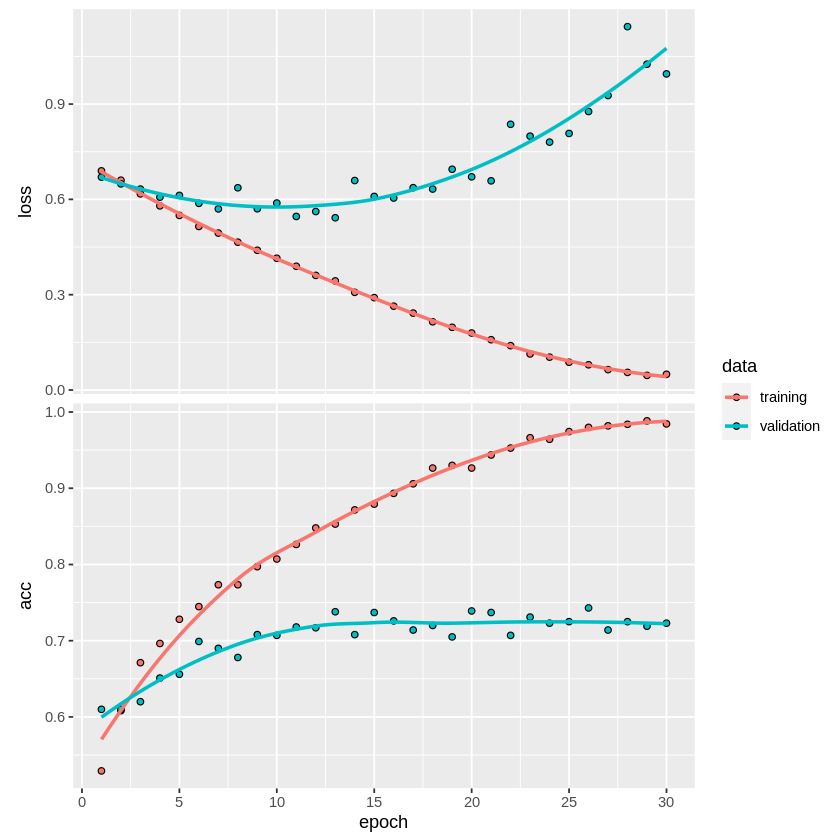

In [ ]:
plot(history)

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by an `image_data_generator()`. Let's get started with an example.

In [ ]:
datagen <- image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE,
  fill_mode = "nearest"
)

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

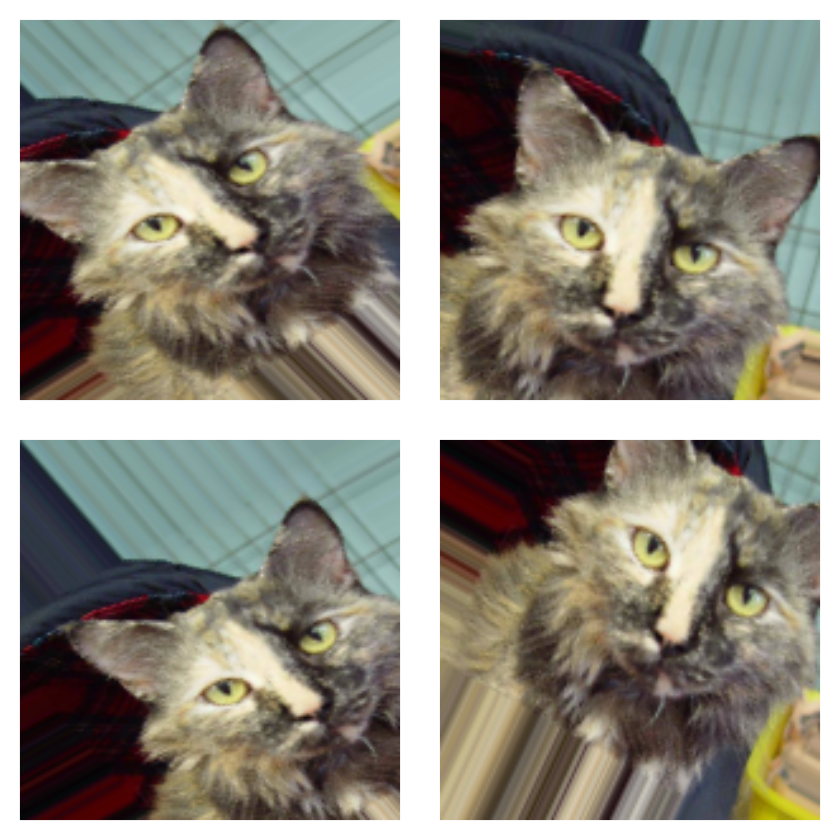

In [ ]:
# We pick one image to "augment"
fnames <- list.files(train_cats_dir, full.names = TRUE)
img_path <- fnames[[2]]

# Convert it to an array with shape (150, 150, 3)
img <- image_load(img_path, target_size = c(150, 150))
img_array <- image_to_array(img)
img_array <- array_reshape(img_array, c(1, 150, 150, 3))

# Generated that will flow augmented images
augmentation_generator <- flow_images_from_data(
  img_array, 
  generator = datagen, 
  batch_size = 1 
)

# Plot the first 4 augmented images
op <- par(mfrow = c(2, 2), pty = "s", mar = c(1, 0, 1, 0))
for (i in 1:4) {
  batch <- generator_next(augmentation_generator)
  plot(as.raster(batch[1,,,]))
}
par(op)

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a dropout layer to our model, right before the densely-connected classifier:

In [ ]:
model <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 3)) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_flatten() %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")  
  
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(learning_rate = 1e-4),
  metrics = c("acc")
)

Let's train our network using data augmentation and dropout:

In [ ]:
datagen <- image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE
)

test_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  train_dir,
  datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

validation_generator <- flow_images_from_directory(
  validation_dir,
  test_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 100,
  epochs = 30,
  validation_data = validation_generator,
  validation_steps = 50
)

Warning message in fit_generator(., train_generator, steps_per_epoch = 100, epochs = 30, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


Let's save our model -- we will be using it in the section on convnet visualization.

In [ ]:
model %>% save_model_hdf5("cats_and_dogs_small_2.h5")

Let's plot our results again:

`geom_smooth()` using formula 'y ~ x'



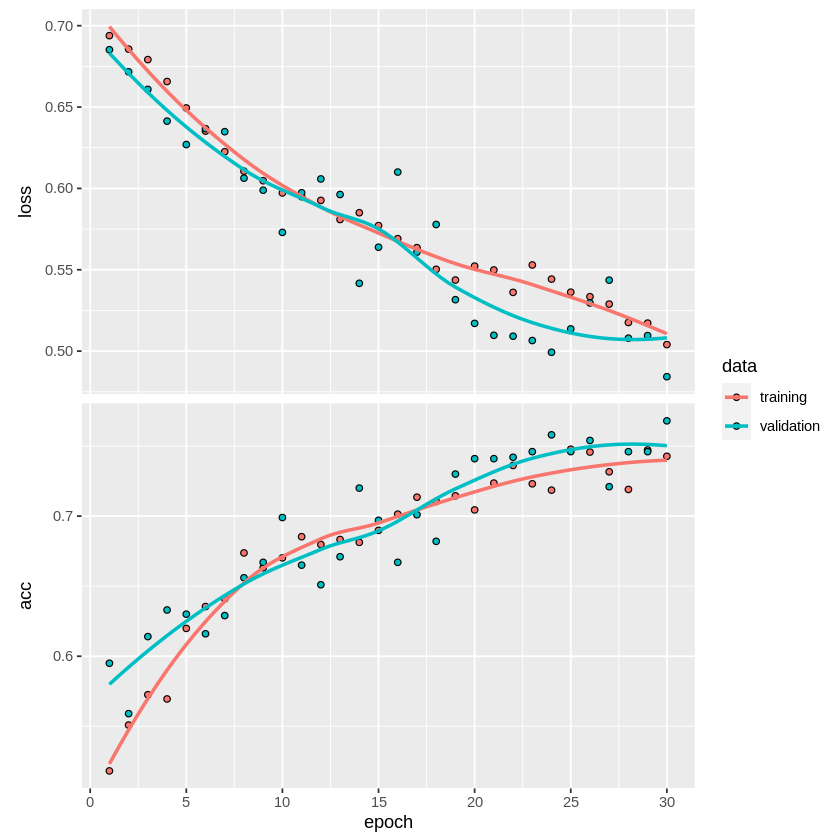

In [ ]:
plot(history)

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two sections.

***

This notebook contains the code samples found in Chapter 5, Section 3 of "Deep Learning with R"

***


A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes prepackaged with Keras. Here's the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of Keras:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [ ]:
conv_base <- application_vgg16(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = c(150, 150, 3)
)

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [ ]:
summary(conv_base)

Model: "vgg16"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 150, 150, 3)]           0           
                                                                                
 block1_conv1 (Conv2D)              (None, 150, 150, 64)            1792        
                                                                                
 block1_conv2 (Conv2D)              (None, 150, 150, 64)            36928       
                                                                                
 block1_pool (MaxPooling2D)         (None, 75, 75, 64)              0           
                                                                                
 block2_conv1 (Conv2D)              (None, 75, 75, 128)             73856       
                                                                                
 block2_conv2

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways you could proceed: 

* Running the convolutional base over your dataset, recording its output to an array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won't allow you to use data augmentation.
* Extending the model you have (`conv_base`) by adding dense layers on top, and running the whole thing end to end on the input data. This willallow you to use data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.


We'll cover both techniques. Let's walk through the code required to set up the first one: recording the output of `conv_base` on your data and using these outputs as inputs to a new model.

We'll start by running instances of the previously introduced `image_data_generator()` to extract images as arrays as well as their labels. We will extract features from these images by calling the `predict` method on the model.

In [ ]:
datagen <- image_data_generator(rescale = 1/255)
batch_size <- 20

extract_features <- function(directory, sample_count) {
  
  features <- array(0, dim = c(sample_count, 4, 4, 512))  
  labels <- array(0, dim = c(sample_count))
  
  generator <- flow_images_from_directory(
    directory = directory,
    generator = datagen,
    target_size = c(150, 150),
    batch_size = batch_size,
    class_mode = "binary"
  )
  
  i <- 0
  while(TRUE) {
    batch <- generator_next(generator)
    inputs_batch <- batch[[1]]
    labels_batch <- batch[[2]]
    features_batch <- conv_base %>% predict(inputs_batch)
    
    index_range <- ((i * batch_size)+1):((i + 1) * batch_size)
    features[index_range,,,] <- features_batch
    labels[index_range] <- labels_batch
    
    i <- i + 1
    if (i * batch_size >= sample_count)
      # Note that because generators yield data indefinitely in a loop, 
      # you must break after every image has been seen once.
      break
  }
  
  list(
    features = features, 
    labels = labels
  )
}

train <- extract_features(train_dir, 2000)
validation <- extract_features(validation_dir, 1000)
test <- extract_features(test_dir, 1000)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must flatten them to `(samples, 8192)`:

In [ ]:
reshape_features <- function(features) {
  array_reshape(features, dim = c(nrow(features), 4 * 4 * 512))
}
train$features <- reshape_features(train$features)
validation$features <- reshape_features(validation$features)
test$features <- reshape_features(test$features)

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [ ]:
model <- keras_model_sequential() %>% 
  layer_dense(units = 256, activation = "relu", 
              input_shape = 4 * 4 * 512) %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(lr = 2e-5),
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  train$features, train$labels,
  epochs = 30,
  batch_size = 20,
  validation_data = list(validation$features, validation$labels)
)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

`geom_smooth()` using formula 'y ~ x'



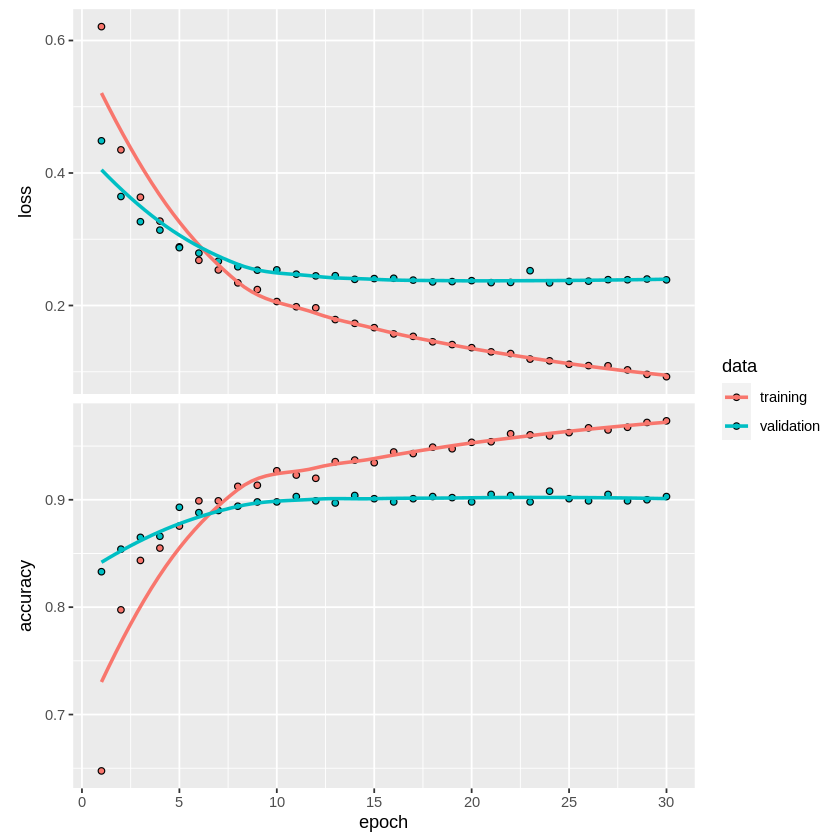

In [ ]:
plot(history)

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go. This takes upwards of an hour on a normal CPU based setup (this is what you are most likely using!)

Because models behave just like layers, you can add a model (like `conv_base`) to a sequential model just like you would add a layer. So, you can do the following:

In [ ]:
model <- keras_model_sequential() %>% 
  conv_base %>% 
  layer_flatten() %>% 
  layer_dense(units = 256, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

This is what our model looks like now:

In [ ]:
summary(model)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 vgg16 (Functional)                 (None, 4, 4, 512)               14714688    
                                                                                
 flatten_1 (Flatten)                (None, 8192)                    0           
                                                                                
 dense_5 (Dense)                    (None, 256)                     2097408     
                                                                                
 dense_4 (Dense)                    (None, 1)                       257         
                                                                                
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
________________________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before you compile and train the model, it's very important to freeze the convolutional base. _Freezing_ a layer or set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network using the `freeze_weights()` function:

In [ ]:
cat("This is the number of trainable weights before freezing",
    "the conv base:", length(model$trainable_weights), "\n")

This is the number of trainable weights before freezing the conv base: 30 


In [ ]:
freeze_weights(conv_base)

In [ ]:
cat("This is the number of trainable weights after freezing",
    "the conv base:", length(model$trainable_weights), "\n")

This is the number of trainable weights after freezing the conv base: 4 


With this setup, only the weights from the two dense layers that you added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example. (PLEASE NOTE THAT AS MENTIONED ABOVE, THIS CAN ONLY BE REALISTICALLY RUN ON GPU SETUPS, THIS SECTION IS INCLUDED FOR PURPOSES OF REFERENCE ONLY!)

In [ ]:
train_datagen = image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE,
  fill_mode = "nearest"
)

test_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  train_dir,
  train_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

validation_generator <- flow_images_from_directory(
  validation_dir,
  test_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 2e-5),
  metrics = c("accuracy")
)

history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 100,
  epochs = 30,
  validation_data = validation_generator,
  validation_steps = 50
)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”
Warning message in fit_generator(., train_generator, steps_per_epoch = 100, epochs = 30, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


In [ ]:
save_model_hdf5(model, "cats_and_dogs_small_3.h5")

Let's plot our results again:

In [ ]:
plot(history)

As you can see, we reach a validation accuracy of about 90%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [ ]:
summary(conv_base)

We will fine-tune all of the layers from `block3_conv1` and on. Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only some of the layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [ ]:
unfreeze_weights(conv_base, from = "block3_conv1")

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the layers that we are fine-tuning. Updates that are too large may harm these representations.

(PLEASE NOTE THAT AS MENTIONED ABOVE, THIS CAN ONLY BE REALISTICALLY RUN ON GPU SETUPS, THIS SECTION IS INCLUDED FOR PURPOSES OF REFERENCE ONLY!)

Now let's proceed with fine-tuning:

In [ ]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-5),
  metrics = c("accuracy")
)

history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 100,
  epochs = 100,
  validation_data = validation_generator,
  validation_steps = 50
)

In [ ]:
save_model_hdf5(model, "cats_and_dogs_small_4.h5")

Let's plot our results using the same plotting code as before:

In [ ]:
plot(history)

We are seeing a nice 6% absolute improvement in accuracy, from about 90% to above 96%.

Note that the loss curve doesn't show any real improvement (in fact, it's deteriorating). You may wonder, how could accuracy stay stable or improve if the loss isn't decreasing? The answer is simple: what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [ ]:
test_generator <- flow_images_from_directory(
  test_dir,
  test_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

model %>% evaluate_generator(test_generator, steps = 50)

Here we get a test accuracy of 96.5%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.